In [86]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

np.random.seed(121)
tf.random.set_seed(121)

In [87]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [88]:
sns.set(font_scale=1.6)

In [89]:
print (tf.__version__)

2.6.0


### Define PINN neural network

In [90]:
def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))
    
    return model

In [91]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, model):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = model
        
        self.iter = 0
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        xx = self.Xr_tf*self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)       
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1, loss_2, loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])

### Generate training data

In [92]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 300                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([300.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [93]:
N = 150000

### Train PINN without PCGrad

In [94]:
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-3, decay_steps=10000,
    end_learning_rate=0.0001, power=0.5)

In [95]:
PINN_solver = PINN(x_u, y_u, x_r, init_model())
initial_weights = PINN_solver.model.get_weights()

In [96]:
try:
    PINN_solver.model.load_weights('./checkpoints/pinn_solver')
except:
    optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
    PINN_solver.train(N=N, optimizer=optim, method = 'original')
    
    PINN_solver.model.save_weights('./checkpoints/pinn_solver')

Iteration 00000: loss = 0.04990299,6.80652e-05,0.00012687681,0.00033505302
Iteration 00005: loss = 0.012153628,5.6054876e-05,0.00017456977,0.00032956968
Iteration 00010: loss = 0.003192461,5.718474e-05,0.00020348179,0.00032491516
Iteration 00015: loss = 0.0011314248,6.1993436e-05,0.00021693212,0.0003188737
Iteration 00020: loss = 0.0005364726,6.676035e-05,0.00022065784,0.00031094905
Iteration 00025: loss = 0.00031819975,7.056417e-05,0.00021842132,0.00030135977
Iteration 00030: loss = 0.00022154936,7.338084e-05,0.00021249685,0.00029052395
Iteration 00035: loss = 0.00017243093,7.540697e-05,0.00020431893,0.00027886947
Iteration 00040: loss = 0.00014482239,7.685388e-05,0.00019483696,0.0002667736
Iteration 00045: loss = 0.00012806933,7.78941e-05,0.0001846993,0.0002545485
Iteration 00050: loss = 0.00011725141,7.8655314e-05,0.0001743548,0.0002424416
Iteration 00055: loss = 0.00010986806,7.9227466e-05,0.00016411347,0.00023064147
Iteration 00060: loss = 0.00010455786,7.967221e-05,0.00015418524,

Iteration 00645: loss = 1.496642e-05,6.55037e-05,1.465744e-05,2.8684046e-05
Iteration 00650: loss = 1.486852e-05,6.517545e-05,1.4583885e-05,2.8440078e-05
Iteration 00655: loss = 1.4772803e-05,6.484628e-05,1.4511263e-05,2.8198392e-05
Iteration 00660: loss = 1.4678249e-05,6.451624e-05,1.44395435e-05,2.795894e-05
Iteration 00665: loss = 1.458687e-05,6.418536e-05,1.4368699e-05,2.7721679e-05
Iteration 00670: loss = 1.4496592e-05,6.385367e-05,1.4298698e-05,2.7486576e-05
Iteration 00675: loss = 1.4408583e-05,6.352123e-05,1.4229524e-05,2.7253578e-05
Iteration 00680: loss = 1.4322439e-05,6.3188076e-05,1.4161138e-05,2.7022657e-05
Iteration 00685: loss = 1.4238536e-05,6.2854226e-05,1.4093527e-05,2.6793778e-05
Iteration 00690: loss = 1.4156016e-05,6.251975e-05,1.40266675e-05,2.6566902e-05
Iteration 00695: loss = 1.4075519e-05,6.218464e-05,1.3960534e-05,2.6341993e-05
Iteration 00700: loss = 1.3996559e-05,6.184899e-05,1.3895102e-05,2.6119022e-05
Iteration 00705: loss = 1.39191425e-05,6.151279e-05,1.

Iteration 01185: loss = 1.1213724e-05,3.1880834e-05,9.347502e-06,1.1718575e-05
Iteration 01190: loss = 1.1208886e-05,3.1648582e-05,9.31299e-06,1.1640065e-05
Iteration 01195: loss = 1.1203726e-05,3.1418665e-05,9.278697e-06,1.1562959e-05
Iteration 01200: loss = 1.1198613e-05,3.1191084e-05,9.244628e-06,1.1487253e-05
Iteration 01205: loss = 1.1193536e-05,3.096586e-05,9.210785e-06,1.1412937e-05
Iteration 01210: loss = 1.1188126e-05,3.074299e-05,9.177161e-06,1.1340012e-05
Iteration 01215: loss = 1.1182201e-05,3.0522464e-05,9.143762e-06,1.1268464e-05
Iteration 01220: loss = 1.1176476e-05,3.0304305e-05,9.110584e-06,1.1198289e-05
Iteration 01225: loss = 1.1170409e-05,3.008849e-05,9.077629e-06,1.112948e-05
Iteration 01230: loss = 1.11639865e-05,2.987504e-05,9.044893e-06,1.1062029e-05
Iteration 01235: loss = 1.11572035e-05,2.9663946e-05,9.012384e-06,1.09959265e-05
Iteration 01240: loss = 1.115043e-05,2.9455206e-05,8.980092e-06,1.0931168e-05
Iteration 01245: loss = 1.11432855e-05,2.9248818e-05,8.9

Iteration 01820: loss = 8.737547e-06,1.6802742e-05,6.4360693e-06,9.161748e-06
Iteration 01825: loss = 8.716073e-06,1.6753687e-05,6.421594e-06,9.170333e-06
Iteration 01830: loss = 8.694503e-06,1.6705193e-05,6.4072074e-06,9.179027e-06
Iteration 01835: loss = 8.673322e-06,1.6657246e-05,6.392909e-06,9.187831e-06
Iteration 01840: loss = 8.65204e-06,1.6609849e-05,6.3787e-06,9.196738e-06
Iteration 01845: loss = 8.630651e-06,1.6562992e-05,6.3645775e-06,9.205746e-06
Iteration 01850: loss = 8.60998e-06,1.6516664e-05,6.350544e-06,9.214851e-06
Iteration 01855: loss = 8.589038e-06,1.6470869e-05,6.3365947e-06,9.224047e-06
Iteration 01860: loss = 8.567997e-06,1.6425587e-05,6.3227317e-06,9.233333e-06
Iteration 01865: loss = 8.547505e-06,1.6380822e-05,6.3089533e-06,9.2427e-06
Iteration 01870: loss = 8.527067e-06,1.6336562e-05,6.29526e-06,9.252149e-06
Iteration 01875: loss = 8.506522e-06,1.6292803e-05,6.2816507e-06,9.261676e-06
Iteration 01880: loss = 8.486203e-06,1.6249542e-05,6.268124e-06,9.271274e-06

Iteration 02455: loss = 6.7591295e-06,1.339342e-05,5.1295165e-06,1.0259963e-05
Iteration 02460: loss = 6.748219e-06,1.3379405e-05,5.1221677e-06,1.0264411e-05
Iteration 02465: loss = 6.7376204e-06,1.3365482e-05,5.1148468e-06,1.0268759e-05
Iteration 02470: loss = 6.7268993e-06,1.3351647e-05,5.1075544e-06,1.0273008e-05
Iteration 02475: loss = 6.7163455e-06,1.3337907e-05,5.100288e-06,1.0277158e-05
Iteration 02480: loss = 6.7059614e-06,1.3324252e-05,5.0930494e-06,1.0281208e-05
Iteration 02485: loss = 6.6951648e-06,1.3310686e-05,5.0858353e-06,1.0285155e-05
Iteration 02490: loss = 6.684683e-06,1.32972e-05,5.078649e-06,1.0289003e-05
Iteration 02495: loss = 6.674365e-06,1.3283799e-05,5.071486e-06,1.0292748e-05
Iteration 02500: loss = 6.663921e-06,1.3270482e-05,5.0643507e-06,1.0296393e-05
Iteration 02505: loss = 6.6535067e-06,1.325724e-05,5.0572385e-06,1.0299938e-05
Iteration 02510: loss = 6.6432563e-06,1.3244075e-05,5.0501503e-06,1.0303377e-05
Iteration 02515: loss = 6.633171e-06,1.3230992e-05,

Iteration 02995: loss = 5.8556557e-06,1.2167008e-05,4.43075e-06,1.0152726e-05
Iteration 03000: loss = 5.8491028e-06,1.2156664e-05,4.424628e-06,1.0146348e-05
Iteration 03005: loss = 5.8428354e-06,1.2146314e-05,4.418504e-06,1.01398755e-05
Iteration 03010: loss = 5.836441e-06,1.2135962e-05,4.4123776e-06,1.0133313e-05
Iteration 03015: loss = 5.8299283e-06,1.2125606e-05,4.4062467e-06,1.0126657e-05
Iteration 03020: loss = 5.8234314e-06,1.2115244e-05,4.400114e-06,1.0119909e-05
Iteration 03025: loss = 5.817207e-06,1.2104879e-05,4.3939767e-06,1.0113072e-05
Iteration 03030: loss = 5.810998e-06,1.2094507e-05,4.3878363e-06,1.0106141e-05
Iteration 03035: loss = 5.8049386e-06,1.2084127e-05,4.3816926e-06,1.0099119e-05
Iteration 03040: loss = 5.7984803e-06,1.2073747e-05,4.375546e-06,1.0092009e-05
Iteration 03045: loss = 5.792304e-06,1.206336e-05,4.369394e-06,1.00848065e-05
Iteration 03050: loss = 5.7864104e-06,1.2052966e-05,4.363238e-06,1.0077514e-05
Iteration 03055: loss = 5.7799884e-06,1.2042566e-05

Iteration 03520: loss = 5.2820124e-06,1.101268e-05,3.7416614e-06,9.027742e-06
Iteration 03525: loss = 5.277101e-06,1.1000685e-05,3.7343877e-06,9.013131e-06
Iteration 03530: loss = 5.2720716e-06,1.0988664e-05,3.7270959e-06,8.998454e-06
Iteration 03535: loss = 5.267307e-06,1.0976625e-05,3.7197876e-06,8.98372e-06
Iteration 03540: loss = 5.262545e-06,1.0964557e-05,3.7124614e-06,8.96892e-06
Iteration 03545: loss = 5.2577966e-06,1.0952465e-05,3.7051175e-06,8.95406e-06
Iteration 03550: loss = 5.252925e-06,1.0940347e-05,3.697756e-06,8.939135e-06
Iteration 03555: loss = 5.2481896e-06,1.09282055e-05,3.6903766e-06,8.924149e-06
Iteration 03560: loss = 5.2432024e-06,1.09160455e-05,3.682982e-06,8.9091045e-06
Iteration 03565: loss = 5.238476e-06,1.0903859e-05,3.6755685e-06,8.8940005e-06
Iteration 03570: loss = 5.2337614e-06,1.0891651e-05,3.6681386e-06,8.878834e-06
Iteration 03575: loss = 5.228792e-06,1.0879419e-05,3.6606914e-06,8.86361e-06
Iteration 03580: loss = 5.224219e-06,1.0867157e-05,3.653225e-

Iteration 04145: loss = 4.673439e-06,9.308177e-06,2.7101948e-06,6.832226e-06
Iteration 04150: loss = 4.6682285e-06,9.292681e-06,2.7013143e-06,6.812838e-06
Iteration 04155: loss = 4.6627756e-06,9.277153e-06,2.6924345e-06,6.793444e-06
Iteration 04160: loss = 4.657563e-06,9.261592e-06,2.6835567e-06,6.774046e-06
Iteration 04165: loss = 4.6522296e-06,9.2459995e-06,2.6746798e-06,6.754642e-06
Iteration 04170: loss = 4.6472514e-06,9.230378e-06,2.665806e-06,6.7352357e-06
Iteration 04175: loss = 4.641792e-06,9.214732e-06,2.6569367e-06,6.71583e-06
Iteration 04180: loss = 4.6363316e-06,9.199058e-06,2.6480702e-06,6.696422e-06
Iteration 04185: loss = 4.6308683e-06,9.18335e-06,2.6392063e-06,6.6770117e-06
Iteration 04190: loss = 4.625527e-06,9.167606e-06,2.6303455e-06,6.6575976e-06
Iteration 04195: loss = 4.6200635e-06,9.151826e-06,2.6214893e-06,6.6381817e-06
Iteration 04200: loss = 4.614842e-06,9.136012e-06,2.612635e-06,6.6187654e-06
Iteration 04205: loss = 4.609377e-06,9.120169e-06,2.6037867e-06,6.5

Iteration 04775: loss = 3.881834e-06,7.0955075e-06,1.7095117e-06,4.534009e-06
Iteration 04780: loss = 3.874594e-06,7.0759365e-06,1.703132e-06,4.51814e-06
Iteration 04785: loss = 3.867354e-06,7.056338e-06,1.6967805e-06,4.502317e-06
Iteration 04790: loss = 3.8598882e-06,7.0367155e-06,1.6904553e-06,4.4865433e-06
Iteration 04795: loss = 3.852741e-06,7.017064e-06,1.6841564e-06,4.4708154e-06
Iteration 04800: loss = 3.8450485e-06,6.9973858e-06,1.6778847e-06,4.4551343e-06
Iteration 04805: loss = 3.837782e-06,6.977682e-06,1.6716389e-06,4.4395024e-06
Iteration 04810: loss = 3.830296e-06,6.9579482e-06,1.6654192e-06,4.423916e-06
Iteration 04815: loss = 3.8231256e-06,6.9381904e-06,1.6592247e-06,4.408376e-06
Iteration 04820: loss = 3.8156236e-06,6.9184102e-06,1.6530572e-06,4.3928853e-06
Iteration 04825: loss = 3.8083297e-06,6.898603e-06,1.646916e-06,4.3774417e-06
Iteration 04830: loss = 3.8008186e-06,6.8787695e-06,1.6407998e-06,4.362045e-06
Iteration 04835: loss = 3.7934112e-06,6.8589084e-06,1.63470

Iteration 05420: loss = 2.898901e-06,4.421966e-06,1.0433789e-06,2.820218e-06
Iteration 05425: loss = 2.8913328e-06,4.400945e-06,1.0390106e-06,2.8089926e-06
Iteration 05430: loss = 2.8836773e-06,4.3799387e-06,1.0346512e-06,2.7977924e-06
Iteration 05435: loss = 2.8760294e-06,4.3589434e-06,1.0303e-06,2.7866156e-06
Iteration 05440: loss = 2.868571e-06,4.3379655e-06,1.0259579e-06,2.7754643e-06
Iteration 05445: loss = 2.860929e-06,4.317006e-06,1.0216245e-06,2.764338e-06
Iteration 05450: loss = 2.8535726e-06,4.2960573e-06,1.0172994e-06,2.7532346e-06
Iteration 05455: loss = 2.8457573e-06,4.275131e-06,1.0129834e-06,2.7421574e-06
Iteration 05460: loss = 2.8383195e-06,4.254218e-06,1.0086762e-06,2.7311032e-06
Iteration 05465: loss = 2.830701e-06,4.233324e-06,1.0043779e-06,2.7200736e-06
Iteration 05470: loss = 2.8231786e-06,4.2124475e-06,1.000088e-06,2.7090673e-06
Iteration 05475: loss = 2.8155703e-06,4.1915914e-06,9.958075e-07,2.6980865e-06
Iteration 05480: loss = 2.8079673e-06,4.170754e-06,9.9153

Iteration 06080: loss = 1.9228737e-06,1.969113e-06,5.6086054e-07,1.5554924e-06
Iteration 06085: loss = 1.9158606e-06,1.9544925e-06,5.581331e-07,1.547792e-06
Iteration 06090: loss = 1.9087863e-06,1.9399477e-06,5.5542205e-07,1.5401233e-06
Iteration 06095: loss = 1.9016464e-06,1.925483e-06,5.527285e-07,1.5324882e-06
Iteration 06100: loss = 1.8946689e-06,1.9110964e-06,5.50052e-07,1.5248856e-06
Iteration 06105: loss = 1.8877076e-06,1.8967886e-06,5.473923e-07,1.5173158e-06
Iteration 06110: loss = 1.8804553e-06,1.8825568e-06,5.4474947e-07,1.509778e-06
Iteration 06115: loss = 1.8735964e-06,1.868405e-06,5.421235e-07,1.5022734e-06
Iteration 06120: loss = 1.8666724e-06,1.8543327e-06,5.3951436e-07,1.4948015e-06
Iteration 06125: loss = 1.8596098e-06,1.8403392e-06,5.369225e-07,1.4873633e-06
Iteration 06130: loss = 1.8525615e-06,1.8264266e-06,5.3434786e-07,1.4799579e-06
Iteration 06135: loss = 1.845602e-06,1.8125914e-06,5.3178974e-07,1.4725854e-06
Iteration 06140: loss = 1.8385808e-06,1.7988344e-06,5

Iteration 06645: loss = 1.2061679e-06,8.090797e-07,3.5484723e-07,8.9390767e-07
Iteration 06650: loss = 1.2008336e-06,8.028329e-07,3.5381154e-07,8.898279e-07
Iteration 06655: loss = 1.1955161e-06,7.966416e-07,3.5278586e-07,8.857742e-07
Iteration 06660: loss = 1.1902164e-06,7.905063e-07,3.5177032e-07,8.817468e-07
Iteration 06665: loss = 1.1848698e-06,7.8442815e-07,3.5076494e-07,8.777471e-07
Iteration 06670: loss = 1.1796009e-06,7.784076e-07,3.4976935e-07,8.737747e-07
Iteration 06675: loss = 1.1744681e-06,7.724423e-07,3.4878371e-07,8.698293e-07
Iteration 06680: loss = 1.169231e-06,7.665322e-07,3.478077e-07,8.659094e-07
Iteration 06685: loss = 1.163889e-06,7.60676e-07,3.4684132e-07,8.6201607e-07
Iteration 06690: loss = 1.1588049e-06,7.548739e-07,3.4588447e-07,8.581488e-07
Iteration 06695: loss = 1.153676e-06,7.4912396e-07,3.4493675e-07,8.5430673e-07
Iteration 06700: loss = 1.1485039e-06,7.434293e-07,3.4399875e-07,8.504912e-07
Iteration 06705: loss = 1.1434669e-06,7.377868e-07,3.4306967e-07

Iteration 07215: loss = 7.356943e-07,3.7190298e-07,2.8241735e-07,5.6874114e-07
Iteration 07220: loss = 7.32655e-07,3.6980757e-07,2.8205454e-07,5.668472e-07
Iteration 07225: loss = 7.2976985e-07,3.6773267e-07,2.816948e-07,5.649661e-07
Iteration 07230: loss = 7.267494e-07,3.656798e-07,2.8133852e-07,5.630968e-07
Iteration 07235: loss = 7.2393e-07,3.6364582e-07,2.80985e-07,5.612403e-07
Iteration 07240: loss = 7.2092826e-07,3.616329e-07,2.8063474e-07,5.593961e-07
Iteration 07245: loss = 7.180331e-07,3.596388e-07,2.8028728e-07,5.575632e-07
Iteration 07250: loss = 7.151471e-07,3.5766382e-07,2.7994287e-07,5.557423e-07
Iteration 07255: loss = 7.1227083e-07,3.557077e-07,2.7960115e-07,5.539328e-07
Iteration 07260: loss = 7.094989e-07,3.5377056e-07,2.792625e-07,5.5213513e-07
Iteration 07265: loss = 7.0654625e-07,3.5185215e-07,2.7892696e-07,5.503489e-07
Iteration 07270: loss = 7.0379264e-07,3.499515e-07,2.7859403e-07,5.4857384e-07
Iteration 07275: loss = 7.0090726e-07,3.48069e-07,2.782638e-07,5.468

Iteration 07780: loss = 4.837246e-07,2.2701698e-07,2.5514314e-07,4.1483153e-07
Iteration 07785: loss = 4.820854e-07,2.2629688e-07,2.549762e-07,4.1387787e-07
Iteration 07790: loss = 4.804513e-07,2.2558159e-07,2.548098e-07,4.1292884e-07
Iteration 07795: loss = 4.788997e-07,2.248729e-07,2.5464405e-07,4.1198518e-07
Iteration 07800: loss = 4.772746e-07,2.2417022e-07,2.5447875e-07,4.110465e-07
Iteration 07805: loss = 4.7565467e-07,2.234738e-07,2.5431393e-07,4.1011293e-07
Iteration 07810: loss = 4.7411618e-07,2.2278303e-07,2.5414946e-07,4.0918462e-07
Iteration 07815: loss = 4.7250538e-07,2.2209737e-07,2.5398555e-07,4.08261e-07
Iteration 07820: loss = 4.7097615e-07,2.2141785e-07,2.5382212e-07,4.0734187e-07
Iteration 07825: loss = 4.6937467e-07,2.2074339e-07,2.5365915e-07,4.0642786e-07
Iteration 07830: loss = 4.678549e-07,2.20074e-07,2.5349655e-07,4.055185e-07
Iteration 07835: loss = 4.6626278e-07,2.1941018e-07,2.5333418e-07,4.04614e-07
Iteration 07840: loss = 4.6475145e-07,2.1875162e-07,2.5317

Iteration 08340: loss = 3.4460217e-07,1.7243532e-07,2.371229e-07,3.3228446e-07
Iteration 08345: loss = 3.4369813e-07,1.7210402e-07,2.3695124e-07,3.3170764e-07
Iteration 08350: loss = 3.4279648e-07,1.7177258e-07,2.3677919e-07,3.3113272e-07
Iteration 08355: loss = 3.4186405e-07,1.7144325e-07,2.3660684e-07,3.3055957e-07
Iteration 08360: loss = 3.4096618e-07,1.7111721e-07,2.3643399e-07,3.299894e-07
Iteration 08365: loss = 3.4007027e-07,1.7079306e-07,2.3626092e-07,3.2942103e-07
Iteration 08370: loss = 3.3917664e-07,1.7047064e-07,2.360875e-07,3.2885475e-07
Iteration 08375: loss = 3.3822005e-07,1.7015005e-07,2.3591346e-07,3.2829024e-07
Iteration 08380: loss = 3.3733136e-07,1.6983033e-07,2.3573928e-07,3.2772738e-07
Iteration 08385: loss = 3.3644474e-07,1.6951151e-07,2.3556458e-07,3.271664e-07
Iteration 08390: loss = 3.355606e-07,1.6919479e-07,2.3538965e-07,3.266069e-07
Iteration 08395: loss = 3.346786e-07,1.6887907e-07,2.3521424e-07,3.2604953e-07
Iteration 08400: loss = 3.3379888e-07,1.6856471

Iteration 08910: loss = 2.6218785e-07,1.4244443e-07,2.1510974e-07,2.7601524e-07
Iteration 08915: loss = 2.6165847e-07,1.4223141e-07,2.1489662e-07,2.7558474e-07
Iteration 08920: loss = 2.610728e-07,1.4202e-07,2.1468348e-07,2.7515497e-07
Iteration 08925: loss = 2.60546e-07,1.4180895e-07,2.1446996e-07,2.747261e-07
Iteration 08930: loss = 2.599629e-07,1.4159853e-07,2.1425616e-07,2.7429826e-07
Iteration 08935: loss = 2.5949547e-07,1.4138858e-07,2.1404213e-07,2.7387074e-07
Iteration 08940: loss = 2.5891455e-07,1.4117862e-07,2.1382803e-07,2.7344413e-07
Iteration 08945: loss = 2.5833546e-07,1.4096996e-07,2.136135e-07,2.730181e-07
Iteration 08950: loss = 2.5781478e-07,1.4076089e-07,2.1339865e-07,2.725928e-07
Iteration 08955: loss = 2.5729508e-07,1.4055253e-07,2.1318357e-07,2.7216848e-07
Iteration 08960: loss = 2.5677642e-07,1.4034532e-07,2.1296825e-07,2.7174497e-07
Iteration 08965: loss = 2.5620184e-07,1.4013861e-07,2.1275261e-07,2.713225e-07
Iteration 08970: loss = 2.556856e-07,1.3993291e-07,2

Iteration 09470: loss = 2.1306828e-07,1.2211082e-07,1.9031545e-07,2.325036e-07
Iteration 09475: loss = 2.1274809e-07,1.219587e-07,1.9009404e-07,2.3215806e-07
Iteration 09480: loss = 2.1242924e-07,1.2180718e-07,1.8987306e-07,2.3181315e-07
Iteration 09485: loss = 2.120593e-07,1.2165495e-07,1.8965189e-07,2.3146931e-07
Iteration 09490: loss = 2.117419e-07,1.215031e-07,1.8943093e-07,2.3112612e-07
Iteration 09495: loss = 2.1142493e-07,1.2135234e-07,1.8921028e-07,2.3078401e-07
Iteration 09500: loss = 2.1110812e-07,1.2120259e-07,1.8898994e-07,2.3044258e-07
Iteration 09505: loss = 2.1074096e-07,1.2105319e-07,1.8876972e-07,2.3010244e-07
Iteration 09510: loss = 2.1042574e-07,1.209049e-07,1.8854993e-07,2.2976293e-07
Iteration 09515: loss = 2.1011151e-07,1.2075674e-07,1.8833028e-07,2.2942443e-07
Iteration 09520: loss = 2.0979773e-07,1.2060883e-07,1.8811075e-07,2.2908671e-07
Iteration 09525: loss = 2.09433e-07,1.2046203e-07,1.8789162e-07,2.2874978e-07
Iteration 09530: loss = 2.0917241e-07,1.2031478e

Iteration 10030: loss = 1.859243e-07,1.091527e-07,1.6952009e-07,2.0198499e-07
Iteration 10035: loss = 1.8584178e-07,1.0910153e-07,1.6942808e-07,2.0185705e-07
Iteration 10040: loss = 1.8571039e-07,1.0904903e-07,1.6933582e-07,2.0172901e-07
Iteration 10045: loss = 1.8567609e-07,1.0899666e-07,1.6924342e-07,2.0160049e-07
Iteration 10050: loss = 1.8554503e-07,1.0894398e-07,1.6915084e-07,2.014717e-07
Iteration 10055: loss = 1.8546234e-07,1.0889162e-07,1.6905797e-07,2.0134283e-07
Iteration 10060: loss = 1.8533113e-07,1.0883916e-07,1.689649e-07,2.0121387e-07
Iteration 10065: loss = 1.8520024e-07,1.0878665e-07,1.6887165e-07,2.0108452e-07
Iteration 10070: loss = 1.851174e-07,1.087338e-07,1.6877833e-07,2.0095482e-07
Iteration 10075: loss = 1.8498632e-07,1.08681405e-07,1.6868485e-07,2.0082504e-07
Iteration 10080: loss = 1.8495182e-07,1.0862898e-07,1.68591e-07,2.0069497e-07
Iteration 10085: loss = 1.8482037e-07,1.0857572e-07,1.6849688e-07,2.0056495e-07
Iteration 10090: loss = 1.8473764e-07,1.0852304

Iteration 10545: loss = 1.7483165e-07,1.0342379e-07,1.5894187e-07,1.8756592e-07
Iteration 10550: loss = 1.7470006e-07,1.03364584e-07,1.5882766e-07,1.8741358e-07
Iteration 10555: loss = 1.7456854e-07,1.03305226e-07,1.5871314e-07,1.8726092e-07
Iteration 10560: loss = 1.7448394e-07,1.0324597e-07,1.5859854e-07,1.8710809e-07
Iteration 10565: loss = 1.7435248e-07,1.0318636e-07,1.5848374e-07,1.8695471e-07
Iteration 10570: loss = 1.7422133e-07,1.0312709e-07,1.5836862e-07,1.8680116e-07
Iteration 10575: loss = 1.7413703e-07,1.03067165e-07,1.5825324e-07,1.8664728e-07
Iteration 10580: loss = 1.740055e-07,1.0300769e-07,1.5813775e-07,1.8649334e-07
Iteration 10585: loss = 1.7387401e-07,1.02948086e-07,1.580221e-07,1.8633905e-07
Iteration 10590: loss = 1.7378926e-07,1.02888286e-07,1.5790627e-07,1.8618444e-07
Iteration 10595: loss = 1.7365774e-07,1.0282883e-07,1.5778987e-07,1.8602996e-07
Iteration 10600: loss = 1.7352649e-07,1.0276899e-07,1.5767345e-07,1.8587501e-07
Iteration 10605: loss = 1.7344185e-07

Iteration 11170: loss = 1.5998437e-07,9.554502e-08,1.4282381e-07,1.6659102e-07
Iteration 11175: loss = 1.5989872e-07,9.5478235e-08,1.4267934e-07,1.6640799e-07
Iteration 11180: loss = 1.597683e-07,9.5411295e-08,1.4253469e-07,1.6622441e-07
Iteration 11185: loss = 1.5963776e-07,9.534375e-08,1.4238974e-07,1.6604069e-07
Iteration 11190: loss = 1.5950751e-07,9.52768e-08,1.4224452e-07,1.6585648e-07
Iteration 11195: loss = 1.5937717e-07,9.520987e-08,1.4209928e-07,1.656721e-07
Iteration 11200: loss = 1.5924684e-07,9.5143e-08,1.4195365e-07,1.6548738e-07
Iteration 11205: loss = 1.5911648e-07,9.507595e-08,1.418077e-07,1.6530261e-07
Iteration 11210: loss = 1.5903099e-07,9.500805e-08,1.4166142e-07,1.6511787e-07
Iteration 11215: loss = 1.5890076e-07,9.4940575e-08,1.41515e-07,1.6493243e-07
Iteration 11220: loss = 1.5877052e-07,9.4873215e-08,1.4136833e-07,1.6474705e-07
Iteration 11225: loss = 1.5864005e-07,9.480602e-08,1.4122138e-07,1.6456124e-07
Iteration 11230: loss = 1.5850989e-07,9.473867e-08,1.410

Iteration 11805: loss = 1.4397207e-07,8.6690925e-08,1.225126e-07,1.4149715e-07
Iteration 11810: loss = 1.4380178e-07,8.661856e-08,1.2233743e-07,1.4128636e-07
Iteration 11815: loss = 1.4367431e-07,8.654595e-08,1.2216204e-07,1.4107526e-07
Iteration 11820: loss = 1.435892e-07,8.647419e-08,1.2198653e-07,1.4086409e-07
Iteration 11825: loss = 1.4346159e-07,8.640186e-08,1.2181059e-07,1.4065289e-07
Iteration 11830: loss = 1.4329159e-07,8.633034e-08,1.2163454e-07,1.4044149e-07
Iteration 11835: loss = 1.4316394e-07,8.62577e-08,1.2145831e-07,1.4022973e-07
Iteration 11840: loss = 1.4307905e-07,8.618504e-08,1.212818e-07,1.4001786e-07
Iteration 11845: loss = 1.4295158e-07,8.6113005e-08,1.2110516e-07,1.3980579e-07
Iteration 11850: loss = 1.4278156e-07,8.604106e-08,1.2092823e-07,1.3959371e-07
Iteration 11855: loss = 1.4265414e-07,8.596886e-08,1.2075117e-07,1.393813e-07
Iteration 11860: loss = 1.4252656e-07,8.5896595e-08,1.2057382e-07,1.3916882e-07
Iteration 11865: loss = 1.4244144e-07,8.582401e-08,1.2

Iteration 12435: loss = 1.2756358e-07,7.7455454e-08,9.892296e-08,1.138362e-07
Iteration 12440: loss = 1.2744056e-07,7.7381245e-08,9.872594e-08,1.1361085e-07
Iteration 12445: loss = 1.2731766e-07,7.730737e-08,9.8528616e-08,1.1338561e-07
Iteration 12450: loss = 1.2719495e-07,7.723326e-08,9.8331306e-08,1.1316005e-07
Iteration 12455: loss = 1.2707264e-07,7.715874e-08,9.813385e-08,1.129346e-07
Iteration 12460: loss = 1.2694998e-07,7.7084536e-08,9.793635e-08,1.12708996e-07
Iteration 12465: loss = 1.2678733e-07,7.7010576e-08,9.773869e-08,1.1248353e-07
Iteration 12470: loss = 1.266647e-07,7.693654e-08,9.7540955e-08,1.1225818e-07
Iteration 12475: loss = 1.2654213e-07,7.68625e-08,9.7343154e-08,1.1203266e-07
Iteration 12480: loss = 1.264193e-07,7.678864e-08,9.7145204e-08,1.1180739e-07
Iteration 12485: loss = 1.2629673e-07,7.6715715e-08,9.694732e-08,1.1158194e-07
Iteration 12490: loss = 1.26174e-07,7.664147e-08,9.6749126e-08,1.1135652e-07
Iteration 12495: loss = 1.260115e-07,7.656829e-08,9.655105e

Iteration 12980: loss = 1.13469746e-07,6.9474325e-08,7.713423e-08,8.9461466e-08
Iteration 12985: loss = 1.1331458e-07,6.940166e-08,7.6934796e-08,8.924318e-08
Iteration 12990: loss = 1.13197125e-07,6.932945e-08,7.6735525e-08,8.902488e-08
Iteration 12995: loss = 1.13117615e-07,6.925674e-08,7.653629e-08,8.880682e-08
Iteration 13000: loss = 1.129624e-07,6.918547e-08,7.63373e-08,8.858899e-08
Iteration 13005: loss = 1.12844965e-07,6.911343e-08,7.613821e-08,8.8371436e-08
Iteration 13010: loss = 1.12727406e-07,6.9042194e-08,7.59393e-08,8.8154096e-08
Iteration 13015: loss = 1.1257253e-07,6.897031e-08,7.574045e-08,8.793701e-08
Iteration 13020: loss = 1.12455275e-07,6.889813e-08,7.554168e-08,8.7719926e-08
Iteration 13025: loss = 1.1233789e-07,6.882669e-08,7.534309e-08,8.7503125e-08
Iteration 13030: loss = 1.12183194e-07,6.875534e-08,7.514452e-08,8.728643e-08
Iteration 13035: loss = 1.12066196e-07,6.8683185e-08,7.494602e-08,8.706981e-08
Iteration 13040: loss = 1.1194933e-07,6.8611286e-08,7.474759e

Iteration 13540: loss = 9.942405e-08,6.1620824e-08,5.5754935e-08,6.648815e-08
Iteration 13545: loss = 9.931302e-08,6.155265e-08,5.557681e-08,6.6300274e-08
Iteration 13550: loss = 9.916638e-08,6.148501e-08,5.539891e-08,6.611273e-08
Iteration 13555: loss = 9.9055406e-08,6.1417374e-08,5.5221413e-08,6.592572e-08
Iteration 13560: loss = 9.894444e-08,6.134949e-08,5.50442e-08,6.573879e-08
Iteration 13565: loss = 9.8833475e-08,6.128151e-08,5.4867293e-08,6.5552214e-08
Iteration 13570: loss = 9.8687416e-08,6.121395e-08,5.469067e-08,6.536604e-08
Iteration 13575: loss = 9.857658e-08,6.1145926e-08,5.4514356e-08,6.5180416e-08
Iteration 13580: loss = 9.846571e-08,6.107897e-08,5.433843e-08,6.499508e-08
Iteration 13585: loss = 9.835464e-08,6.101169e-08,5.4162822e-08,6.481035e-08
Iteration 13590: loss = 9.820863e-08,6.094489e-08,5.398758e-08,6.462582e-08
Iteration 13595: loss = 9.8098404e-08,6.0876985e-08,5.3812407e-08,6.444136e-08
Iteration 13600: loss = 9.7952885e-08,6.080841e-08,5.3637542e-08,6.42573

Iteration 14100: loss = 8.613225e-08,5.4249977e-08,3.79775e-08,4.7942965e-08
Iteration 14105: loss = 8.599523e-08,5.418659e-08,3.784085e-08,4.780164e-08
Iteration 14110: loss = 8.589088e-08,5.4123376e-08,3.7704655e-08,4.76609e-08
Iteration 14115: loss = 8.5786894e-08,5.405924e-08,3.7568757e-08,4.7520324e-08
Iteration 14120: loss = 8.56831e-08,5.3995414e-08,3.7433303e-08,4.7380116e-08
Iteration 14125: loss = 8.554662e-08,5.3931107e-08,3.729819e-08,4.7240434e-08
Iteration 14130: loss = 8.5410115e-08,5.3868025e-08,3.7163638e-08,4.7101206e-08
Iteration 14135: loss = 8.5306624e-08,5.380373e-08,3.7029388e-08,4.6962203e-08
Iteration 14140: loss = 8.520308e-08,5.374e-08,3.6895546e-08,4.6823835e-08
Iteration 14145: loss = 8.509938e-08,5.3676754e-08,3.6762227e-08,4.6685994e-08
Iteration 14150: loss = 8.4962984e-08,5.3613586e-08,3.662936e-08,4.654876e-08
Iteration 14155: loss = 8.48593e-08,5.3550387e-08,3.6496974e-08,4.641183e-08
Iteration 14160: loss = 8.475578e-08,5.3487152e-08,3.6364916e-08,4.

Iteration 14655: loss = 7.39202e-08,4.7331255e-08,2.532949e-08,3.481774e-08
Iteration 14660: loss = 7.3792954e-08,4.727079e-08,2.5237878e-08,3.4721634e-08
Iteration 14665: loss = 7.3696675e-08,4.7208697e-08,2.514646e-08,3.462545e-08
Iteration 14670: loss = 7.360065e-08,4.714739e-08,2.5055355e-08,3.4529748e-08
Iteration 14675: loss = 7.347396e-08,4.7085955e-08,2.4964724e-08,3.4434535e-08
Iteration 14680: loss = 7.3377464e-08,4.702501e-08,2.4874494e-08,3.433961e-08
Iteration 14685: loss = 7.3280965e-08,4.6965322e-08,2.4784734e-08,3.4245467e-08
Iteration 14690: loss = 7.315414e-08,4.690447e-08,2.469538e-08,3.4151462e-08
Iteration 14695: loss = 7.305814e-08,4.6843162e-08,2.4606239e-08,3.4057486e-08
Iteration 14700: loss = 7.2962216e-08,4.6782215e-08,2.4517384e-08,3.3963985e-08
Iteration 14705: loss = 7.2866314e-08,4.6721038e-08,2.4428928e-08,3.387086e-08
Iteration 14710: loss = 7.2770426e-08,4.6660443e-08,2.4340846e-08,3.3778143e-08
Iteration 14715: loss = 7.264428e-08,4.6599574e-08,2.4253

Iteration 15215: loss = 6.269832e-08,4.0633033e-08,1.7100861e-08,2.5958947e-08
Iteration 15220: loss = 6.2609615e-08,4.0575365e-08,1.7043574e-08,2.5894952e-08
Iteration 15225: loss = 6.252127e-08,4.051738e-08,1.6986474e-08,2.5830959e-08
Iteration 15230: loss = 6.240507e-08,4.0458854e-08,1.6929535e-08,2.5767022e-08
Iteration 15235: loss = 6.2317e-08,4.0400046e-08,1.6872796e-08,2.5703415e-08
Iteration 15240: loss = 6.220095e-08,4.03423e-08,1.6816365e-08,2.564017e-08
Iteration 15245: loss = 6.214077e-08,4.0283865e-08,1.6760225e-08,2.5577089e-08
Iteration 15250: loss = 6.2024526e-08,4.022659e-08,1.6704407e-08,2.5514243e-08
Iteration 15255: loss = 6.193689e-08,4.0168075e-08,1.6648622e-08,2.5451524e-08
Iteration 15260: loss = 6.184917e-08,4.0109704e-08,1.6593107e-08,2.5388902e-08
Iteration 15265: loss = 6.176138e-08,4.0052218e-08,1.6537875e-08,2.5326642e-08
Iteration 15270: loss = 6.167361e-08,3.9994617e-08,1.648286e-08,2.5264672e-08
Iteration 15275: loss = 6.155815e-08,3.9936634e-08,1.64281

Iteration 15745: loss = 5.323051e-08,3.4680664e-08,1.2161963e-08,2.0186471e-08
Iteration 15750: loss = 5.312408e-08,3.4627416e-08,1.2124692e-08,2.0140462e-08
Iteration 15755: loss = 5.304362e-08,3.457405e-08,1.2087586e-08,2.0094557e-08
Iteration 15760: loss = 5.2989133e-08,3.452056e-08,1.2050547e-08,2.0048752e-08
Iteration 15765: loss = 5.288329e-08,3.4466805e-08,1.2013528e-08,2.0002838e-08
Iteration 15770: loss = 5.2803397e-08,3.441312e-08,1.1976678e-08,1.9957202e-08
Iteration 15775: loss = 5.2697676e-08,3.4359775e-08,1.1940039e-08,1.9911662e-08
Iteration 15780: loss = 5.2643685e-08,3.430557e-08,1.1903465e-08,1.9866214e-08
Iteration 15785: loss = 5.256366e-08,3.4252825e-08,1.1867179e-08,1.9821089e-08
Iteration 15790: loss = 5.2457878e-08,3.4200305e-08,1.1831108e-08,1.9776135e-08
Iteration 15795: loss = 5.2403745e-08,3.414698e-08,1.17950805e-08,1.9731234e-08
Iteration 15800: loss = 5.2298493e-08,3.409409e-08,1.17591075e-08,1.9686297e-08
Iteration 15805: loss = 5.2219264e-08,3.4040372e-

Iteration 16300: loss = 4.4532595e-08,2.9071376e-08,8.763802e-09,1.5743653e-08
Iteration 16305: loss = 4.4460467e-08,2.9024456e-08,8.739009e-09,1.5708956e-08
Iteration 16310: loss = 4.436488e-08,2.8977324e-08,8.7142595e-09,1.5674397e-08
Iteration 16315: loss = 4.431698e-08,2.8929474e-08,8.689506e-09,1.5639687e-08
Iteration 16320: loss = 4.4245198e-08,2.888235e-08,8.664991e-09,1.56052e-08
Iteration 16325: loss = 4.4173504e-08,2.8835462e-08,8.640547e-09,1.5570787e-08
Iteration 16330: loss = 4.4078178e-08,2.8788914e-08,8.616272e-09,1.5536555e-08
Iteration 16335: loss = 4.403026e-08,2.874217e-08,8.591979e-09,1.5502298e-08
Iteration 16340: loss = 4.3959258e-08,2.8694394e-08,8.567607e-09,1.5467863e-08
Iteration 16345: loss = 4.3864603e-08,2.8647237e-08,8.543345e-09,1.5433606e-08
Iteration 16350: loss = 4.381667e-08,2.8600486e-08,8.519385e-09,1.5399667e-08
Iteration 16355: loss = 4.3745064e-08,2.8554899e-08,8.495629e-09,1.5365925e-08
Iteration 16360: loss = 4.3673413e-08,2.8509252e-08,8.47201

Iteration 16885: loss = 3.671454e-08,2.3968214e-08,6.3810317e-09,1.2168647e-08
Iteration 16890: loss = 3.665119e-08,2.3927829e-08,6.364498e-09,1.2141709e-08
Iteration 16895: loss = 3.658767e-08,2.3887953e-08,6.348161e-09,1.2115003e-08
Iteration 16900: loss = 3.6523932e-08,2.3848736e-08,6.331977e-09,1.2088489e-08
Iteration 16905: loss = 3.648184e-08,2.3809353e-08,6.315792e-09,1.2061995e-08
Iteration 16910: loss = 3.6418395e-08,2.3770124e-08,6.2996603e-09,1.2035551e-08
Iteration 16915: loss = 3.633379e-08,2.3730436e-08,6.283472e-09,1.2009088e-08
Iteration 16920: loss = 3.6270894e-08,2.3690502e-08,6.2672587e-09,1.1982502e-08
Iteration 16925: loss = 3.622927e-08,2.3650868e-08,6.251167e-09,1.195604e-08
Iteration 16930: loss = 3.616617e-08,2.3611673e-08,6.235232e-09,1.1929762e-08
Iteration 16935: loss = 3.6103163e-08,2.3571983e-08,6.219344e-09,1.1903546e-08
Iteration 16940: loss = 3.6040465e-08,2.3532644e-08,6.2034373e-09,1.187729e-08
Iteration 16945: loss = 3.599904e-08,2.3493198e-08,6.1875

Iteration 17490: loss = 2.9994492e-08,1.9596301e-08,4.7635504e-09,9.317267e-09
Iteration 17495: loss = 2.99389e-08,1.9563887e-08,4.7529034e-09,9.296749e-09
Iteration 17500: loss = 2.9902836e-08,1.9531395e-08,4.7422692e-09,9.276179e-09
Iteration 17505: loss = 2.9847186e-08,1.9499588e-08,4.731733e-09,9.255784e-09
Iteration 17510: loss = 2.981119e-08,1.9467077e-08,4.721206e-09,9.235354e-09
Iteration 17515: loss = 2.9755412e-08,1.9435783e-08,4.710847e-09,9.215213e-09
Iteration 17520: loss = 2.9719567e-08,1.9403778e-08,4.700351e-09,9.194876e-09
Iteration 17525: loss = 2.9664294e-08,1.9371425e-08,4.689907e-09,9.174541e-09
Iteration 17530: loss = 2.9609247e-08,1.9339126e-08,4.6794684e-09,9.1542685e-09
Iteration 17535: loss = 2.9573684e-08,1.930693e-08,4.669005e-09,9.133925e-09
Iteration 17540: loss = 2.9518667e-08,1.9274767e-08,4.658674e-09,9.113744e-09
Iteration 17545: loss = 2.9463143e-08,1.9243993e-08,4.6486153e-09,9.093942e-09
Iteration 17550: loss = 2.9407808e-08,1.92131e-08,4.638533e-09

Iteration 18040: loss = 2.5008193e-08,1.6395976e-08,3.7953254e-09,7.323353e-09
Iteration 18045: loss = 2.4958588e-08,1.6370699e-08,3.788269e-09,7.3077437e-09
Iteration 18050: loss = 2.490931e-08,1.6345103e-08,3.7811425e-09,7.292045e-09
Iteration 18055: loss = 2.4878155e-08,1.6318923e-08,3.7739185e-09,7.2762334e-09
Iteration 18060: loss = 2.4846715e-08,1.6293095e-08,3.766813e-09,7.2605704e-09
Iteration 18065: loss = 2.4797414e-08,1.6268137e-08,3.759852e-09,7.2451365e-09
Iteration 18070: loss = 2.476605e-08,1.6242886e-08,3.7528194e-09,7.2295743e-09
Iteration 18075: loss = 2.4717133e-08,1.6216866e-08,3.7457526e-09,7.2139725e-09
Iteration 18080: loss = 2.4668473e-08,1.619096e-08,3.738669e-09,7.1983495e-09
Iteration 18085: loss = 2.4637544e-08,1.6165226e-08,3.7315826e-09,7.182739e-09
Iteration 18090: loss = 2.4606493e-08,1.6139689e-08,3.7245906e-09,7.1672486e-09
Iteration 18095: loss = 2.4557798e-08,1.6114285e-08,3.71766e-09,7.1517956e-09
Iteration 18100: loss = 2.4509028e-08,1.6089277e-08,

Iteration 18630: loss = 2.0655037e-08,1.3683581e-08,3.0884435e-09,5.715648e-09
Iteration 18635: loss = 2.0628114e-08,1.3663393e-08,3.0833693e-09,5.7039835e-09
Iteration 18640: loss = 2.0584414e-08,1.3644061e-08,3.0785758e-09,5.6927334e-09
Iteration 18645: loss = 2.055711e-08,1.3624353e-08,3.0737188e-09,5.681397e-09
Iteration 18650: loss = 2.0514447e-08,1.3603359e-08,3.068576e-09,5.6696545e-09
Iteration 18655: loss = 2.0487796e-08,1.3582722e-08,3.0635057e-09,5.658039e-09
Iteration 18660: loss = 2.0460675e-08,1.3563013e-08,3.058644e-09,5.646716e-09
Iteration 18665: loss = 2.041726e-08,1.3543848e-08,3.0539122e-09,5.635594e-09
Iteration 18670: loss = 2.0390658e-08,1.3523098e-08,3.0488911e-09,5.624074e-09
Iteration 18675: loss = 2.036409e-08,1.3502925e-08,3.0438871e-09,5.6125953e-09
Iteration 18680: loss = 2.0320853e-08,1.3483673e-08,3.0391705e-09,5.6015743e-09
Iteration 18685: loss = 2.0294172e-08,1.3463538e-08,3.0342773e-09,5.59027e-09
Iteration 18690: loss = 2.026769e-08,1.3443346e-08,3.

Iteration 19220: loss = 1.718316e-08,1.1543899e-08,2.5737343e-09,4.5496242e-09
Iteration 19225: loss = 1.7159886e-08,1.1527171e-08,2.5698519e-09,4.5411856e-09
Iteration 19230: loss = 1.7121428e-08,1.15117045e-08,2.566187e-09,4.533096e-09
Iteration 19235: loss = 1.711289e-08,1.1495152e-08,2.5623232e-09,4.524745e-09
Iteration 19240: loss = 1.7074678e-08,1.1479746e-08,2.558601e-09,4.516615e-09
Iteration 19245: loss = 1.70515e-08,1.1463403e-08,2.5547653e-09,4.508323e-09
Iteration 19250: loss = 1.7028345e-08,1.1447042e-08,2.5509197e-09,4.500035e-09
Iteration 19255: loss = 1.6990246e-08,1.1431489e-08,2.5472362e-09,4.49198e-09
Iteration 19260: loss = 1.6982076e-08,1.1414683e-08,2.5433033e-09,4.4835513e-09
Iteration 19265: loss = 1.6943815e-08,1.1399319e-08,2.5397224e-09,4.47569e-09
Iteration 19270: loss = 1.6920863e-08,1.1383219e-08,2.5358733e-09,4.4674384e-09
Iteration 19275: loss = 1.6897632e-08,1.13672725e-08,2.5321636e-09,4.459406e-09
Iteration 19280: loss = 1.6874477e-08,1.1351617e-08,2.

Iteration 19820: loss = 1.4396619e-08,9.788007e-09,2.1640671e-09,3.7008037e-09
Iteration 19825: loss = 1.4376282e-08,9.774789e-09,2.1610072e-09,3.694825e-09
Iteration 19830: loss = 1.4355862e-08,9.761867e-09,2.1580144e-09,3.6889523e-09
Iteration 19835: loss = 1.4335586e-08,9.748484e-09,2.1549738e-09,3.6830488e-09
Iteration 19840: loss = 1.43016505e-08,9.735544e-09,2.1520188e-09,3.6772478e-09
Iteration 19845: loss = 1.4295471e-08,9.721352e-09,2.1487416e-09,3.670948e-09
Iteration 19850: loss = 1.4261499e-08,9.708895e-09,2.1458713e-09,3.6653023e-09
Iteration 19855: loss = 1.4254762e-08,9.695801e-09,2.1428301e-09,3.659377e-09
Iteration 19860: loss = 1.4220859e-08,9.683242e-09,2.139944e-09,3.6537442e-09
Iteration 19865: loss = 1.4214341e-08,9.669669e-09,2.136838e-09,3.647736e-09
Iteration 19870: loss = 1.41805145e-08,9.6572546e-09,2.1339595e-09,3.6421306e-09
Iteration 19875: loss = 1.4174334e-08,9.643043e-09,2.1307631e-09,3.635998e-09
Iteration 19880: loss = 1.4140511e-08,9.630776e-09,2.127

Iteration 20405: loss = 1.2225158e-08,8.3779454e-09,1.843578e-09,3.1026233e-09
Iteration 20410: loss = 1.22194725e-08,8.367385e-09,1.841194e-09,3.0983554e-09
Iteration 20415: loss = 1.2189041e-08,8.35675e-09,1.8387887e-09,3.0940992e-09
Iteration 20420: loss = 1.2184079e-08,8.344711e-09,1.8361473e-09,3.089436e-09
Iteration 20425: loss = 1.2153168e-08,8.335186e-09,1.8339824e-09,3.085532e-09
Iteration 20430: loss = 1.2148324e-08,8.322974e-09,1.8312949e-09,3.0808143e-09
Iteration 20435: loss = 1.2117582e-08,8.313253e-09,1.8290871e-09,3.076854e-09
Iteration 20440: loss = 1.2112611e-08,8.301478e-09,1.8264713e-09,3.072278e-09
Iteration 20445: loss = 1.2094701e-08,8.291147e-09,1.8241089e-09,3.068069e-09
Iteration 20450: loss = 1.2076721e-08,8.280426e-09,1.821764e-09,3.063923e-09
Iteration 20455: loss = 1.2071763e-08,8.26907e-09,1.8191819e-09,3.0593885e-09
Iteration 20460: loss = 1.204117e-08,8.2591365e-09,1.8169822e-09,3.0554612e-09
Iteration 20465: loss = 1.2035954e-08,8.248111e-09,1.8145028e

Iteration 20995: loss = 1.0481865e-08,7.2026722e-09,1.5829734e-09,2.655211e-09
Iteration 21000: loss = 1.04656985e-08,7.194223e-09,1.5810989e-09,2.6520814e-09
Iteration 21005: loss = 1.044976e-08,7.185216e-09,1.5791394e-09,2.6488267e-09
Iteration 21010: loss = 1.0433887e-08,7.1764164e-09,1.5771662e-09,2.6455516e-09
Iteration 21015: loss = 1.041825e-08,7.167155e-09,1.5751035e-09,2.6421378e-09
Iteration 21020: loss = 1.0414111e-08,7.157437e-09,1.573047e-09,2.6387443e-09
Iteration 21025: loss = 1.03977165e-08,7.149675e-09,1.5712969e-09,2.6357876e-09
Iteration 21030: loss = 1.0382191e-08,7.140167e-09,1.5692198e-09,2.6323639e-09
Iteration 21035: loss = 1.0378224e-08,7.130331e-09,1.5671047e-09,2.6288842e-09
Iteration 21040: loss = 1.0349992e-08,7.123596e-09,1.5655575e-09,2.6262525e-09
Iteration 21045: loss = 1.034651e-08,7.113067e-09,1.5632745e-09,2.6225226e-09
Iteration 21050: loss = 1.0330381e-08,7.1049895e-09,1.561471e-09,2.6195184e-09
Iteration 21055: loss = 1.0314625e-08,7.0960215e-09,1

Iteration 21600: loss = 9.036952e-09,6.21348e-09,1.3675703e-09,2.302402e-09
Iteration 21605: loss = 9.021662e-09,6.2081025e-09,1.3664384e-09,2.3004634e-09
Iteration 21610: loss = 9.0068175e-09,6.201868e-09,1.3651125e-09,2.2982618e-09
Iteration 21615: loss = 9.004748e-09,6.1917222e-09,1.3629298e-09,2.2948228e-09
Iteration 21620: loss = 8.989772e-09,6.185989e-09,1.3616805e-09,2.2927327e-09
Iteration 21625: loss = 8.974852e-09,6.180309e-09,1.3604133e-09,2.2906217e-09
Iteration 21630: loss = 8.972552e-09,6.1704424e-09,1.3583425e-09,2.2873403e-09
Iteration 21635: loss = 8.958037e-09,6.164149e-09,1.3569267e-09,2.2850126e-09
Iteration 21640: loss = 8.954049e-09,6.1577987e-09,1.3555606e-09,2.2827438e-09
Iteration 21645: loss = 8.940245e-09,6.1497887e-09,1.353869e-09,2.280018e-09
Iteration 21650: loss = 8.926267e-09,6.14225e-09,1.3522498e-09,2.2773956e-09
Iteration 21655: loss = 8.92262e-09,6.1352354e-09,1.3507642e-09,2.2749622e-09
Iteration 21660: loss = 8.908234e-09,6.128825e-09,1.3493427e-09

Iteration 22185: loss = 7.904907e-09,5.439043e-09,1.2028241e-09,2.031674e-09
Iteration 22190: loss = 7.901881e-09,5.4333573e-09,1.2016323e-09,2.0296522e-09
Iteration 22195: loss = 7.878253e-09,5.428925e-09,1.2007164e-09,2.0280504e-09
Iteration 22200: loss = 7.876814e-09,5.420268e-09,1.1988649e-09,2.0251192e-09
Iteration 22205: loss = 7.874413e-09,5.4132183e-09,1.1974288e-09,2.02273e-09
Iteration 22210: loss = 7.869793e-09,5.4107208e-09,1.1969212e-09,2.0216637e-09
Iteration 22215: loss = 7.847523e-09,5.4038156e-09,1.1954722e-09,2.0192963e-09
Iteration 22220: loss = 7.846289e-09,5.394732e-09,1.1935676e-09,2.0162876e-09
Iteration 22225: loss = 7.841801e-09,5.3918674e-09,1.1930192e-09,2.015171e-09
Iteration 22230: loss = 7.818151e-09,5.3882734e-09,1.1921686e-09,2.013649e-09
Iteration 22235: loss = 7.818131e-09,5.37661e-09,1.189761e-09,2.0099509e-09
Iteration 22240: loss = 7.81485e-09,5.371513e-09,1.188728e-09,2.008128e-09
Iteration 22245: loss = 7.79963e-09,5.3707145e-09,1.18854e-09,2.0075

Iteration 22790: loss = 6.9580035e-09,4.7926454e-09,1.0701119e-09,1.8039262e-09
Iteration 22795: loss = 6.945545e-09,4.789382e-09,1.0694561e-09,1.8026479e-09
Iteration 22800: loss = 6.9445547e-09,4.7820885e-09,1.0679236e-09,1.8001856e-09
Iteration 22805: loss = 6.932322e-09,4.7783395e-09,1.067185e-09,1.7987802e-09
Iteration 22810: loss = 6.9293002e-09,4.774886e-09,1.066514e-09,1.7974873e-09
Iteration 22815: loss = 6.9180675e-09,4.7691167e-09,1.0653688e-09,1.7955464e-09
Iteration 22820: loss = 6.916387e-09,4.763218e-09,1.0641337e-09,1.7934652e-09
Iteration 22825: loss = 6.903537e-09,4.760779e-09,1.0636906e-09,1.792475e-09
Iteration 22830: loss = 6.9012085e-09,4.7559165e-09,1.0627417e-09,1.7908044e-09
Iteration 22835: loss = 6.890572e-09,4.749328e-09,1.0613617e-09,1.7885406e-09
Iteration 22840: loss = 6.8883623e-09,4.7443804e-09,1.0603826e-09,1.7867933e-09
Iteration 22845: loss = 6.875464e-09,4.742169e-09,1.0599825e-09,1.7858478e-09
Iteration 22850: loss = 6.8640644e-09,4.7370357e-09,1.0

Iteration 23390: loss = 6.1897403e-09,4.2807105e-09,9.693245e-10,1.6201289e-09
Iteration 23395: loss = 6.1700374e-09,4.2770885e-09,9.686243e-10,1.6188195e-09
Iteration 23400: loss = 6.169648e-09,4.2700092e-09,9.672207e-10,1.6165472e-09
Iteration 23405: loss = 6.167714e-09,4.2662984e-09,9.664973e-10,1.6151597e-09
Iteration 23410: loss = 6.164749e-09,4.2644586e-09,9.662106e-10,1.6143284e-09
Iteration 23415: loss = 6.16255e-09,4.2612767e-09,9.655984e-10,1.6131093e-09
Iteration 23420: loss = 6.1428236e-09,4.257698e-09,9.64928e-10,1.6118713e-09
Iteration 23425: loss = 6.1422605e-09,4.251226e-09,9.636132e-10,1.6097386e-09
Iteration 23430: loss = 6.140524e-09,4.2471417e-09,9.628246e-10,1.6082548e-09
Iteration 23435: loss = 6.137437e-09,4.2458184e-09,9.626082e-10,1.607533e-09
Iteration 23440: loss = 6.126715e-09,4.2419694e-09,9.618873e-10,1.606172e-09
Iteration 23445: loss = 6.125056e-09,4.237862e-09,9.610437e-10,1.604675e-09
Iteration 23450: loss = 6.1138237e-09,4.234986e-09,9.605438e-10,1.60

Iteration 23990: loss = 5.547158e-09,3.866501e-09,8.905515e-10,1.4691707e-09
Iteration 23995: loss = 5.545804e-09,3.862782e-09,8.898501e-10,1.4678783e-09
Iteration 24000: loss = 5.544227e-09,3.859813e-09,8.892465e-10,1.4667377e-09
Iteration 24005: loss = 5.5339346e-09,3.8572665e-09,8.887997e-10,1.4657996e-09
Iteration 24010: loss = 5.53275e-09,3.8533607e-09,8.880385e-10,1.4644294e-09
Iteration 24015: loss = 5.5225975e-09,3.850657e-09,8.8755087e-10,1.4634229e-09
Iteration 24020: loss = 5.521809e-09,3.84627e-09,8.866286e-10,1.4618258e-09
Iteration 24025: loss = 5.5202327e-09,3.8428554e-09,8.860472e-10,1.4606675e-09
Iteration 24030: loss = 5.5175366e-09,3.842048e-09,8.859555e-10,1.4601657e-09
Iteration 24035: loss = 5.499078e-09,3.8393217e-09,8.854579e-10,1.4591509e-09
Iteration 24040: loss = 5.498933e-09,3.8333434e-09,8.8425084e-10,1.457233e-09
Iteration 24045: loss = 5.497494e-09,3.830219e-09,8.8362206e-10,1.4560186e-09
Iteration 24050: loss = 5.495311e-09,3.8280152e-09,8.833276e-10,1.4

Iteration 24565: loss = 5.042777e-09,3.5393661e-09,8.289701e-10,1.3488244e-09
Iteration 24570: loss = 5.0416493e-09,3.5363117e-09,8.2837515e-10,1.3477495e-09
Iteration 24575: loss = 5.0312745e-09,3.5356755e-09,8.2833346e-10,1.3473785e-09
Iteration 24580: loss = 5.0305426e-09,3.5319079e-09,8.275812e-10,1.3460916e-09
Iteration 24585: loss = 5.0293845e-09,3.5288417e-09,8.2700913e-10,1.3450443e-09
Iteration 24590: loss = 5.0196207e-09,3.5272059e-09,8.2671664e-10,1.3443502e-09
Iteration 24595: loss = 5.019029e-09,3.5233128e-09,8.2591156e-10,1.3429737e-09
Iteration 24600: loss = 5.0171853e-09,3.5215957e-09,8.25645e-10,1.3422994e-09
Iteration 24605: loss = 5.0147935e-09,3.5211505e-09,8.25608e-10,1.3419452e-09
Iteration 24610: loss = 5.006058e-09,3.5174241e-09,8.2487245e-10,1.340703e-09
Iteration 24615: loss = 5.0056266e-09,3.5131358e-09,8.2399415e-10,1.3392698e-09
Iteration 24620: loss = 4.996609e-09,3.5099617e-09,8.2341295e-10,1.3381799e-09
Iteration 24625: loss = 4.9955204e-09,3.5069874e-09

Iteration 25145: loss = 4.60841e-09,3.2647347e-09,7.7641565e-10,1.2472399e-09
Iteration 25150: loss = 4.6080353e-09,3.2610872e-09,7.756362e-10,1.2460182e-09
Iteration 25155: loss = 4.6069206e-09,3.2588454e-09,7.7519874e-10,1.2452059e-09
Iteration 25160: loss = 4.5977764e-09,3.257372e-09,7.7494594e-10,1.244598e-09
Iteration 25165: loss = 4.597307e-09,3.2538605e-09,7.742321e-10,1.2433962e-09
Iteration 25170: loss = 4.5957282e-09,3.2526084e-09,7.7399276e-10,1.2428236e-09
Iteration 25175: loss = 4.5862314e-09,3.2517868e-09,7.7388457e-10,1.2424349e-09
Iteration 25180: loss = 4.5856994e-09,3.2484802e-09,7.731925e-10,1.2413127e-09
Iteration 25185: loss = 4.5850235e-09,3.2454295e-09,7.7255957e-10,1.2402397e-09
Iteration 25190: loss = 4.5835926e-09,3.2438743e-09,7.7226997e-10,1.2396135e-09
Iteration 25195: loss = 4.574328e-09,3.242698e-09,7.720827e-10,1.239098e-09
Iteration 25200: loss = 4.5737987e-09,3.239367e-09,7.713933e-10,1.2379578e-09
Iteration 25205: loss = 4.5727693e-09,3.23692e-09,7.70

Iteration 25705: loss = 4.2576667e-09,3.035717e-09,7.3045403e-10,1.1623174e-09
Iteration 25710: loss = 4.2491375e-09,3.0342269e-09,7.301508e-10,1.1617315e-09
Iteration 25715: loss = 4.2491073e-09,3.0305372e-09,7.293369e-10,1.1605077e-09
Iteration 25720: loss = 4.2480366e-09,3.0287703e-09,7.2898615e-10,1.1598524e-09
Iteration 25725: loss = 4.2468296e-09,3.0272163e-09,7.287038e-10,1.1592652e-09
Iteration 25730: loss = 4.2453796e-09,3.0263614e-09,7.285184e-10,1.1588064e-09
Iteration 25735: loss = 4.237062e-09,3.0245826e-09,7.281237e-10,1.1581414e-09
Iteration 25740: loss = 4.2365036e-09,3.0216043e-09,7.2753237e-10,1.15722e-09
Iteration 25745: loss = 4.2281467e-09,3.0200609e-09,7.271792e-10,1.1565614e-09
Iteration 25750: loss = 4.227884e-09,3.0165033e-09,7.2649775e-10,1.1554522e-09
Iteration 25755: loss = 4.2266284e-09,3.0153027e-09,7.262424e-10,1.1548892e-09
Iteration 25760: loss = 4.224981e-09,3.0149097e-09,7.261455e-10,1.154559e-09
Iteration 25765: loss = 4.223916e-09,3.0131937e-09,7.25

Iteration 26280: loss = 3.9434678e-09,2.8320248e-09,6.869856e-10,1.0863683e-09
Iteration 26285: loss = 3.935639e-09,2.830229e-09,6.8659073e-10,1.0857077e-09
Iteration 26290: loss = 3.9354418e-09,2.827227e-09,6.8593786e-10,1.0847396e-09
Iteration 26295: loss = 3.934221e-09,2.8262448e-09,6.8574263e-10,1.0843344e-09
Iteration 26300: loss = 3.933169e-09,2.8251768e-09,6.8546574e-10,1.0837992e-09
Iteration 26305: loss = 3.9253107e-09,2.8234883e-09,6.850944e-10,1.0831639e-09
Iteration 26310: loss = 3.925011e-09,2.820721e-09,6.8448375e-10,1.0822631e-09
Iteration 26315: loss = 3.9241126e-09,2.8193046e-09,6.841485e-10,1.0816628e-09
Iteration 26320: loss = 3.9227745e-09,2.8185383e-09,6.840019e-10,1.0813139e-09
Iteration 26325: loss = 3.9215924e-09,2.817571e-09,6.8378403e-10,1.0808988e-09
Iteration 26330: loss = 3.913501e-09,2.8165044e-09,6.8349293e-10,1.0804261e-09
Iteration 26335: loss = 3.913455e-09,2.8130105e-09,6.8277334e-10,1.0793844e-09
Iteration 26340: loss = 3.912691e-09,2.811313e-09,6.82

Iteration 26855: loss = 3.6656276e-09,2.652206e-09,6.459543e-10,1.0188735e-09
Iteration 26860: loss = 3.6649688e-09,2.6505151e-09,6.4559375e-10,1.0182457e-09
Iteration 26865: loss = 3.6639605e-09,2.6495706e-09,6.453795e-10,1.0178199e-09
Iteration 26870: loss = 3.6631633e-09,2.6484388e-09,6.4506e-10,1.0172925e-09
Iteration 26875: loss = 3.6622332e-09,2.6471896e-09,6.447918e-10,1.0168631e-09
Iteration 26880: loss = 3.6611443e-09,2.646609e-09,6.445922e-10,1.0165334e-09
Iteration 26885: loss = 3.6535874e-09,2.6451425e-09,6.442453e-10,1.0160112e-09
Iteration 26890: loss = 3.6534924e-09,2.642434e-09,6.436151e-10,1.0151254e-09
Iteration 26895: loss = 3.6525725e-09,2.6413192e-09,6.433462e-10,1.0146792e-09
Iteration 26900: loss = 3.6447947e-09,2.6404676e-09,6.431301e-10,1.0142818e-09
Iteration 26905: loss = 3.6447378e-09,2.6375546e-09,6.4250616e-10,1.0133365e-09
Iteration 26910: loss = 3.6442147e-09,2.6358369e-09,6.420863e-10,1.0126603e-09
Iteration 26915: loss = 3.6431709e-09,2.6348785e-09,6.4

Iteration 27380: loss = 3.4514585e-09,2.5081441e-09,6.1101e-10,9.638933e-10
Iteration 27385: loss = 3.4505208e-09,2.5073343e-09,6.107994e-10,9.635621e-10
Iteration 27390: loss = 3.449556e-09,2.5066231e-09,6.105976e-10,9.632576e-10
Iteration 27395: loss = 3.4420367e-09,2.505717e-09,6.1036587e-10,9.629393e-10
Iteration 27400: loss = 3.4420706e-09,2.5032274e-09,6.097297e-10,9.620744e-10
Iteration 27405: loss = 3.44153e-09,2.501605e-09,6.093666e-10,9.615323e-10
Iteration 27410: loss = 3.4405065e-09,2.501052e-09,6.0920724e-10,9.612198e-10
Iteration 27415: loss = 3.4337866e-09,2.4988223e-09,6.086732e-10,9.604093e-10
Iteration 27420: loss = 3.4333987e-09,2.4968803e-09,6.082493e-10,9.597548e-10
Iteration 27425: loss = 3.4326753e-09,2.4957914e-09,6.0797645e-10,9.592884e-10
Iteration 27430: loss = 3.4318635e-09,2.4949247e-09,6.077362e-10,9.588637e-10
Iteration 27435: loss = 3.4307608e-09,2.4944926e-09,6.0760547e-10,9.586305e-10
Iteration 27440: loss = 3.4300889e-09,2.4933204e-09,6.0727406e-10,9.

Iteration 27930: loss = 3.2469847e-09,2.3722784e-09,5.765103e-10,9.117001e-10
Iteration 27935: loss = 3.2462362e-09,2.3714397e-09,5.76271e-10,9.1134733e-10
Iteration 27940: loss = 3.2455603e-09,2.3705935e-09,5.7599386e-10,9.1097613e-10
Iteration 27945: loss = 3.2450167e-09,2.3692726e-09,5.756621e-10,9.105211e-10
Iteration 27950: loss = 3.2440457e-09,2.3688906e-09,5.755151e-10,9.1030483e-10
Iteration 27955: loss = 3.2368563e-09,2.3683235e-09,5.752925e-10,9.100036e-10
Iteration 27960: loss = 3.2369332e-09,2.3657225e-09,5.7469873e-10,9.0919666e-10
Iteration 27965: loss = 3.2362888e-09,2.3648372e-09,5.744273e-10,9.087891e-10
Iteration 27970: loss = 3.2355494e-09,2.3637883e-09,5.742028e-10,9.084108e-10
Iteration 27975: loss = 3.2288254e-09,2.362215e-09,5.738107e-10,9.078161e-10
Iteration 27980: loss = 3.2285294e-09,2.3604996e-09,5.734014e-10,9.072092e-10
Iteration 27985: loss = 3.2279974e-09,2.3593485e-09,5.7309396e-10,9.067347e-10
Iteration 27990: loss = 3.2272813e-09,2.3585287e-09,5.72863

Iteration 28510: loss = 3.0564247e-09,2.246289e-09,5.430626e-10,8.626305e-10
Iteration 28515: loss = 3.056475e-09,2.2441644e-09,5.4253785e-10,8.619048e-10
Iteration 28520: loss = 3.0560434e-09,2.2430253e-09,5.422248e-10,8.614576e-10
Iteration 28525: loss = 3.0497294e-09,2.2411073e-09,5.417958e-10,8.607956e-10
Iteration 28530: loss = 3.0495488e-09,2.2393594e-09,5.413934e-10,8.60177e-10
Iteration 28535: loss = 3.0487444e-09,2.2390294e-09,5.412569e-10,8.5991264e-10
Iteration 28540: loss = 3.0481992e-09,2.23789e-09,5.410009e-10,8.5951e-10
Iteration 28545: loss = 3.0476575e-09,2.2369802e-09,5.407362e-10,8.5913e-10
Iteration 28550: loss = 3.0470693e-09,2.2361621e-09,5.404887e-10,8.5877283e-10
Iteration 28555: loss = 3.0463854e-09,2.235391e-09,5.402766e-10,8.584749e-10
Iteration 28560: loss = 3.0454894e-09,2.2352054e-09,5.4015153e-10,8.583178e-10
Iteration 28565: loss = 3.04473e-09,2.234607e-09,5.399571e-10,8.5806817e-10
Iteration 28570: loss = 3.0379415e-09,2.2338218e-09,5.3970123e-10,8.5773

Iteration 29075: loss = 2.8913567e-09,2.134462e-09,5.1277055e-10,8.187351e-10
Iteration 29080: loss = 2.891358e-09,2.1326059e-09,5.123126e-10,8.1812584e-10
Iteration 29085: loss = 2.8911185e-09,2.131089e-09,5.119576e-10,8.176238e-10
Iteration 29090: loss = 2.8905218e-09,2.1305058e-09,5.117736e-10,8.1732093e-10
Iteration 29095: loss = 2.8898446e-09,2.1300057e-09,5.116204e-10,8.170751e-10
Iteration 29100: loss = 2.8890865e-09,2.1296915e-09,5.114911e-10,8.168712e-10
Iteration 29105: loss = 2.8888716e-09,2.1282691e-09,5.111265e-10,8.1637913e-10
Iteration 29110: loss = 2.8826248e-09,2.1268611e-09,5.107651e-10,8.158822e-10
Iteration 29115: loss = 2.8824225e-09,2.1254918e-09,5.104128e-10,8.153533e-10
Iteration 29120: loss = 2.8818856e-09,2.1246735e-09,5.102004e-10,8.150227e-10
Iteration 29125: loss = 2.8813523e-09,2.123933e-09,5.0998544e-10,8.146869e-10
Iteration 29130: loss = 2.8808522e-09,2.1231954e-09,5.097519e-10,8.1435303e-10
Iteration 29135: loss = 2.8802514e-09,2.1224178e-09,5.095549e-

Iteration 29615: loss = 2.7549723e-09,2.0374982e-09,4.8622073e-10,7.8052165e-10
Iteration 29620: loss = 2.7542961e-09,2.037146e-09,4.860915e-10,7.8034246e-10
Iteration 29625: loss = 2.7483251e-09,2.035574e-09,4.857162e-10,7.798283e-10
Iteration 29630: loss = 2.748104e-09,2.0343724e-09,4.8539933e-10,7.7938134e-10
Iteration 29635: loss = 2.7479106e-09,2.03299e-09,4.8508025e-10,7.7890844e-10
Iteration 29640: loss = 2.7474842e-09,2.0321556e-09,4.8486654e-10,7.78576e-10
Iteration 29645: loss = 2.7467493e-09,2.0321944e-09,4.847702e-10,7.784143e-10
Iteration 29650: loss = 2.7461728e-09,2.031615e-09,4.846036e-10,7.781727e-10
Iteration 29655: loss = 2.7456517e-09,2.030913e-09,4.8440674e-10,7.779073e-10
Iteration 29660: loss = 2.745195e-09,2.0302e-09,4.8418625e-10,7.776177e-10
Iteration 29665: loss = 2.7388072e-09,2.0296143e-09,4.8398857e-10,7.773448e-10
Iteration 29670: loss = 2.7387816e-09,2.0279463e-09,4.83592e-10,7.7679063e-10
Iteration 29675: loss = 2.7385048e-09,2.0268869e-09,4.83309e-10,7

Iteration 30175: loss = 2.6231781e-09,1.947561e-09,4.6138804e-10,7.448014e-10
Iteration 30180: loss = 2.6227394e-09,1.947025e-09,4.612021e-10,7.445401e-10
Iteration 30185: loss = 2.622711e-09,1.9455184e-09,4.6084206e-10,7.440326e-10
Iteration 30190: loss = 2.6168294e-09,1.9442714e-09,4.6053092e-10,7.4358225e-10
Iteration 30195: loss = 2.6167424e-09,1.9429665e-09,4.6021473e-10,7.431129e-10
Iteration 30200: loss = 2.6162168e-09,1.942464e-09,4.6007909e-10,7.4287737e-10
Iteration 30205: loss = 2.6156541e-09,1.9420325e-09,4.5995155e-10,7.426769e-10
Iteration 30210: loss = 2.6153095e-09,1.941258e-09,4.5972892e-10,7.423487e-10
Iteration 30215: loss = 2.6148748e-09,1.9406627e-09,4.5953943e-10,7.4208356e-10
Iteration 30220: loss = 2.6086184e-09,1.9400832e-09,4.5938808e-10,7.418677e-10
Iteration 30225: loss = 2.6086708e-09,1.938612e-09,4.5900242e-10,7.4132206e-10
Iteration 30230: loss = 2.6083418e-09,1.9376591e-09,4.587762e-10,7.410008e-10
Iteration 30235: loss = 2.6078675e-09,1.9371165e-09,4.58

Iteration 30760: loss = 2.4969105e-09,1.8608337e-09,4.3761966e-10,7.103468e-10
Iteration 30765: loss = 2.4964895e-09,1.8602604e-09,4.3746204e-10,7.1011397e-10
Iteration 30770: loss = 2.4960085e-09,1.8598193e-09,4.3732418e-10,7.0991185e-10
Iteration 30775: loss = 2.4955902e-09,1.8592388e-09,4.3716264e-10,7.0969247e-10
Iteration 30780: loss = 2.4951976e-09,1.8587994e-09,4.369917e-10,7.094535e-10
Iteration 30785: loss = 2.4946727e-09,1.8584259e-09,4.3687062e-10,7.09297e-10
Iteration 30790: loss = 2.4886295e-09,1.8578445e-09,4.3671966e-10,7.090884e-10
Iteration 30795: loss = 2.4886464e-09,1.8566466e-09,4.363792e-10,7.08601e-10
Iteration 30800: loss = 2.4884736e-09,1.8554477e-09,4.3612658e-10,7.082407e-10
Iteration 30805: loss = 2.4882774e-09,1.854427e-09,4.3588866e-10,7.078665e-10
Iteration 30810: loss = 2.487741e-09,1.8542261e-09,4.3578885e-10,7.0770556e-10
Iteration 30815: loss = 2.4872078e-09,1.8539535e-09,4.3568368e-10,7.075386e-10
Iteration 30820: loss = 2.4867723e-09,1.8534282e-09,4.

Iteration 31340: loss = 2.381759e-09,1.783869e-09,4.1661016e-10,6.7973144e-10
Iteration 31345: loss = 2.3818e-09,1.7827267e-09,4.1630546e-10,6.7925177e-10
Iteration 31350: loss = 2.3816433e-09,1.7817742e-09,4.1608805e-10,6.7889666e-10
Iteration 31355: loss = 2.3814728e-09,1.7807914e-09,4.158757e-10,6.7855677e-10
Iteration 31360: loss = 2.381097e-09,1.7804013e-09,4.157358e-10,6.783288e-10
Iteration 31365: loss = 2.3806654e-09,1.7799267e-09,4.1562004e-10,6.7814454e-10
Iteration 31370: loss = 2.3803437e-09,1.779303e-09,4.1545206e-10,6.778992e-10
Iteration 31375: loss = 2.38006e-09,1.7786514e-09,4.152694e-10,6.7764516e-10
Iteration 31380: loss = 2.3795836e-09,1.7783373e-09,4.1516027e-10,6.7750106e-10
Iteration 31385: loss = 2.379066e-09,1.778089e-09,4.1507026e-10,6.77382e-10
Iteration 31390: loss = 2.3785065e-09,1.7781775e-09,4.1499287e-10,6.772952e-10
Iteration 31395: loss = 2.378003e-09,1.77787e-09,4.1489415e-10,6.771723e-10
Iteration 31400: loss = 2.3775055e-09,1.777612e-09,4.147887e-10

Iteration 31970: loss = 2.274427e-09,1.7082059e-09,3.9613002e-10,6.494699e-10
Iteration 31975: loss = 2.2743747e-09,1.7071975e-09,3.9588569e-10,6.491084e-10
Iteration 31980: loss = 2.274301e-09,1.7062765e-09,3.9565445e-10,6.487523e-10
Iteration 31985: loss = 2.2740054e-09,1.7057059e-09,3.9551093e-10,6.4852995e-10
Iteration 31990: loss = 2.2735642e-09,1.7054973e-09,3.9542553e-10,6.4839195e-10
Iteration 31995: loss = 2.2733142e-09,1.704748e-09,3.9526338e-10,6.481447e-10
Iteration 32000: loss = 2.2730562e-09,1.7043114e-09,3.9510384e-10,6.4790767e-10
Iteration 32005: loss = 2.272696e-09,1.7038697e-09,3.9498288e-10,6.4773564e-10
Iteration 32010: loss = 2.272255e-09,1.703631e-09,3.9489118e-10,6.475998e-10
Iteration 32015: loss = 2.2722524e-09,1.7025299e-09,3.946284e-10,6.472074e-10
Iteration 32020: loss = 2.2667372e-09,1.7017024e-09,3.944301e-10,6.4692945e-10
Iteration 32025: loss = 2.2666118e-09,1.7008182e-09,3.9422104e-10,6.466073e-10
Iteration 32030: loss = 2.266229e-09,1.700369e-09,3.941

Iteration 32520: loss = 2.1919693e-09,1.6477194e-09,3.799512e-10,6.2532884e-10
Iteration 32525: loss = 2.1915336e-09,1.6475403e-09,3.7987866e-10,6.2523203e-10
Iteration 32530: loss = 2.1860234e-09,1.6469611e-09,3.7973538e-10,6.250298e-10
Iteration 32535: loss = 2.1859499e-09,1.6461599e-09,3.7951695e-10,6.247118e-10
Iteration 32540: loss = 2.1859214e-09,1.6451478e-09,3.792896e-10,6.2436795e-10
Iteration 32545: loss = 2.1857558e-09,1.644432e-09,3.7911865e-10,6.2409783e-10
Iteration 32550: loss = 2.185323e-09,1.6442447e-09,3.7904993e-10,6.239836e-10
Iteration 32555: loss = 2.1798356e-09,1.6436661e-09,3.789101e-10,6.237683e-10
Iteration 32560: loss = 2.1850917e-09,1.6426466e-09,3.7866704e-10,6.2339184e-10
Iteration 32565: loss = 2.1797917e-09,1.6417016e-09,3.784537e-10,6.2306216e-10
Iteration 32570: loss = 2.1797566e-09,1.6407622e-09,3.782318e-10,6.2271e-10
Iteration 32575: loss = 2.1796305e-09,1.6400311e-09,3.7805178e-10,6.2241945e-10
Iteration 32580: loss = 2.1794075e-09,1.6393178e-09,3.

Iteration 33090: loss = 2.107164e-09,1.588968e-09,3.645032e-10,6.020317e-10
Iteration 33095: loss = 2.1067248e-09,1.5887722e-09,3.644503e-10,6.0196315e-10
Iteration 33100: loss = 2.1063944e-09,1.5884244e-09,3.643546e-10,6.0183114e-10
Iteration 33105: loss = 2.1062234e-09,1.5877509e-09,3.6419714e-10,6.016077e-10
Iteration 33110: loss = 2.10589e-09,1.5875342e-09,3.641046e-10,6.014791e-10
Iteration 33115: loss = 2.105468e-09,1.5874917e-09,3.6404932e-10,6.014054e-10
Iteration 33120: loss = 2.1050897e-09,1.5875498e-09,3.6397504e-10,6.0130134e-10
Iteration 33125: loss = 2.1048863e-09,1.5867909e-09,3.6382924e-10,6.010895e-10
Iteration 33130: loss = 2.0995186e-09,1.5862708e-09,3.6369477e-10,6.008967e-10
Iteration 33135: loss = 2.0995214e-09,1.585376e-09,3.6347705e-10,6.005594e-10
Iteration 33140: loss = 2.1047146e-09,1.5841666e-09,3.6324385e-10,6.001927e-10
Iteration 33145: loss = 2.1047168e-09,1.5832332e-09,3.630307e-10,5.9985067e-10
Iteration 33150: loss = 2.0942355e-09,1.5827637e-09,3.62892

Iteration 33720: loss = 2.023066e-09,1.5293924e-09,3.4898393e-10,5.784304e-10
Iteration 33725: loss = 2.0227438e-09,1.5291426e-09,3.4890865e-10,5.7833016e-10
Iteration 33730: loss = 2.0223376e-09,1.5289853e-09,3.4886685e-10,5.782737e-10
Iteration 33735: loss = 2.0219817e-09,1.5288772e-09,3.4880254e-10,5.781835e-10
Iteration 33740: loss = 2.0216622e-09,1.5285547e-09,3.487196e-10,5.7807287e-10
Iteration 33745: loss = 2.0213262e-09,1.5283048e-09,3.4864955e-10,5.779753e-10
Iteration 33750: loss = 2.021108e-09,1.5279416e-09,3.4852918e-10,5.778029e-10
Iteration 33755: loss = 2.0208442e-09,1.527497e-09,3.4843117e-10,5.7766647e-10
Iteration 33760: loss = 2.0154935e-09,1.527226e-09,3.4834918e-10,5.7754124e-10
Iteration 33765: loss = 2.0155244e-09,1.5264638e-09,3.4813558e-10,5.7721555e-10
Iteration 33770: loss = 2.0154962e-09,1.5254639e-09,3.4795225e-10,5.7692945e-10
Iteration 33775: loss = 2.0154993e-09,1.5246574e-09,3.4775793e-10,5.7662164e-10
Iteration 33780: loss = 2.0152118e-09,1.5243102e-0

Iteration 34350: loss = 1.942525e-09,1.4741091e-09,3.348606e-10,5.567793e-10
Iteration 34355: loss = 1.9423045e-09,1.4738029e-09,3.3476696e-10,5.5662647e-10
Iteration 34360: loss = 1.9421067e-09,1.4733891e-09,3.3466552e-10,5.564591e-10
Iteration 34365: loss = 1.9419863e-09,1.4728695e-09,3.3452874e-10,5.5624355e-10
Iteration 34370: loss = 1.9417532e-09,1.4725462e-09,3.344386e-10,5.5611027e-10
Iteration 34375: loss = 1.9415884e-09,1.4720595e-09,3.3431946e-10,5.559222e-10
Iteration 34380: loss = 1.941394e-09,1.4715725e-09,3.3421335e-10,5.557635e-10
Iteration 34385: loss = 1.941066e-09,1.4713711e-09,3.3415815e-10,5.556882e-10
Iteration 34390: loss = 1.9407729e-09,1.4712139e-09,3.3408734e-10,5.555835e-10
Iteration 34395: loss = 1.9404551e-09,1.4711822e-09,3.3402783e-10,5.5549687e-10
Iteration 34400: loss = 1.9401287e-09,1.4709554e-09,3.3397018e-10,5.5541655e-10
Iteration 34405: loss = 1.9398307e-09,1.4709232e-09,3.3390202e-10,5.553334e-10
Iteration 34410: loss = 1.9395145e-09,1.4706675e-09,

Iteration 34985: loss = 1.8744635e-09,1.4235869e-09,3.2197242e-10,5.3687077e-10
Iteration 34990: loss = 1.8741682e-09,1.423376e-09,3.219147e-10,5.3679483e-10
Iteration 34995: loss = 1.8738424e-09,1.4231766e-09,3.218712e-10,5.3674315e-10
Iteration 35000: loss = 1.873511e-09,1.4232672e-09,3.218261e-10,5.366865e-10
Iteration 35005: loss = 1.8732074e-09,1.4230693e-09,3.2177375e-10,5.3661753e-10
Iteration 35010: loss = 1.872899e-09,1.4228503e-09,3.21721e-10,5.365489e-10
Iteration 35015: loss = 1.8726585e-09,1.422728e-09,3.2164654e-10,5.364421e-10
Iteration 35020: loss = 1.872506e-09,1.4222578e-09,3.2153577e-10,5.3628163e-10
Iteration 35025: loss = 1.8722426e-09,1.4220282e-09,3.214695e-10,5.361802e-10
Iteration 35030: loss = 1.8719337e-09,1.4219315e-09,3.214233e-10,5.361115e-10
Iteration 35035: loss = 1.8716366e-09,1.4216953e-09,3.213665e-10,5.360304e-10
Iteration 35040: loss = 1.8715303e-09,1.4211265e-09,3.2124306e-10,5.3584076e-10
Iteration 35045: loss = 1.871493e-09,1.4205235e-09,3.210925

Iteration 35545: loss = 1.8158662e-09,1.3828403e-09,3.1167088e-10,5.209152e-10
Iteration 35550: loss = 1.8156481e-09,1.3826228e-09,3.1160088e-10,5.208109e-10
Iteration 35555: loss = 1.8155321e-09,1.3819802e-09,3.1148747e-10,5.2063903e-10
Iteration 35560: loss = 1.8155156e-09,1.3814777e-09,3.1133812e-10,5.204031e-10
Iteration 35565: loss = 1.81537e-09,1.3810993e-09,3.1124053e-10,5.2025234e-10
Iteration 35570: loss = 1.8150934e-09,1.3809328e-09,3.1119346e-10,5.2017535e-10
Iteration 35575: loss = 1.8151193e-09,1.3800916e-09,3.1102967e-10,5.199148e-10
Iteration 35580: loss = 1.8102142e-09,1.3797877e-09,3.1092684e-10,5.1975474e-10
Iteration 35585: loss = 1.8102412e-09,1.3790498e-09,3.1076522e-10,5.194979e-10
Iteration 35590: loss = 1.8101313e-09,1.3784578e-09,3.106544e-10,5.19311e-10
Iteration 35595: loss = 1.8098435e-09,1.3785739e-09,3.1061645e-10,5.192464e-10
Iteration 35600: loss = 1.8096188e-09,1.3781751e-09,3.105499e-10,5.1913884e-10
Iteration 35605: loss = 1.8093967e-09,1.3778721e-09,

Iteration 36110: loss = 1.7594687e-09,1.3435993e-09,3.018831e-10,5.0568044e-10
Iteration 36115: loss = 1.7594625e-09,1.3430078e-09,3.0174305e-10,5.054476e-10
Iteration 36120: loss = 1.7592869e-09,1.342738e-09,3.016689e-10,5.053316e-10
Iteration 36125: loss = 1.7592502e-09,1.3420741e-09,3.0154576e-10,5.051255e-10
Iteration 36130: loss = 1.7590956e-09,1.3417637e-09,3.014599e-10,5.049887e-10
Iteration 36135: loss = 1.758916e-09,1.3415483e-09,3.0139036e-10,5.0487337e-10
Iteration 36140: loss = 1.7587288e-09,1.3411536e-09,3.013174e-10,5.047596e-10
Iteration 36145: loss = 1.7586278e-09,1.3407415e-09,3.0121336e-10,5.045966e-10
Iteration 36150: loss = 1.7584935e-09,1.340493e-09,3.011217e-10,5.0445254e-10
Iteration 36155: loss = 1.7582608e-09,1.3402431e-09,3.0106645e-10,5.043691e-10
Iteration 36160: loss = 1.7579622e-09,1.3401096e-09,3.0103653e-10,5.04331e-10
Iteration 36165: loss = 1.7578735e-09,1.3396173e-09,3.0092545e-10,5.0415844e-10
Iteration 36170: loss = 1.7531351e-09,1.3390594e-09,3.007

Iteration 36630: loss = 1.7151348e-09,1.3104485e-09,2.9362618e-10,4.92765e-10
Iteration 36635: loss = 1.7149614e-09,1.3101266e-09,2.9355396e-10,4.926657e-10
Iteration 36640: loss = 1.7148575e-09,1.3097093e-09,2.9345826e-10,4.925175e-10
Iteration 36645: loss = 1.7146794e-09,1.3094169e-09,2.9339017e-10,4.924096e-10
Iteration 36650: loss = 1.7145848e-09,1.3089672e-09,2.932965e-10,4.922653e-10
Iteration 36655: loss = 1.7143957e-09,1.3087036e-09,2.9323274e-10,4.921593e-10
Iteration 36660: loss = 1.714444e-09,1.308214e-09,2.9307937e-10,4.919138e-10
Iteration 36665: loss = 1.7096632e-09,1.307774e-09,2.9299982e-10,4.9178367e-10
Iteration 36670: loss = 1.7096738e-09,1.3071528e-09,2.928648e-10,4.915636e-10
Iteration 36675: loss = 1.709635e-09,1.3065686e-09,2.927453e-10,4.9136434e-10
Iteration 36680: loss = 1.7097067e-09,1.3057727e-09,2.925879e-10,4.911018e-10
Iteration 36685: loss = 1.7095748e-09,1.3054118e-09,2.9250694e-10,4.909727e-10
Iteration 36690: loss = 1.7047262e-09,1.3051785e-09,2.92455

Iteration 37180: loss = 1.6675469e-09,1.2755089e-09,2.85123e-10,4.7937304e-10
Iteration 37185: loss = 1.6673045e-09,1.2753446e-09,2.8508643e-10,4.793229e-10
Iteration 37190: loss = 1.6670616e-09,1.2751661e-09,2.8505018e-10,4.7927334e-10
Iteration 37195: loss = 1.6669445e-09,1.2748029e-09,2.8496633e-10,4.791492e-10
Iteration 37200: loss = 1.6622842e-09,1.2744508e-09,2.8486966e-10,4.789943e-10
Iteration 37205: loss = 1.662273e-09,1.2737468e-09,2.8474853e-10,4.788033e-10
Iteration 37210: loss = 1.6622912e-09,1.2733424e-09,2.8461722e-10,4.785875e-10
Iteration 37215: loss = 1.6622584e-09,1.2726541e-09,2.845072e-10,4.7840604e-10
Iteration 37220: loss = 1.6621424e-09,1.2723196e-09,2.8443053e-10,4.7827886e-10
Iteration 37225: loss = 1.6619683e-09,1.2721141e-09,2.8437286e-10,4.7818094e-10
Iteration 37230: loss = 1.6617872e-09,1.2719962e-09,2.8431946e-10,4.7809434e-10
Iteration 37235: loss = 1.6616125e-09,1.2717868e-09,2.8425734e-10,4.779939e-10
Iteration 37240: loss = 1.6614576e-09,1.2714918e-0

Iteration 37740: loss = 1.6200574e-09,1.2438267e-09,2.7739594e-10,4.672495e-10
Iteration 37745: loss = 1.6246146e-09,1.2431808e-09,2.7726282e-10,4.670364e-10
Iteration 37750: loss = 1.6200707e-09,1.2425525e-09,2.7715266e-10,4.668543e-10
Iteration 37755: loss = 1.6200534e-09,1.2421008e-09,2.7704558e-10,4.6667564e-10
Iteration 37760: loss = 1.62005e-09,1.2416692e-09,2.7693328e-10,4.664906e-10
Iteration 37765: loss = 1.6200293e-09,1.2410883e-09,2.7682878e-10,4.663112e-10
Iteration 37770: loss = 1.6200685e-09,1.2405852e-09,2.766968e-10,4.6609133e-10
Iteration 37775: loss = 1.6200349e-09,1.2401205e-09,2.7659594e-10,4.6592374e-10
Iteration 37780: loss = 1.6154841e-09,1.2394922e-09,2.764908e-10,4.657493e-10
Iteration 37785: loss = 1.6154815e-09,1.2390831e-09,2.7637892e-10,4.6556295e-10
Iteration 37790: loss = 1.6154411e-09,1.2385235e-09,2.7627864e-10,4.6539617e-10
Iteration 37795: loss = 1.615254e-09,1.2383089e-09,2.7623623e-10,4.6532353e-10
Iteration 37800: loss = 1.6151551e-09,1.238092e-09,

Iteration 38290: loss = 1.5799541e-09,1.2121016e-09,2.6982983e-10,4.5521736e-10
Iteration 38295: loss = 1.5799326e-09,1.2114049e-09,2.6972938e-10,4.5505416e-10
Iteration 38300: loss = 1.5797964e-09,1.2112349e-09,2.6967076e-10,4.5496554e-10
Iteration 38305: loss = 1.5795888e-09,1.2110914e-09,2.6963834e-10,4.5491633e-10
Iteration 38310: loss = 1.579367e-09,1.2112339e-09,2.6961222e-10,4.5487644e-10
Iteration 38315: loss = 1.5791873e-09,1.2110629e-09,2.695666e-10,4.548069e-10
Iteration 38320: loss = 1.5790261e-09,1.2108826e-09,2.6951483e-10,4.5473172e-10
Iteration 38325: loss = 1.5788298e-09,1.2107815e-09,2.6947922e-10,4.5468126e-10
Iteration 38330: loss = 1.5786111e-09,1.2106365e-09,2.6945055e-10,4.5464277e-10
Iteration 38335: loss = 1.5739907e-09,1.2104008e-09,2.6939953e-10,4.545647e-10
Iteration 38340: loss = 1.5739969e-09,1.2097476e-09,2.6928682e-10,4.543849e-10
Iteration 38345: loss = 1.5739906e-09,1.209397e-09,2.6917962e-10,4.5421605e-10
Iteration 38350: loss = 1.573972e-09,1.2088337

Iteration 38845: loss = 1.5403615e-09,1.1823669e-09,2.6283042e-10,4.4408946e-10
Iteration 38850: loss = 1.5401967e-09,1.1823725e-09,2.6279012e-10,4.440283e-10
Iteration 38855: loss = 1.5400398e-09,1.1822666e-09,2.6274447e-10,4.4395848e-10
Iteration 38860: loss = 1.5398786e-09,1.1821236e-09,2.6270044e-10,4.4389462e-10
Iteration 38865: loss = 1.5396976e-09,1.1819904e-09,2.6266317e-10,4.4383833e-10
Iteration 38870: loss = 1.5395031e-09,1.181897e-09,2.6263228e-10,4.4379553e-10
Iteration 38875: loss = 1.5393012e-09,1.1818061e-09,2.626041e-10,4.4375734e-10
Iteration 38880: loss = 1.539107e-09,1.1816415e-09,2.6257096e-10,4.437035e-10
Iteration 38885: loss = 1.5389076e-09,1.1815449e-09,2.6254332e-10,4.4367188e-10
Iteration 38890: loss = 1.5386998e-09,1.1814029e-09,2.6251493e-10,4.4363233e-10
Iteration 38895: loss = 1.5384914e-09,1.1812523e-09,2.6248703e-10,4.4359363e-10
Iteration 38900: loss = 1.5382872e-09,1.1811757e-09,2.6245972e-10,4.4355494e-10
Iteration 38905: loss = 1.5380874e-09,1.18104

Iteration 39395: loss = 1.5016118e-09,1.1553741e-09,2.5641578e-10,4.3389434e-10
Iteration 39400: loss = 1.5015676e-09,1.1550056e-09,2.5633487e-10,4.3375364e-10
Iteration 39405: loss = 1.5014896e-09,1.1547645e-09,2.5626712e-10,4.3364348e-10
Iteration 39410: loss = 1.5014042e-09,1.1544962e-09,2.562038e-10,4.3353812e-10
Iteration 39415: loss = 1.501277e-09,1.1542892e-09,2.561542e-10,4.334568e-10
Iteration 39420: loss = 1.5011351e-09,1.1541179e-09,2.561099e-10,4.3338824e-10
Iteration 39425: loss = 1.500959e-09,1.1540371e-09,2.5607652e-10,4.3333764e-10
Iteration 39430: loss = 1.5008027e-09,1.153785e-09,2.5603655e-10,4.3327616e-10
Iteration 39435: loss = 1.5006357e-09,1.1536666e-09,2.5600091e-10,4.3322507e-10
Iteration 39440: loss = 1.500442e-09,1.153705e-09,2.559775e-10,4.3319168e-10
Iteration 39445: loss = 1.5002648e-09,1.1535745e-09,2.5594354e-10,4.331463e-10
Iteration 39450: loss = 1.5000632e-09,1.1534582e-09,2.5592034e-10,4.3311596e-10
Iteration 39455: loss = 1.4998633e-09,1.1533291e-09

Iteration 39940: loss = 1.4679687e-09,1.1305387e-09,2.5054214e-10,4.2453452e-10
Iteration 39945: loss = 1.4677974e-09,1.1304905e-09,2.505125e-10,4.2448944e-10
Iteration 39950: loss = 1.4676581e-09,1.1303821e-09,2.504722e-10,4.2443218e-10
Iteration 39955: loss = 1.4676368e-09,1.1299626e-09,2.503866e-10,4.2429568e-10
Iteration 39960: loss = 1.4675235e-09,1.1296921e-09,2.5033317e-10,4.2421439e-10
Iteration 39965: loss = 1.467353e-09,1.1296798e-09,2.5030725e-10,4.241729e-10
Iteration 39970: loss = 1.4671677e-09,1.1296222e-09,2.502857e-10,4.241401e-10
Iteration 39975: loss = 1.467129e-09,1.129285e-09,2.502077e-10,4.2401288e-10
Iteration 39980: loss = 1.4671233e-09,1.1285987e-09,2.5011823e-10,4.238692e-10
Iteration 39985: loss = 1.4669937e-09,1.128564e-09,2.5007532e-10,4.238036e-10
Iteration 39990: loss = 1.4668046e-09,1.1285125e-09,2.5005284e-10,4.23764e-10
Iteration 39995: loss = 1.466614e-09,1.1284976e-09,2.5003227e-10,4.2373627e-10
Iteration 40000: loss = 1.4664646e-09,1.1283735e-09,2.49

Iteration 40500: loss = 1.4309814e-09,1.1055648e-09,2.4473387e-10,4.1522905e-10
Iteration 40505: loss = 1.4352722e-09,1.1050598e-09,2.4462932e-10,4.150605e-10
Iteration 40510: loss = 1.4352421e-09,1.104592e-09,2.445532e-10,4.1493878e-10
Iteration 40515: loss = 1.430985e-09,1.1042475e-09,2.444696e-10,4.1479992e-10
Iteration 40520: loss = 1.4309255e-09,1.1039796e-09,2.444054e-10,4.1469397e-10
Iteration 40525: loss = 1.4309167e-09,1.1035494e-09,2.443216e-10,4.1454962e-10
Iteration 40530: loss = 1.4308617e-09,1.1031989e-09,2.4425598e-10,4.1444156e-10
Iteration 40535: loss = 1.4307285e-09,1.103032e-09,2.442212e-10,4.143833e-10
Iteration 40540: loss = 1.4305964e-09,1.102901e-09,2.4418326e-10,4.1432224e-10
Iteration 40545: loss = 1.4304554e-09,1.1027635e-09,2.4414987e-10,4.1427237e-10
Iteration 40550: loss = 1.4303226e-09,1.1026209e-09,2.441111e-10,4.142161e-10
Iteration 40555: loss = 1.4301946e-09,1.1025072e-09,2.4407007e-10,4.1414921e-10
Iteration 40560: loss = 1.430032e-09,1.1023777e-09,2.

Iteration 41055: loss = 1.4032664e-09,1.0821132e-09,2.3934144e-10,4.06566e-10
Iteration 41060: loss = 1.4031586e-09,1.0819806e-09,2.392976e-10,4.0650164e-10
Iteration 41065: loss = 1.403147e-09,1.0817182e-09,2.3921698e-10,4.0637038e-10
Iteration 41070: loss = 1.4030466e-09,1.0815369e-09,2.391716e-10,4.0629658e-10
Iteration 41075: loss = 1.4030217e-09,1.081141e-09,2.3910104e-10,4.0617892e-10
Iteration 41080: loss = 1.4029697e-09,1.0808934e-09,2.3903957e-10,4.0607687e-10
Iteration 41085: loss = 1.4028548e-09,1.0807389e-09,2.3900035e-10,4.0600928e-10
Iteration 41090: loss = 1.402733e-09,1.0805125e-09,2.389629e-10,4.0595202e-10
Iteration 41095: loss = 1.3983902e-09,1.0804422e-09,2.3893568e-10,4.059063e-10
Iteration 41100: loss = 1.402659e-09,1.0799227e-09,2.3882718e-10,4.05725e-10
Iteration 41105: loss = 1.4026199e-09,1.0797419e-09,2.387596e-10,4.0561615e-10
Iteration 41110: loss = 1.3983624e-09,1.0794086e-09,2.3869803e-10,4.055147e-10
Iteration 41115: loss = 1.3983853e-09,1.0788609e-09,2.

Iteration 41605: loss = 1.3726003e-09,1.0594934e-09,2.341399e-10,3.9814432e-10
Iteration 41610: loss = 1.3725918e-09,1.059038e-09,2.3406363e-10,3.9802245e-10
Iteration 41615: loss = 1.3725069e-09,1.0588238e-09,2.3401645e-10,3.9794296e-10
Iteration 41620: loss = 1.3723557e-09,1.0587116e-09,2.339951e-10,3.9790915e-10
Iteration 41625: loss = 1.3721922e-09,1.0588309e-09,2.3397742e-10,3.9788228e-10
Iteration 41630: loss = 1.3720433e-09,1.0587127e-09,2.3395375e-10,3.9784614e-10
Iteration 41635: loss = 1.3719372e-09,1.0585546e-09,2.3391641e-10,3.9778802e-10
Iteration 41640: loss = 1.3718257e-09,1.0584343e-09,2.3387858e-10,3.9772752e-10
Iteration 41645: loss = 1.371682e-09,1.0583054e-09,2.3385477e-10,3.9769243e-10
Iteration 41650: loss = 1.3715108e-09,1.0582e-09,2.3383873e-10,3.9767373e-10
Iteration 41655: loss = 1.3713767e-09,1.0580817e-09,2.3381236e-10,3.976279e-10
Iteration 41660: loss = 1.3712068e-09,1.0579864e-09,2.3379432e-10,3.9760617e-10
Iteration 41665: loss = 1.3710517e-09,1.0578699e

Iteration 42155: loss = 1.3459406e-09,1.0392749e-09,2.2951051e-10,3.9065176e-10
Iteration 42160: loss = 1.345835e-09,1.0390994e-09,2.294728e-10,3.9059173e-10
Iteration 42165: loss = 1.3457137e-09,1.0391039e-09,2.2944567e-10,3.9054546e-10
Iteration 42170: loss = 1.3414799e-09,1.0389831e-09,2.294134e-10,3.9049747e-10
Iteration 42175: loss = 1.3456164e-09,1.0385472e-09,2.2932914e-10,3.9035838e-10
Iteration 42180: loss = 1.3456223e-09,1.037997e-09,2.292538e-10,3.9023126e-10
Iteration 42185: loss = 1.3414824e-09,1.0376902e-09,2.2918958e-10,3.9012515e-10
Iteration 42190: loss = 1.3414653e-09,1.0373093e-09,2.291209e-10,3.900123e-10
Iteration 42195: loss = 1.3414505e-09,1.036963e-09,2.2905491e-10,3.898977e-10
Iteration 42200: loss = 1.3413751e-09,1.0367311e-09,2.290101e-10,3.898203e-10
Iteration 42205: loss = 1.3412821e-09,1.0365692e-09,2.2897173e-10,3.8975864e-10
Iteration 42210: loss = 1.3411733e-09,1.036566e-09,2.2893881e-10,3.8970027e-10
Iteration 42215: loss = 1.3410596e-09,1.0364514e-09,

Iteration 42710: loss = 1.3165771e-09,1.0179527e-09,2.2477124e-10,3.829097e-10
Iteration 42715: loss = 1.3165096e-09,1.0178303e-09,2.2472368e-10,3.8282946e-10
Iteration 42720: loss = 1.3163999e-09,1.0177537e-09,2.2469711e-10,3.8278775e-10
Iteration 42725: loss = 1.3162489e-09,1.017638e-09,2.2468015e-10,3.8276385e-10
Iteration 42730: loss = 1.3161031e-09,1.0175427e-09,2.2466454e-10,3.827398e-10
Iteration 42735: loss = 1.315991e-09,1.0174402e-09,2.2463453e-10,3.8269227e-10
Iteration 42740: loss = 1.3158833e-09,1.0173221e-09,2.2460239e-10,3.8264292e-10
Iteration 42745: loss = 1.3157623e-09,1.0172937e-09,2.2457672e-10,3.8260056e-10
Iteration 42750: loss = 1.3156325e-09,1.0172897e-09,2.2455557e-10,3.8256914e-10
Iteration 42755: loss = 1.3156803e-09,1.0167347e-09,2.2446565e-10,3.8242162e-10
Iteration 42760: loss = 1.3115242e-09,1.0165951e-09,2.2442961e-10,3.8236322e-10
Iteration 42765: loss = 1.3156364e-09,1.0161898e-09,2.2434268e-10,3.8221556e-10
Iteration 42770: loss = 1.3115278e-09,1.0158

Iteration 43250: loss = 1.2915519e-09,9.995699e-10,2.2059861e-10,3.761038e-10
Iteration 43255: loss = 1.2914153e-09,9.99487e-10,2.2058162e-10,3.760798e-10
Iteration 43260: loss = 1.2912803e-09,9.99382e-10,2.2056365e-10,3.7605338e-10
Iteration 43265: loss = 1.2911539e-09,9.992785e-10,2.2054442e-10,3.7602338e-10
Iteration 43270: loss = 1.2910175e-09,9.991892e-10,2.205266e-10,3.7599943e-10
Iteration 43275: loss = 1.2908884e-09,9.990809e-10,2.2050628e-10,3.7596828e-10
Iteration 43280: loss = 1.2908941e-09,9.988289e-10,2.2043627e-10,3.7585088e-10
Iteration 43285: loss = 1.290872e-09,9.985726e-10,2.2037834e-10,3.7575687e-10
Iteration 43290: loss = 1.2907667e-09,9.984233e-10,2.2035186e-10,3.7571224e-10
Iteration 43295: loss = 1.2906204e-09,9.98368e-10,2.2033977e-10,3.756937e-10
Iteration 43300: loss = 1.2907058e-09,9.979687e-10,2.202393e-10,3.755224e-10
Iteration 43305: loss = 1.2865846e-09,9.977575e-10,2.2020594e-10,3.7546927e-10
Iteration 43310: loss = 1.2865621e-09,9.975266e-10,2.2014755e-

Iteration 43800: loss = 1.2672391e-09,9.808034e-10,2.1644429e-10,3.6927963e-10
Iteration 43805: loss = 1.2671205e-09,9.806908e-10,2.1642257e-10,3.692434e-10
Iteration 43810: loss = 1.2669942e-09,9.805958e-10,2.1640668e-10,3.692188e-10
Iteration 43815: loss = 1.2668732e-09,9.805022e-10,2.1638759e-10,3.6918887e-10
Iteration 43820: loss = 1.2667488e-09,9.80398e-10,2.1636781e-10,3.691602e-10
Iteration 43825: loss = 1.266618e-09,9.803832e-10,2.1635377e-10,3.6913894e-10
Iteration 43830: loss = 1.2664904e-09,9.804387e-10,2.1633577e-10,3.6911182e-10
Iteration 43835: loss = 1.26637e-09,9.802972e-10,2.1631508e-10,3.6908027e-10
Iteration 43840: loss = 1.2662467e-09,9.802732e-10,2.1629877e-10,3.6905362e-10
Iteration 43845: loss = 1.2662073e-09,9.800607e-10,2.1624919e-10,3.6897313e-10
Iteration 43850: loss = 1.2621636e-09,9.798773e-10,2.1620639e-10,3.6890063e-10
Iteration 43855: loss = 1.262182e-09,9.794598e-10,2.1613265e-10,3.6877895e-10
Iteration 43860: loss = 1.2661809e-09,9.790416e-10,2.1606648

Iteration 44360: loss = 1.2431188e-09,9.629249e-10,2.1248155e-10,3.6274223e-10
Iteration 44365: loss = 1.2430462e-09,9.628678e-10,2.1244984e-10,3.6268735e-10
Iteration 44370: loss = 1.2430625e-09,9.623767e-10,2.1238354e-10,3.625771e-10
Iteration 44375: loss = 1.2429918e-09,9.622068e-10,2.1234775e-10,3.6251616e-10
Iteration 44380: loss = 1.2428876e-09,9.621607e-10,2.123272e-10,3.6248227e-10
Iteration 44385: loss = 1.2388076e-09,9.621405e-10,2.123107e-10,3.6245865e-10
Iteration 44390: loss = 1.2428351e-09,9.615827e-10,2.1222339e-10,3.6230868e-10
Iteration 44395: loss = 1.2388219e-09,9.613692e-10,2.1218327e-10,3.622401e-10
Iteration 44400: loss = 1.2388147e-09,9.610809e-10,2.1212677e-10,3.621441e-10
Iteration 44405: loss = 1.2428053e-09,9.608238e-10,2.1205232e-10,3.6201964e-10
Iteration 44410: loss = 1.2387323e-09,9.607101e-10,2.1203464e-10,3.619888e-10
Iteration 44415: loss = 1.2388003e-09,9.602982e-10,2.1195064e-10,3.6184303e-10
Iteration 44420: loss = 1.2387651e-09,9.600595e-10,2.11903

Iteration 44905: loss = 1.2203717e-09,9.447438e-10,2.0856718e-10,3.562228e-10
Iteration 44910: loss = 1.2202589e-09,9.447285e-10,2.0854708e-10,3.5619147e-10
Iteration 44915: loss = 1.220157e-09,9.446501e-10,2.0852747e-10,3.561609e-10
Iteration 44920: loss = 1.220048e-09,9.445548e-10,2.0850993e-10,3.561336e-10
Iteration 44925: loss = 1.2199384e-09,9.444161e-10,2.0848973e-10,3.5610154e-10
Iteration 44930: loss = 1.2198178e-09,9.443907e-10,2.084777e-10,3.5608244e-10
Iteration 44935: loss = 1.2196965e-09,9.444053e-10,2.0846432e-10,3.5606276e-10
Iteration 44940: loss = 1.2156613e-09,9.44303e-10,2.0845076e-10,3.5604514e-10
Iteration 44945: loss = 1.219639e-09,9.438246e-10,2.0836827e-10,3.559036e-10
Iteration 44950: loss = 1.2196053e-09,9.435938e-10,2.0832132e-10,3.5582487e-10
Iteration 44955: loss = 1.2156486e-09,9.433306e-10,2.082786e-10,3.5575004e-10
Iteration 44960: loss = 1.2156404e-09,9.43194e-10,2.0822696e-10,3.5566056e-10
Iteration 44965: loss = 1.2156683e-09,9.427811e-10,2.0815681e-1

Iteration 45460: loss = 1.1972656e-09,9.284821e-10,2.050002e-10,3.5029557e-10
Iteration 45465: loss = 1.1972376e-09,9.2824864e-10,2.0495321e-10,3.5021544e-10
Iteration 45470: loss = 1.1971533e-09,9.2815183e-10,2.0492967e-10,3.5017986e-10
Iteration 45475: loss = 1.1970532e-09,9.2806185e-10,2.0490963e-10,3.501475e-10
Iteration 45480: loss = 1.1969595e-09,9.2796276e-10,2.0488675e-10,3.5011044e-10
Iteration 45485: loss = 1.1968636e-09,9.278554e-10,2.0486733e-10,3.5007972e-10
Iteration 45490: loss = 1.1967729e-09,9.2778235e-10,2.048462e-10,3.5004352e-10
Iteration 45495: loss = 1.196658e-09,9.276873e-10,2.048304e-10,3.5001974e-10
Iteration 45500: loss = 1.1927532e-09,9.2755054e-10,2.0478673e-10,3.499471e-10
Iteration 45505: loss = 1.1927463e-09,9.271152e-10,2.047328e-10,3.498576e-10
Iteration 45510: loss = 1.1927451e-09,9.269432e-10,2.0467975e-10,3.4976652e-10
Iteration 45515: loss = 1.1927459e-09,9.2667674e-10,2.046231e-10,3.4966663e-10
Iteration 45520: loss = 1.1966363e-09,9.2637664e-10,2.

Iteration 46015: loss = 1.1780155e-09,9.1370983e-10,2.017559e-10,3.4491937e-10
Iteration 46020: loss = 1.1779095e-09,9.136216e-10,2.0174222e-10,3.4489897e-10
Iteration 46025: loss = 1.1778932e-09,9.134444e-10,2.0169132e-10,3.4481307e-10
Iteration 46030: loss = 1.1778731e-09,9.132964e-10,2.016472e-10,3.4473505e-10
Iteration 46035: loss = 1.1778111e-09,9.130777e-10,2.0161671e-10,3.446819e-10
Iteration 46040: loss = 1.1777892e-09,9.128383e-10,2.0157125e-10,3.4460745e-10
Iteration 46045: loss = 1.1777904e-09,9.125743e-10,2.0151736e-10,3.4451836e-10
Iteration 46050: loss = 1.17389e-09,9.1242497e-10,2.014842e-10,3.4446088e-10
Iteration 46055: loss = 1.1777865e-09,9.1196967e-10,2.0141266e-10,3.4433692e-10
Iteration 46060: loss = 1.1777702e-09,9.1166064e-10,2.013675e-10,3.442589e-10
Iteration 46065: loss = 1.1739113e-09,9.114653e-10,2.013162e-10,3.4417194e-10
Iteration 46070: loss = 1.1738758e-09,9.1125496e-10,2.0127572e-10,3.4409994e-10
Iteration 46075: loss = 1.1777642e-09,9.109997e-10,2.012

Iteration 46570: loss = 1.1563382e-09,8.975371e-10,1.9829723e-10,3.3910713e-10
Iteration 46575: loss = 1.156231e-09,8.975565e-10,1.9828514e-10,3.3908787e-10
Iteration 46580: loss = 1.1561894e-09,8.972518e-10,1.9824982e-10,3.3903058e-10
Iteration 46585: loss = 1.1561839e-09,8.9709373e-10,1.9820239e-10,3.3895178e-10
Iteration 46590: loss = 1.1561329e-09,8.9698027e-10,1.9816762e-10,3.3889128e-10
Iteration 46595: loss = 1.1560722e-09,8.967288e-10,1.9813841e-10,3.388404e-10
Iteration 46600: loss = 1.1559714e-09,8.967504e-10,1.9812645e-10,3.3881947e-10
Iteration 46605: loss = 1.1558863e-09,8.9665303e-10,1.9810793e-10,3.387889e-10
Iteration 46610: loss = 1.155808e-09,8.965611e-10,1.9808477e-10,3.3875053e-10
Iteration 46615: loss = 1.1557222e-09,8.9645436e-10,1.9806416e-10,3.3871775e-10
Iteration 46620: loss = 1.1556298e-09,8.9636726e-10,1.980465e-10,3.386854e-10
Iteration 46625: loss = 1.1555379e-09,8.9627217e-10,1.9802834e-10,3.386595e-10
Iteration 46630: loss = 1.1554425e-09,8.9620483e-10,1

Iteration 47130: loss = 1.1345693e-09,8.827597e-10,1.9511624e-10,3.3374967e-10
Iteration 47135: loss = 1.1383684e-09,8.825206e-10,1.9506322e-10,3.336602e-10
Iteration 47140: loss = 1.134559e-09,8.821786e-10,1.950214e-10,3.3358663e-10
Iteration 47145: loss = 1.1345567e-09,8.820218e-10,1.949748e-10,3.335077e-10
Iteration 47150: loss = 1.1383686e-09,8.817483e-10,1.9491644e-10,3.3340838e-10
Iteration 47155: loss = 1.1344655e-09,8.8178675e-10,1.9491139e-10,3.3339803e-10
Iteration 47160: loss = 1.1344505e-09,8.8149327e-10,1.948684e-10,3.3332595e-10
Iteration 47165: loss = 1.13439e-09,8.812915e-10,1.9483978e-10,3.3327852e-10
Iteration 47170: loss = 1.134309e-09,8.812043e-10,1.9482198e-10,3.3324657e-10
Iteration 47175: loss = 1.1342437e-09,8.810554e-10,1.9479693e-10,3.3320607e-10
Iteration 47180: loss = 1.1341491e-09,8.810714e-10,1.9478161e-10,3.3318212e-10
Iteration 47185: loss = 1.1340562e-09,8.809841e-10,1.9476833e-10,3.3316028e-10
Iteration 47190: loss = 1.1339685e-09,8.809301e-10,1.947523

Iteration 47685: loss = 1.117419e-09,8.6757e-10,1.9193767e-10,3.283921e-10
Iteration 47690: loss = 1.1173276e-09,8.6761265e-10,1.9192155e-10,3.2836672e-10
Iteration 47695: loss = 1.1172315e-09,8.675267e-10,1.9191167e-10,3.283483e-10
Iteration 47700: loss = 1.117133e-09,8.675148e-10,1.9190094e-10,3.283331e-10
Iteration 47705: loss = 1.1170399e-09,8.67453e-10,1.9188615e-10,3.28308e-10
Iteration 47710: loss = 1.117023e-09,8.673421e-10,1.918468e-10,3.2824288e-10
Iteration 47715: loss = 1.1170074e-09,8.6721447e-10,1.9180751e-10,3.281741e-10
Iteration 47720: loss = 1.1169929e-09,8.669943e-10,1.9176519e-10,3.28102e-10
Iteration 47725: loss = 1.1169342e-09,8.668898e-10,1.9173693e-10,3.280572e-10
Iteration 47730: loss = 1.116833e-09,8.668364e-10,1.9173008e-10,3.280429e-10
Iteration 47735: loss = 1.1167568e-09,8.667262e-10,1.917106e-10,3.280088e-10
Iteration 47740: loss = 1.1166843e-09,8.6664137e-10,1.9168961e-10,3.2797487e-10
Iteration 47745: loss = 1.1166098e-09,8.6656465e-10,1.9167001e-10,3.2

Iteration 48220: loss = 1.0998971e-09,8.556507e-10,1.8930973e-10,3.2397648e-10
Iteration 48225: loss = 1.0998511e-09,8.555484e-10,1.8928087e-10,3.239264e-10
Iteration 48230: loss = 1.0998465e-09,8.553728e-10,1.892384e-10,3.238547e-10
Iteration 48235: loss = 1.0998301e-09,8.550191e-10,1.8919755e-10,3.2378697e-10
Iteration 48240: loss = 1.0997565e-09,8.549341e-10,1.8917935e-10,3.2375613e-10
Iteration 48245: loss = 1.0997623e-09,8.5478896e-10,1.8913102e-10,3.236727e-10
Iteration 48250: loss = 1.0997485e-09,8.545038e-10,1.8909226e-10,3.2360353e-10
Iteration 48255: loss = 1.0997786e-09,8.541888e-10,1.8903641e-10,3.2351058e-10
Iteration 48260: loss = 1.0960255e-09,8.539278e-10,1.8900338e-10,3.2345668e-10
Iteration 48265: loss = 1.0960158e-09,8.5373303e-10,1.8896291e-10,3.2338468e-10
Iteration 48270: loss = 1.0960012e-09,8.5364776e-10,1.889225e-10,3.2331338e-10
Iteration 48275: loss = 1.0959861e-09,8.5344787e-10,1.8888263e-10,3.2324324e-10
Iteration 48280: loss = 1.0960207e-09,8.5307855e-10,1

Iteration 48780: loss = 1.0830821e-09,8.4196583e-10,1.8642657e-10,3.1909184e-10
Iteration 48785: loss = 1.0830399e-09,8.41797e-10,1.8639905e-10,3.1904554e-10
Iteration 48790: loss = 1.0830178e-09,8.417053e-10,1.8636226e-10,3.1898115e-10
Iteration 48795: loss = 1.0829536e-09,8.416229e-10,1.8634216e-10,3.189469e-10
Iteration 48800: loss = 1.0828808e-09,8.4154567e-10,1.863271e-10,3.1891945e-10
Iteration 48805: loss = 1.0828175e-09,8.4141105e-10,1.863051e-10,3.1888073e-10
Iteration 48810: loss = 1.0827467e-09,8.4131957e-10,1.8628796e-10,3.188564e-10
Iteration 48815: loss = 1.0826647e-09,8.412366e-10,1.8627283e-10,3.1882885e-10
Iteration 48820: loss = 1.0825966e-09,8.4118595e-10,1.8625715e-10,3.1880185e-10
Iteration 48825: loss = 1.0825137e-09,8.41225e-10,1.8624295e-10,3.1878022e-10
Iteration 48830: loss = 1.0824327e-09,8.4117174e-10,1.8623074e-10,3.1876055e-10
Iteration 48835: loss = 1.0823541e-09,8.4108326e-10,1.8621488e-10,3.187327e-10
Iteration 48840: loss = 1.0822668e-09,8.410138e-10,1

Iteration 49330: loss = 1.066679e-09,8.290175e-10,1.8368693e-10,3.1443023e-10
Iteration 49335: loss = 1.0666144e-09,8.289539e-10,1.836685e-10,3.1439762e-10
Iteration 49340: loss = 1.0665425e-09,8.288666e-10,1.8365104e-10,3.1437253e-10
Iteration 49345: loss = 1.066465e-09,8.289063e-10,1.8363787e-10,3.1435216e-10
Iteration 49350: loss = 1.0663852e-09,8.289091e-10,1.8362503e-10,3.1433015e-10
Iteration 49355: loss = 1.0663e-09,8.288528e-10,1.8361426e-10,3.1430966e-10
Iteration 49360: loss = 1.066215e-09,8.2884793e-10,1.8360484e-10,3.142953e-10
Iteration 49365: loss = 1.0661286e-09,8.287742e-10,1.8359375e-10,3.1427527e-10
Iteration 49370: loss = 1.0660478e-09,8.286874e-10,1.8358182e-10,3.1425723e-10
Iteration 49375: loss = 1.0659494e-09,8.286442e-10,1.8357564e-10,3.1424846e-10
Iteration 49380: loss = 1.0658708e-09,8.285679e-10,1.8356149e-10,3.142257e-10
Iteration 49385: loss = 1.0658135e-09,8.284962e-10,1.8354034e-10,3.1418787e-10
Iteration 49390: loss = 1.0621434e-09,8.282541e-10,1.8350235

Iteration 49885: loss = 1.0502408e-09,8.168906e-10,1.811055e-10,3.1005087e-10
Iteration 49890: loss = 1.0501597e-09,8.1683027e-10,1.8109662e-10,3.1003622e-10
Iteration 49895: loss = 1.0500792e-09,8.1677e-10,1.8108182e-10,3.1001388e-10
Iteration 49900: loss = 1.0499961e-09,8.168229e-10,1.8107323e-10,3.0999828e-10
Iteration 49905: loss = 1.0499147e-09,8.1675194e-10,1.8106291e-10,3.0998368e-10
Iteration 49910: loss = 1.0498326e-09,8.1667906e-10,1.8105273e-10,3.099664e-10
Iteration 49915: loss = 1.0497498e-09,8.1664164e-10,1.810426e-10,3.0994934e-10
Iteration 49920: loss = 1.0496953e-09,8.1652746e-10,1.8102139e-10,3.0991498e-10
Iteration 49925: loss = 1.049688e-09,8.163757e-10,1.8098337e-10,3.0985114e-10
Iteration 49930: loss = 1.0496318e-09,8.162148e-10,1.8096324e-10,3.0981562e-10
Iteration 49935: loss = 1.0495557e-09,8.1614665e-10,1.8095077e-10,3.0979314e-10
Iteration 49940: loss = 1.0494678e-09,8.161815e-10,1.809417e-10,3.097829e-10
Iteration 49945: loss = 1.0493902e-09,8.1611423e-10,1.

Iteration 50445: loss = 1.0341611e-09,8.048526e-10,1.7854757e-10,3.0571162e-10
Iteration 50450: loss = 1.0341387e-09,8.046568e-10,1.7851412e-10,3.056525e-10
Iteration 50455: loss = 1.0340849e-09,8.0464e-10,1.7849568e-10,3.0561825e-10
Iteration 50460: loss = 1.0340567e-09,8.0456214e-10,1.7846735e-10,3.055716e-10
Iteration 50465: loss = 1.0340194e-09,8.043565e-10,1.7844061e-10,3.0552538e-10
Iteration 50470: loss = 1.0339679e-09,8.042838e-10,1.7842063e-10,3.0549102e-10
Iteration 50475: loss = 1.0339131e-09,8.0415247e-10,1.7840183e-10,3.0545771e-10
Iteration 50480: loss = 1.0338476e-09,8.0417767e-10,1.7838654e-10,3.0543412e-10
Iteration 50485: loss = 1.0337832e-09,8.041108e-10,1.7836878e-10,3.0540334e-10
Iteration 50490: loss = 1.0337199e-09,8.040551e-10,1.7835378e-10,3.053802e-10
Iteration 50495: loss = 1.0336495e-09,8.0399076e-10,1.7834392e-10,3.0536115e-10
Iteration 50500: loss = 1.0335673e-09,8.039221e-10,1.7833189e-10,3.053457e-10
Iteration 50505: loss = 1.0334911e-09,8.0385093e-10,1.

Iteration 51005: loss = 1.0212927e-09,7.9431844e-10,1.763073e-10,3.0191002e-10
Iteration 51010: loss = 1.0212206e-09,7.9424695e-10,1.7629513e-10,3.0189173e-10
Iteration 51015: loss = 1.0211504e-09,7.9433454e-10,1.7628592e-10,3.0187403e-10
Iteration 51020: loss = 1.0211428e-09,7.9402734e-10,1.7624957e-10,3.018126e-10
Iteration 51025: loss = 1.0211418e-09,7.93866e-10,1.7621164e-10,3.0174635e-10
Iteration 51030: loss = 1.0175291e-09,7.9380946e-10,1.7618336e-10,3.017002e-10
Iteration 51035: loss = 1.0211426e-09,7.9359236e-10,1.7613483e-10,3.0161465e-10
Iteration 51040: loss = 1.0211457e-09,7.9339374e-10,1.760974e-10,3.0155187e-10
Iteration 51045: loss = 1.0175426e-09,7.932142e-10,1.7606563e-10,3.014959e-10
Iteration 51050: loss = 1.0175178e-09,7.930003e-10,1.760377e-10,3.014444e-10
Iteration 51055: loss = 1.0211386e-09,7.929168e-10,1.7598716e-10,3.0135905e-10
Iteration 51060: loss = 1.0174781e-09,7.928324e-10,1.7597515e-10,3.0133931e-10
Iteration 51065: loss = 1.0175506e-09,7.9239443e-10,1

Iteration 51560: loss = 1.003002e-09,7.816116e-10,1.7364175e-10,2.9735803e-10
Iteration 51565: loss = 1.0029532e-09,7.815499e-10,1.736259e-10,2.9732822e-10
Iteration 51570: loss = 1.0029989e-09,7.8137347e-10,1.7357182e-10,2.9723374e-10
Iteration 51575: loss = 1.0029529e-09,7.8128587e-10,1.7354986e-10,2.9719685e-10
Iteration 51580: loss = 1.002941e-09,7.809597e-10,1.7351774e-10,2.9714356e-10
Iteration 51585: loss = 1.0029138e-09,7.807975e-10,1.7349325e-10,2.9710223e-10
Iteration 51590: loss = 1.0028584e-09,7.807347e-10,1.7347662e-10,2.9707486e-10
Iteration 51595: loss = 1.0028128e-09,7.8060947e-10,1.7345593e-10,2.970397e-10
Iteration 51600: loss = 1.0027551e-09,7.8064843e-10,1.7344082e-10,2.9701508e-10
Iteration 51605: loss = 1.0026918e-09,7.805536e-10,1.7342425e-10,2.9698816e-10
Iteration 51610: loss = 1.0026312e-09,7.8051443e-10,1.7341194e-10,2.969658e-10
Iteration 51615: loss = 1.002559e-09,7.8044743e-10,1.7340059e-10,2.9694666e-10
Iteration 51620: loss = 1.0024883e-09,7.803915e-10,1

Iteration 52120: loss = 9.907662e-10,7.7158596e-10,1.7149268e-10,2.9370809e-10
Iteration 52125: loss = 9.906818e-10,7.715476e-10,1.7148684e-10,2.9369823e-10
Iteration 52130: loss = 9.906127e-10,7.714948e-10,1.7147735e-10,2.93681e-10
Iteration 52135: loss = 9.905988e-10,7.7136136e-10,1.7144658e-10,2.9362915e-10
Iteration 52140: loss = 9.905926e-10,7.712673e-10,1.7141398e-10,2.9357172e-10
Iteration 52145: loss = 9.90545e-10,7.71201e-10,1.7139659e-10,2.9354297e-10
Iteration 52150: loss = 9.904809e-10,7.7114026e-10,1.7138149e-10,2.935199e-10
Iteration 52155: loss = 9.904123e-10,7.7109763e-10,1.7137568e-10,2.9350852e-10
Iteration 52160: loss = 9.903459e-10,7.710287e-10,1.7136377e-10,2.9348943e-10
Iteration 52165: loss = 9.90303e-10,7.709139e-10,1.713437e-10,2.934553e-10
Iteration 52170: loss = 9.902336e-10,7.7083545e-10,1.7133216e-10,2.9343533e-10
Iteration 52175: loss = 9.901545e-10,7.7083195e-10,1.7132396e-10,2.9342265e-10
Iteration 52180: loss = 9.90077e-10,7.707874e-10,1.7132071e-10,2.9

Iteration 52675: loss = 9.757553e-10,7.6102785e-10,1.692537e-10,2.8988867e-10
Iteration 52680: loss = 9.75748e-10,7.609378e-10,1.6922196e-10,2.898318e-10
Iteration 52685: loss = 9.79289e-10,7.6061973e-10,1.6917699e-10,2.8975336e-10
Iteration 52690: loss = 9.757316e-10,7.6047674e-10,1.6915949e-10,2.897263e-10
Iteration 52695: loss = 9.757619e-10,7.602815e-10,1.6911464e-10,2.896493e-10
Iteration 52700: loss = 9.757626e-10,7.600053e-10,1.6908176e-10,2.895906e-10
Iteration 52705: loss = 9.7577e-10,7.599176e-10,1.6904261e-10,2.895239e-10
Iteration 52710: loss = 9.757342e-10,7.5982226e-10,1.6902221e-10,2.894889e-10
Iteration 52715: loss = 9.756839e-10,7.59745e-10,1.6900642e-10,2.894619e-10
Iteration 52720: loss = 9.756415e-10,7.596653e-10,1.689867e-10,2.8942754e-10
Iteration 52725: loss = 9.755943e-10,7.596454e-10,1.6897023e-10,2.8940078e-10
Iteration 52730: loss = 9.755458e-10,7.595573e-10,1.6895443e-10,2.893741e-10
Iteration 52735: loss = 9.754945e-10,7.5946316e-10,1.6894015e-10,2.8935015e

Iteration 53235: loss = 9.642761e-10,7.5098133e-10,1.6711846e-10,2.8624092e-10
Iteration 53240: loss = 9.642559e-10,7.508504e-10,1.6709319e-10,2.861974e-10
Iteration 53245: loss = 9.642553e-10,7.5076456e-10,1.6705896e-10,2.861402e-10
Iteration 53250: loss = 9.64237e-10,7.5068385e-10,1.6703347e-10,2.86096e-10
Iteration 53255: loss = 9.641963e-10,7.505739e-10,1.6701425e-10,2.8606173e-10
Iteration 53260: loss = 9.641299e-10,7.50527e-10,1.6700613e-10,2.8604807e-10
Iteration 53265: loss = 9.640677e-10,7.5046125e-10,1.6699744e-10,2.8603372e-10
Iteration 53270: loss = 9.640102e-10,7.504089e-10,1.6698337e-10,2.8601083e-10
Iteration 53275: loss = 9.639552e-10,7.503693e-10,1.6697087e-10,2.8598943e-10
Iteration 53280: loss = 9.639053e-10,7.50286e-10,1.6695667e-10,2.859628e-10
Iteration 53285: loss = 9.638447e-10,7.5024253e-10,1.6694697e-10,2.8594888e-10
Iteration 53290: loss = 9.637756e-10,7.501863e-10,1.6693791e-10,2.8593328e-10
Iteration 53295: loss = 9.637086e-10,7.5023093e-10,1.6692882e-10,2.

Iteration 53785: loss = 9.527364e-10,7.421018e-10,1.6519695e-10,2.8296324e-10
Iteration 53790: loss = 9.526816e-10,7.4212686e-10,1.6518469e-10,2.829432e-10
Iteration 53795: loss = 9.526279e-10,7.419179e-10,1.6517324e-10,2.8292266e-10
Iteration 53800: loss = 9.525692e-10,7.4201584e-10,1.651628e-10,2.8290456e-10
Iteration 53805: loss = 9.525608e-10,7.417274e-10,1.6513337e-10,2.8285177e-10
Iteration 53810: loss = 9.525335e-10,7.4158146e-10,1.6510969e-10,2.8281372e-10
Iteration 53815: loss = 9.524889e-10,7.41523e-10,1.6509331e-10,2.8278366e-10
Iteration 53820: loss = 9.489556e-10,7.414648e-10,1.6508866e-10,2.82774e-10
Iteration 53825: loss = 9.525019e-10,7.4132145e-10,1.6502547e-10,2.826655e-10
Iteration 53830: loss = 9.489466e-10,7.4125134e-10,1.6502771e-10,2.8267153e-10
Iteration 53835: loss = 9.525044e-10,7.408702e-10,1.6495934e-10,2.8255465e-10
Iteration 53840: loss = 9.489274e-10,7.4104745e-10,1.6496919e-10,2.825729e-10
Iteration 53845: loss = 9.524659e-10,7.406273e-10,1.649106e-10,2.

Iteration 54335: loss = 9.418519e-10,7.3232853e-10,1.6314687e-10,2.7947086e-10
Iteration 54340: loss = 9.383957e-10,7.3221357e-10,1.6311837e-10,2.7942548e-10
Iteration 54345: loss = 9.418611e-10,7.3213874e-10,1.6307868e-10,2.7936026e-10
Iteration 54350: loss = 9.383969e-10,7.3205697e-10,1.6305582e-10,2.7931776e-10
Iteration 54355: loss = 9.383868e-10,7.3177725e-10,1.6302817e-10,2.792695e-10
Iteration 54360: loss = 9.383846e-10,7.3170886e-10,1.6299914e-10,2.7921757e-10
Iteration 54365: loss = 9.383775e-10,7.316315e-10,1.6296915e-10,2.7916555e-10
Iteration 54370: loss = 9.383815e-10,7.3137774e-10,1.6293664e-10,2.791093e-10
Iteration 54375: loss = 9.383773e-10,7.3117207e-10,1.629067e-10,2.790586e-10
Iteration 54380: loss = 9.383966e-10,7.309553e-10,1.6286765e-10,2.7899166e-10
Iteration 54385: loss = 9.38358e-10,7.308933e-10,1.6285015e-10,2.789618e-10
Iteration 54390: loss = 9.383668e-10,7.307767e-10,1.6281576e-10,2.7890318e-10
Iteration 54395: loss = 9.349128e-10,7.3064804e-10,1.6279207e-

Iteration 54885: loss = 9.278048e-10,7.22709e-10,1.6110825e-10,2.760061e-10
Iteration 54890: loss = 9.243428e-10,7.226414e-10,1.610951e-10,2.7598246e-10
Iteration 54895: loss = 9.2435054e-10,7.22534e-10,1.6106197e-10,2.7592453e-10
Iteration 54900: loss = 9.243492e-10,7.224322e-10,1.6103298e-10,2.7587735e-10
Iteration 54905: loss = 9.2433455e-10,7.2231454e-10,1.6100826e-10,2.7583197e-10
Iteration 54910: loss = 9.277798e-10,7.219264e-10,1.6096621e-10,2.7575944e-10
Iteration 54915: loss = 9.243309e-10,7.218362e-10,1.6094805e-10,2.7573033e-10
Iteration 54920: loss = 9.2434504e-10,7.2174816e-10,1.6091176e-10,2.7566688e-10
Iteration 54925: loss = 9.243493e-10,7.215771e-10,1.6088066e-10,2.7561078e-10
Iteration 54930: loss = 9.277834e-10,7.2151446e-10,1.6084403e-10,2.755482e-10
Iteration 54935: loss = 9.243259e-10,7.2143e-10,1.6082773e-10,2.7552144e-10
Iteration 54940: loss = 9.2434965e-10,7.212159e-10,1.6078895e-10,2.7545485e-10
Iteration 54945: loss = 9.243528e-10,7.209958e-10,1.607599e-10,2

Iteration 55530: loss = 9.1323127e-10,7.1216294e-10,1.5883315e-10,2.72128e-10
Iteration 55535: loss = 9.1317026e-10,7.121006e-10,1.5882491e-10,2.7211447e-10
Iteration 55540: loss = 9.131065e-10,7.120621e-10,1.5882036e-10,2.7210506e-10
Iteration 55545: loss = 9.1304725e-10,7.120338e-10,1.5881227e-10,2.7209276e-10
Iteration 55550: loss = 9.129839e-10,7.119874e-10,1.5880558e-10,2.720829e-10
Iteration 55555: loss = 9.1292757e-10,7.119563e-10,1.5879775e-10,2.720707e-10
Iteration 55560: loss = 9.12931e-10,7.118784e-10,1.5876574e-10,2.72015e-10
Iteration 55565: loss = 9.129281e-10,7.1175116e-10,1.5873902e-10,2.7196895e-10
Iteration 55570: loss = 9.1288116e-10,7.116891e-10,1.5872442e-10,2.7194758e-10
Iteration 55575: loss = 9.12827e-10,7.1164863e-10,1.587163e-10,2.7193267e-10
Iteration 55580: loss = 9.1276564e-10,7.1158e-10,1.5870955e-10,2.7191766e-10
Iteration 55585: loss = 9.127066e-10,7.115411e-10,1.587009e-10,2.7190447e-10
Iteration 55590: loss = 9.126606e-10,7.115532e-10,1.5868906e-10,2.7

Iteration 56080: loss = 9.0265956e-10,7.0377565e-10,1.5702345e-10,2.6904654e-10
Iteration 56085: loss = 9.026005e-10,7.03733e-10,1.5701758e-10,2.6903668e-10
Iteration 56090: loss = 9.026035e-10,7.035876e-10,1.5698808e-10,2.6898686e-10
Iteration 56095: loss = 9.0258384e-10,7.0347794e-10,1.5696504e-10,2.6894745e-10
Iteration 56100: loss = 9.0254426e-10,7.034209e-10,1.5695215e-10,2.6892544e-10
Iteration 56105: loss = 9.0249674e-10,7.0336637e-10,1.5694243e-10,2.6890778e-10
Iteration 56110: loss = 9.024466e-10,7.0325606e-10,1.5692993e-10,2.6888441e-10
Iteration 56115: loss = 9.023939e-10,7.032093e-10,1.5692155e-10,2.688729e-10
Iteration 56120: loss = 9.0234703e-10,7.0321965e-10,1.5691022e-10,2.6885175e-10
Iteration 56125: loss = 9.0229085e-10,7.031921e-10,1.5690121e-10,2.688393e-10
Iteration 56130: loss = 9.0223823e-10,7.0313805e-10,1.5689056e-10,2.6882443e-10
Iteration 56135: loss = 9.021847e-10,7.031028e-10,1.5688174e-10,2.6881025e-10
Iteration 56140: loss = 9.0212343e-10,7.030561e-10,1.5

Iteration 56635: loss = 8.9225755e-10,6.9534706e-10,1.5521688e-10,2.6598643e-10
Iteration 56640: loss = 8.922108e-10,6.9528466e-10,1.5520546e-10,2.6596733e-10
Iteration 56645: loss = 8.9214885e-10,6.952743e-10,1.5520203e-10,2.6596098e-10
Iteration 56650: loss = 8.9209945e-10,6.95256e-10,1.5519118e-10,2.6594346e-10
Iteration 56655: loss = 8.920431e-10,6.9524897e-10,1.5518398e-10,2.6593325e-10
Iteration 56660: loss = 8.9199376e-10,6.9515166e-10,1.5517287e-10,2.659145e-10
Iteration 56665: loss = 8.9193075e-10,6.9515127e-10,1.5516882e-10,2.6590896e-10
Iteration 56670: loss = 8.9193536e-10,6.949491e-10,1.5513799e-10,2.6585611e-10
Iteration 56675: loss = 8.919303e-10,6.9485945e-10,1.5511478e-10,2.6581626e-10
Iteration 56680: loss = 8.919323e-10,6.94794e-10,1.550852e-10,2.6576458e-10
Iteration 56685: loss = 8.885619e-10,6.946244e-10,1.5506496e-10,2.6572913e-10
Iteration 56690: loss = 8.919268e-10,6.944516e-10,1.5502866e-10,2.6566685e-10
Iteration 56695: loss = 8.919387e-10,6.94338e-10,1.54997

Iteration 57200: loss = 8.787758e-10,6.8672246e-10,1.5335914e-10,2.6283958e-10
Iteration 57205: loss = 8.7873625e-10,6.8666384e-10,1.5334584e-10,2.628153e-10
Iteration 57210: loss = 8.787731e-10,6.8642564e-10,1.5330358e-10,2.62744e-10
Iteration 57215: loss = 8.787215e-10,6.863851e-10,1.5329628e-10,2.6272845e-10
Iteration 57220: loss = 8.787307e-10,6.862904e-10,1.5326836e-10,2.626831e-10
Iteration 57225: loss = 8.78762e-10,6.86066e-10,1.5322756e-10,2.6261304e-10
Iteration 57230: loss = 8.7874863e-10,6.8600914e-10,1.5320839e-10,2.625776e-10
Iteration 57235: loss = 8.787578e-10,6.8578887e-10,1.531738e-10,2.6251754e-10
Iteration 57240: loss = 8.787207e-10,6.856474e-10,1.5316097e-10,2.6249738e-10
Iteration 57245: loss = 8.786709e-10,6.857908e-10,1.5315296e-10,2.624847e-10
Iteration 57250: loss = 8.786561e-10,6.854091e-10,1.5313112e-10,2.6244776e-10
Iteration 57255: loss = 8.7865715e-10,6.8532996e-10,1.5310504e-10,2.6240157e-10
Iteration 57260: loss = 8.786549e-10,6.852245e-10,1.5307701e-10,

Iteration 57745: loss = 8.723598e-10,6.7832917e-10,1.5155505e-10,2.5977767e-10
Iteration 57750: loss = 8.689889e-10,6.7828665e-10,1.515517e-10,2.597713e-10
Iteration 57755: loss = 8.7235197e-10,6.780255e-10,1.5150542e-10,2.5969296e-10
Iteration 57760: loss = 8.6899354e-10,6.7795414e-10,1.5149472e-10,2.5967622e-10
Iteration 57765: loss = 8.689904e-10,6.7788836e-10,1.5146977e-10,2.596317e-10
Iteration 57770: loss = 8.6899465e-10,6.7784406e-10,1.5144411e-10,2.5958685e-10
Iteration 57775: loss = 8.6897317e-10,6.7770106e-10,1.5142479e-10,2.595539e-10
Iteration 57780: loss = 8.689405e-10,6.7759376e-10,1.5140965e-10,2.5952862e-10
Iteration 57785: loss = 8.6889584e-10,6.775549e-10,1.5140206e-10,2.595147e-10
Iteration 57790: loss = 8.688547e-10,6.7748496e-10,1.5138836e-10,2.594931e-10
Iteration 57795: loss = 8.6882124e-10,6.774479e-10,1.5137346e-10,2.5946742e-10
Iteration 57800: loss = 8.6877483e-10,6.7740424e-10,1.5136409e-10,2.5944855e-10
Iteration 57805: loss = 8.687245e-10,6.773675e-10,1.51

Iteration 58295: loss = 8.5889523e-10,6.710092e-10,1.499695e-10,2.5709412e-10
Iteration 58300: loss = 8.5891116e-10,6.7078837e-10,1.4993712e-10,2.5703756e-10
Iteration 58305: loss = 8.589054e-10,6.707491e-10,1.499144e-10,2.5700134e-10
Iteration 58310: loss = 8.5892293e-10,6.706301e-10,1.4987983e-10,2.569417e-10
Iteration 58315: loss = 8.5889224e-10,6.705719e-10,1.4986459e-10,2.569162e-10
Iteration 58320: loss = 8.5891183e-10,6.7045747e-10,1.4983276e-10,2.5685967e-10
Iteration 58325: loss = 8.5891516e-10,6.703022e-10,1.4980704e-10,2.5681518e-10
Iteration 58330: loss = 8.5889e-10,6.702052e-10,1.4979078e-10,2.5678787e-10
Iteration 58335: loss = 8.5890856e-10,6.699266e-10,1.4975679e-10,2.567287e-10
Iteration 58340: loss = 8.5888435e-10,6.6986566e-10,1.4974168e-10,2.5670333e-10
Iteration 58345: loss = 8.588608e-10,6.697884e-10,1.4972437e-10,2.5667202e-10
Iteration 58350: loss = 8.5883084e-10,6.697488e-10,1.4970873e-10,2.5664643e-10
Iteration 58355: loss = 8.587942e-10,6.697147e-10,1.4969576

Iteration 58840: loss = 8.5205715e-10,6.64256e-10,1.4848227e-10,2.5459057e-10
Iteration 58845: loss = 8.520788e-10,6.641572e-10,1.4844803e-10,2.545345e-10
Iteration 58850: loss = 8.4877233e-10,6.6408246e-10,1.4843562e-10,2.545117e-10
Iteration 58855: loss = 8.520566e-10,6.639171e-10,1.4840566e-10,2.544603e-10
Iteration 58860: loss = 8.520977e-10,6.637915e-10,1.4836492e-10,2.5439037e-10
Iteration 58865: loss = 8.4873547e-10,6.6377026e-10,1.4837229e-10,2.54402e-10
Iteration 58870: loss = 8.520972e-10,6.635737e-10,1.4831499e-10,2.5430488e-10
Iteration 58875: loss = 8.487766e-10,6.635027e-10,1.4830709e-10,2.5429184e-10
Iteration 58880: loss = 8.487451e-10,6.634162e-10,1.4829261e-10,2.5426686e-10
Iteration 58885: loss = 8.5207036e-10,6.6302364e-10,1.4824814e-10,2.541899e-10
Iteration 58890: loss = 8.4874907e-10,6.631455e-10,1.482415e-10,2.541767e-10
Iteration 58895: loss = 8.5205415e-10,6.6285233e-10,1.4820317e-10,2.5411187e-10
Iteration 58900: loss = 8.487397e-10,6.627877e-10,1.4819401e-10

Iteration 59395: loss = 8.424606e-10,6.5665234e-10,1.4681752e-10,2.5178892e-10
Iteration 59400: loss = 8.424254e-10,6.565329e-10,1.468071e-10,2.5176936e-10
Iteration 59405: loss = 8.4240664e-10,6.564743e-10,1.4678773e-10,2.517351e-10
Iteration 59410: loss = 8.4240986e-10,6.5634786e-10,1.467622e-10,2.5169294e-10
Iteration 59415: loss = 8.423884e-10,6.5629896e-10,1.4674544e-10,2.516639e-10
Iteration 59420: loss = 8.4236634e-10,6.5622674e-10,1.4672938e-10,2.5163588e-10
Iteration 59425: loss = 8.423274e-10,6.561851e-10,1.467192e-10,2.516212e-10
Iteration 59430: loss = 8.422935e-10,6.5613087e-10,1.4670645e-10,2.5160002e-10
Iteration 59435: loss = 8.422621e-10,6.5610434e-10,1.4669359e-10,2.5157554e-10
Iteration 59440: loss = 8.422212e-10,6.56043e-10,1.466832e-10,2.515606e-10
Iteration 59445: loss = 8.421819e-10,6.5600914e-10,1.4667408e-10,2.5154412e-10
Iteration 59450: loss = 8.421413e-10,6.559791e-10,1.4666346e-10,2.5152772e-10
Iteration 59455: loss = 8.42101e-10,6.5593975e-10,1.4665437e-10

Iteration 59930: loss = 8.331371e-10,6.4955363e-10,1.4524368e-10,2.491245e-10
Iteration 59935: loss = 8.330892e-10,6.495066e-10,1.4523521e-10,2.4911026e-10
Iteration 59940: loss = 8.330434e-10,6.4946326e-10,1.4522793e-10,2.4909927e-10
Iteration 59945: loss = 8.3299573e-10,6.494162e-10,1.4522032e-10,2.490875e-10
Iteration 59950: loss = 8.329417e-10,6.4939304e-10,1.4521818e-10,2.4908325e-10
Iteration 59955: loss = 8.3289836e-10,6.493473e-10,1.4520922e-10,2.490725e-10
Iteration 59960: loss = 8.3284224e-10,6.493166e-10,1.4520687e-10,2.490663e-10
Iteration 59965: loss = 8.3280244e-10,6.492788e-10,1.4519652e-10,2.490464e-10
Iteration 59970: loss = 8.327603e-10,6.4920186e-10,1.4518804e-10,2.4903457e-10
Iteration 59975: loss = 8.3276364e-10,6.49152e-10,1.4516173e-10,2.4899025e-10
Iteration 59980: loss = 8.327629e-10,6.4905775e-10,1.4513972e-10,2.4895172e-10
Iteration 59985: loss = 8.327239e-10,6.489223e-10,1.4512928e-10,2.4893307e-10
Iteration 59990: loss = 8.3266927e-10,6.4897976e-10,1.451255

Iteration 60485: loss = 8.2370266e-10,6.4229755e-10,1.4368391e-10,2.4649438e-10
Iteration 60490: loss = 8.2365625e-10,6.422982e-10,1.436771e-10,2.4648414e-10
Iteration 60495: loss = 8.2361645e-10,6.422538e-10,1.4366895e-10,2.46471e-10
Iteration 60500: loss = 8.235685e-10,6.422388e-10,1.436653e-10,2.464622e-10
Iteration 60505: loss = 8.235179e-10,6.422788e-10,1.4365639e-10,2.464504e-10
Iteration 60510: loss = 8.234721e-10,6.4224565e-10,1.4365102e-10,2.464419e-10
Iteration 60515: loss = 8.234278e-10,6.4220224e-10,1.4364454e-10,2.4643063e-10
Iteration 60520: loss = 8.2338575e-10,6.421675e-10,1.4363569e-10,2.4641808e-10
Iteration 60525: loss = 8.2334517e-10,6.4213e-10,1.43627e-10,2.4640226e-10
Iteration 60530: loss = 8.2329993e-10,6.4209665e-10,1.4361935e-10,2.4639146e-10
Iteration 60535: loss = 8.232573e-10,6.420486e-10,1.4361067e-10,2.4637697e-10
Iteration 60540: loss = 8.232113e-10,6.420094e-10,1.4360511e-10,2.4636682e-10
Iteration 60545: loss = 8.2317436e-10,6.4198363e-10,1.4359496e-10

Iteration 61025: loss = 8.145802e-10,6.353407e-10,1.4215759e-10,2.4391508e-10
Iteration 61030: loss = 8.1454266e-10,6.352893e-10,1.4214822e-10,2.4389932e-10
Iteration 61035: loss = 8.14548e-10,6.352356e-10,1.4212453e-10,2.438596e-10
Iteration 61040: loss = 8.1453577e-10,6.351968e-10,1.4210584e-10,2.438288e-10
Iteration 61045: loss = 8.1452955e-10,6.350147e-10,1.4208462e-10,2.4379246e-10
Iteration 61050: loss = 8.144907e-10,6.349784e-10,1.4207671e-10,2.437782e-10
Iteration 61055: loss = 8.14451e-10,6.349986e-10,1.4206944e-10,2.4376812e-10
Iteration 61060: loss = 8.144098e-10,6.34956e-10,1.420586e-10,2.4375096e-10
Iteration 61065: loss = 8.143825e-10,6.349148e-10,1.4204778e-10,2.437293e-10
Iteration 61070: loss = 8.14351e-10,6.3488026e-10,1.4203749e-10,2.4371186e-10
Iteration 61075: loss = 8.143148e-10,6.348462e-10,1.4202747e-10,2.436946e-10
Iteration 61080: loss = 8.142729e-10,6.348001e-10,1.4201856e-10,2.4367988e-10
Iteration 61085: loss = 8.142309e-10,6.3477673e-10,1.4201186e-10,2.436

Iteration 61575: loss = 8.055469e-10,6.284845e-10,1.4062887e-10,2.4134977e-10
Iteration 61580: loss = 8.0557117e-10,6.283761e-10,1.4059834e-10,2.4129776e-10
Iteration 61585: loss = 8.055725e-10,6.2832156e-10,1.4057568e-10,2.4125973e-10
Iteration 61590: loss = 8.055605e-10,6.2817446e-10,1.40558e-10,2.4122898e-10
Iteration 61595: loss = 8.055228e-10,6.282325e-10,1.4054863e-10,2.4121538e-10
Iteration 61600: loss = 8.0549317e-10,6.2818684e-10,1.40538e-10,2.4119728e-10
Iteration 61605: loss = 8.0547685e-10,6.279901e-10,1.4052111e-10,2.4116964e-10
Iteration 61610: loss = 8.054461e-10,6.279416e-10,1.4050888e-10,2.4114896e-10
Iteration 61615: loss = 8.0540086e-10,6.2800976e-10,1.405044e-10,2.4114108e-10
Iteration 61620: loss = 8.053604e-10,6.2797717e-10,1.4049571e-10,2.4112598e-10
Iteration 61625: loss = 8.05312e-10,6.2794814e-10,1.4048997e-10,2.4111735e-10
Iteration 61630: loss = 8.0527446e-10,6.278981e-10,1.4048203e-10,2.4110192e-10
Iteration 61635: loss = 8.052319e-10,6.2786537e-10,1.404750

Iteration 62120: loss = 7.9913387e-10,6.230675e-10,1.3938357e-10,2.3928415e-10
Iteration 62125: loss = 7.990919e-10,6.2302646e-10,1.3937614e-10,2.392725e-10
Iteration 62130: loss = 7.990531e-10,6.229871e-10,1.393691e-10,2.3925917e-10
Iteration 62135: loss = 7.990149e-10,6.2294864e-10,1.3936177e-10,2.3924998e-10
Iteration 62140: loss = 7.9896956e-10,6.229165e-10,1.3935633e-10,2.3924e-10
Iteration 62145: loss = 7.989209e-10,6.2288175e-10,1.3935285e-10,2.3923766e-10
Iteration 62150: loss = 7.988747e-10,6.228445e-10,1.3934776e-10,2.3922667e-10
Iteration 62155: loss = 7.988971e-10,6.22805e-10,1.3931717e-10,2.3917665e-10
Iteration 62160: loss = 7.957044e-10,6.225711e-10,1.3930478e-10,2.3915583e-10
Iteration 62165: loss = 7.989161e-10,6.2245326e-10,1.3926514e-10,2.3909172e-10
Iteration 62170: loss = 7.9568835e-10,6.223955e-10,1.3926484e-10,2.390879e-10
Iteration 62175: loss = 7.98882e-10,6.2235395e-10,1.3923424e-10,2.3903668e-10
Iteration 62180: loss = 7.988974e-10,6.2226396e-10,1.3920678e-10

Iteration 62665: loss = 7.901733e-10,6.166317e-10,1.3797447e-10,2.3692295e-10
Iteration 62670: loss = 7.9013734e-10,6.165945e-10,1.3796676e-10,2.3690933e-10
Iteration 62675: loss = 7.901008e-10,6.1665095e-10,1.3795917e-10,2.3689276e-10
Iteration 62680: loss = 7.9007645e-10,6.1660466e-10,1.3794792e-10,2.3687394e-10
Iteration 62685: loss = 7.9005097e-10,6.164728e-10,1.3793516e-10,2.368545e-10
Iteration 62690: loss = 7.9001866e-10,6.165305e-10,1.3792469e-10,2.3683663e-10
Iteration 62695: loss = 7.899878e-10,6.1647704e-10,1.379141e-10,2.3681848e-10
Iteration 62700: loss = 7.899563e-10,6.16437e-10,1.3790429e-10,2.3680605e-10
Iteration 62705: loss = 7.8996104e-10,6.161949e-10,1.3788178e-10,2.3676563e-10
Iteration 62710: loss = 7.899457e-10,6.16094e-10,1.3786647e-10,2.367391e-10
Iteration 62715: loss = 7.8992474e-10,6.1604644e-10,1.3785147e-10,2.3671462e-10
Iteration 62720: loss = 7.899059e-10,6.16033e-10,1.3783806e-10,2.366914e-10
Iteration 62725: loss = 7.899059e-10,6.1596667e-10,1.378174e-

Iteration 63210: loss = 7.842174e-10,6.1095906e-10,1.3668713e-10,2.3476213e-10
Iteration 63215: loss = 7.841751e-10,6.109405e-10,1.3668132e-10,2.347526e-10
Iteration 63220: loss = 7.841829e-10,6.1089983e-10,1.3665606e-10,2.3471067e-10
Iteration 63225: loss = 7.8101525e-10,6.108377e-10,1.3664646e-10,2.3469393e-10
Iteration 63230: loss = 7.841974e-10,6.106832e-10,1.3661051e-10,2.3462973e-10
Iteration 63235: loss = 7.8102086e-10,6.106437e-10,1.3660074e-10,2.3461694e-10
Iteration 63240: loss = 7.841719e-10,6.104715e-10,1.365786e-10,2.345772e-10
Iteration 63245: loss = 7.841805e-10,6.1026584e-10,1.3655149e-10,2.34532e-10
Iteration 63250: loss = 7.810101e-10,6.102158e-10,1.3654229e-10,2.3451938e-10
Iteration 63255: loss = 7.8101126e-10,6.10163e-10,1.3652086e-10,2.344809e-10
Iteration 63260: loss = 7.8100526e-10,6.101291e-10,1.365034e-10,2.3445074e-10
Iteration 63265: loss = 7.841807e-10,6.099298e-10,1.3646978e-10,2.3439164e-10
Iteration 63270: loss = 7.8098e-10,6.0995387e-10,1.3647015e-10,2.

Iteration 63865: loss = 7.749983e-10,6.0377764e-10,1.3504123e-10,2.3200504e-10
Iteration 63870: loss = 7.718695e-10,6.0367333e-10,1.3502396e-10,2.3197397e-10
Iteration 63875: loss = 7.750036e-10,6.033653e-10,1.3499836e-10,2.3193157e-10
Iteration 63880: loss = 7.7184986e-10,6.0342303e-10,1.3499066e-10,2.3191729e-10
Iteration 63885: loss = 7.7502865e-10,6.031172e-10,1.3494905e-10,2.3184586e-10
Iteration 63890: loss = 7.7186185e-10,6.030413e-10,1.3494526e-10,2.3184021e-10
Iteration 63895: loss = 7.7186124e-10,6.0301925e-10,1.3492577e-10,2.3180415e-10
Iteration 63900: loss = 7.7186185e-10,6.029624e-10,1.3490312e-10,2.3176815e-10
Iteration 63905: loss = 7.718697e-10,6.02883e-10,1.3488188e-10,2.3173063e-10
Iteration 63910: loss = 7.7185297e-10,6.0282623e-10,1.348655e-10,2.3170403e-10
Iteration 63915: loss = 7.749952e-10,6.0267796e-10,1.3483856e-10,2.3165635e-10
Iteration 63920: loss = 7.718352e-10,6.026399e-10,1.3483296e-10,2.3164698e-10
Iteration 63925: loss = 7.718694e-10,6.0246264e-10,1.3

Iteration 64400: loss = 7.664464e-10,5.976373e-10,1.3371218e-10,2.2977896e-10
Iteration 64405: loss = 7.6649664e-10,5.9735666e-10,1.3367275e-10,2.2971156e-10
Iteration 64410: loss = 7.664478e-10,5.9742716e-10,1.3367132e-10,2.2971032e-10
Iteration 64415: loss = 7.6643913e-10,5.972897e-10,1.3365584e-10,2.296829e-10
Iteration 64420: loss = 7.664307e-10,5.972494e-10,1.336381e-10,2.2965174e-10
Iteration 64425: loss = 7.664121e-10,5.9721633e-10,1.3362479e-10,2.2962877e-10
Iteration 64430: loss = 7.6640333e-10,5.9713207e-10,1.3360825e-10,2.296016e-10
Iteration 64435: loss = 7.663788e-10,5.970547e-10,1.3359468e-10,2.2958051e-10
Iteration 64440: loss = 7.6634565e-10,5.9702643e-10,1.3359078e-10,2.2957217e-10
Iteration 64445: loss = 7.663072e-10,5.9699234e-10,1.3358412e-10,2.2956068e-10
Iteration 64450: loss = 7.6627527e-10,5.970124e-10,1.3357496e-10,2.2954588e-10
Iteration 64455: loss = 7.662429e-10,5.969927e-10,1.3356755e-10,2.2953477e-10
Iteration 64460: loss = 7.662142e-10,5.969463e-10,1.3355

Iteration 64935: loss = 7.6060225e-10,5.928687e-10,1.3258684e-10,2.2790615e-10
Iteration 64940: loss = 7.605588e-10,5.9283783e-10,1.3258268e-10,2.2790235e-10
Iteration 64945: loss = 7.605183e-10,5.9280414e-10,1.3257657e-10,2.278917e-10
Iteration 64950: loss = 7.604846e-10,5.9278205e-10,1.325727e-10,2.2788446e-10
Iteration 64955: loss = 7.6044576e-10,5.927491e-10,1.3256589e-10,2.2787366e-10
Iteration 64960: loss = 7.604024e-10,5.9272265e-10,1.325621e-10,2.2786684e-10
Iteration 64965: loss = 7.6036216e-10,5.9269345e-10,1.325576e-10,2.2786205e-10
Iteration 64970: loss = 7.6031675e-10,5.9266647e-10,1.3255275e-10,2.2785517e-10
Iteration 64975: loss = 7.6032314e-10,5.926152e-10,1.325319e-10,2.278199e-10
Iteration 64980: loss = 7.6032e-10,5.925396e-10,1.3251181e-10,2.2778508e-10
Iteration 64985: loss = 7.603103e-10,5.924956e-10,1.3249589e-10,2.2775824e-10
Iteration 64990: loss = 7.6028717e-10,5.924628e-10,1.3248459e-10,2.277387e-10
Iteration 64995: loss = 7.60258e-10,5.9244093e-10,1.3247692e-

Iteration 65470: loss = 7.5254425e-10,5.865225e-10,1.3119092e-10,2.2555666e-10
Iteration 65475: loss = 7.5251844e-10,5.8649635e-10,1.3118236e-10,2.2554407e-10
Iteration 65480: loss = 7.524876e-10,5.864639e-10,1.311735e-10,2.2552915e-10
Iteration 65485: loss = 7.5245615e-10,5.8643446e-10,1.3116612e-10,2.2551731e-10
Iteration 65490: loss = 7.5243123e-10,5.863912e-10,1.3115543e-10,2.2550015e-10
Iteration 65495: loss = 7.524052e-10,5.8631583e-10,1.3114669e-10,2.2548534e-10
Iteration 65500: loss = 7.523717e-10,5.8628224e-10,1.3113999e-10,2.2547264e-10
Iteration 65505: loss = 7.523358e-10,5.8626104e-10,1.3113353e-10,2.2546379e-10
Iteration 65510: loss = 7.5229817e-10,5.862385e-10,1.3112755e-10,2.2545237e-10
Iteration 65515: loss = 7.5225987e-10,5.8620825e-10,1.3112267e-10,2.2544602e-10
Iteration 65520: loss = 7.522242e-10,5.8617206e-10,1.3111574e-10,2.2543423e-10
Iteration 65525: loss = 7.521894e-10,5.861374e-10,1.3110961e-10,2.2542478e-10
Iteration 65530: loss = 7.5215234e-10,5.8612243e-10,

Iteration 66000: loss = 7.4423273e-10,5.8093713e-10,1.2995666e-10,2.2349536e-10
Iteration 66005: loss = 7.4730727e-10,5.80906e-10,1.299342e-10,2.234557e-10
Iteration 66010: loss = 7.442304e-10,5.808524e-10,1.2991977e-10,2.2343163e-10
Iteration 66015: loss = 7.473009e-10,5.807965e-10,1.2989813e-10,2.2339403e-10
Iteration 66020: loss = 7.4421674e-10,5.807326e-10,1.2988598e-10,2.2337313e-10
Iteration 66025: loss = 7.442251e-10,5.8064437e-10,1.2986487e-10,2.2333782e-10
Iteration 66030: loss = 7.4421824e-10,5.8052396e-10,1.2984701e-10,2.2330619e-10
Iteration 66035: loss = 7.473011e-10,5.804534e-10,1.2982192e-10,2.232646e-10
Iteration 66040: loss = 7.4417e-10,5.8045485e-10,1.2982959e-10,2.232773e-10
Iteration 66045: loss = 7.441696e-10,5.8037475e-10,1.2980926e-10,2.2324405e-10
Iteration 66050: loss = 7.441752e-10,5.8015265e-10,1.2978928e-10,2.2320869e-10
Iteration 66055: loss = 7.4415857e-10,5.800828e-10,1.2977518e-10,2.231855e-10
Iteration 66060: loss = 7.441286e-10,5.800506e-10,1.2976953e-

Iteration 66550: loss = 7.387515e-10,5.7594557e-10,1.2878446e-10,2.2153751e-10
Iteration 66555: loss = 7.387335e-10,5.758792e-10,1.2877192e-10,2.2151492e-10
Iteration 66560: loss = 7.3872436e-10,5.75763e-10,1.2875886e-10,2.2149389e-10
Iteration 66565: loss = 7.387055e-10,5.756871e-10,1.287468e-10,2.2147487e-10
Iteration 66570: loss = 7.386798e-10,5.7564453e-10,1.2873731e-10,2.214576e-10
Iteration 66575: loss = 7.386576e-10,5.756225e-10,1.2872729e-10,2.214406e-10
Iteration 66580: loss = 7.386291e-10,5.756034e-10,1.2871927e-10,2.2142684e-10
Iteration 66585: loss = 7.386017e-10,5.755643e-10,1.287108e-10,2.21413e-10
Iteration 66590: loss = 7.385765e-10,5.755283e-10,1.287004e-10,2.2139644e-10
Iteration 66595: loss = 7.385379e-10,5.7549726e-10,1.2869798e-10,2.213915e-10
Iteration 66600: loss = 7.3850376e-10,5.7547295e-10,1.286912e-10,2.2138212e-10
Iteration 66605: loss = 7.3846457e-10,5.755398e-10,1.2868631e-10,2.2137298e-10
Iteration 66610: loss = 7.3843287e-10,5.7551197e-10,1.2868073e-10,2

Iteration 67090: loss = 7.3310935e-10,5.7151583e-10,1.2775805e-10,2.1983332e-10
Iteration 67095: loss = 7.3306555e-10,5.714858e-10,1.277536e-10,2.1982735e-10
Iteration 67100: loss = 7.3303785e-10,5.715475e-10,1.2774734e-10,2.1981852e-10
Iteration 67105: loss = 7.3306894e-10,5.7142835e-10,1.2771885e-10,2.1976808e-10
Iteration 67110: loss = 7.299917e-10,5.713781e-10,1.2771442e-10,2.1976272e-10
Iteration 67115: loss = 7.2999434e-10,5.71339e-10,1.2769587e-10,2.1973082e-10
Iteration 67120: loss = 7.2998757e-10,5.712153e-10,1.2767956e-10,2.197035e-10
Iteration 67125: loss = 7.3305534e-10,5.710883e-10,1.276485e-10,2.196505e-10
Iteration 67130: loss = 7.330514e-10,5.709692e-10,1.2763234e-10,2.1962411e-10
Iteration 67135: loss = 7.330388e-10,5.709127e-10,1.2761771e-10,2.1960231e-10
Iteration 67140: loss = 7.3303613e-10,5.708673e-10,1.2760168e-10,2.1957205e-10
Iteration 67145: loss = 7.3303336e-10,5.70786e-10,1.2758428e-10,2.1954463e-10
Iteration 67150: loss = 7.330336e-10,5.706564e-10,1.2756467

Iteration 67615: loss = 7.252408e-10,5.660154e-10,1.2652487e-10,2.177776e-10
Iteration 67620: loss = 7.252325e-10,5.659544e-10,1.2651019e-10,2.1775065e-10
Iteration 67625: loss = 7.252774e-10,5.6577715e-10,1.2647616e-10,2.1769175e-10
Iteration 67630: loss = 7.2523104e-10,5.657545e-10,1.2647537e-10,2.1769102e-10
Iteration 67635: loss = 7.2521483e-10,5.657199e-10,1.2646398e-10,2.176697e-10
Iteration 67640: loss = 7.2521583e-10,5.6560007e-10,1.264445e-10,2.1763782e-10
Iteration 67645: loss = 7.2519635e-10,5.6554283e-10,1.2643435e-10,2.1762105e-10
Iteration 67650: loss = 7.2517764e-10,5.6551064e-10,1.2642389e-10,2.1760255e-10
Iteration 67655: loss = 7.2515544e-10,5.654724e-10,1.2641534e-10,2.175895e-10
Iteration 67660: loss = 7.25123e-10,5.6544613e-10,1.2640923e-10,2.1757894e-10
Iteration 67665: loss = 7.250948e-10,5.654132e-10,1.2640108e-10,2.1756785e-10
Iteration 67670: loss = 7.250707e-10,5.6536387e-10,1.2639077e-10,2.1754971e-10
Iteration 67675: loss = 7.2503886e-10,5.65342e-10,1.26385

Iteration 68140: loss = 7.201559e-10,5.61204e-10,1.2542259e-10,2.1593735e-10
Iteration 68145: loss = 7.201248e-10,5.6117844e-10,1.254178e-10,2.159292e-10
Iteration 68150: loss = 7.2009065e-10,5.611475e-10,1.2541142e-10,2.1591973e-10
Iteration 68155: loss = 7.200575e-10,5.6112753e-10,1.2540509e-10,2.1591057e-10
Iteration 68160: loss = 7.200305e-10,5.610979e-10,1.2539862e-10,2.1589713e-10
Iteration 68165: loss = 7.199972e-10,5.610732e-10,1.253933e-10,2.158897e-10
Iteration 68170: loss = 7.1996425e-10,5.610453e-10,1.2538799e-10,2.1588221e-10
Iteration 68175: loss = 7.199273e-10,5.6101646e-10,1.2538313e-10,2.1587439e-10
Iteration 68180: loss = 7.198939e-10,5.60986e-10,1.2537751e-10,2.1586744e-10
Iteration 68185: loss = 7.198598e-10,5.6105665e-10,1.2537282e-10,2.158589e-10
Iteration 68190: loss = 7.198288e-10,5.610325e-10,1.2536662e-10,2.1585057e-10
Iteration 68195: loss = 7.197993e-10,5.610011e-10,1.2536065e-10,2.1584161e-10
Iteration 68200: loss = 7.197667e-10,5.60963e-10,1.253529e-10,2.1

Iteration 68685: loss = 7.1540335e-10,5.55572e-10,1.2417319e-10,2.1383909e-10
Iteration 68690: loss = 7.12383e-10,5.555244e-10,1.2416386e-10,2.1382256e-10
Iteration 68695: loss = 7.1238865e-10,5.554169e-10,1.2414578e-10,2.1379075e-10
Iteration 68700: loss = 7.1235134e-10,5.5540295e-10,1.2414247e-10,2.1378421e-10
Iteration 68705: loss = 7.1236106e-10,5.553468e-10,1.2412167e-10,2.1374978e-10
Iteration 68710: loss = 7.1235395e-10,5.5531973e-10,1.2410775e-10,2.1372609e-10
Iteration 68715: loss = 7.123416e-10,5.552854e-10,1.2409603e-10,2.137043e-10
Iteration 68720: loss = 7.1231926e-10,5.5526483e-10,1.240875e-10,2.1369043e-10
Iteration 68725: loss = 7.122957e-10,5.5522864e-10,1.240788e-10,2.1367605e-10
Iteration 68730: loss = 7.1227485e-10,5.5519994e-10,1.2406906e-10,2.1366134e-10
Iteration 68735: loss = 7.122554e-10,5.551309e-10,1.2405983e-10,2.1364539e-10
Iteration 68740: loss = 7.122198e-10,5.551318e-10,1.2405549e-10,2.1363614e-10
Iteration 68745: loss = 7.1219025e-10,5.550645e-10,1.2404

Iteration 69240: loss = 7.0664435e-10,5.521775e-10,1.2330731e-10,2.1241009e-10
Iteration 69245: loss = 7.0665074e-10,5.52074e-10,1.2328837e-10,2.1237821e-10
Iteration 69250: loss = 7.096526e-10,5.518997e-10,1.23266e-10,2.1233876e-10
Iteration 69255: loss = 7.0965916e-10,5.518577e-10,1.2324688e-10,2.1230531e-10
Iteration 69260: loss = 7.0964773e-10,5.518363e-10,1.2323577e-10,2.1228758e-10
Iteration 69265: loss = 7.096595e-10,5.5175614e-10,1.2321207e-10,2.1224665e-10
Iteration 69270: loss = 7.0964684e-10,5.517117e-10,1.2320034e-10,2.1222732e-10
Iteration 69275: loss = 7.066552e-10,5.516321e-10,1.2318474e-10,2.121998e-10
Iteration 69280: loss = 7.096496e-10,5.5143373e-10,1.2316635e-10,2.1216641e-10
Iteration 69285: loss = 7.066465e-10,5.5139415e-10,1.2315482e-10,2.1214784e-10
Iteration 69290: loss = 7.066348e-10,5.513515e-10,1.2314375e-10,2.1212775e-10
Iteration 69295: loss = 7.0965206e-10,5.5119226e-10,1.2311553e-10,2.1208069e-10
Iteration 69300: loss = 7.066288e-10,5.5114885e-10,1.23111

Iteration 69785: loss = 7.0191986e-10,5.4693106e-10,1.2213051e-10,2.1043106e-10
Iteration 69790: loss = 7.018832e-10,5.469777e-10,1.2212652e-10,2.1042355e-10
Iteration 69795: loss = 7.0186007e-10,5.4692495e-10,1.2211962e-10,2.1041298e-10
Iteration 69800: loss = 7.018246e-10,5.4693244e-10,1.2211622e-10,2.1040705e-10
Iteration 69805: loss = 7.0178857e-10,5.4690774e-10,1.2211211e-10,2.1040095e-10
Iteration 69810: loss = 7.0176237e-10,5.4685206e-10,1.2210592e-10,2.1039173e-10
Iteration 69815: loss = 7.0173173e-10,5.4682864e-10,1.2210148e-10,2.103845e-10
Iteration 69820: loss = 7.016952e-10,5.4683796e-10,1.2209753e-10,2.1037873e-10
Iteration 69825: loss = 7.016654e-10,5.4677257e-10,1.2209182e-10,2.1036878e-10
Iteration 69830: loss = 7.0163364e-10,5.467622e-10,1.2208747e-10,2.1036331e-10
Iteration 69835: loss = 7.0160094e-10,5.4672833e-10,1.2208178e-10,2.1035547e-10
Iteration 69840: loss = 7.0157385e-10,5.4669747e-10,1.2207511e-10,2.103433e-10
Iteration 69845: loss = 7.015373e-10,5.4675786e-

Iteration 70335: loss = 6.942893e-10,5.416805e-10,1.2095228e-10,2.08456e-10
Iteration 70340: loss = 6.972791e-10,5.415907e-10,1.2092542e-10,2.084127e-10
Iteration 70345: loss = 6.9430084e-10,5.415423e-10,1.2091608e-10,2.0839505e-10
Iteration 70350: loss = 6.9427514e-10,5.415114e-10,1.2090806e-10,2.083818e-10
Iteration 70355: loss = 6.94266e-10,5.4146787e-10,1.2089693e-10,2.0836434e-10
Iteration 70360: loss = 6.943078e-10,5.412593e-10,1.2086537e-10,2.0830972e-10
Iteration 70365: loss = 6.9428063e-10,5.4123145e-10,1.2085803e-10,2.0829721e-10
Iteration 70370: loss = 6.9428285e-10,5.4110666e-10,1.2084256e-10,2.0827073e-10
Iteration 70375: loss = 6.94268e-10,5.4101357e-10,1.2083035e-10,2.0825139e-10
Iteration 70380: loss = 6.9424516e-10,5.410026e-10,1.208225e-10,2.0823976e-10
Iteration 70385: loss = 6.9422906e-10,5.4096483e-10,1.2081286e-10,2.0822233e-10
Iteration 70390: loss = 6.9420486e-10,5.40945e-10,1.2080684e-10,2.0821118e-10
Iteration 70395: loss = 6.941803e-10,5.4091503e-10,1.208004e

Iteration 70870: loss = 6.893261e-10,5.374634e-10,1.1997874e-10,2.0683316e-10
Iteration 70875: loss = 6.8933903e-10,5.373998e-10,1.1995717e-10,2.0679693e-10
Iteration 70880: loss = 6.893403e-10,5.37357e-10,1.1994163e-10,2.0676992e-10
Iteration 70885: loss = 6.893277e-10,5.37294e-10,1.1993156e-10,2.0675292e-10
Iteration 70890: loss = 6.8930944e-10,5.372622e-10,1.1992299e-10,2.067372e-10
Iteration 70895: loss = 6.892851e-10,5.3722926e-10,1.1991626e-10,2.067244e-10
Iteration 70900: loss = 6.892586e-10,5.372002e-10,1.1990817e-10,2.0671162e-10
Iteration 70905: loss = 6.8923783e-10,5.3717136e-10,1.1990119e-10,2.0670105e-10
Iteration 70910: loss = 6.892171e-10,5.37203e-10,1.1989308e-10,2.066874e-10
Iteration 70915: loss = 6.891936e-10,5.371773e-10,1.1988478e-10,2.0667466e-10
Iteration 70920: loss = 6.8916944e-10,5.3715626e-10,1.1987884e-10,2.066624e-10
Iteration 70925: loss = 6.8914136e-10,5.3714083e-10,1.1987278e-10,2.0665264e-10
Iteration 70930: loss = 6.8911055e-10,5.371197e-10,1.1986932e-

Iteration 71410: loss = 6.8436473e-10,5.332985e-10,1.1902103e-10,2.0523441e-10
Iteration 71415: loss = 6.8433476e-10,5.332799e-10,1.1901563e-10,2.0522578e-10
Iteration 71420: loss = 6.8431344e-10,5.332508e-10,1.190086e-10,2.0521446e-10
Iteration 71425: loss = 6.843162e-10,5.331912e-10,1.1899078e-10,2.051846e-10
Iteration 71430: loss = 6.843166e-10,5.3311616e-10,1.189756e-10,2.051602e-10
Iteration 71435: loss = 6.842993e-10,5.3310145e-10,1.189657e-10,2.0514236e-10
Iteration 71440: loss = 6.842951e-10,5.3306193e-10,1.1895254e-10,2.051186e-10
Iteration 71445: loss = 6.8429173e-10,5.330302e-10,1.1893948e-10,2.0509866e-10
Iteration 71450: loss = 6.8426576e-10,5.3293453e-10,1.1893166e-10,2.0508338e-10
Iteration 71455: loss = 6.8423667e-10,5.3296884e-10,1.1892608e-10,2.0507462e-10
Iteration 71460: loss = 6.8421885e-10,5.328765e-10,1.1891874e-10,2.0506105e-10
Iteration 71465: loss = 6.842081e-10,5.328445e-10,1.189065e-10,2.0504089e-10
Iteration 71470: loss = 6.8418365e-10,5.328152e-10,1.189005

Iteration 71955: loss = 6.7952893e-10,5.2926663e-10,1.180314e-10,2.03584e-10
Iteration 71960: loss = 6.794953e-10,5.2924487e-10,1.1802939e-10,2.035795e-10
Iteration 71965: loss = 6.794664e-10,5.292253e-10,1.1802614e-10,2.0357459e-10
Iteration 71970: loss = 6.7943756e-10,5.291956e-10,1.1802095e-10,2.035659e-10
Iteration 71975: loss = 6.794047e-10,5.291803e-10,1.1801854e-10,2.0356339e-10
Iteration 71980: loss = 6.7939415e-10,5.2915244e-10,1.1800493e-10,2.0354127e-10
Iteration 71985: loss = 6.7938655e-10,5.2902427e-10,1.1799169e-10,2.0351797e-10
Iteration 71990: loss = 6.793838e-10,5.289066e-10,1.1797802e-10,2.0349575e-10
Iteration 71995: loss = 6.7937994e-10,5.288859e-10,1.1796451e-10,2.0347242e-10
Iteration 72000: loss = 6.793684e-10,5.2882093e-10,1.1795277e-10,2.0345255e-10
Iteration 72005: loss = 6.793408e-10,5.287841e-10,1.1794744e-10,2.0344515e-10
Iteration 72010: loss = 6.793211e-10,5.2876287e-10,1.1794007e-10,2.03431e-10
Iteration 72015: loss = 6.793069e-10,5.287379e-10,1.1792974e

Iteration 72495: loss = 6.722636e-10,5.2412225e-10,1.1691685e-10,2.0170482e-10
Iteration 72500: loss = 6.7227196e-10,5.240112e-10,1.1689764e-10,2.0167257e-10
Iteration 72505: loss = 6.7227207e-10,5.2396926e-10,1.1688424e-10,2.0164843e-10
Iteration 72510: loss = 6.722663e-10,5.239557e-10,1.1687164e-10,2.0162685e-10
Iteration 72515: loss = 6.722356e-10,5.239195e-10,1.1686736e-10,2.0161764e-10
Iteration 72520: loss = 6.722171e-10,5.2389765e-10,1.1685986e-10,2.0160507e-10
Iteration 72525: loss = 6.722008e-10,5.238911e-10,1.1685085e-10,2.0159135e-10
Iteration 72530: loss = 6.721859e-10,5.238581e-10,1.1684222e-10,2.0157695e-10
Iteration 72535: loss = 6.721687e-10,5.237453e-10,1.168335e-10,2.0156103e-10
Iteration 72540: loss = 6.721415e-10,5.2379784e-10,1.1682888e-10,2.0155187e-10
Iteration 72545: loss = 6.7212075e-10,5.236895e-10,1.1682093e-10,2.0153781e-10
Iteration 72550: loss = 6.7208733e-10,5.237451e-10,1.1681783e-10,2.0153496e-10
Iteration 72555: loss = 6.7206574e-10,5.236508e-10,1.1681

Iteration 73035: loss = 6.698135e-10,5.214476e-10,1.1621062e-10,2.0053648e-10
Iteration 73040: loss = 6.6981193e-10,5.214255e-10,1.16197635e-10,2.0051302e-10
Iteration 73045: loss = 6.697989e-10,5.21392e-10,1.1618813e-10,2.004963e-10
Iteration 73050: loss = 6.698068e-10,5.2120547e-10,1.16169734e-10,2.0046552e-10
Iteration 73055: loss = 6.6981065e-10,5.2114546e-10,1.16153934e-10,2.0043818e-10
Iteration 73060: loss = 6.668832e-10,5.211022e-10,1.1614816e-10,2.0042762e-10
Iteration 73065: loss = 6.697965e-10,5.2105664e-10,1.16130515e-10,2.0039724e-10
Iteration 73070: loss = 6.697982e-10,5.2102317e-10,1.16115305e-10,2.0037234e-10
Iteration 73075: loss = 6.668813e-10,5.209654e-10,1.16104945e-10,2.0035193e-10
Iteration 73080: loss = 6.668808e-10,5.2089777e-10,1.16090346e-10,2.0033045e-10
Iteration 73085: loss = 6.698054e-10,5.208974e-10,1.1606858e-10,2.0029167e-10
Iteration 73090: loss = 6.668614e-10,5.2085897e-10,1.1606798e-10,2.0029053e-10
Iteration 73095: loss = 6.6980016e-10,5.207256e-10,

Iteration 73580: loss = 6.6271943e-10,5.164145e-10,1.1510001e-10,1.986487e-10
Iteration 73585: loss = 6.6269285e-10,5.163942e-10,1.1509556e-10,1.9864341e-10
Iteration 73590: loss = 6.626683e-10,5.163782e-10,1.1509151e-10,1.9863428e-10
Iteration 73595: loss = 6.626362e-10,5.163572e-10,1.1508848e-10,1.9862864e-10
Iteration 73600: loss = 6.626058e-10,5.163314e-10,1.15083956e-10,1.9862083e-10
Iteration 73605: loss = 6.62578e-10,5.163105e-10,1.15079654e-10,1.9861543e-10
Iteration 73610: loss = 6.6254935e-10,5.1629184e-10,1.150759e-10,1.9860785e-10
Iteration 73615: loss = 6.6252254e-10,5.163399e-10,1.1507132e-10,1.986004e-10
Iteration 73620: loss = 6.624998e-10,5.1637833e-10,1.1506626e-10,1.9859189e-10
Iteration 73625: loss = 6.6247446e-10,5.16358e-10,1.15060225e-10,1.9858284e-10
Iteration 73630: loss = 6.624509e-10,5.163367e-10,1.15054855e-10,1.9857485e-10
Iteration 73635: loss = 6.6242367e-10,5.1631527e-10,1.150509e-10,1.985691e-10
Iteration 73640: loss = 6.6239614e-10,5.163971e-10,1.15045

Iteration 74130: loss = 6.5808675e-10,5.1248084e-10,1.14161174e-10,1.9707631e-10
Iteration 74135: loss = 6.580662e-10,5.124646e-10,1.1415457e-10,1.9706688e-10
Iteration 74140: loss = 6.580472e-10,5.124315e-10,1.141469e-10,1.9705328e-10
Iteration 74145: loss = 6.580237e-10,5.124075e-10,1.14140544e-10,1.9704333e-10
Iteration 74150: loss = 6.580012e-10,5.123697e-10,1.14133814e-10,1.9703192e-10
Iteration 74155: loss = 6.5797584e-10,5.1232346e-10,1.1413081e-10,1.970267e-10
Iteration 74160: loss = 6.5794853e-10,5.1230503e-10,1.14125834e-10,1.970181e-10
Iteration 74165: loss = 6.57919e-10,5.122882e-10,1.14122614e-10,1.970133e-10
Iteration 74170: loss = 6.578922e-10,5.122659e-10,1.14118444e-10,1.9700684e-10
Iteration 74175: loss = 6.578648e-10,5.122385e-10,1.1411375e-10,1.9699738e-10
Iteration 74180: loss = 6.5787026e-10,5.121888e-10,1.1409669e-10,1.9696951e-10
Iteration 74185: loss = 6.549772e-10,5.12139e-10,1.14089314e-10,1.9695642e-10
Iteration 74190: loss = 6.549799e-10,5.121116e-10,1.1407

Iteration 74670: loss = 6.532508e-10,5.091347e-10,1.1336069e-10,1.9574434e-10
Iteration 74675: loss = 6.532399e-10,5.090295e-10,1.1335082e-10,1.9572598e-10
Iteration 74680: loss = 6.532308e-10,5.0899446e-10,1.13339324e-10,1.9571106e-10
Iteration 74685: loss = 6.532323e-10,5.089293e-10,1.1332317e-10,1.9568351e-10
Iteration 74690: loss = 6.532237e-10,5.088998e-10,1.1331551e-10,1.9567124e-10
Iteration 74695: loss = 6.532239e-10,5.087498e-10,1.13299724e-10,1.9564428e-10
Iteration 74700: loss = 6.532215e-10,5.087393e-10,1.1328744e-10,1.9562565e-10
Iteration 74705: loss = 6.532e-10,5.0870813e-10,1.13279316e-10,1.956114e-10
Iteration 74710: loss = 6.531829e-10,5.0868854e-10,1.1327288e-10,1.9559955e-10
Iteration 74715: loss = 6.5316375e-10,5.0866045e-10,1.1326454e-10,1.9558481e-10
Iteration 74720: loss = 6.53138e-10,5.086467e-10,1.1326125e-10,1.9557839e-10
Iteration 74725: loss = 6.531187e-10,5.086153e-10,1.1325368e-10,1.9556759e-10
Iteration 74730: loss = 6.5309164e-10,5.087324e-10,1.13250104

Iteration 75225: loss = 6.4888966e-10,5.047846e-10,1.1237728e-10,1.94091e-10
Iteration 75230: loss = 6.4888e-10,5.047712e-10,1.12368094e-10,1.9407413e-10
Iteration 75235: loss = 6.4601324e-10,5.0472626e-10,1.12358005e-10,1.9405687e-10
Iteration 75240: loss = 6.488878e-10,5.0464555e-10,1.12338014e-10,1.9402474e-10
Iteration 75245: loss = 6.459855e-10,5.0463606e-10,1.123418e-10,1.9402994e-10
Iteration 75250: loss = 6.4601374e-10,5.0449017e-10,1.1231749e-10,1.9398665e-10
Iteration 75255: loss = 6.460064e-10,5.044719e-10,1.1230542e-10,1.9396754e-10
Iteration 75260: loss = 6.4887434e-10,5.0446924e-10,1.12288345e-10,1.9393759e-10
Iteration 75265: loss = 6.488765e-10,5.043886e-10,1.1227257e-10,1.9391141e-10
Iteration 75270: loss = 6.460066e-10,5.043221e-10,1.12267695e-10,1.9390296e-10
Iteration 75275: loss = 6.460134e-10,5.042294e-10,1.1224934e-10,1.9387286e-10
Iteration 75280: loss = 6.460055e-10,5.042017e-10,1.1223877e-10,1.9385332e-10
Iteration 75285: loss = 6.4600547e-10,5.041641e-10,1.12

Iteration 75775: loss = 6.416243e-10,5.0085436e-10,1.1147006e-10,1.9255925e-10
Iteration 75780: loss = 6.4163125e-10,5.0072524e-10,1.1145287e-10,1.9253045e-10
Iteration 75785: loss = 6.4160205e-10,5.0070326e-10,1.1145204e-10,1.9252797e-10
Iteration 75790: loss = 6.416286e-10,5.0055887e-10,1.1142793e-10,1.924882e-10
Iteration 75795: loss = 6.416303e-10,5.0053606e-10,1.1141495e-10,1.9246545e-10
Iteration 75800: loss = 6.4162564e-10,5.00468e-10,1.1140178e-10,1.9244188e-10
Iteration 75805: loss = 6.4160915e-10,5.0045285e-10,1.1139725e-10,1.9243251e-10
Iteration 75810: loss = 6.4162037e-10,5.003479e-10,1.1137896e-10,1.9240246e-10
Iteration 75815: loss = 6.416256e-10,5.0028337e-10,1.1136185e-10,1.9237376e-10
Iteration 75820: loss = 6.4162586e-10,5.0026405e-10,1.1134856e-10,1.9235107e-10
Iteration 75825: loss = 6.4161215e-10,5.002105e-10,1.1134176e-10,1.9233944e-10
Iteration 75830: loss = 6.416055e-10,5.0018445e-10,1.1133117e-10,1.9232056e-10
Iteration 75835: loss = 6.415985e-10,5.0016025e-10

Iteration 76315: loss = 6.399641e-10,4.973885e-10,1.1064672e-10,1.9117481e-10
Iteration 76320: loss = 6.399799e-10,4.97259e-10,1.1062857e-10,1.9114237e-10
Iteration 76325: loss = 6.3709993e-10,4.972512e-10,1.10630796e-10,1.9114509e-10
Iteration 76330: loss = 6.3712086e-10,4.9720483e-10,1.1061097e-10,1.9111003e-10
Iteration 76335: loss = 6.371185e-10,4.97164e-10,1.1059846e-10,1.9108766e-10
Iteration 76340: loss = 6.3712036e-10,4.970949e-10,1.1058587e-10,1.9106862e-10
Iteration 76345: loss = 6.371177e-10,4.970866e-10,1.1057141e-10,1.9104311e-10
Iteration 76350: loss = 6.3997013e-10,4.9706517e-10,1.10553074e-10,1.910106e-10
Iteration 76355: loss = 6.371231e-10,4.96912e-10,1.10543893e-10,1.9099489e-10
Iteration 76360: loss = 6.371146e-10,4.968895e-10,1.1053466e-10,1.9097937e-10
Iteration 76365: loss = 6.3711475e-10,4.968481e-10,1.1052206e-10,1.9095904e-10
Iteration 76370: loss = 6.399645e-10,4.9682153e-10,1.10502496e-10,1.9092636e-10
Iteration 76375: loss = 6.3709327e-10,4.9679705e-10,1.10

Iteration 76860: loss = 6.3287525e-10,4.934316e-10,1.0974978e-10,1.896543e-10
Iteration 76865: loss = 6.3285976e-10,4.934129e-10,1.0974366e-10,1.8963962e-10
Iteration 76870: loss = 6.328739e-10,4.933158e-10,1.0972526e-10,1.8961195e-10
Iteration 76875: loss = 6.328574e-10,4.9329196e-10,1.0971854e-10,1.8960113e-10
Iteration 76880: loss = 6.328435e-10,4.932609e-10,1.0971016e-10,1.8958823e-10
Iteration 76885: loss = 6.328354e-10,4.9323307e-10,1.0969994e-10,1.8957058e-10
Iteration 76890: loss = 6.3282335e-10,4.9322096e-10,1.09690784e-10,1.8955708e-10
Iteration 76895: loss = 6.3280914e-10,4.9319043e-10,1.09683554e-10,1.8954413e-10
Iteration 76900: loss = 6.327919e-10,4.931424e-10,1.0967703e-10,1.8953215e-10
Iteration 76905: loss = 6.327729e-10,4.9312165e-10,1.096714e-10,1.8952205e-10
Iteration 76910: loss = 6.327525e-10,4.9309623e-10,1.09667074e-10,1.8951475e-10
Iteration 76915: loss = 6.3272987e-10,4.9308313e-10,1.0966088e-10,1.8950487e-10
Iteration 76920: loss = 6.3270944e-10,4.9305693e-10

Iteration 77400: loss = 6.2827765e-10,4.903646e-10,1.0901855e-10,1.884305e-10
Iteration 77405: loss = 6.2826633e-10,4.903343e-10,1.09008816e-10,1.8841405e-10
Iteration 77410: loss = 6.2827704e-10,4.9023124e-10,1.08993974e-10,1.883859e-10
Iteration 77415: loss = 6.2828015e-10,4.902162e-10,1.0898006e-10,1.8836364e-10
Iteration 77420: loss = 6.2827116e-10,4.9019744e-10,1.0896897e-10,1.8834469e-10
Iteration 77425: loss = 6.2826894e-10,4.9015797e-10,1.0895673e-10,1.8832393e-10
Iteration 77430: loss = 6.282801e-10,4.901194e-10,1.0894007e-10,1.8829444e-10
Iteration 77435: loss = 6.282792e-10,4.9006005e-10,1.0892804e-10,1.8827587e-10
Iteration 77440: loss = 6.3110167e-10,4.9004734e-10,1.0891467e-10,1.88252e-10
Iteration 77445: loss = 6.282794e-10,4.899309e-10,1.0890344e-10,1.8823175e-10
Iteration 77450: loss = 6.282714e-10,4.898935e-10,1.0889272e-10,1.8821386e-10
Iteration 77455: loss = 6.28253e-10,4.89872e-10,1.08888044e-10,1.8820463e-10
Iteration 77460: loss = 6.282797e-10,4.8973947e-10,1.08

Iteration 78040: loss = 6.2404276e-10,4.8564225e-10,1.0792724e-10,1.8657453e-10
Iteration 78045: loss = 6.24025e-10,4.856348e-10,1.0792282e-10,1.8656844e-10
Iteration 78050: loss = 6.240029e-10,4.856089e-10,1.07917064e-10,1.865606e-10
Iteration 78055: loss = 6.239797e-10,4.8559357e-10,1.0791344e-10,1.8655297e-10
Iteration 78060: loss = 6.2395505e-10,4.855687e-10,1.07909924e-10,1.8654642e-10
Iteration 78065: loss = 6.2393374e-10,4.856503e-10,1.07906906e-10,1.8654131e-10
Iteration 78070: loss = 6.239178e-10,4.855362e-10,1.0789803e-10,1.865288e-10
Iteration 78075: loss = 6.2389544e-10,4.8561183e-10,1.0789362e-10,1.8652266e-10
Iteration 78080: loss = 6.2386835e-10,4.8558785e-10,1.0789106e-10,1.8651793e-10
Iteration 78085: loss = 6.238509e-10,4.8557885e-10,1.0788606e-10,1.865104e-10
Iteration 78090: loss = 6.238266e-10,4.85555e-10,1.07882696e-10,1.8650517e-10
Iteration 78095: loss = 6.237992e-10,4.85535e-10,1.07880475e-10,1.8650129e-10
Iteration 78100: loss = 6.23777e-10,4.8551535e-10,1.078

Iteration 78595: loss = 6.195474e-10,4.825611e-10,1.0717481e-10,1.8531651e-10
Iteration 78600: loss = 6.195256e-10,4.825467e-10,1.071714e-10,1.8531124e-10
Iteration 78605: loss = 6.195037e-10,4.8252835e-10,1.0716654e-10,1.853049e-10
Iteration 78610: loss = 6.1948785e-10,4.82502e-10,1.0715939e-10,1.8529289e-10
Iteration 78615: loss = 6.1950317e-10,4.822836e-10,1.0714068e-10,1.8526193e-10
Iteration 78620: loss = 6.1948485e-10,4.822596e-10,1.0713575e-10,1.8525283e-10
Iteration 78625: loss = 6.194817e-10,4.8222765e-10,1.0712365e-10,1.8523223e-10
Iteration 78630: loss = 6.166881e-10,4.822053e-10,1.07112076e-10,1.8521464e-10
Iteration 78635: loss = 6.1668626e-10,4.821606e-10,1.0710153e-10,1.851964e-10
Iteration 78640: loss = 6.194893e-10,4.8209303e-10,1.0708452e-10,1.8516716e-10
Iteration 78645: loss = 6.1668115e-10,4.820544e-10,1.07078055e-10,1.8515706e-10
Iteration 78650: loss = 6.1947786e-10,4.820606e-10,1.0706718e-10,1.8513657e-10
Iteration 78655: loss = 6.194972e-10,4.81874e-10,1.070452

Iteration 79255: loss = 6.1481903e-10,4.7873455e-10,1.0628337e-10,1.8382694e-10
Iteration 79260: loss = 6.1479577e-10,4.7873017e-10,1.0627879e-10,1.8381853e-10
Iteration 79265: loss = 6.1477157e-10,4.787204e-10,1.062759e-10,1.838143e-10
Iteration 79270: loss = 6.1474725e-10,4.7869464e-10,1.06272595e-10,1.8380873e-10
Iteration 79275: loss = 6.147272e-10,4.7874316e-10,1.0626798e-10,1.8380249e-10
Iteration 79280: loss = 6.147053e-10,4.7872806e-10,1.0626431e-10,1.8379676e-10
Iteration 79285: loss = 6.1468625e-10,4.7870186e-10,1.0625918e-10,1.8378811e-10
Iteration 79290: loss = 6.1465977e-10,4.7868753e-10,1.0625731e-10,1.8378472e-10
Iteration 79295: loss = 6.146336e-10,4.786676e-10,1.06254276e-10,1.8378028e-10
Iteration 79300: loss = 6.146149e-10,4.7866505e-10,1.0625007e-10,1.8377383e-10
Iteration 79305: loss = 6.145913e-10,4.7871035e-10,1.06247525e-10,1.837684e-10
Iteration 79310: loss = 6.1456346e-10,4.787031e-10,1.0624414e-10,1.8376459e-10
Iteration 79315: loss = 6.1454425e-10,4.786755e-

Iteration 79785: loss = 6.1076677e-10,4.75286e-10,1.0548578e-10,1.8247977e-10
Iteration 79790: loss = 6.079582e-10,4.752521e-10,1.0548816e-10,1.8248215e-10
Iteration 79795: loss = 6.1077937e-10,4.7520987e-10,1.054575e-10,1.8243197e-10
Iteration 79800: loss = 6.079599e-10,4.7522347e-10,1.0546432e-10,1.8244371e-10
Iteration 79805: loss = 6.1075495e-10,4.7513443e-10,1.0544194e-10,1.824046e-10
Iteration 79810: loss = 6.1074124e-10,4.751116e-10,1.0543578e-10,1.8239313e-10
Iteration 79815: loss = 6.079553e-10,4.7506665e-10,1.0543063e-10,1.8238354e-10
Iteration 79820: loss = 6.1073474e-10,4.750229e-10,1.05415385e-10,1.8235716e-10
Iteration 79825: loss = 6.107372e-10,4.749766e-10,1.0540134e-10,1.8233617e-10
Iteration 79830: loss = 6.10738e-10,4.749439e-10,1.0539124e-10,1.8231786e-10
Iteration 79835: loss = 6.1073363e-10,4.749258e-10,1.0537832e-10,1.8229537e-10
Iteration 79840: loss = 6.1073424e-10,4.7485327e-10,1.0536675e-10,1.8227542e-10
Iteration 79845: loss = 6.107417e-10,4.747558e-10,1.053

Iteration 80420: loss = 6.037066e-10,4.712572e-10,1.0455904e-10,1.8091259e-10
Iteration 80425: loss = 6.064826e-10,4.7121274e-10,1.0454192e-10,1.8088689e-10
Iteration 80430: loss = 6.0372e-10,4.7108073e-10,1.04531744e-10,1.8086684e-10
Iteration 80435: loss = 6.036934e-10,4.710599e-10,1.0452962e-10,1.8086171e-10
Iteration 80440: loss = 6.03717e-10,4.710396e-10,1.045085e-10,1.8082605e-10
Iteration 80445: loss = 6.037189e-10,4.71006e-10,1.0449493e-10,1.8080475e-10
Iteration 80450: loss = 6.037036e-10,4.7099064e-10,1.0449065e-10,1.8079666e-10
Iteration 80455: loss = 6.037134e-10,4.7086596e-10,1.0447459e-10,1.8076876e-10
Iteration 80460: loss = 6.036944e-10,4.7085164e-10,1.0447112e-10,1.8076264e-10
Iteration 80465: loss = 6.037176e-10,4.707946e-10,1.04450636e-10,1.8072724e-10
Iteration 80470: loss = 6.0368266e-10,4.707945e-10,1.044526e-10,1.8072906e-10
Iteration 80475: loss = 6.036757e-10,4.707575e-10,1.0444296e-10,1.8071163e-10
Iteration 80480: loss = 6.0367855e-10,4.7072535e-10,1.0443034e

Iteration 81065: loss = 5.992867e-10,4.67556e-10,1.0368615e-10,1.7944007e-10
Iteration 81070: loss = 5.9927835e-10,4.675102e-10,1.0367626e-10,1.7942557e-10
Iteration 81075: loss = 5.9928107e-10,4.6748755e-10,1.0366381e-10,1.7940384e-10
Iteration 81080: loss = 5.9927724e-10,4.6747733e-10,1.036558e-10,1.7938878e-10
Iteration 81085: loss = 5.992846e-10,4.6743354e-10,1.0364019e-10,1.7936287e-10
Iteration 81090: loss = 5.9927013e-10,4.674134e-10,1.03634316e-10,1.7935417e-10
Iteration 81095: loss = 5.9928346e-10,4.6729975e-10,1.036189e-10,1.7932689e-10
Iteration 81100: loss = 5.9925703e-10,4.673556e-10,1.0361734e-10,1.7932415e-10
Iteration 81105: loss = 5.992557e-10,4.672508e-10,1.03605846e-10,1.7930399e-10
Iteration 81110: loss = 5.992662e-10,4.6713e-10,1.03591385e-10,1.7927967e-10
Iteration 81115: loss = 5.992594e-10,4.6710946e-10,1.0358178e-10,1.7926173e-10
Iteration 81120: loss = 5.992528e-10,4.670888e-10,1.03573115e-10,1.7924558e-10
Iteration 81125: loss = 5.9924016e-10,4.670652e-10,1.0

Iteration 81600: loss = 5.9557137e-10,4.6378043e-10,1.0283865e-10,1.7799318e-10
Iteration 81605: loss = 5.9555566e-10,4.6376034e-10,1.0283323e-10,1.7798432e-10
Iteration 81610: loss = 5.955337e-10,4.6373277e-10,1.0282825e-10,1.7797604e-10
Iteration 81615: loss = 5.9551347e-10,4.6373563e-10,1.0282527e-10,1.7797146e-10
Iteration 81620: loss = 5.954923e-10,4.63727e-10,1.02822674e-10,1.7796767e-10
Iteration 81625: loss = 5.9547317e-10,4.6370446e-10,1.0281838e-10,1.7795918e-10
Iteration 81630: loss = 5.954544e-10,4.6368023e-10,1.0281396e-10,1.7795178e-10
Iteration 81635: loss = 5.954344e-10,4.6375784e-10,1.0281027e-10,1.7794645e-10
Iteration 81640: loss = 5.9541433e-10,4.6374743e-10,1.0280568e-10,1.7793782e-10
Iteration 81645: loss = 5.9539557e-10,4.6372908e-10,1.0280226e-10,1.779313e-10
Iteration 81650: loss = 5.953762e-10,4.6370602e-10,1.0279751e-10,1.7792368e-10
Iteration 81655: loss = 5.9535654e-10,4.6368429e-10,1.02792774e-10,1.7791703e-10
Iteration 81660: loss = 5.9533595e-10,4.636685

Iteration 82140: loss = 5.9356525e-10,4.621099e-10,1.02369856e-10,1.7722498e-10
Iteration 82145: loss = 5.9355854e-10,4.6207446e-10,1.02360585e-10,1.7720825e-10
Iteration 82150: loss = 5.9354915e-10,4.6203177e-10,1.02352946e-10,1.7719579e-10
Iteration 82155: loss = 5.93539e-10,4.6201915e-10,1.0234592e-10,1.7718671e-10
Iteration 82160: loss = 5.935255e-10,4.619835e-10,1.0233868e-10,1.7717376e-10
Iteration 82165: loss = 5.935127e-10,4.6195525e-10,1.02334e-10,1.7716403e-10
Iteration 82170: loss = 5.934929e-10,4.6191712e-10,1.02329e-10,1.7715528e-10
Iteration 82175: loss = 5.934741e-10,4.6190854e-10,1.0232552e-10,1.7714956e-10
Iteration 82180: loss = 5.934489e-10,4.6188522e-10,1.0232436e-10,1.7714641e-10
Iteration 82185: loss = 5.9342914e-10,4.6186371e-10,1.0232008e-10,1.7713818e-10
Iteration 82190: loss = 5.93439e-10,4.6185203e-10,1.0230525e-10,1.771128e-10
Iteration 82195: loss = 5.934401e-10,4.618243e-10,1.0229407e-10,1.7709594e-10
Iteration 82200: loss = 5.9068683e-10,4.617803e-10,1.02

Iteration 82785: loss = 5.871151e-10,4.5739387e-10,1.0133172e-10,1.754384e-10
Iteration 82790: loss = 5.871021e-10,4.574491e-10,1.0132534e-10,1.754276e-10
Iteration 82795: loss = 5.870904e-10,4.5735754e-10,1.0131991e-10,1.7541794e-10
Iteration 82800: loss = 5.8707195e-10,4.5734158e-10,1.0131686e-10,1.7541271e-10
Iteration 82805: loss = 5.87057e-10,4.573183e-10,1.01311064e-10,1.754021e-10
Iteration 82810: loss = 5.870448e-10,4.572712e-10,1.01304756e-10,1.7539212e-10
Iteration 82815: loss = 5.870218e-10,4.572805e-10,1.0130324e-10,1.7538855e-10
Iteration 82820: loss = 5.870071e-10,4.5723136e-10,1.01297366e-10,1.7537981e-10
Iteration 82825: loss = 5.869922e-10,4.5720777e-10,1.01291454e-10,1.753702e-10
Iteration 82830: loss = 5.86972e-10,4.5720863e-10,1.0128973e-10,1.7536614e-10
Iteration 82835: loss = 5.869513e-10,4.5718512e-10,1.0128538e-10,1.7535877e-10
Iteration 82840: loss = 5.8693134e-10,4.5716717e-10,1.01281955e-10,1.7535313e-10
Iteration 82845: loss = 5.8690747e-10,4.5725e-10,1.0128

Iteration 83340: loss = 5.853429e-10,4.5526907e-10,1.007924e-10,1.745321e-10
Iteration 83345: loss = 5.853445e-10,4.552448e-10,1.007806e-10,1.7451107e-10
Iteration 83350: loss = 5.853586e-10,4.552041e-10,1.0076523e-10,1.7448666e-10
Iteration 83355: loss = 5.826156e-10,4.551643e-10,1.007651e-10,1.7448694e-10
Iteration 83360: loss = 5.8534144e-10,4.5516116e-10,1.0075271e-10,1.7446405e-10
Iteration 83365: loss = 5.853537e-10,4.551155e-10,1.00734865e-10,1.7443433e-10
Iteration 83370: loss = 5.8262e-10,4.5506032e-10,1.00732506e-10,1.7442818e-10
Iteration 83375: loss = 5.8262e-10,4.549175e-10,1.0072193e-10,1.7440988e-10
Iteration 83380: loss = 5.8534017e-10,4.5480433e-10,1.0070785e-10,1.743867e-10
Iteration 83385: loss = 5.853458e-10,4.5478657e-10,1.0069531e-10,1.7436558e-10
Iteration 83390: loss = 5.8534094e-10,4.5477028e-10,1.0068691e-10,1.7435048e-10
Iteration 83395: loss = 5.853469e-10,4.5474333e-10,1.0067392e-10,1.7432764e-10
Iteration 83400: loss = 5.8534705e-10,4.5459983e-10,1.0066341

Iteration 83905: loss = 5.790206e-10,4.5144788e-10,9.993509e-11,1.7305954e-10
Iteration 83910: loss = 5.7899846e-10,4.5142537e-10,9.9932805e-11,1.730563e-10
Iteration 83915: loss = 5.789843e-10,4.513826e-10,9.992649e-11,1.7304645e-10
Iteration 83920: loss = 5.78959e-10,4.5139803e-10,9.9925686e-11,1.7304502e-10
Iteration 83925: loss = 5.789415e-10,4.5137608e-10,9.9921516e-11,1.730378e-10
Iteration 83930: loss = 5.789201e-10,4.5133192e-10,9.9917706e-11,1.7303275e-10
Iteration 83935: loss = 5.78901e-10,4.513197e-10,9.991588e-11,1.7302834e-10
Iteration 83940: loss = 5.788801e-10,4.5130558e-10,9.991332e-11,1.7302519e-10
Iteration 83945: loss = 5.788587e-10,4.512821e-10,9.9909164e-11,1.730168e-10
Iteration 83950: loss = 5.788377e-10,4.5127252e-10,9.990669e-11,1.7301424e-10
Iteration 83955: loss = 5.788172e-10,4.5125603e-10,9.9904064e-11,1.7301038e-10
Iteration 83960: loss = 5.7879834e-10,4.5123272e-10,9.99004e-11,1.7300311e-10
Iteration 83965: loss = 5.7877486e-10,4.512195e-10,9.989805e-11,1

Iteration 84460: loss = 5.7479616e-10,4.489282e-10,9.933344e-11,1.7206023e-10
Iteration 84465: loss = 5.747992e-10,4.489128e-10,9.932276e-11,1.7204274e-10
Iteration 84470: loss = 5.7479743e-10,4.4888157e-10,9.93129e-11,1.7202617e-10
Iteration 84475: loss = 5.775073e-10,4.4876666e-10,9.9297036e-11,1.719979e-10
Iteration 84480: loss = 5.7750027e-10,4.4875312e-10,9.92902e-11,1.7198663e-10
Iteration 84485: loss = 5.7479294e-10,4.4872073e-10,9.928348e-11,1.7197577e-10
Iteration 84490: loss = 5.775001e-10,4.486076e-10,9.926906e-11,1.719502e-10
Iteration 84495: loss = 5.748035e-10,4.4857107e-10,9.925877e-11,1.7193344e-10
Iteration 84500: loss = 5.747815e-10,4.4854262e-10,9.925767e-11,1.7193007e-10
Iteration 84505: loss = 5.7750105e-10,4.4853082e-10,9.923742e-11,1.7189478e-10
Iteration 84510: loss = 5.7476696e-10,4.4850612e-10,9.924145e-11,1.718995e-10
Iteration 84515: loss = 5.7480104e-10,4.4837212e-10,9.921821e-11,1.7186196e-10
Iteration 84520: loss = 5.7476207e-10,4.484459e-10,9.9223296e-11

Iteration 85020: loss = 5.7091926e-10,4.4583123e-10,9.862126e-11,1.7086013e-10
Iteration 85025: loss = 5.7091315e-10,4.458169e-10,9.861408e-11,1.7084584e-10
Iteration 85030: loss = 5.7092203e-10,4.4577708e-10,9.859977e-11,1.7082202e-10
Iteration 85035: loss = 5.7092914e-10,4.4575046e-10,9.8586674e-11,1.707999e-10
Iteration 85040: loss = 5.709217e-10,4.4573695e-10,9.857941e-11,1.7078708e-10
Iteration 85045: loss = 5.7092475e-10,4.4570347e-10,9.856903e-11,1.7076818e-10
Iteration 85050: loss = 5.736216e-10,4.4566506e-10,9.855399e-11,1.7074218e-10
Iteration 85055: loss = 5.7092664e-10,4.4562365e-10,9.854692e-11,1.7073157e-10
Iteration 85060: loss = 5.709156e-10,4.4559986e-10,9.854076e-11,1.7071897e-10
Iteration 85065: loss = 5.709276e-10,4.454401e-10,9.852697e-11,1.7069725e-10
Iteration 85070: loss = 5.7089367e-10,4.4542722e-10,9.8530836e-11,1.7070066e-10
Iteration 85075: loss = 5.708929e-10,4.45404e-10,9.8520185e-11,1.7068201e-10
Iteration 85080: loss = 5.709087e-10,4.4536952e-10,9.850374

Iteration 85580: loss = 5.6701593e-10,4.42966e-10,9.794297e-11,1.6971384e-10
Iteration 85585: loss = 5.6972355e-10,4.4297982e-10,9.792256e-11,1.6967769e-10
Iteration 85590: loss = 5.697253e-10,4.428849e-10,9.7911255e-11,1.6965826e-10
Iteration 85595: loss = 5.6704125e-10,4.4284396e-10,9.7904615e-11,1.6964863e-10
Iteration 85600: loss = 5.670324e-10,4.428307e-10,9.7897586e-11,1.6963501e-10
Iteration 85605: loss = 5.670378e-10,4.4272194e-10,9.788584e-11,1.696143e-10
Iteration 85610: loss = 5.6704147e-10,4.4256798e-10,9.787425e-11,1.6959338e-10
Iteration 85615: loss = 5.670251e-10,4.4265108e-10,9.7870996e-11,1.6958929e-10
Iteration 85620: loss = 5.670392e-10,4.4252482e-10,9.785605e-11,1.695629e-10
Iteration 85625: loss = 5.670396e-10,4.4244397e-10,9.7844906e-11,1.6954577e-10
Iteration 85630: loss = 5.670328e-10,4.424248e-10,9.783741e-11,1.6953038e-10
Iteration 85635: loss = 5.670396e-10,4.423827e-10,9.782647e-11,1.6951293e-10
Iteration 85640: loss = 5.6703714e-10,4.423598e-10,9.7817254e-1

Iteration 86145: loss = 5.6553956e-10,4.4066079e-10,9.736581e-11,1.6874352e-10
Iteration 86150: loss = 5.655425e-10,4.4063322e-10,9.735387e-11,1.6872317e-10
Iteration 86155: loss = 5.6554084e-10,4.4060264e-10,9.734556e-11,1.6870955e-10
Iteration 86160: loss = 5.6553773e-10,4.4052428e-10,9.733639e-11,1.6869249e-10
Iteration 86165: loss = 5.6553684e-10,4.4047133e-10,9.732727e-11,1.6867814e-10
Iteration 86170: loss = 5.6553406e-10,4.4045487e-10,9.731838e-11,1.6866375e-10
Iteration 86175: loss = 5.6552224e-10,4.4042964e-10,9.7312346e-11,1.686518e-10
Iteration 86180: loss = 5.655119e-10,4.4040593e-10,9.730575e-11,1.6864186e-10
Iteration 86185: loss = 5.6549876e-10,4.4039108e-10,9.730114e-11,1.6863445e-10
Iteration 86190: loss = 5.654877e-10,4.402966e-10,9.7295685e-11,1.686212e-10
Iteration 86195: loss = 5.654754e-10,4.40279e-10,9.729109e-11,1.6861425e-10
Iteration 86200: loss = 5.654618e-10,4.4025986e-10,9.728612e-11,1.6860699e-10
Iteration 86205: loss = 5.6544697e-10,4.4023815e-10,9.728212

Iteration 86705: loss = 5.593043e-10,4.372182e-10,9.660643e-11,1.674443e-10
Iteration 86710: loss = 5.593163e-10,4.371222e-10,9.6592685e-11,1.6741981e-10
Iteration 86715: loss = 5.593173e-10,4.3709533e-10,9.658374e-11,1.6740521e-10
Iteration 86720: loss = 5.593186e-10,4.3709486e-10,9.657247e-11,1.6738558e-10
Iteration 86725: loss = 5.5932015e-10,4.3706166e-10,9.656135e-11,1.6736777e-10
Iteration 86730: loss = 5.5931654e-10,4.3699222e-10,9.655437e-11,1.6735481e-10
Iteration 86735: loss = 5.593123e-10,4.369681e-10,9.654541e-11,1.6734036e-10
Iteration 86740: loss = 5.5931454e-10,4.3695697e-10,9.6535245e-11,1.673226e-10
Iteration 86745: loss = 5.6198646e-10,4.368784e-10,9.651983e-11,1.6729598e-10
Iteration 86750: loss = 5.593177e-10,4.3683618e-10,9.651482e-11,1.6728545e-10
Iteration 86755: loss = 5.593004e-10,4.3682818e-10,9.6512e-11,1.6727932e-10
Iteration 86760: loss = 5.619843e-10,4.3664683e-10,9.649215e-11,1.6724902e-10
Iteration 86765: loss = 5.592981e-10,4.3666365e-10,9.649314e-11,1.

Iteration 87275: loss = 5.5792043e-10,4.3486884e-10,9.601408e-11,1.6644532e-10
Iteration 87280: loss = 5.579082e-10,4.3486229e-10,9.600941e-11,1.6643682e-10
Iteration 87285: loss = 5.5790367e-10,4.348372e-10,9.600074e-11,1.6642074e-10
Iteration 87290: loss = 5.579045e-10,4.3480844e-10,9.5991846e-11,1.6640476e-10
Iteration 87295: loss = 5.5789784e-10,4.3471649e-10,9.598477e-11,1.6639295e-10
Iteration 87300: loss = 5.578846e-10,4.3469317e-10,9.5979676e-11,1.6638246e-10
Iteration 87305: loss = 5.578707e-10,4.346782e-10,9.5975915e-11,1.6637758e-10
Iteration 87310: loss = 5.578577e-10,4.3466136e-10,9.5970974e-11,1.6636927e-10
Iteration 87315: loss = 5.578434e-10,4.3464207e-10,9.5965666e-11,1.6635911e-10
Iteration 87320: loss = 5.578288e-10,4.3457657e-10,9.596273e-11,1.6635505e-10
Iteration 87325: loss = 5.5780597e-10,4.3462534e-10,9.5960205e-11,1.6634952e-10
Iteration 87330: loss = 5.577873e-10,4.3461437e-10,9.595792e-11,1.6634738e-10
Iteration 87335: loss = 5.577723e-10,4.345958e-10,9.5954

Iteration 87855: loss = 5.5413985e-10,4.3175769e-10,9.5327905e-11,1.6527414e-10
Iteration 87860: loss = 5.5414795e-10,4.3173282e-10,9.53156e-11,1.6525344e-10
Iteration 87865: loss = 5.541386e-10,4.317056e-10,9.5307144e-11,1.6524039e-10
Iteration 87870: loss = 5.541354e-10,4.316708e-10,9.52995e-11,1.6522561e-10
Iteration 87875: loss = 5.5413923e-10,4.3164747e-10,9.5289054e-11,1.6521069e-10
Iteration 87880: loss = 5.5413446e-10,4.3162193e-10,9.528138e-11,1.6519476e-10
Iteration 87885: loss = 5.5413857e-10,4.315927e-10,9.527068e-11,1.6517746e-10
Iteration 87890: loss = 5.541305e-10,4.3149734e-10,9.526364e-11,1.6516676e-10
Iteration 87895: loss = 5.514867e-10,4.3146334e-10,9.52565e-11,1.6515593e-10
Iteration 87900: loss = 5.541327e-10,4.3148474e-10,9.5244035e-11,1.6513443e-10
Iteration 87905: loss = 5.541296e-10,4.314541e-10,9.523492e-11,1.6511861e-10
Iteration 87910: loss = 5.5412686e-10,4.3136775e-10,9.522775e-11,1.6510453e-10
Iteration 87915: loss = 5.54139e-10,4.3129839e-10,9.521372e-1

Iteration 88455: loss = 5.502626e-10,4.2903953e-10,9.466043e-11,1.6414319e-10
Iteration 88460: loss = 5.5024535e-10,4.2902965e-10,9.465661e-11,1.6413705e-10
Iteration 88465: loss = 5.5022437e-10,4.2901283e-10,9.4655735e-11,1.6413397e-10
Iteration 88470: loss = 5.502085e-10,4.289917e-10,9.4650954e-11,1.6412782e-10
Iteration 88475: loss = 5.501929e-10,4.2898107e-10,9.464922e-11,1.6412499e-10
Iteration 88480: loss = 5.501744e-10,4.2894888e-10,9.4645826e-11,1.6411784e-10
Iteration 88485: loss = 5.5015553e-10,4.2896262e-10,9.464501e-11,1.6411772e-10
Iteration 88490: loss = 5.501382e-10,4.2894707e-10,9.464161e-11,1.641128e-10
Iteration 88495: loss = 5.501197e-10,4.2892134e-10,9.4638866e-11,1.641079e-10
Iteration 88500: loss = 5.501008e-10,4.2890547e-10,9.463616e-11,1.6410248e-10
Iteration 88505: loss = 5.5008315e-10,4.2892148e-10,9.4634516e-11,1.641011e-10
Iteration 88510: loss = 5.500686e-10,4.2897075e-10,9.463078e-11,1.6409248e-10
Iteration 88515: loss = 5.500521e-10,4.2896015e-10,9.46276e

Iteration 89030: loss = 5.4651794e-10,4.262959e-10,9.4020604e-11,1.6304796e-10
Iteration 89035: loss = 5.464948e-10,4.2626566e-10,9.401887e-11,1.6304355e-10
Iteration 89040: loss = 5.4648347e-10,4.2626055e-10,9.401498e-11,1.6303688e-10
Iteration 89045: loss = 5.464707e-10,4.2624446e-10,9.4009585e-11,1.630281e-10
Iteration 89050: loss = 5.464565e-10,4.2629447e-10,9.4007184e-11,1.6302362e-10
Iteration 89055: loss = 5.464413e-10,4.2626222e-10,9.400381e-11,1.6301929e-10
Iteration 89060: loss = 5.464241e-10,4.2624734e-10,9.400145e-11,1.6301632e-10
Iteration 89065: loss = 5.4640426e-10,4.2624643e-10,9.399726e-11,1.6300893e-10
Iteration 89070: loss = 5.4638966e-10,4.2621082e-10,9.399437e-11,1.6300396e-10
Iteration 89075: loss = 5.463732e-10,4.2620266e-10,9.3991516e-11,1.6299893e-10
Iteration 89080: loss = 5.463581e-10,4.2618012e-10,9.3988234e-11,1.6299319e-10
Iteration 89085: loss = 5.463399e-10,4.2617013e-10,9.398561e-11,1.6298947e-10
Iteration 89090: loss = 5.4632204e-10,4.261527e-10,9.3982

Iteration 89675: loss = 5.426715e-10,4.231375e-10,9.331746e-11,1.6183717e-10
Iteration 89680: loss = 5.426761e-10,4.2312498e-10,9.330628e-11,1.6181616e-10
Iteration 89685: loss = 5.426775e-10,4.230991e-10,9.3297696e-11,1.6180131e-10
Iteration 89690: loss = 5.4267074e-10,4.2307693e-10,9.329207e-11,1.6179126e-10
Iteration 89695: loss = 5.4265187e-10,4.2306264e-10,9.3289154e-11,1.617852e-10
Iteration 89700: loss = 5.426374e-10,4.2304715e-10,9.3286025e-11,1.6178149e-10
Iteration 89705: loss = 5.4263305e-10,4.2302284e-10,9.3278454e-11,1.6176897e-10
Iteration 89710: loss = 5.4262617e-10,4.2299642e-10,9.327195e-11,1.6175877e-10
Iteration 89715: loss = 5.4261906e-10,4.2294848e-10,9.3265236e-11,1.6174431e-10
Iteration 89720: loss = 5.426096e-10,4.2295856e-10,9.3260816e-11,1.617375e-10
Iteration 89725: loss = 5.4258975e-10,4.2292336e-10,9.3259137e-11,1.6173483e-10
Iteration 89730: loss = 5.425744e-10,4.2292214e-10,9.325587e-11,1.6172748e-10
Iteration 89735: loss = 5.4255594e-10,4.2291315e-10,9.3

Iteration 90275: loss = 5.3882776e-10,4.2046205e-10,9.271557e-11,1.6079586e-10
Iteration 90280: loss = 5.388115e-10,4.2061174e-10,9.271427e-11,1.6079177e-10
Iteration 90285: loss = 5.387994e-10,4.2043577e-10,9.270867e-11,1.6078303e-10
Iteration 90290: loss = 5.3878485e-10,4.205205e-10,9.270599e-11,1.6078011e-10
Iteration 90295: loss = 5.3876476e-10,4.2056789e-10,9.2704046e-11,1.6077652e-10
Iteration 90300: loss = 5.3875265e-10,4.2055243e-10,9.2700576e-11,1.6077059e-10
Iteration 90305: loss = 5.3873883e-10,4.2048162e-10,9.269694e-11,1.6076496e-10
Iteration 90310: loss = 5.3871757e-10,4.2053216e-10,9.269518e-11,1.607612e-10
Iteration 90315: loss = 5.3870647e-10,4.205364e-10,9.2691355e-11,1.6075728e-10
Iteration 90320: loss = 5.3868643e-10,4.2051695e-10,9.268831e-11,1.6075077e-10
Iteration 90325: loss = 5.3867016e-10,4.2050918e-10,9.26868e-11,1.6074886e-10
Iteration 90330: loss = 5.386556e-10,4.204884e-10,9.268264e-11,1.6074099e-10
Iteration 90335: loss = 5.386391e-10,4.2048082e-10,9.2681

Iteration 90875: loss = 5.3498467e-10,4.1808382e-10,9.213276e-11,1.5979204e-10
Iteration 90880: loss = 5.3499905e-10,4.1803427e-10,9.2118334e-11,1.59765e-10
Iteration 90885: loss = 5.3760657e-10,4.1797993e-10,9.2106885e-11,1.5974505e-10
Iteration 90890: loss = 5.349965e-10,4.179564e-10,9.210338e-11,1.597401e-10
Iteration 90895: loss = 5.3498334e-10,4.1793968e-10,9.209852e-11,1.597328e-10
Iteration 90900: loss = 5.376066e-10,4.1790646e-10,9.2082196e-11,1.5970467e-10
Iteration 90905: loss = 5.3498567e-10,4.1788145e-10,9.208109e-11,1.597012e-10
Iteration 90910: loss = 5.34995e-10,4.1783438e-10,9.2070816e-11,1.596815e-10
Iteration 90915: loss = 5.3497456e-10,4.1782017e-10,9.206716e-11,1.5967498e-10
Iteration 90920: loss = 5.3760435e-10,4.1766612e-10,9.204873e-11,1.5964417e-10
Iteration 90925: loss = 5.3495813e-10,4.1772524e-10,9.205851e-11,1.5965916e-10
Iteration 90930: loss = 5.3498855e-10,4.1761686e-10,9.203749e-11,1.5962501e-10
Iteration 90935: loss = 5.349855e-10,4.175963e-10,9.202988e

Iteration 91435: loss = 5.3152516e-10,4.1520096e-10,9.1497226e-11,1.5868441e-10
Iteration 91440: loss = 5.3413274e-10,4.1510786e-10,9.148283e-11,1.5866046e-10
Iteration 91445: loss = 5.3153054e-10,4.150829e-10,9.147854e-11,1.586533e-10
Iteration 91450: loss = 5.3151405e-10,4.151572e-10,9.147687e-11,1.5864925e-10
Iteration 91455: loss = 5.3151405e-10,4.1502726e-10,9.146855e-11,1.5863544e-10
Iteration 91460: loss = 5.3153787e-10,4.1493384e-10,9.1450104e-11,1.5860208e-10
Iteration 91465: loss = 5.31533e-10,4.1491185e-10,9.1443735e-11,1.5859088e-10
Iteration 91470: loss = 5.315252e-10,4.1490844e-10,9.143887e-11,1.5858333e-10
Iteration 91475: loss = 5.3152005e-10,4.1487358e-10,9.143186e-11,1.5857067e-10
Iteration 91480: loss = 5.315321e-10,4.1484186e-10,9.142002e-11,1.5855053e-10
Iteration 91485: loss = 5.315305e-10,4.148204e-10,9.141168e-11,1.5853614e-10
Iteration 91490: loss = 5.3150057e-10,4.1480747e-10,9.141421e-11,1.5853974e-10
Iteration 91495: loss = 5.314997e-10,4.147954e-10,9.140633

Iteration 92005: loss = 5.302386e-10,4.1318562e-10,9.100853e-11,1.5784679e-10
Iteration 92010: loss = 5.302268e-10,4.131718e-10,9.100531e-11,1.5784012e-10
Iteration 92015: loss = 5.302084e-10,4.1315854e-10,9.100228e-11,1.5783563e-10
Iteration 92020: loss = 5.3019134e-10,4.1314735e-10,9.100149e-11,1.5783404e-10
Iteration 92025: loss = 5.3017724e-10,4.1313836e-10,9.099777e-11,1.5782847e-10
Iteration 92030: loss = 5.301623e-10,4.1312356e-10,9.099604e-11,1.5782332e-10
Iteration 92035: loss = 5.301441e-10,4.131095e-10,9.099326e-11,1.5782065e-10
Iteration 92040: loss = 5.301282e-10,4.1309714e-10,9.099095e-11,1.5781526e-10
Iteration 92045: loss = 5.3011134e-10,4.1308246e-10,9.098897e-11,1.5781065e-10
Iteration 92050: loss = 5.30096e-10,4.1307327e-10,9.098503e-11,1.5780541e-10
Iteration 92055: loss = 5.300795e-10,4.1306134e-10,9.098281e-11,1.5780169e-10
Iteration 92060: loss = 5.300604e-10,4.1305392e-10,9.0982916e-11,1.5780235e-10
Iteration 92065: loss = 5.300416e-10,4.131013e-10,9.0981146e-11

Iteration 92570: loss = 5.2664406e-10,4.1068574e-10,9.044137e-11,1.56869e-10
Iteration 92575: loss = 5.266449e-10,4.1060189e-10,9.043249e-11,1.5685388e-10
Iteration 92580: loss = 5.2665483e-10,4.1058518e-10,9.042044e-11,1.5683455e-10
Iteration 92585: loss = 5.266468e-10,4.1055004e-10,9.041603e-11,1.5682455e-10
Iteration 92590: loss = 5.266407e-10,4.1050024e-10,9.0408174e-11,1.5681255e-10
Iteration 92595: loss = 5.266416e-10,4.1049153e-10,9.040023e-11,1.5679923e-10
Iteration 92600: loss = 5.266352e-10,4.1047685e-10,9.0393824e-11,1.5678729e-10
Iteration 92605: loss = 5.2663535e-10,4.104706e-10,9.038808e-11,1.5677677e-10
Iteration 92610: loss = 5.240569e-10,4.104267e-10,9.038137e-11,1.5676309e-10
Iteration 92615: loss = 5.2665006e-10,4.1043038e-10,9.036506e-11,1.567373e-10
Iteration 92620: loss = 5.266382e-10,4.1041456e-10,9.0362065e-11,1.5673146e-10
Iteration 92625: loss = 5.2406013e-10,4.1034706e-10,9.035461e-11,1.5671976e-10
Iteration 92630: loss = 5.24051e-10,4.102688e-10,9.0350734e-1

Iteration 93140: loss = 5.23059e-10,4.0816972e-10,8.9884156e-11,1.5590587e-10
Iteration 93145: loss = 5.2304744e-10,4.081625e-10,8.988017e-11,1.5589861e-10
Iteration 93150: loss = 5.230338e-10,4.081326e-10,8.987673e-11,1.5589183e-10
Iteration 93155: loss = 5.2302085e-10,4.0824064e-10,8.987435e-11,1.5588748e-10
Iteration 93160: loss = 5.2301347e-10,4.0811887e-10,8.986899e-11,1.5587719e-10
Iteration 93165: loss = 5.2300136e-10,4.0810666e-10,8.9866295e-11,1.55873e-10
Iteration 93170: loss = 5.2298765e-10,4.0808895e-10,8.986204e-11,1.5586545e-10
Iteration 93175: loss = 5.229755e-10,4.0817202e-10,8.985904e-11,1.558577e-10
Iteration 93180: loss = 5.2296173e-10,4.0815748e-10,8.985497e-11,1.5585226e-10
Iteration 93185: loss = 5.229536e-10,4.0814138e-10,8.985104e-11,1.5584571e-10
Iteration 93190: loss = 5.229402e-10,4.0814266e-10,8.984677e-11,1.5583904e-10
Iteration 93195: loss = 5.229244e-10,4.0812825e-10,8.9844535e-11,1.5583507e-10
Iteration 93200: loss = 5.229116e-10,4.0810805e-10,8.98415e-1

Iteration 93705: loss = 5.191754e-10,4.066343e-10,8.945805e-11,1.5517768e-10
Iteration 93710: loss = 5.191763e-10,4.0661366e-10,8.944934e-11,1.5516274e-10
Iteration 93715: loss = 5.2175503e-10,4.0661177e-10,8.943575e-11,1.5514014e-10
Iteration 93720: loss = 5.2174737e-10,4.064982e-10,8.943052e-11,1.5513088e-10
Iteration 93725: loss = 5.217488e-10,4.064049e-10,8.9422234e-11,1.5511523e-10
Iteration 93730: loss = 5.19177e-10,4.0643922e-10,8.941689e-11,1.5510543e-10
Iteration 93735: loss = 5.217502e-10,4.0613155e-10,8.9404595e-11,1.5508546e-10
Iteration 93740: loss = 5.217488e-10,4.0608797e-10,8.939788e-11,1.5507293e-10
Iteration 93745: loss = 5.21748e-10,4.06082e-10,8.939022e-11,1.5506124e-10
Iteration 93750: loss = 5.191832e-10,4.0604126e-10,8.938193e-11,1.5504545e-10
Iteration 93755: loss = 5.1918086e-10,4.0602122e-10,8.937566e-11,1.5503578e-10
Iteration 93760: loss = 5.191762e-10,4.059992e-10,8.936979e-11,1.5502381e-10
Iteration 93765: loss = 5.191709e-10,4.0599796e-10,8.936469e-11,1.5

Iteration 94290: loss = 5.160561e-10,4.033005e-10,8.874031e-11,1.5392736e-10
Iteration 94295: loss = 5.160465e-10,4.032804e-10,8.873652e-11,1.5391964e-10
Iteration 94300: loss = 5.160332e-10,4.032696e-10,8.873394e-11,1.53917e-10
Iteration 94305: loss = 5.1602017e-10,4.0325318e-10,8.873074e-11,1.539118e-10
Iteration 94310: loss = 5.1600735e-10,4.03243e-10,8.872861e-11,1.5390707e-10
Iteration 94315: loss = 5.15996e-10,4.0323025e-10,8.872284e-11,1.539001e-10
Iteration 94320: loss = 5.159781e-10,4.0322712e-10,8.87225e-11,1.5389946e-10
Iteration 94325: loss = 5.1596444e-10,4.032096e-10,8.871867e-11,1.5389197e-10
Iteration 94330: loss = 5.1595184e-10,4.0319398e-10,8.871593e-11,1.5388903e-10
Iteration 94335: loss = 5.15935e-10,4.0319123e-10,8.8713766e-11,1.5388285e-10
Iteration 94340: loss = 5.159209e-10,4.0318193e-10,8.8712086e-11,1.5388141e-10
Iteration 94345: loss = 5.159038e-10,4.0317105e-10,8.8710185e-11,1.5387842e-10
Iteration 94350: loss = 5.158884e-10,4.0314177e-10,8.870805e-11,1.5387

Iteration 94840: loss = 5.147543e-10,4.01641e-10,8.835277e-11,1.532787e-10
Iteration 94845: loss = 5.147361e-10,4.0163436e-10,8.8352096e-11,1.532776e-10
Iteration 94850: loss = 5.1471966e-10,4.016263e-10,8.8349855e-11,1.5327435e-10
Iteration 94855: loss = 5.1470656e-10,4.0160983e-10,8.8346774e-11,1.5327062e-10
Iteration 94860: loss = 5.1468807e-10,4.01599e-10,8.8346115e-11,1.532685e-10
Iteration 94865: loss = 5.146752e-10,4.0158435e-10,8.8343007e-11,1.5326339e-10
Iteration 94870: loss = 5.146576e-10,4.0158032e-10,8.834101e-11,1.5326332e-10
Iteration 94875: loss = 5.1463844e-10,4.015665e-10,8.834e-11,1.5325996e-10
Iteration 94880: loss = 5.1462495e-10,4.0162884e-10,8.833761e-11,1.5325761e-10
Iteration 94885: loss = 5.1460913e-10,4.0161965e-10,8.8336304e-11,1.5325494e-10
Iteration 94890: loss = 5.1459315e-10,4.016052e-10,8.8333715e-11,1.532507e-10
Iteration 94895: loss = 5.1457155e-10,4.015885e-10,8.833189e-11,1.532482e-10
Iteration 94900: loss = 5.145589e-10,4.0157838e-10,8.8330496e-11,

Iteration 95395: loss = 5.1140775e-10,3.9917486e-10,8.7786924e-11,1.5231089e-10
Iteration 95400: loss = 5.113982e-10,3.9916956e-10,8.778258e-11,1.523021e-10
Iteration 95405: loss = 5.1138815e-10,3.9915718e-10,8.777815e-11,1.5229404e-10
Iteration 95410: loss = 5.113765e-10,3.9914355e-10,8.7774815e-11,1.5228802e-10
Iteration 95415: loss = 5.1137156e-10,3.9913342e-10,8.777016e-11,1.5227977e-10
Iteration 95420: loss = 5.11358e-10,3.9912418e-10,8.776632e-11,1.522743e-10
Iteration 95425: loss = 5.113392e-10,3.9911455e-10,8.776554e-11,1.5227217e-10
Iteration 95430: loss = 5.113286e-10,3.9909798e-10,8.776182e-11,1.5226628e-10
Iteration 95435: loss = 5.113185e-10,3.990822e-10,8.775845e-11,1.5226011e-10
Iteration 95440: loss = 5.113032e-10,3.990731e-10,8.7756434e-11,1.522563e-10
Iteration 95445: loss = 5.1129206e-10,3.9905582e-10,8.775267e-11,1.5225077e-10
Iteration 95450: loss = 5.112775e-10,3.9904186e-10,8.77501e-11,1.5224716e-10
Iteration 95455: loss = 5.11263e-10,3.9902953e-10,8.7748205e-11,

Iteration 95955: loss = 5.081014e-10,3.9661177e-10,8.721255e-11,1.5132164e-10
Iteration 95960: loss = 5.080887e-10,3.966077e-10,8.7210524e-11,1.5131674e-10
Iteration 95965: loss = 5.08077e-10,3.9660275e-10,8.7206034e-11,1.513094e-10
Iteration 95970: loss = 5.080651e-10,3.965942e-10,8.720416e-11,1.5130588e-10
Iteration 95975: loss = 5.080522e-10,3.9657705e-10,8.7200996e-11,1.5129906e-10
Iteration 95980: loss = 5.08041e-10,3.96565e-10,8.719794e-11,1.5129445e-10
Iteration 95985: loss = 5.080291e-10,3.9654882e-10,8.719399e-11,1.512872e-10
Iteration 95990: loss = 5.0801735e-10,3.9653517e-10,8.719117e-11,1.5128042e-10
Iteration 95995: loss = 5.0800686e-10,3.9652903e-10,8.71879e-11,1.5127642e-10
Iteration 96000: loss = 5.079941e-10,3.9651038e-10,8.7184815e-11,1.5126946e-10
Iteration 96005: loss = 5.079815e-10,3.9649295e-10,8.718073e-11,1.5126417e-10
Iteration 96010: loss = 5.079683e-10,3.964726e-10,8.71774e-11,1.5125877e-10
Iteration 96015: loss = 5.079529e-10,3.9646855e-10,8.717521e-11,1.512

Iteration 96510: loss = 5.0448573e-10,3.9485404e-10,8.6771985e-11,1.5057511e-10
Iteration 96515: loss = 5.044871e-10,3.94803e-10,8.676224e-11,1.505588e-10
Iteration 96520: loss = 5.0448823e-10,3.9471384e-10,8.675589e-11,1.5054669e-10
Iteration 96525: loss = 5.0448956e-10,3.946442e-10,8.6747665e-11,1.5053145e-10
Iteration 96530: loss = 5.0448307e-10,3.946446e-10,8.6742294e-11,1.5052369e-10
Iteration 96535: loss = 5.070249e-10,3.946371e-10,8.67288e-11,1.5049866e-10
Iteration 96540: loss = 5.044598e-10,3.9462178e-10,8.6737055e-11,1.5051273e-10
Iteration 96545: loss = 5.044821e-10,3.9458495e-10,8.672008e-11,1.5048326e-10
Iteration 96550: loss = 5.0449417e-10,3.9445952e-10,8.670908e-11,1.5046422e-10
Iteration 96555: loss = 5.0447896e-10,3.9454665e-10,8.670842e-11,1.5046524e-10
Iteration 96560: loss = 5.0448773e-10,3.9442474e-10,8.6697004e-11,1.5044455e-10
Iteration 96565: loss = 5.044776e-10,3.9440767e-10,8.66928e-11,1.5043727e-10
Iteration 96570: loss = 5.044731e-10,3.943899e-10,8.6687484e

Iteration 97120: loss = 5.0327836e-10,3.9287806e-10,8.6306406e-11,1.4977845e-10
Iteration 97125: loss = 5.0326804e-10,3.92869e-10,8.630432e-11,1.4977575e-10
Iteration 97130: loss = 5.032518e-10,3.928447e-10,8.630104e-11,1.4976846e-10
Iteration 97135: loss = 5.0323884e-10,3.9284173e-10,8.62997e-11,1.4976623e-10
Iteration 97140: loss = 5.0322596e-10,3.9277273e-10,8.629685e-11,1.497613e-10
Iteration 97145: loss = 5.0321214e-10,3.9281797e-10,8.629456e-11,1.4975864e-10
Iteration 97150: loss = 5.0319726e-10,3.9280257e-10,8.629144e-11,1.4975389e-10
Iteration 97155: loss = 5.031835e-10,3.9280632e-10,8.62894e-11,1.4974916e-10
Iteration 97160: loss = 5.0316845e-10,3.9279233e-10,8.628754e-11,1.4974534e-10
Iteration 97165: loss = 5.0315524e-10,3.927767e-10,8.6285624e-11,1.4974198e-10
Iteration 97170: loss = 5.0313964e-10,3.927662e-10,8.628413e-11,1.4973844e-10
Iteration 97175: loss = 5.0312615e-10,3.9276016e-10,8.628076e-11,1.4973485e-10
Iteration 97180: loss = 5.031085e-10,3.927529e-10,8.628055e-

Iteration 97735: loss = 4.9972987e-10,3.9050832e-10,8.578438e-11,1.4888571e-10
Iteration 97740: loss = 4.9975885e-10,3.9048448e-10,8.576566e-11,1.4885408e-10
Iteration 97745: loss = 4.997524e-10,3.9047884e-10,8.576204e-11,1.4884946e-10
Iteration 97750: loss = 4.9973115e-10,3.9046935e-10,8.576148e-11,1.4884449e-10
Iteration 97755: loss = 4.972198e-10,3.9042936e-10,8.5756055e-11,1.4883764e-10
Iteration 97760: loss = 4.997324e-10,3.904202e-10,8.574615e-11,1.488212e-10
Iteration 97765: loss = 4.997394e-10,3.9034506e-10,8.573635e-11,1.4880462e-10
Iteration 97770: loss = 4.997425e-10,3.903235e-10,8.572943e-11,1.4878972e-10
Iteration 97775: loss = 4.997391e-10,3.9032058e-10,8.5722436e-11,1.4877977e-10
Iteration 97780: loss = 4.997402e-10,3.902971e-10,8.5714304e-11,1.4876524e-10
Iteration 97785: loss = 4.972139e-10,3.90269e-10,8.571474e-11,1.4876403e-10
Iteration 97790: loss = 4.997702e-10,3.9016054e-10,8.568853e-11,1.4872117e-10
Iteration 97795: loss = 4.9973153e-10,3.9021497e-10,8.569531e-11

Iteration 98340: loss = 4.9646026e-10,3.878919e-10,8.519893e-11,1.4787516e-10
Iteration 98345: loss = 4.9644416e-10,3.8787099e-10,8.519718e-11,1.4787108e-10
Iteration 98350: loss = 4.9643e-10,3.878692e-10,8.519534e-11,1.4786924e-10
Iteration 98355: loss = 4.964153e-10,3.878534e-10,8.519337e-11,1.4786714e-10
Iteration 98360: loss = 4.963998e-10,3.8784245e-10,8.519264e-11,1.4786401e-10
Iteration 98365: loss = 4.963839e-10,3.8782755e-10,8.519069e-11,1.4786102e-10
Iteration 98370: loss = 4.9636745e-10,3.8788533e-10,8.5189834e-11,1.4786124e-10
Iteration 98375: loss = 4.9635623e-10,3.8788486e-10,8.518679e-11,1.4785635e-10
Iteration 98380: loss = 4.963396e-10,3.8793166e-10,8.51855e-11,1.4785469e-10
Iteration 98385: loss = 4.9632803e-10,3.879225e-10,8.518288e-11,1.4784812e-10
Iteration 98390: loss = 4.9631543e-10,3.8785197e-10,8.518051e-11,1.4784661e-10
Iteration 98395: loss = 4.963017e-10,3.8790296e-10,8.517859e-11,1.4784375e-10
Iteration 98400: loss = 4.9628895e-10,3.8783388e-10,8.517547e-11

Iteration 98975: loss = 4.950714e-10,3.8643952e-10,8.480742e-11,1.4722255e-10
Iteration 98980: loss = 4.950576e-10,3.864187e-10,8.4806565e-11,1.4722405e-10
Iteration 98985: loss = 4.9504195e-10,3.8642126e-10,8.480389e-11,1.4721721e-10
Iteration 98990: loss = 4.95028e-10,3.8641393e-10,8.480373e-11,1.47216e-10
Iteration 98995: loss = 4.9501253e-10,3.8638082e-10,8.4800764e-11,1.4721172e-10
Iteration 99000: loss = 4.949973e-10,3.863875e-10,8.4799404e-11,1.4720969e-10
Iteration 99005: loss = 4.950073e-10,3.8635042e-10,8.478893e-11,1.4719172e-10
Iteration 99010: loss = 4.9501603e-10,3.8633843e-10,8.477812e-11,1.4717569e-10
Iteration 99015: loss = 4.9499554e-10,3.8633383e-10,8.477827e-11,1.4717629e-10
Iteration 99020: loss = 4.9500587e-10,3.8631845e-10,8.476732e-11,1.471552e-10
Iteration 99025: loss = 4.924955e-10,3.862868e-10,8.4764445e-11,1.4715201e-10
Iteration 99030: loss = 4.950322e-10,3.862418e-10,8.4743594e-11,1.4711872e-10
Iteration 99035: loss = 4.924963e-10,3.8624237e-10,8.475021e-1

Iteration 99600: loss = 4.89664e-10,3.8302214e-10,8.409578e-11,1.4598354e-10
Iteration 99605: loss = 4.896515e-10,3.8308443e-10,8.409331e-11,1.4598009e-10
Iteration 99610: loss = 4.896369e-10,3.8307965e-10,8.409252e-11,1.4597956e-10
Iteration 99615: loss = 4.896243e-10,3.8306436e-10,8.4089194e-11,1.4597494e-10
Iteration 99620: loss = 4.896113e-10,3.8305784e-10,8.408843e-11,1.4597364e-10
Iteration 99625: loss = 4.896002e-10,3.8303852e-10,8.408555e-11,1.4596885e-10
Iteration 99630: loss = 4.895876e-10,3.8302572e-10,8.408275e-11,1.45964e-10
Iteration 99635: loss = 4.895742e-10,3.8310893e-10,8.4080846e-11,1.459594e-10
Iteration 99640: loss = 4.895659e-10,3.8299636e-10,8.407582e-11,1.4595317e-10
Iteration 99645: loss = 4.895557e-10,3.8308176e-10,8.407394e-11,1.4595095e-10
Iteration 99650: loss = 4.8954224e-10,3.830637e-10,8.4071236e-11,1.4594505e-10
Iteration 99655: loss = 4.8953264e-10,3.8305722e-10,8.406707e-11,1.4593922e-10
Iteration 99660: loss = 4.895202e-10,3.830463e-10,8.406475e-11,1

Iteration 100185: loss = 4.8847126e-10,3.8163908e-10,8.372414e-11,1.4536246e-10
Iteration 100190: loss = 4.8845683e-10,3.816267e-10,8.372263e-11,1.4535818e-10
Iteration 100195: loss = 4.884399e-10,3.816216e-10,8.3722564e-11,1.4535845e-10
Iteration 100200: loss = 4.8843124e-10,3.8160228e-10,8.37181e-11,1.4535122e-10
Iteration 100205: loss = 4.884166e-10,3.8159317e-10,8.371705e-11,1.4534948e-10
Iteration 100210: loss = 4.884016e-10,3.8159095e-10,8.371623e-11,1.453501e-10
Iteration 100215: loss = 4.8839005e-10,3.815713e-10,8.3712974e-11,1.4534367e-10
Iteration 100220: loss = 4.883753e-10,3.8156486e-10,8.3712086e-11,1.4534311e-10
Iteration 100225: loss = 4.8836063e-10,3.8156397e-10,8.371038e-11,1.4533993e-10
Iteration 100230: loss = 4.883468e-10,3.8154985e-10,8.3707395e-11,1.4533427e-10
Iteration 100235: loss = 4.8833126e-10,3.8154155e-10,8.370643e-11,1.4533423e-10
Iteration 100240: loss = 4.883198e-10,3.815298e-10,8.370505e-11,1.4533019e-10
Iteration 100245: loss = 4.8830967e-10,3.815153e

Iteration 100740: loss = 4.852237e-10,3.7959594e-10,8.325419e-11,1.445525e-10
Iteration 100745: loss = 4.852098e-10,3.79584e-10,8.325153e-11,1.4454792e-10
Iteration 100750: loss = 4.852039e-10,3.7956993e-10,8.324658e-11,1.4454186e-10
Iteration 100755: loss = 4.8519155e-10,3.7955575e-10,8.3245105e-11,1.4453777e-10
Iteration 100760: loss = 4.8517346e-10,3.795417e-10,8.3243606e-11,1.4453606e-10
Iteration 100765: loss = 4.851632e-10,3.7953188e-10,8.324162e-11,1.4453243e-10
Iteration 100770: loss = 4.8515275e-10,3.7952677e-10,8.323949e-11,1.4452894e-10
Iteration 100775: loss = 4.8514276e-10,3.7950923e-10,8.323586e-11,1.4452238e-10
Iteration 100780: loss = 4.851292e-10,3.7950046e-10,8.323383e-11,1.445199e-10
Iteration 100785: loss = 4.8511917e-10,3.7949138e-10,8.32312e-11,1.4451579e-10
Iteration 100790: loss = 4.851069e-10,3.7948567e-10,8.322988e-11,1.4451386e-10
Iteration 100795: loss = 4.8509213e-10,3.7947195e-10,8.3227376e-11,1.4450971e-10
Iteration 100800: loss = 4.850845e-10,3.7946382e-

Iteration 101285: loss = 4.819229e-10,3.7777473e-10,8.282743e-11,1.4382333e-10
Iteration 101290: loss = 4.81924e-10,3.7773962e-10,8.282048e-11,1.43811e-10
Iteration 101295: loss = 4.8440435e-10,3.776481e-10,8.281039e-11,1.4379298e-10
Iteration 101300: loss = 4.8192916e-10,3.776143e-10,8.280477e-11,1.4378547e-10
Iteration 101305: loss = 4.819165e-10,3.7760567e-10,8.280403e-11,1.4378167e-10
Iteration 101310: loss = 4.8192517e-10,3.7758438e-10,8.279357e-11,1.4376367e-10
Iteration 101315: loss = 4.819292e-10,3.7756706e-10,8.2785785e-11,1.4375064e-10
Iteration 101320: loss = 4.8191384e-10,3.775517e-10,8.278455e-11,1.4374615e-10
Iteration 101325: loss = 4.844037e-10,3.7739506e-10,8.276924e-11,1.4372138e-10
Iteration 101330: loss = 4.819117e-10,3.775249e-10,8.277171e-11,1.4372419e-10
Iteration 101335: loss = 4.819191e-10,3.7732992e-10,8.2762866e-11,1.4370741e-10
Iteration 101340: loss = 4.819067e-10,3.7733916e-10,8.276151e-11,1.4370535e-10
Iteration 101345: loss = 4.819239e-10,3.7730136e-10,8

Iteration 101880: loss = 4.8088394e-10,3.7601677e-10,8.242041e-11,1.4312138e-10
Iteration 101885: loss = 4.8089005e-10,3.758761e-10,8.241117e-11,1.431063e-10
Iteration 101890: loss = 4.808837e-10,3.758791e-10,8.240835e-11,1.4310325e-10
Iteration 101895: loss = 4.80884e-10,3.7583842e-10,8.240114e-11,1.4308903e-10
Iteration 101900: loss = 4.80886e-10,3.7583675e-10,8.239309e-11,1.4307601e-10
Iteration 101905: loss = 4.8088394e-10,3.7583373e-10,8.238741e-11,1.430663e-10
Iteration 101910: loss = 4.8087817e-10,3.7582226e-10,8.238411e-11,1.4306152e-10
Iteration 101915: loss = 4.8088494e-10,3.7580275e-10,8.237521e-11,1.4304419e-10
Iteration 101920: loss = 4.8088566e-10,3.7570544e-10,8.23681e-11,1.4303272e-10
Iteration 101925: loss = 4.808829e-10,3.7568887e-10,8.236254e-11,1.4302352e-10
Iteration 101930: loss = 4.808767e-10,3.7560743e-10,8.235707e-11,1.4301302e-10
Iteration 101935: loss = 4.808682e-10,3.7560655e-10,8.235559e-11,1.4300965e-10
Iteration 101940: loss = 4.808594e-10,3.7559228e-10,8

Iteration 102480: loss = 4.777756e-10,3.734586e-10,8.188144e-11,1.4217957e-10
Iteration 102485: loss = 4.77763e-10,3.7344813e-10,8.188033e-11,1.421778e-10
Iteration 102490: loss = 4.7774645e-10,3.7344583e-10,8.1878664e-11,1.4217734e-10
Iteration 102495: loss = 4.7773496e-10,3.7342412e-10,8.187599e-11,1.4217186e-10
Iteration 102500: loss = 4.7772125e-10,3.7341505e-10,8.187456e-11,1.421691e-10
Iteration 102505: loss = 4.7771104e-10,3.734056e-10,8.1872585e-11,1.4216563e-10
Iteration 102510: loss = 4.776979e-10,3.7344908e-10,8.1870864e-11,1.4216164e-10
Iteration 102515: loss = 4.776874e-10,3.73391e-10,8.186744e-11,1.4215763e-10
Iteration 102520: loss = 4.77673e-10,3.7344297e-10,8.186678e-11,1.4215518e-10
Iteration 102525: loss = 4.776661e-10,3.733653e-10,8.186264e-11,1.4214943e-10
Iteration 102530: loss = 4.7765153e-10,3.734201e-10,8.1861545e-11,1.4214904e-10
Iteration 102535: loss = 4.7763926e-10,3.734174e-10,8.1859734e-11,1.4214484e-10
Iteration 102540: loss = 4.7762766e-10,3.7340417e-10

Iteration 103110: loss = 4.766602e-10,3.7178818e-10,8.147879e-11,1.41489e-10
Iteration 103115: loss = 4.7420085e-10,3.7175782e-10,8.147668e-11,1.4148392e-10
Iteration 103120: loss = 4.766557e-10,3.7174624e-10,8.1468145e-11,1.4146863e-10
Iteration 103125: loss = 4.766601e-10,3.7176004e-10,8.146059e-11,1.4145625e-10
Iteration 103130: loss = 4.766588e-10,3.7172262e-10,8.145446e-11,1.4144737e-10
Iteration 103135: loss = 4.742035e-10,3.71695e-10,8.1451124e-11,1.414393e-10
Iteration 103140: loss = 4.7420384e-10,3.7169529e-10,8.1444324e-11,1.4142754e-10
Iteration 103145: loss = 4.742019e-10,3.7166367e-10,8.1438856e-11,1.4141657e-10
Iteration 103150: loss = 4.7419957e-10,3.7165723e-10,8.1433964e-11,1.414093e-10
Iteration 103155: loss = 4.742004e-10,3.7159556e-10,8.142692e-11,1.4139706e-10
Iteration 103160: loss = 4.766587e-10,3.715747e-10,8.141678e-11,1.4138168e-10
Iteration 103165: loss = 4.766553e-10,3.7155806e-10,8.141153e-11,1.4137053e-10
Iteration 103170: loss = 4.741963e-10,3.7145895e-10

Iteration 103730: loss = 4.711114e-10,3.694322e-10,8.0941136e-11,1.4055156e-10
Iteration 103735: loss = 4.7109905e-10,3.6942546e-10,8.093927e-11,1.4055132e-10
Iteration 103740: loss = 4.7355725e-10,3.6933376e-10,8.092535e-11,1.4052592e-10
Iteration 103745: loss = 4.711081e-10,3.6930184e-10,8.0923206e-11,1.4052062e-10
Iteration 103750: loss = 4.711101e-10,3.6926837e-10,8.091637e-11,1.4050847e-10
Iteration 103755: loss = 4.7111454e-10,3.6927048e-10,8.090814e-11,1.4049574e-10
Iteration 103760: loss = 4.711162e-10,3.6920278e-10,8.0901695e-11,1.4048424e-10
Iteration 103765: loss = 4.7356485e-10,3.6919337e-10,8.089232e-11,1.4046583e-10
Iteration 103770: loss = 4.710845e-10,3.6922998e-10,8.090158e-11,1.4048204e-10
Iteration 103775: loss = 4.71117e-10,3.691486e-10,8.0883064e-11,1.4045094e-10
Iteration 103780: loss = 4.7108917e-10,3.6914607e-10,8.0887255e-11,1.4045781e-10
Iteration 103785: loss = 4.7110643e-10,3.6910863e-10,8.0874085e-11,1.4043515e-10
Iteration 103790: loss = 4.7111154e-10,3.69

Iteration 104360: loss = 4.7003335e-10,3.6777825e-10,8.055309e-11,1.3988964e-10
Iteration 104365: loss = 4.7002185e-10,3.677731e-10,8.0552204e-11,1.398886e-10
Iteration 104370: loss = 4.700092e-10,3.6777129e-10,8.054964e-11,1.3988538e-10
Iteration 104375: loss = 4.6999554e-10,3.677602e-10,8.054852e-11,1.3988258e-10
Iteration 104380: loss = 4.699851e-10,3.6775083e-10,8.054689e-11,1.3987965e-10
Iteration 104385: loss = 4.699738e-10,3.6774325e-10,8.054514e-11,1.3987735e-10
Iteration 104390: loss = 4.6996146e-10,3.6773062e-10,8.054273e-11,1.3987313e-10
Iteration 104395: loss = 4.6995074e-10,3.67726e-10,8.054006e-11,1.3986955e-10
Iteration 104400: loss = 4.699403e-10,3.6771572e-10,8.053827e-11,1.3986669e-10
Iteration 104405: loss = 4.699305e-10,3.6770761e-10,8.053633e-11,1.3986327e-10
Iteration 104410: loss = 4.699178e-10,3.6769376e-10,8.0534385e-11,1.3985892e-10
Iteration 104415: loss = 4.6990684e-10,3.676827e-10,8.0531526e-11,1.3985582e-10
Iteration 104420: loss = 4.698945e-10,3.676791e-1

Iteration 104890: loss = 4.689852e-10,3.6680528e-10,8.028213e-11,1.3943852e-10
Iteration 104895: loss = 4.6897675e-10,3.667808e-10,8.02796e-11,1.3943513e-10
Iteration 104900: loss = 4.6898535e-10,3.6674924e-10,8.0270075e-11,1.3941683e-10
Iteration 104905: loss = 4.689801e-10,3.6665102e-10,8.0266085e-11,1.3941147e-10
Iteration 104910: loss = 4.689787e-10,3.6661998e-10,8.026103e-11,1.3940346e-10
Iteration 104915: loss = 4.689826e-10,3.665571e-10,8.0254546e-11,1.3938954e-10
Iteration 104920: loss = 4.6896914e-10,3.6654146e-10,8.0252194e-11,1.3938423e-10
Iteration 104925: loss = 4.6896187e-10,3.6653186e-10,8.0248794e-11,1.393783e-10
Iteration 104930: loss = 4.6895826e-10,3.6652956e-10,8.0244124e-11,1.3936953e-10
Iteration 104935: loss = 4.6895027e-10,3.6651873e-10,8.024208e-11,1.3936793e-10
Iteration 104940: loss = 4.689555e-10,3.664978e-10,8.023297e-11,1.3935203e-10
Iteration 104945: loss = 4.6898313e-10,3.664068e-10,8.021743e-11,1.3932679e-10
Iteration 104950: loss = 4.689582e-10,3.66404

Iteration 105440: loss = 4.664808e-10,3.6364084e-10,7.964739e-11,1.3831922e-10
Iteration 105445: loss = 4.64053e-10,3.6360384e-10,7.96444e-11,1.3831371e-10
Iteration 105450: loss = 4.6405133e-10,3.635983e-10,7.9639226e-11,1.3830331e-10
Iteration 105455: loss = 4.66481e-10,3.6361542e-10,7.962865e-11,1.3828697e-10
Iteration 105460: loss = 4.6404872e-10,3.6358302e-10,7.962742e-11,1.3828182e-10
Iteration 105465: loss = 4.6405e-10,3.6356573e-10,7.9621545e-11,1.3827299e-10
Iteration 105470: loss = 4.640437e-10,3.6353745e-10,7.9618076e-11,1.3826615e-10
Iteration 105475: loss = 4.6405632e-10,3.6332282e-10,7.9607126e-11,1.3824804e-10
Iteration 105480: loss = 4.6404167e-10,3.6340392e-10,7.960619e-11,1.3824708e-10
Iteration 105485: loss = 4.6403895e-10,3.6328326e-10,7.96013e-11,1.3823688e-10
Iteration 105490: loss = 4.6403859e-10,3.6323805e-10,7.9596815e-11,1.3823104e-10
Iteration 105495: loss = 4.6402457e-10,3.632179e-10,7.9595684e-11,1.3822764e-10
Iteration 105500: loss = 4.6401258e-10,3.632718

Iteration 105970: loss = 4.6293366e-10,3.628164e-10,7.942113e-11,1.3793948e-10
Iteration 105975: loss = 4.6292048e-10,3.6280942e-10,7.942108e-11,1.379389e-10
Iteration 105980: loss = 4.629086e-10,3.6279552e-10,7.9417466e-11,1.3793484e-10
Iteration 105985: loss = 4.6290152e-10,3.627743e-10,7.941439e-11,1.3792878e-10
Iteration 105990: loss = 4.6289292e-10,3.6276185e-10,7.941118e-11,1.3792499e-10
Iteration 105995: loss = 4.6287948e-10,3.6276498e-10,7.941144e-11,1.3792494e-10
Iteration 106000: loss = 4.6286708e-10,3.627451e-10,7.9409146e-11,1.3791826e-10
Iteration 106005: loss = 4.628585e-10,3.6273878e-10,7.9406245e-11,1.3791798e-10
Iteration 106010: loss = 4.6284399e-10,3.6272826e-10,7.9405635e-11,1.3791468e-10
Iteration 106015: loss = 4.628291e-10,3.6271985e-10,7.9404726e-11,1.3791288e-10
Iteration 106020: loss = 4.6281534e-10,3.6271322e-10,7.940409e-11,1.3791111e-10
Iteration 106025: loss = 4.6280627e-10,3.626982e-10,7.940179e-11,1.3790705e-10
Iteration 106030: loss = 4.627944e-10,3.626

Iteration 106520: loss = 4.620132e-10,3.6150244e-10,7.910252e-11,1.3739457e-10
Iteration 106525: loss = 4.6199725e-10,3.6149184e-10,7.910281e-11,1.3739507e-10
Iteration 106530: loss = 4.619851e-10,3.614818e-10,7.910231e-11,1.3739332e-10
Iteration 106535: loss = 4.6197393e-10,3.6146955e-10,7.909888e-11,1.3738843e-10
Iteration 106540: loss = 4.6196283e-10,3.6146564e-10,7.909803e-11,1.3738766e-10
Iteration 106545: loss = 4.6195014e-10,3.614533e-10,7.9096105e-11,1.373842e-10
Iteration 106550: loss = 4.6193793e-10,3.6145129e-10,7.909514e-11,1.3738193e-10
Iteration 106555: loss = 4.6192494e-10,3.6141615e-10,7.9093815e-11,1.3737879e-10
Iteration 106560: loss = 4.61949e-10,3.6140438e-10,7.907842e-11,1.3735296e-10
Iteration 106565: loss = 4.619394e-10,3.614008e-10,7.9076086e-11,1.3735103e-10
Iteration 106570: loss = 4.619345e-10,3.6130784e-10,7.907172e-11,1.3734294e-10
Iteration 106575: loss = 4.595105e-10,3.613387e-10,7.90701e-11,1.3734214e-10
Iteration 106580: loss = 4.595111e-10,3.6126988e-1

Iteration 107050: loss = 4.5908877e-10,3.5952985e-10,7.867099e-11,1.3664035e-10
Iteration 107055: loss = 4.5907542e-10,3.5951922e-10,7.867076e-11,1.3663773e-10
Iteration 107060: loss = 4.5907003e-10,3.595263e-10,7.866664e-11,1.3663164e-10
Iteration 107065: loss = 4.5905646e-10,3.5949765e-10,7.8666434e-11,1.3663093e-10
Iteration 107070: loss = 4.590429e-10,3.5949402e-10,7.866574e-11,1.3663172e-10
Iteration 107075: loss = 4.5903417e-10,3.594943e-10,7.866183e-11,1.3662456e-10
Iteration 107080: loss = 4.590198e-10,3.5947534e-10,7.8661404e-11,1.3662219e-10
Iteration 107085: loss = 4.5900875e-10,3.5947645e-10,7.865994e-11,1.3662013e-10
Iteration 107090: loss = 4.5899787e-10,3.5946418e-10,7.865806e-11,1.3661804e-10
Iteration 107095: loss = 4.5898507e-10,3.5944767e-10,7.865678e-11,1.3661369e-10
Iteration 107100: loss = 4.589745e-10,3.5944767e-10,7.865475e-11,1.366125e-10
Iteration 107105: loss = 4.5896123e-10,3.5943676e-10,7.86542e-11,1.3661029e-10
Iteration 107110: loss = 4.5894746e-10,3.5943

Iteration 107590: loss = 4.5630624e-10,3.5724498e-10,7.818842e-11,1.357923e-10
Iteration 107595: loss = 4.5630488e-10,3.5725678e-10,7.8183515e-11,1.3578218e-10
Iteration 107600: loss = 4.5629203e-10,3.5722922e-10,7.8181926e-11,1.3577967e-10
Iteration 107605: loss = 4.5628704e-10,3.572235e-10,7.8178214e-11,1.3577346e-10
Iteration 107610: loss = 4.5628287e-10,3.5720008e-10,7.817343e-11,1.3576515e-10
Iteration 107615: loss = 4.5627432e-10,3.5713038e-10,7.81712e-11,1.3575854e-10
Iteration 107620: loss = 4.5626414e-10,3.5712439e-10,7.8169686e-11,1.3575603e-10
Iteration 107625: loss = 4.5625578e-10,3.5711542e-10,7.816791e-11,1.3575253e-10
Iteration 107630: loss = 4.562466e-10,3.5710285e-10,7.816469e-11,1.3574769e-10
Iteration 107635: loss = 4.5623802e-10,3.5708705e-10,7.816196e-11,1.3574236e-10
Iteration 107640: loss = 4.5622386e-10,3.5714118e-10,7.8162345e-11,1.3574375e-10
Iteration 107645: loss = 4.5621437e-10,3.5707315e-10,7.815887e-11,1.3573599e-10
Iteration 107650: loss = 4.5620577e-10,

Iteration 108115: loss = 4.5532178e-10,3.5622025e-10,7.794369e-11,1.3537495e-10
Iteration 108120: loss = 4.5531157e-10,3.562113e-10,7.794212e-11,1.3537271e-10
Iteration 108125: loss = 4.55295e-10,3.5628672e-10,7.7940945e-11,1.3536941e-10
Iteration 108130: loss = 4.552887e-10,3.5626485e-10,7.7938815e-11,1.3536618e-10
Iteration 108135: loss = 4.5527618e-10,3.5625508e-10,7.7937046e-11,1.3536415e-10
Iteration 108140: loss = 4.5526174e-10,3.5634387e-10,7.7937164e-11,1.3536222e-10
Iteration 108145: loss = 4.5525925e-10,3.5622819e-10,7.793308e-11,1.3535369e-10
Iteration 108150: loss = 4.5524495e-10,3.5632028e-10,7.7931196e-11,1.3535403e-10
Iteration 108155: loss = 4.5524073e-10,3.5620754e-10,7.792628e-11,1.3534499e-10
Iteration 108160: loss = 4.5523066e-10,3.562916e-10,7.792512e-11,1.3534164e-10
Iteration 108165: loss = 4.5522483e-10,3.5618153e-10,7.792078e-11,1.3533519e-10
Iteration 108170: loss = 4.5521187e-10,3.5626654e-10,7.7920115e-11,1.3533297e-10
Iteration 108175: loss = 4.5520285e-10,

Iteration 108640: loss = 4.5238635e-10,3.5440742e-10,7.754413e-11,1.3467788e-10
Iteration 108645: loss = 4.5238582e-10,3.543542e-10,7.7540085e-11,1.3466997e-10
Iteration 108650: loss = 4.5237913e-10,3.543398e-10,7.7536956e-11,1.3466582e-10
Iteration 108655: loss = 4.523787e-10,3.54322e-10,7.752973e-11,1.3465332e-10
Iteration 108660: loss = 4.5237836e-10,3.5431194e-10,7.7526034e-11,1.3464709e-10
Iteration 108665: loss = 4.523758e-10,3.5428982e-10,7.7521524e-11,1.3463836e-10
Iteration 108670: loss = 4.5236756e-10,3.54298e-10,7.7518096e-11,1.3463385e-10
Iteration 108675: loss = 4.5236448e-10,3.542881e-10,7.7513426e-11,1.3462358e-10
Iteration 108680: loss = 4.5236284e-10,3.5426748e-10,7.750865e-11,1.3461317e-10
Iteration 108685: loss = 4.5235785e-10,3.5426007e-10,7.750538e-11,1.3460894e-10
Iteration 108690: loss = 4.5235074e-10,3.5424919e-10,7.7502796e-11,1.34603e-10
Iteration 108695: loss = 4.5234785e-10,3.542363e-10,7.749841e-11,1.3459456e-10
Iteration 108700: loss = 4.5234058e-10,3.5421

Iteration 109200: loss = 4.4895074e-10,3.533492e-10,7.7295975e-11,1.342595e-10
Iteration 109205: loss = 4.513522e-10,3.5335546e-10,7.728345e-11,1.342372e-10
Iteration 109210: loss = 4.5133955e-10,3.5334954e-10,7.728264e-11,1.34234e-10
Iteration 109215: loss = 4.4894652e-10,3.533171e-10,7.728083e-11,1.3423214e-10
Iteration 109220: loss = 4.5136303e-10,3.5318465e-10,7.7263e-11,1.342002e-10
Iteration 109225: loss = 4.4894352e-10,3.5321085e-10,7.7270364e-11,1.342117e-10
Iteration 109230: loss = 4.513527e-10,3.5317682e-10,7.7255674e-11,1.3418594e-10
Iteration 109235: loss = 4.51348e-10,3.5315886e-10,7.725089e-11,1.3417802e-10
Iteration 109240: loss = 4.4894602e-10,3.531171e-10,7.7252836e-11,1.3418128e-10
Iteration 109245: loss = 4.5135382e-10,3.5311448e-10,7.723822e-11,1.341565e-10
Iteration 109250: loss = 4.489414e-10,3.531141e-10,7.724387e-11,1.3416361e-10
Iteration 109255: loss = 4.5135806e-10,3.5309836e-10,7.722495e-11,1.341314e-10
Iteration 109260: loss = 4.5134305e-10,3.530667e-10,7.7

Iteration 109730: loss = 4.4851697e-10,3.5136505e-10,7.6866506e-11,1.3350376e-10
Iteration 109735: loss = 4.4851436e-10,3.5135217e-10,7.686197e-11,1.334982e-10
Iteration 109740: loss = 4.4851087e-10,3.5132414e-10,7.6856424e-11,1.3348711e-10
Iteration 109745: loss = 4.4850665e-10,3.513276e-10,7.685326e-11,1.3348182e-10
Iteration 109750: loss = 4.4849743e-10,3.5133077e-10,7.685208e-11,1.3347944e-10
Iteration 109755: loss = 4.4848925e-10,3.513022e-10,7.684947e-11,1.3347444e-10
Iteration 109760: loss = 4.4847934e-10,3.5129402e-10,7.684761e-11,1.334706e-10
Iteration 109765: loss = 4.484826e-10,3.5128017e-10,7.6841464e-11,1.3345923e-10
Iteration 109770: loss = 4.4847778e-10,3.512586e-10,7.683581e-11,1.3344978e-10
Iteration 109775: loss = 4.4847878e-10,3.5123562e-10,7.6830264e-11,1.3343988e-10
Iteration 109780: loss = 4.4848378e-10,3.5121972e-10,7.682331e-11,1.334273e-10
Iteration 109785: loss = 4.4847695e-10,3.5120842e-10,7.682071e-11,1.334239e-10
Iteration 109790: loss = 4.4848195e-10,3.511

Iteration 110280: loss = 4.4567447e-10,3.493541e-10,7.643512e-11,1.3275124e-10
Iteration 110285: loss = 4.4566204e-10,3.4936995e-10,7.643525e-11,1.3275124e-10
Iteration 110290: loss = 4.4565163e-10,3.4936165e-10,7.6433124e-11,1.327499e-10
Iteration 110295: loss = 4.4564788e-10,3.4933087e-10,7.6429266e-11,1.3274182e-10
Iteration 110300: loss = 4.4563964e-10,3.4926753e-10,7.6426566e-11,1.3273727e-10
Iteration 110305: loss = 4.4562923e-10,3.4926023e-10,7.6425505e-11,1.3273435e-10
Iteration 110310: loss = 4.4561888e-10,3.493965e-10,7.6424506e-11,1.3273045e-10
Iteration 110315: loss = 4.4561252e-10,3.493299e-10,7.642117e-11,1.3272677e-10
Iteration 110320: loss = 4.456063e-10,3.4931996e-10,7.6417844e-11,1.3272183e-10
Iteration 110325: loss = 4.4559956e-10,3.492129e-10,7.641486e-11,1.327142e-10
Iteration 110330: loss = 4.4558834e-10,3.4929917e-10,7.6413376e-11,1.3271188e-10
Iteration 110335: loss = 4.4558202e-10,3.4928377e-10,7.6410274e-11,1.3270703e-10
Iteration 110340: loss = 4.455767e-10,3

Iteration 110830: loss = 4.4458578e-10,3.4865477e-10,7.6232055e-11,1.3242277e-10
Iteration 110835: loss = 4.4459095e-10,3.4864076e-10,7.6224596e-11,1.3240894e-10
Iteration 110840: loss = 4.445805e-10,3.486277e-10,7.6222764e-11,1.3240578e-10
Iteration 110845: loss = 4.4459178e-10,3.486107e-10,7.6214306e-11,1.3239067e-10
Iteration 110850: loss = 4.445834e-10,3.4860045e-10,7.621034e-11,1.323839e-10
Iteration 110855: loss = 4.4458712e-10,3.4858966e-10,7.62059e-11,1.3237496e-10
Iteration 110860: loss = 4.4458748e-10,3.4857825e-10,7.619997e-11,1.3236413e-10
Iteration 110865: loss = 4.4458828e-10,3.4846764e-10,7.619342e-11,1.3235545e-10
Iteration 110870: loss = 4.4458284e-10,3.4845443e-10,7.6190526e-11,1.3234946e-10
Iteration 110875: loss = 4.4457146e-10,3.484323e-10,7.618838e-11,1.3234493e-10
Iteration 110880: loss = 4.4456502e-10,3.4842876e-10,7.618668e-11,1.3234176e-10
Iteration 110885: loss = 4.4455686e-10,3.484149e-10,7.618246e-11,1.323343e-10
Iteration 110890: loss = 4.4455184e-10,3.484

Iteration 111370: loss = 4.414562e-10,3.473049e-10,7.5930005e-11,1.3190997e-10
Iteration 111375: loss = 4.438502e-10,3.4727302e-10,7.5911936e-11,1.3187887e-10
Iteration 111380: loss = 4.4144902e-10,3.472767e-10,7.5921054e-11,1.3189237e-10
Iteration 111385: loss = 4.438606e-10,3.4727526e-10,7.5899495e-11,1.318564e-10
Iteration 111390: loss = 4.4145584e-10,3.472319e-10,7.590807e-11,1.3187056e-10
Iteration 111395: loss = 4.4145673e-10,3.4721268e-10,7.590285e-11,1.3186224e-10
Iteration 111400: loss = 4.4383522e-10,3.47233e-10,7.589189e-11,1.3184173e-10
Iteration 111405: loss = 4.438385e-10,3.4722267e-10,7.5885374e-11,1.3182981e-10
Iteration 111410: loss = 4.4383955e-10,3.4719916e-10,7.587912e-11,1.3182029e-10
Iteration 111415: loss = 4.4382972e-10,3.4719885e-10,7.5878304e-11,1.3181985e-10
Iteration 111420: loss = 4.414573e-10,3.471629e-10,7.587616e-11,1.3181439e-10
Iteration 111425: loss = 4.438235e-10,3.4717917e-10,7.5869956e-11,1.3180323e-10
Iteration 111430: loss = 4.4382728e-10,3.47148

Iteration 111920: loss = 4.388535e-10,3.4512615e-10,7.5438204e-11,1.3104923e-10
Iteration 111925: loss = 4.3885526e-10,3.4513817e-10,7.5433576e-11,1.3103957e-10
Iteration 111930: loss = 4.3885737e-10,3.45034e-10,7.542595e-11,1.310279e-10
Iteration 111935: loss = 4.3884532e-10,3.4509953e-10,7.5426415e-11,1.3102666e-10
Iteration 111940: loss = 4.4122697e-10,3.448052e-10,7.5409616e-11,1.3099828e-10
Iteration 111945: loss = 4.388465e-10,3.4499037e-10,7.541432e-11,1.3100478e-10
Iteration 111950: loss = 4.412221e-10,3.4478206e-10,7.540164e-11,1.3098542e-10
Iteration 111955: loss = 4.388535e-10,3.4474815e-10,7.54008e-11,1.3098295e-10
Iteration 111960: loss = 4.3885404e-10,3.4474568e-10,7.5396876e-11,1.3097397e-10
Iteration 111965: loss = 4.3885737e-10,3.4473868e-10,7.5390916e-11,1.3096356e-10
Iteration 111970: loss = 4.3885387e-10,3.4472122e-10,7.538538e-11,1.3095429e-10
Iteration 111975: loss = 4.4122683e-10,3.4472117e-10,7.537363e-11,1.3093442e-10
Iteration 111980: loss = 4.38842e-10,3.4470

Iteration 112465: loss = 4.383184e-10,3.4336292e-10,7.506215e-11,1.3039608e-10
Iteration 112470: loss = 4.3831005e-10,3.4335884e-10,7.506164e-11,1.3039435e-10
Iteration 112475: loss = 4.3830273e-10,3.433469e-10,7.5059174e-11,1.3038984e-10
Iteration 112480: loss = 4.3829285e-10,3.4342737e-10,7.505739e-11,1.3038616e-10
Iteration 112485: loss = 4.3828707e-10,3.4332676e-10,7.5055094e-11,1.3038372e-10
Iteration 112490: loss = 4.382743e-10,3.4340858e-10,7.505278e-11,1.303813e-10
Iteration 112495: loss = 4.3826856e-10,3.4339867e-10,7.505053e-11,1.3037818e-10
Iteration 112500: loss = 4.3825601e-10,3.433902e-10,7.504943e-11,1.303745e-10
Iteration 112505: loss = 4.382449e-10,3.4338227e-10,7.504819e-11,1.3037274e-10
Iteration 112510: loss = 4.3824008e-10,3.433767e-10,7.5044825e-11,1.3036627e-10
Iteration 112515: loss = 4.3822856e-10,3.433627e-10,7.50441e-11,1.303645e-10
Iteration 112520: loss = 4.3821427e-10,3.4335254e-10,7.50434e-11,1.3036427e-10
Iteration 112525: loss = 4.3820633e-10,3.4334838e

Iteration 113020: loss = 4.3718487e-10,3.4295725e-10,7.4896686e-11,1.301302e-10
Iteration 113025: loss = 4.3717907e-10,3.4294806e-10,7.489397e-11,1.3012544e-10
Iteration 113030: loss = 4.3716764e-10,3.4293635e-10,7.489191e-11,1.301238e-10
Iteration 113035: loss = 4.371594e-10,3.4292974e-10,7.489151e-11,1.301228e-10
Iteration 113040: loss = 4.371441e-10,3.4292374e-10,7.48905e-11,1.3012295e-10
Iteration 113045: loss = 4.37139e-10,3.429058e-10,7.488718e-11,1.3011704e-10
Iteration 113050: loss = 4.3712625e-10,3.429033e-10,7.488675e-11,1.301167e-10
Iteration 113055: loss = 4.3711537e-10,3.4289427e-10,7.488541e-11,1.301141e-10
Iteration 113060: loss = 4.371086e-10,3.428792e-10,7.488209e-11,1.3010801e-10
Iteration 113065: loss = 4.3709494e-10,3.4287895e-10,7.488271e-11,1.3011002e-10
Iteration 113070: loss = 4.3708268e-10,3.428678e-10,7.4880706e-11,1.3010676e-10
Iteration 113075: loss = 4.3707618e-10,3.4285616e-10,7.4879054e-11,1.3010268e-10
Iteration 113080: loss = 4.3706358e-10,3.4284925e-10

Iteration 113565: loss = 4.3440798e-10,3.4099845e-10,7.4494806e-11,1.294369e-10
Iteration 113570: loss = 4.3676093e-10,3.4092526e-10,7.4486146e-11,1.2941993e-10
Iteration 113575: loss = 4.3440126e-10,3.4087544e-10,7.448583e-11,1.2942127e-10
Iteration 113580: loss = 4.3439816e-10,3.408733e-10,7.4483204e-11,1.294146e-10
Iteration 113585: loss = 4.3440895e-10,3.4086778e-10,7.4474635e-11,1.2939828e-10
Iteration 113590: loss = 4.3439918e-10,3.4086375e-10,7.447261e-11,1.2939613e-10
Iteration 113595: loss = 4.3676116e-10,3.4084227e-10,7.445993e-11,1.2937415e-10
Iteration 113600: loss = 4.3439521e-10,3.4083114e-10,7.446309e-11,1.2937892e-10
Iteration 113605: loss = 4.3676232e-10,3.4078843e-10,7.4451896e-11,1.2936013e-10
Iteration 113610: loss = 4.3439016e-10,3.4080586e-10,7.445575e-11,1.2936674e-10
Iteration 113615: loss = 4.3440904e-10,3.407448e-10,7.444308e-11,1.2934684e-10
Iteration 113620: loss = 4.3440215e-10,3.4073502e-10,7.444064e-11,1.2934127e-10
Iteration 113625: loss = 4.3441206e-10,

Iteration 114125: loss = 4.3401185e-10,3.3910383e-10,7.407064e-11,1.2869467e-10
Iteration 114130: loss = 4.3164028e-10,3.3907527e-10,7.408062e-11,1.2871147e-10
Iteration 114135: loss = 4.3401158e-10,3.390147e-10,7.406227e-11,1.286807e-10
Iteration 114140: loss = 4.316536e-10,3.390622e-10,7.406535e-11,1.286869e-10
Iteration 114145: loss = 4.3166137e-10,3.3897535e-10,7.4057926e-11,1.2867188e-10
Iteration 114150: loss = 4.3164863e-10,3.38964e-10,7.405674e-11,1.2866927e-10
Iteration 114155: loss = 4.3167014e-10,3.3888733e-10,7.4044104e-11,1.2864822e-10
Iteration 114160: loss = 4.340068e-10,3.3881373e-10,7.4038366e-11,1.286388e-10
Iteration 114165: loss = 4.3165918e-10,3.3886138e-10,7.403897e-11,1.286389e-10
Iteration 114170: loss = 4.3400636e-10,3.38818e-10,7.402826e-11,1.2862074e-10
Iteration 114175: loss = 4.316526e-10,3.3884448e-10,7.4032e-11,1.2862711e-10
Iteration 114180: loss = 4.3166923e-10,3.3876937e-10,7.4020894e-11,1.2860754e-10
Iteration 114185: loss = 4.316504e-10,3.3875439e-10

Iteration 114680: loss = 4.307733e-10,3.3807718e-10,7.384158e-11,1.283099e-10
Iteration 114685: loss = 4.307609e-10,3.3807032e-10,7.3839594e-11,1.2830928e-10
Iteration 114690: loss = 4.3075254e-10,3.3807146e-10,7.383839e-11,1.2830437e-10
Iteration 114695: loss = 4.3074014e-10,3.3806694e-10,7.383896e-11,1.283068e-10
Iteration 114700: loss = 4.3073048e-10,3.3805694e-10,7.383722e-11,1.2830421e-10
Iteration 114705: loss = 4.307227e-10,3.3804304e-10,7.383456e-11,1.2829908e-10
Iteration 114710: loss = 4.3070672e-10,3.3803513e-10,7.383468e-11,1.2829986e-10
Iteration 114715: loss = 4.3069903e-10,3.3804354e-10,7.3833134e-11,1.2829711e-10
Iteration 114720: loss = 4.3069015e-10,3.3802308e-10,7.383142e-11,1.2829546e-10
Iteration 114725: loss = 4.306783e-10,3.3811873e-10,7.383058e-11,1.2829393e-10
Iteration 114730: loss = 4.3067372e-10,3.3809694e-10,7.382767e-11,1.2828892e-10
Iteration 114735: loss = 4.306592e-10,3.380895e-10,7.382706e-11,1.2828817e-10
Iteration 114740: loss = 4.306576e-10,3.380861

Iteration 115230: loss = 4.2998138e-10,3.3693834e-10,7.358042e-11,1.2786944e-10
Iteration 115235: loss = 4.2999093e-10,3.3695047e-10,7.357271e-11,1.2785795e-10
Iteration 115240: loss = 4.2764714e-10,3.3691308e-10,7.357375e-11,1.2785957e-10
Iteration 115245: loss = 4.299846e-10,3.3691813e-10,7.356475e-11,1.2784357e-10
Iteration 115250: loss = 4.2998968e-10,3.368985e-10,7.355832e-11,1.2783072e-10
Iteration 115255: loss = 4.2765066e-10,3.3686945e-10,7.355795e-11,1.2782918e-10
Iteration 115260: loss = 4.2765033e-10,3.3685243e-10,7.3552456e-11,1.2782046e-10
Iteration 115265: loss = 4.299899e-10,3.3684225e-10,7.354159e-11,1.2780234e-10
Iteration 115270: loss = 4.2998496e-10,3.368452e-10,7.3540334e-11,1.2779972e-10
Iteration 115275: loss = 4.299832e-10,3.3674794e-10,7.353671e-11,1.2779132e-10
Iteration 115280: loss = 4.2998302e-10,3.3675113e-10,7.3531264e-11,1.2778213e-10
Iteration 115285: loss = 4.276497e-10,3.3672004e-10,7.352847e-11,1.2777768e-10
Iteration 115290: loss = 4.299832e-10,3.367

Iteration 115785: loss = 4.271479e-10,3.3536726e-10,7.322109e-11,1.2724016e-10
Iteration 115790: loss = 4.2714443e-10,3.352683e-10,7.321739e-11,1.2723514e-10
Iteration 115795: loss = 4.271328e-10,3.353552e-10,7.3216586e-11,1.2723272e-10
Iteration 115800: loss = 4.2712336e-10,3.3534586e-10,7.321528e-11,1.2723016e-10
Iteration 115805: loss = 4.2711792e-10,3.3533334e-10,7.321224e-11,1.2722491e-10
Iteration 115810: loss = 4.2710746e-10,3.353991e-10,7.321148e-11,1.2722265e-10
Iteration 115815: loss = 4.2709616e-10,3.353895e-10,7.3209425e-11,1.2722073e-10
Iteration 115820: loss = 4.2708767e-10,3.3538192e-10,7.320832e-11,1.2721872e-10
Iteration 115825: loss = 4.2707682e-10,3.3537845e-10,7.320747e-11,1.2721858e-10
Iteration 115830: loss = 4.2706727e-10,3.3538702e-10,7.320618e-11,1.2721457e-10
Iteration 115835: loss = 4.2705647e-10,3.3538158e-10,7.320586e-11,1.2721359e-10
Iteration 115840: loss = 4.2704618e-10,3.353686e-10,7.320429e-11,1.2721128e-10
Iteration 115845: loss = 4.2704043e-10,3.3535

Iteration 116340: loss = 4.2667767e-10,3.3366168e-10,7.285164e-11,1.2659858e-10
Iteration 116345: loss = 4.243547e-10,3.3364123e-10,7.2849254e-11,1.265933e-10
Iteration 116350: loss = 4.2667556e-10,3.3355463e-10,7.284251e-11,1.2658037e-10
Iteration 116355: loss = 4.2435278e-10,3.3353345e-10,7.284042e-11,1.2657699e-10
Iteration 116360: loss = 4.243574e-10,3.3351802e-10,7.283379e-11,1.2656431e-10
Iteration 116365: loss = 4.243527e-10,3.3350772e-10,7.283073e-11,1.2656066e-10
Iteration 116370: loss = 4.2667533e-10,3.3349531e-10,7.282326e-11,1.2654719e-10
Iteration 116375: loss = 4.243418e-10,3.3347447e-10,7.282525e-11,1.2655081e-10
Iteration 116380: loss = 4.2435078e-10,3.3347342e-10,7.28168e-11,1.2653648e-10
Iteration 116385: loss = 4.266736e-10,3.333776e-10,7.280824e-11,1.2652109e-10
Iteration 116390: loss = 4.2434414e-10,3.334474e-10,7.281026e-11,1.2652467e-10
Iteration 116395: loss = 4.2435597e-10,3.3334804e-10,7.280062e-11,1.265064e-10
Iteration 116400: loss = 4.2432965e-10,3.3341926e

Iteration 116885: loss = 4.235915e-10,3.3271197e-10,7.2605595e-11,1.2617765e-10
Iteration 116890: loss = 4.2357892e-10,3.327016e-10,7.260412e-11,1.261754e-10
Iteration 116895: loss = 4.2357362e-10,3.3270509e-10,7.260244e-11,1.2617381e-10
Iteration 116900: loss = 4.2356127e-10,3.3269384e-10,7.260117e-11,1.2617167e-10
Iteration 116905: loss = 4.2355017e-10,3.3268732e-10,7.2600356e-11,1.2617013e-10
Iteration 116910: loss = 4.235422e-10,3.3268877e-10,7.259818e-11,1.2616709e-10
Iteration 116915: loss = 4.235301e-10,3.3267142e-10,7.2597865e-11,1.2616531e-10
Iteration 116920: loss = 4.2351886e-10,3.3266503e-10,7.25975e-11,1.2616602e-10
Iteration 116925: loss = 4.2350937e-10,3.3266798e-10,7.259659e-11,1.2616287e-10
Iteration 116930: loss = 4.234999e-10,3.326639e-10,7.259549e-11,1.2616305e-10
Iteration 116935: loss = 4.234895e-10,3.3265332e-10,7.259376e-11,1.2615849e-10
Iteration 116940: loss = 4.2348358e-10,3.3264105e-10,7.2591405e-11,1.2615371e-10
Iteration 116945: loss = 4.2347237e-10,3.3263

Iteration 117440: loss = 4.20759e-10,3.3111552e-10,7.226865e-11,1.255903e-10
Iteration 117445: loss = 4.207504e-10,3.3110026e-10,7.226633e-11,1.2558524e-10
Iteration 117450: loss = 4.2074402e-10,3.3110492e-10,7.22648e-11,1.2558214e-10
Iteration 117455: loss = 4.207331e-10,3.310927e-10,7.226453e-11,1.2558278e-10
Iteration 117460: loss = 4.2073237e-10,3.310815e-10,7.2258984e-11,1.2557308e-10
Iteration 117465: loss = 4.2073237e-10,3.310139e-10,7.225456e-11,1.2556574e-10
Iteration 117470: loss = 4.2073148e-10,3.310086e-10,7.225035e-11,1.2555902e-10
Iteration 117475: loss = 4.207303e-10,3.3099937e-10,7.2245925e-11,1.2554996e-10
Iteration 117480: loss = 4.2072976e-10,3.3099662e-10,7.2241144e-11,1.2554369e-10
Iteration 117485: loss = 4.2073026e-10,3.309637e-10,7.223593e-11,1.255334e-10
Iteration 117490: loss = 4.2072945e-10,3.3096317e-10,7.223197e-11,1.2552695e-10
Iteration 117495: loss = 4.2072548e-10,3.309474e-10,7.222753e-11,1.2552112e-10
Iteration 117500: loss = 4.2073167e-10,3.3093547e-1

Iteration 117980: loss = 4.2009116e-10,3.2994057e-10,7.2001995e-11,1.251336e-10
Iteration 117985: loss = 4.200835e-10,3.2993147e-10,7.200042e-11,1.251306e-10
Iteration 117990: loss = 4.200793e-10,3.299281e-10,7.1997706e-11,1.2512705e-10
Iteration 117995: loss = 4.2006865e-10,3.2992112e-10,7.199706e-11,1.2512637e-10
Iteration 118000: loss = 4.2006074e-10,3.2991537e-10,7.199536e-11,1.2512355e-10
Iteration 118005: loss = 4.2005197e-10,3.2990038e-10,7.19941e-11,1.2512044e-10
Iteration 118010: loss = 4.2004075e-10,3.2989197e-10,7.199229e-11,1.2511743e-10
Iteration 118015: loss = 4.2003312e-10,3.298816e-10,7.199019e-11,1.2511385e-10
Iteration 118020: loss = 4.2002737e-10,3.298827e-10,7.1988145e-11,1.2511076e-10
Iteration 118025: loss = 4.2001447e-10,3.2986672e-10,7.198789e-11,1.251112e-10
Iteration 118030: loss = 4.2000656e-10,3.2987268e-10,7.1986146e-11,1.2510876e-10
Iteration 118035: loss = 4.19997e-10,3.2985867e-10,7.198389e-11,1.2510498e-10
Iteration 118040: loss = 4.199904e-10,3.298548e

Iteration 118520: loss = 4.1712042e-10,3.2888564e-10,7.174281e-11,1.24692e-10
Iteration 118525: loss = 4.1712278e-10,3.2885494e-10,7.1737e-11,1.2468274e-10
Iteration 118530: loss = 4.171196e-10,3.288259e-10,7.1733196e-11,1.2467277e-10
Iteration 118535: loss = 4.1942713e-10,3.287917e-10,7.1724716e-11,1.246598e-10
Iteration 118540: loss = 4.1712353e-10,3.2875122e-10,7.172116e-11,1.2465434e-10
Iteration 118545: loss = 4.171126e-10,3.28746e-10,7.172325e-11,1.246575e-10
Iteration 118550: loss = 4.1943263e-10,3.287172e-10,7.170892e-11,1.2463189e-10
Iteration 118555: loss = 4.1711498e-10,3.2868486e-10,7.1712046e-11,1.2463791e-10
Iteration 118560: loss = 4.1711426e-10,3.2867503e-10,7.170777e-11,1.2462936e-10
Iteration 118565: loss = 4.1712264e-10,3.2856926e-10,7.1699854e-11,1.2461535e-10
Iteration 118570: loss = 4.171128e-10,3.286606e-10,7.1700486e-11,1.2461603e-10
Iteration 118575: loss = 4.1943307e-10,3.284777e-10,7.168655e-11,1.2459189e-10
Iteration 118580: loss = 4.1710116e-10,3.286342e-10

Iteration 119055: loss = 4.1668305e-10,3.272545e-10,7.140834e-11,1.2410813e-10
Iteration 119060: loss = 4.16673e-10,3.2724823e-10,7.140732e-11,1.2410771e-10
Iteration 119065: loss = 4.1666628e-10,3.2725694e-10,7.140504e-11,1.2410457e-10
Iteration 119070: loss = 4.1665194e-10,3.2724182e-10,7.140504e-11,1.2410409e-10
Iteration 119075: loss = 4.166436e-10,3.2723407e-10,7.140331e-11,1.2410098e-10
Iteration 119080: loss = 4.166364e-10,3.2723133e-10,7.140128e-11,1.2409794e-10
Iteration 119085: loss = 4.1662696e-10,3.272125e-10,7.140075e-11,1.2409496e-10
Iteration 119090: loss = 4.1661477e-10,3.27207e-10,7.139954e-11,1.2409632e-10
Iteration 119095: loss = 4.1661022e-10,3.2720643e-10,7.139785e-11,1.2409175e-10
Iteration 119100: loss = 4.1660142e-10,3.2720412e-10,7.139603e-11,1.2409133e-10
Iteration 119105: loss = 4.1659032e-10,3.271912e-10,7.1394904e-11,1.2408809e-10
Iteration 119110: loss = 4.1658269e-10,3.2718336e-10,7.139305e-11,1.2408595e-10
Iteration 119115: loss = 4.1659268e-10,3.2719294

Iteration 119595: loss = 4.1396117e-10,3.2571582e-10,7.1071614e-11,1.2352791e-10
Iteration 119600: loss = 4.1395185e-10,3.2570344e-10,7.107024e-11,1.2352447e-10
Iteration 119605: loss = 4.139443e-10,3.257878e-10,7.106875e-11,1.23523e-10
Iteration 119610: loss = 4.1393666e-10,3.2569925e-10,7.1066306e-11,1.2351929e-10
Iteration 119615: loss = 4.1392778e-10,3.257777e-10,7.106506e-11,1.2351593e-10
Iteration 119620: loss = 4.139166e-10,3.2576764e-10,7.106437e-11,1.2351327e-10
Iteration 119625: loss = 4.1390857e-10,3.2577424e-10,7.1063044e-11,1.2351331e-10
Iteration 119630: loss = 4.138988e-10,3.257588e-10,7.10628e-11,1.2351334e-10
Iteration 119635: loss = 4.1388984e-10,3.2575073e-10,7.1060796e-11,1.235105e-10
Iteration 119640: loss = 4.1389717e-10,3.256507e-10,7.10528e-11,1.2349745e-10
Iteration 119645: loss = 4.1388862e-10,3.2574418e-10,7.10526e-11,1.234964e-10
Iteration 119650: loss = 4.138935e-10,3.2560693e-10,7.104534e-11,1.2348468e-10
Iteration 119655: loss = 4.1388462e-10,3.2560118e-1

Iteration 120135: loss = 4.1314197e-10,3.2485128e-10,7.087582e-11,1.2320435e-10
Iteration 120140: loss = 4.1313641e-10,3.2483602e-10,7.0872766e-11,1.2319991e-10
Iteration 120145: loss = 4.1312473e-10,3.248313e-10,7.087307e-11,1.2319819e-10
Iteration 120150: loss = 4.131134e-10,3.248302e-10,7.0872905e-11,1.2320046e-10
Iteration 120155: loss = 4.1310452e-10,3.2482078e-10,7.0871115e-11,1.2319741e-10
Iteration 120160: loss = 4.1309825e-10,3.247997e-10,7.086838e-11,1.2319232e-10
Iteration 120165: loss = 4.1308693e-10,3.248053e-10,7.086863e-11,1.231927e-10
Iteration 120170: loss = 4.130761e-10,3.2479833e-10,7.0866986e-11,1.2319018e-10
Iteration 120175: loss = 4.1306736e-10,3.2479244e-10,7.086566e-11,1.2318938e-10
Iteration 120180: loss = 4.1305823e-10,3.247854e-10,7.086469e-11,1.2318639e-10
Iteration 120185: loss = 4.130468e-10,3.2477238e-10,7.0864106e-11,1.2318707e-10
Iteration 120190: loss = 4.130384e-10,3.248441e-10,7.086338e-11,1.2318448e-10
Iteration 120195: loss = 4.1303008e-10,3.24822

Iteration 120655: loss = 4.1239034e-10,3.2421388e-10,7.067731e-11,1.2287525e-10
Iteration 120660: loss = 4.1238293e-10,3.2420408e-10,7.067562e-11,1.2287193e-10
Iteration 120665: loss = 4.123768e-10,3.241878e-10,7.067283e-11,1.2286587e-10
Iteration 120670: loss = 4.1236872e-10,3.2418646e-10,7.067162e-11,1.228649e-10
Iteration 120675: loss = 4.1236015e-10,3.2417374e-10,7.066948e-11,1.2286151e-10
Iteration 120680: loss = 4.1235393e-10,3.2411238e-10,7.0667465e-11,1.2285885e-10
Iteration 120685: loss = 4.123379e-10,3.2416161e-10,7.0668374e-11,1.2286035e-10
Iteration 120690: loss = 4.1233195e-10,3.2414998e-10,7.066589e-11,1.2285514e-10
Iteration 120695: loss = 4.1232642e-10,3.241506e-10,7.06643e-11,1.2285296e-10
Iteration 120700: loss = 4.123136e-10,3.241385e-10,7.0664266e-11,1.2285431e-10
Iteration 120705: loss = 4.1230522e-10,3.2413788e-10,7.0662066e-11,1.228511e-10
Iteration 120710: loss = 4.1229176e-10,3.2412675e-10,7.066257e-11,1.2285305e-10
Iteration 120715: loss = 4.1228423e-10,3.2411

Iteration 121185: loss = 4.099611e-10,3.2212782e-10,7.026055e-11,1.2214149e-10
Iteration 121190: loss = 4.0992934e-10,3.2212757e-10,7.0267736e-11,1.2215286e-10
Iteration 121195: loss = 4.0993553e-10,3.22102e-10,7.026087e-11,1.2214126e-10
Iteration 121200: loss = 4.0992684e-10,3.220972e-10,7.025997e-11,1.221379e-10
Iteration 121205: loss = 4.0992887e-10,3.2208194e-10,7.025491e-11,1.2213192e-10
Iteration 121210: loss = 4.0765658e-10,3.2204883e-10,7.02509e-11,1.2212513e-10
Iteration 121215: loss = 4.0993028e-10,3.2204525e-10,7.0246045e-11,1.2211414e-10
Iteration 121220: loss = 4.0993353e-10,3.2204567e-10,7.023916e-11,1.2210506e-10
Iteration 121225: loss = 4.0993076e-10,3.2204203e-10,7.023678e-11,1.2209861e-10
Iteration 121230: loss = 4.076518e-10,3.2200198e-10,7.023548e-11,1.2209744e-10
Iteration 121235: loss = 4.076506e-10,3.220012e-10,7.023199e-11,1.2209053e-10
Iteration 121240: loss = 4.0765322e-10,3.2198968e-10,7.022592e-11,1.2207951e-10
Iteration 121245: loss = 4.0992634e-10,3.218703

Iteration 121735: loss = 4.0715117e-10,3.208068e-10,6.996983e-11,1.2164086e-10
Iteration 121740: loss = 4.0714135e-10,3.208044e-10,6.996994e-11,1.2164057e-10
Iteration 121745: loss = 4.071348e-10,3.208001e-10,6.99678e-11,1.2163767e-10
Iteration 121750: loss = 4.0712514e-10,3.207959e-10,6.996619e-11,1.2163479e-10
Iteration 121755: loss = 4.0711454e-10,3.207818e-10,6.996657e-11,1.216339e-10
Iteration 121760: loss = 4.0710865e-10,3.2078754e-10,6.996378e-11,1.2163014e-10
Iteration 121765: loss = 4.0709713e-10,3.2078049e-10,6.996244e-11,1.2162943e-10
Iteration 121770: loss = 4.0711123e-10,3.2066225e-10,6.995429e-11,1.21615e-10
Iteration 121775: loss = 4.0709916e-10,3.2065817e-10,6.9953585e-11,1.2161412e-10
Iteration 121780: loss = 4.0709944e-10,3.2065112e-10,6.9950004e-11,1.2160967e-10
Iteration 121785: loss = 4.071008e-10,3.2063074e-10,6.994399e-11,1.2159854e-10
Iteration 121790: loss = 4.0710266e-10,3.2061867e-10,6.9939644e-11,1.2158931e-10
Iteration 121795: loss = 4.0709858e-10,3.2061614

Iteration 122280: loss = 4.0654105e-10,3.1969732e-10,6.971068e-11,1.2119969e-10
Iteration 122285: loss = 4.065269e-10,3.1969782e-10,6.9713006e-11,1.212003e-10
Iteration 122290: loss = 4.0652334e-10,3.1967143e-10,6.970833e-11,1.2119455e-10
Iteration 122295: loss = 4.065175e-10,3.1967196e-10,6.970714e-11,1.2119282e-10
Iteration 122300: loss = 4.0650225e-10,3.1966105e-10,6.970856e-11,1.2119188e-10
Iteration 122305: loss = 4.0649226e-10,3.196617e-10,6.970702e-11,1.2119244e-10
Iteration 122310: loss = 4.0648365e-10,3.196539e-10,6.9705984e-11,1.2119199e-10
Iteration 122315: loss = 4.0647422e-10,3.1964464e-10,6.970551e-11,1.2119054e-10
Iteration 122320: loss = 4.064651e-10,3.1963845e-10,6.9703625e-11,1.2118775e-10
Iteration 122325: loss = 4.0645198e-10,3.1963157e-10,6.9704374e-11,1.2118806e-10
Iteration 122330: loss = 4.064469e-10,3.1962144e-10,6.970228e-11,1.2118462e-10
Iteration 122335: loss = 4.064409e-10,3.1961683e-10,6.969954e-11,1.211809e-10
Iteration 122340: loss = 4.0643203e-10,3.1961

Iteration 122820: loss = 4.0565618e-10,3.1917277e-10,6.955819e-11,1.2095716e-10
Iteration 122825: loss = 4.0566048e-10,3.1918174e-10,6.9552586e-11,1.2094645e-10
Iteration 122830: loss = 4.033832e-10,3.1913203e-10,6.9554286e-11,1.2095017e-10
Iteration 122835: loss = 4.0565054e-10,3.1911698e-10,6.95472e-11,1.2093748e-10
Iteration 122840: loss = 4.0565462e-10,3.1904387e-10,6.9540804e-11,1.2092774e-10
Iteration 122845: loss = 4.0564804e-10,3.1903516e-10,6.9538944e-11,1.2092283e-10
Iteration 122850: loss = 4.0565126e-10,3.1901537e-10,6.9533275e-11,1.209133e-10
Iteration 122855: loss = 4.0565132e-10,3.190054e-10,6.952941e-11,1.2090773e-10
Iteration 122860: loss = 4.0338835e-10,3.1896658e-10,6.9526426e-11,1.2090018e-10
Iteration 122865: loss = 4.0338435e-10,3.189552e-10,6.95239e-11,1.2089657e-10
Iteration 122870: loss = 4.0565887e-10,3.1888645e-10,6.951486e-11,1.2088103e-10
Iteration 122875: loss = 4.033888e-10,3.1887631e-10,6.9511924e-11,1.2087659e-10
Iteration 122880: loss = 4.0338644e-10,3

Iteration 123365: loss = 4.0314005e-10,3.173843e-10,6.918262e-11,1.202989e-10
Iteration 123370: loss = 4.0315365e-10,3.172594e-10,6.9173216e-11,1.2028148e-10
Iteration 123375: loss = 4.031453e-10,3.173342e-10,6.917216e-11,1.2027997e-10
Iteration 123380: loss = 4.0313933e-10,3.173347e-10,6.917006e-11,1.202756e-10
Iteration 123385: loss = 4.0314677e-10,3.1723157e-10,6.916393e-11,1.2026409e-10
Iteration 123390: loss = 4.0314677e-10,3.172246e-10,6.9159276e-11,1.2025793e-10
Iteration 123395: loss = 4.0314285e-10,3.1716593e-10,6.915592e-11,1.2025195e-10
Iteration 123400: loss = 4.0314094e-10,3.1716307e-10,6.915344e-11,1.20245e-10
Iteration 123405: loss = 4.0314588e-10,3.1715358e-10,6.914686e-11,1.2023496e-10
Iteration 123410: loss = 4.031452e-10,3.1713418e-10,6.9142095e-11,1.2022756e-10
Iteration 123415: loss = 4.031456e-10,3.170748e-10,6.913881e-11,1.2022058e-10
Iteration 123420: loss = 4.0313933e-10,3.1706557e-10,6.913648e-11,1.2021817e-10
Iteration 123425: loss = 4.03138e-10,3.1704103e-10

Iteration 123920: loss = 4.0053197e-10,3.1570654e-10,6.884041e-11,1.1970312e-10
Iteration 123925: loss = 4.0053025e-10,3.1565192e-10,6.8836256e-11,1.1969829e-10
Iteration 123930: loss = 4.0051365e-10,3.156948e-10,6.883714e-11,1.1969974e-10
Iteration 123935: loss = 4.005285e-10,3.1562689e-10,6.8828214e-11,1.1968411e-10
Iteration 123940: loss = 4.0053014e-10,3.1562442e-10,6.8823676e-11,1.1967614e-10
Iteration 123945: loss = 4.0052525e-10,3.1561018e-10,6.882135e-11,1.196708e-10
Iteration 123950: loss = 4.0051717e-10,3.156007e-10,6.8819096e-11,1.1966589e-10
Iteration 123955: loss = 4.0051676e-10,3.1559064e-10,6.8816106e-11,1.196602e-10
Iteration 123960: loss = 4.0051595e-10,3.1557554e-10,6.881213e-11,1.1965365e-10
Iteration 123965: loss = 4.0051126e-10,3.1557557e-10,6.88092e-11,1.1965066e-10
Iteration 123970: loss = 4.0050308e-10,3.1556624e-10,6.880787e-11,1.1964772e-10
Iteration 123975: loss = 4.0049733e-10,3.155595e-10,6.8805954e-11,1.1964192e-10
Iteration 123980: loss = 4.0049572e-10,3.

Iteration 124455: loss = 3.9987044e-10,3.1473532e-10,6.862589e-11,1.1934467e-10
Iteration 124460: loss = 3.9986336e-10,3.1474873e-10,6.862485e-11,1.1934366e-10
Iteration 124465: loss = 3.9985715e-10,3.1472863e-10,6.8622566e-11,1.1934069e-10
Iteration 124470: loss = 3.9984568e-10,3.147274e-10,6.862269e-11,1.1934125e-10
Iteration 124475: loss = 3.9983786e-10,3.1472674e-10,6.8620915e-11,1.1933948e-10
Iteration 124480: loss = 3.998272e-10,3.147237e-10,6.862057e-11,1.1934e-10
Iteration 124485: loss = 3.9981998e-10,3.1470881e-10,6.861904e-11,1.1933392e-10
Iteration 124490: loss = 3.998141e-10,3.1469777e-10,6.861728e-11,1.1933354e-10
Iteration 124495: loss = 3.9980308e-10,3.1469882e-10,6.861716e-11,1.1933134e-10
Iteration 124500: loss = 3.9979575e-10,3.146806e-10,6.86154e-11,1.1932848e-10
Iteration 124505: loss = 3.9978587e-10,3.1467606e-10,6.8614815e-11,1.1932855e-10
Iteration 124510: loss = 3.9977746e-10,3.1475983e-10,6.861378e-11,1.19327e-10
Iteration 124515: loss = 3.9977321e-10,3.146599e

Iteration 125000: loss = 3.991348e-10,3.1406822e-10,6.843396e-11,1.1902991e-10
Iteration 125005: loss = 3.9912473e-10,3.1406078e-10,6.84343e-11,1.1903119e-10
Iteration 125010: loss = 3.9915585e-10,3.1395903e-10,6.841767e-11,1.1900382e-10
Iteration 125015: loss = 3.9914375e-10,3.1404995e-10,6.841757e-11,1.190032e-10
Iteration 125020: loss = 3.968816e-10,3.1403224e-10,6.842186e-11,1.190117e-10
Iteration 125025: loss = 3.9914003e-10,3.1393252e-10,6.840933e-11,1.1899179e-10
Iteration 125030: loss = 3.9912917e-10,3.13926e-10,6.841004e-11,1.1899182e-10
Iteration 125035: loss = 3.9913475e-10,3.139092e-10,6.8404137e-11,1.1897888e-10
Iteration 125040: loss = 3.9913142e-10,3.1390482e-10,6.840101e-11,1.1897676e-10
Iteration 125045: loss = 3.9687978e-10,3.1387956e-10,6.840115e-11,1.1897615e-10
Iteration 125050: loss = 3.9913214e-10,3.138809e-10,6.8392667e-11,1.1896006e-10
Iteration 125055: loss = 3.9913314e-10,3.1388353e-10,6.8389065e-11,1.1895487e-10
Iteration 125060: loss = 3.9913042e-10,3.13870

Iteration 125530: loss = 3.9672732e-10,3.1224212e-10,6.805583e-11,1.1836952e-10
Iteration 125535: loss = 3.967142e-10,3.1223124e-10,6.805625e-11,1.18369e-10
Iteration 125540: loss = 3.967103e-10,3.1223144e-10,6.805385e-11,1.1836629e-10
Iteration 125545: loss = 3.9669734e-10,3.1221908e-10,6.805455e-11,1.1836752e-10
Iteration 125550: loss = 3.9668957e-10,3.1220712e-10,6.80523e-11,1.1836193e-10
Iteration 125555: loss = 3.966821e-10,3.1220626e-10,6.805199e-11,1.1836356e-10
Iteration 125560: loss = 3.9667467e-10,3.1220268e-10,6.8049816e-11,1.1836007e-10
Iteration 125565: loss = 3.9666323e-10,3.1219158e-10,6.805015e-11,1.1836189e-10
Iteration 125570: loss = 3.966556e-10,3.122028e-10,6.804782e-11,1.1835856e-10
Iteration 125575: loss = 3.966478e-10,3.1219383e-10,6.8046804e-11,1.1835598e-10
Iteration 125580: loss = 3.966376e-10,3.1218741e-10,6.804588e-11,1.1835498e-10
Iteration 125585: loss = 3.966325e-10,3.1217529e-10,6.804342e-11,1.1834998e-10
Iteration 125590: loss = 3.9662118e-10,3.1217118e

Iteration 126065: loss = 3.958617e-10,3.1186068e-10,6.7924194e-11,1.181674e-10
Iteration 126070: loss = 3.958632e-10,3.1184091e-10,6.791937e-11,1.181589e-10
Iteration 126075: loss = 3.9586154e-10,3.1182862e-10,6.791478e-11,1.1815239e-10
Iteration 126080: loss = 3.9586265e-10,3.1182315e-10,6.791039e-11,1.1814602e-10
Iteration 126085: loss = 3.9586423e-10,3.1166286e-10,6.790632e-11,1.1813865e-10
Iteration 126090: loss = 3.9586145e-10,3.116577e-10,6.7902614e-11,1.181305e-10
Iteration 126095: loss = 3.9586037e-10,3.1165234e-10,6.790061e-11,1.181285e-10
Iteration 126100: loss = 3.9586256e-10,3.116338e-10,6.7894496e-11,1.1811735e-10
Iteration 126105: loss = 3.9586076e-10,3.116399e-10,6.78914e-11,1.1811299e-10
Iteration 126110: loss = 3.958581e-10,3.1163594e-10,6.7888334e-11,1.1810644e-10
Iteration 126115: loss = 3.9585993e-10,3.1152836e-10,6.788275e-11,1.180967e-10
Iteration 126120: loss = 3.9585954e-10,3.115116e-10,6.787902e-11,1.1808997e-10
Iteration 126125: loss = 3.958556e-10,3.1151232e-

Iteration 126605: loss = 3.934394e-10,3.1001315e-10,6.755718e-11,1.1752392e-10
Iteration 126610: loss = 3.9343406e-10,3.1000275e-10,6.7554996e-11,1.1751915e-10
Iteration 126615: loss = 3.9342607e-10,3.10017e-10,6.755401e-11,1.1751772e-10
Iteration 126620: loss = 3.9341871e-10,3.100078e-10,6.7552006e-11,1.1751472e-10
Iteration 126625: loss = 3.934116e-10,3.1000844e-10,6.7549744e-11,1.1751032e-10
Iteration 126630: loss = 3.9340123e-10,3.0999064e-10,6.755054e-11,1.1751118e-10
Iteration 126635: loss = 3.9339879e-10,3.099899e-10,6.7546434e-11,1.1750619e-10
Iteration 126640: loss = 3.9338963e-10,3.0999275e-10,6.754706e-11,1.1750674e-10
Iteration 126645: loss = 3.9338177e-10,3.0998565e-10,6.754593e-11,1.1750514e-10
Iteration 126650: loss = 3.9337597e-10,3.099616e-10,6.7543124e-11,1.1749833e-10
Iteration 126655: loss = 3.933784e-10,3.0994363e-10,6.753804e-11,1.1749189e-10
Iteration 126660: loss = 3.9337675e-10,3.0993058e-10,6.7534686e-11,1.1748731e-10
Iteration 126665: loss = 3.933791e-10,3.09

Iteration 127150: loss = 3.9274453e-10,3.0926875e-10,6.7367965e-11,1.1721493e-10
Iteration 127155: loss = 3.9273762e-10,3.0926253e-10,6.7367056e-11,1.172135e-10
Iteration 127160: loss = 3.9273249e-10,3.092004e-10,6.7363844e-11,1.1720683e-10
Iteration 127165: loss = 3.9272066e-10,3.0924144e-10,6.736431e-11,1.1720692e-10
Iteration 127170: loss = 3.9271675e-10,3.0918565e-10,6.7362366e-11,1.172046e-10
Iteration 127175: loss = 3.927065e-10,3.09183e-10,6.736152e-11,1.172039e-10
Iteration 127180: loss = 3.9269965e-10,3.092249e-10,6.736073e-11,1.1720212e-10
Iteration 127185: loss = 3.9269313e-10,3.0916383e-10,6.7357855e-11,1.1719829e-10
Iteration 127190: loss = 3.9268275e-10,3.0921082e-10,6.735874e-11,1.1719865e-10
Iteration 127195: loss = 3.9267897e-10,3.0915107e-10,6.735572e-11,1.1719327e-10
Iteration 127200: loss = 3.9266726e-10,3.0919764e-10,6.73559e-11,1.1719396e-10
Iteration 127205: loss = 3.9265977e-10,3.0918723e-10,6.7354115e-11,1.1719131e-10
Iteration 127210: loss = 3.926521e-10,3.091

Iteration 127680: loss = 3.9037382e-10,3.0743522e-10,6.700282e-11,1.1657116e-10
Iteration 127685: loss = 3.9036863e-10,3.074244e-10,6.700062e-11,1.1656719e-10
Iteration 127690: loss = 3.9035838e-10,3.0741773e-10,6.70004e-11,1.1656472e-10
Iteration 127695: loss = 3.9035197e-10,3.0741543e-10,6.699882e-11,1.1656501e-10
Iteration 127700: loss = 3.903459e-10,3.074027e-10,6.6997546e-11,1.1656118e-10
Iteration 127705: loss = 3.9033954e-10,3.0740394e-10,6.6996006e-11,1.1656005e-10
Iteration 127710: loss = 3.9033063e-10,3.0746888e-10,6.6994556e-11,1.165569e-10
Iteration 127715: loss = 3.9032436e-10,3.0745925e-10,6.699245e-11,1.1655352e-10
Iteration 127720: loss = 3.9031808e-10,3.0745903e-10,6.699103e-11,1.1654916e-10
Iteration 127725: loss = 3.903089e-10,3.0745564e-10,6.699022e-11,1.165489e-10
Iteration 127730: loss = 3.9030154e-10,3.0744857e-10,6.6989046e-11,1.1654715e-10
Iteration 127735: loss = 3.902947e-10,3.0744185e-10,6.698715e-11,1.1654414e-10
Iteration 127740: loss = 3.902888e-10,3.0743

Iteration 128205: loss = 3.8961182e-10,3.069267e-10,6.685904e-11,1.1634388e-10
Iteration 128210: loss = 3.8961326e-10,3.06911e-10,6.6855035e-11,1.1633663e-10
Iteration 128215: loss = 3.8961498e-10,3.0689337e-10,6.6850366e-11,1.1632878e-10
Iteration 128220: loss = 3.8961587e-10,3.0688696e-10,6.6845904e-11,1.1631992e-10
Iteration 128225: loss = 3.896151e-10,3.068769e-10,6.684215e-11,1.1631446e-10
Iteration 128230: loss = 3.8960993e-10,3.0687208e-10,6.684037e-11,1.1631052e-10
Iteration 128235: loss = 3.8961015e-10,3.0685068e-10,6.683601e-11,1.16302676e-10
Iteration 128240: loss = 3.89617e-10,3.0685968e-10,6.6829875e-11,1.16291095e-10
Iteration 128245: loss = 3.8960937e-10,3.068373e-10,6.682959e-11,1.1628972e-10
Iteration 128250: loss = 3.8960887e-10,3.0684727e-10,6.682552e-11,1.1628439e-10
Iteration 128255: loss = 3.8961123e-10,3.0683436e-10,6.6821396e-11,1.1627618e-10
Iteration 128260: loss = 3.8961367e-10,3.0682087e-10,6.6814984e-11,1.1626607e-10
Iteration 128265: loss = 3.8961567e-10,3

Iteration 128745: loss = 3.890638e-10,3.0603697e-10,6.663322e-11,1.15958576e-10
Iteration 128750: loss = 3.89058e-10,3.0611721e-10,6.66323e-11,1.1595754e-10
Iteration 128755: loss = 3.8905004e-10,3.060993e-10,6.663104e-11,1.1595638e-10
Iteration 128760: loss = 3.8904222e-10,3.0610403e-10,6.6630035e-11,1.1595392e-10
Iteration 128765: loss = 3.890361e-10,3.0609465e-10,6.6629015e-11,1.1595134e-10
Iteration 128770: loss = 3.8902662e-10,3.0608105e-10,6.6627655e-11,1.1595176e-10
Iteration 128775: loss = 3.890148e-10,3.060875e-10,6.6627794e-11,1.15950985e-10
Iteration 128780: loss = 3.890099e-10,3.0607253e-10,6.662591e-11,1.1594826e-10
Iteration 128785: loss = 3.8900405e-10,3.0606098e-10,6.662423e-11,1.1594591e-10
Iteration 128790: loss = 3.8899373e-10,3.0605463e-10,6.6623256e-11,1.15943595e-10
Iteration 128795: loss = 3.8898595e-10,3.060525e-10,6.6622936e-11,1.1594274e-10
Iteration 128800: loss = 3.8897996e-10,3.060423e-10,6.6621236e-11,1.1594006e-10
Iteration 128805: loss = 3.8896766e-10,3.

Iteration 129290: loss = 3.8650724e-10,3.0472716e-10,6.6332904e-11,1.1544285e-10
Iteration 129295: loss = 3.865047e-10,3.0471137e-10,6.632987e-11,1.1543641e-10
Iteration 129300: loss = 3.8650294e-10,3.0471897e-10,6.632796e-11,1.15432414e-10
Iteration 129305: loss = 3.8649586e-10,3.0471023e-10,6.632634e-11,1.1542916e-10
Iteration 129310: loss = 3.864873e-10,3.0470806e-10,6.632531e-11,1.154284e-10
Iteration 129315: loss = 3.8648293e-10,3.0469816e-10,6.63233e-11,1.15424184e-10
Iteration 129320: loss = 3.8647574e-10,3.0469807e-10,6.632193e-11,1.1542314e-10
Iteration 129325: loss = 3.8646966e-10,3.0468905e-10,6.631975e-11,1.1542058e-10
Iteration 129330: loss = 3.8646397e-10,3.04633e-10,6.631783e-11,1.1541759e-10
Iteration 129335: loss = 3.864533e-10,3.046775e-10,6.631823e-11,1.1541798e-10
Iteration 129340: loss = 3.864475e-10,3.046655e-10,6.6316085e-11,1.1541267e-10
Iteration 129345: loss = 3.864421e-10,3.046088e-10,6.6314364e-11,1.1541126e-10
Iteration 129350: loss = 3.8643386e-10,3.046568

Iteration 129835: loss = 3.839914e-10,3.0321967e-10,6.602579e-11,1.1491393e-10
Iteration 129840: loss = 3.840125e-10,3.031512e-10,6.601378e-11,1.1489272e-10
Iteration 129845: loss = 3.8402262e-10,3.0305064e-10,6.600692e-11,1.14882444e-10
Iteration 129850: loss = 3.8402506e-10,3.0297012e-10,6.600175e-11,1.14873326e-10
Iteration 129855: loss = 3.8402315e-10,3.0295838e-10,6.599893e-11,1.1486699e-10
Iteration 129860: loss = 3.8401438e-10,3.029477e-10,6.5997374e-11,1.1486485e-10
Iteration 129865: loss = 3.8401426e-10,3.0293482e-10,6.599363e-11,1.14857075e-10
Iteration 129870: loss = 3.8401757e-10,3.0294148e-10,6.5989346e-11,1.14850365e-10
Iteration 129875: loss = 3.840173e-10,3.0292868e-10,6.5986425e-11,1.14844516e-10
Iteration 129880: loss = 3.8402212e-10,3.029227e-10,6.597978e-11,1.1483202e-10
Iteration 129885: loss = 3.840126e-10,3.029285e-10,6.597967e-11,1.1483403e-10
Iteration 129890: loss = 3.8401948e-10,3.0290193e-10,6.597385e-11,1.1482191e-10
Iteration 129895: loss = 3.8402723e-10,3

Iteration 130375: loss = 3.8351153e-10,3.0212807e-10,6.5783136e-11,1.14503275e-10
Iteration 130380: loss = 3.835046e-10,3.0207598e-10,6.57818e-11,1.1450338e-10
Iteration 130385: loss = 3.8349676e-10,3.0207026e-10,6.5781464e-11,1.1450318e-10
Iteration 130390: loss = 3.8348746e-10,3.021139e-10,6.578022e-11,1.1450227e-10
Iteration 130395: loss = 3.8348344e-10,3.0210817e-10,6.5778875e-11,1.145012e-10
Iteration 130400: loss = 3.8347517e-10,3.0204908e-10,6.5777155e-11,1.1449636e-10
Iteration 130405: loss = 3.834674e-10,3.021791e-10,6.577544e-11,1.1449567e-10
Iteration 130410: loss = 3.8346015e-10,3.0211833e-10,6.577439e-11,1.14492e-10
Iteration 130415: loss = 3.834554e-10,3.021197e-10,6.577285e-11,1.1449131e-10
Iteration 130420: loss = 3.834453e-10,3.021212e-10,6.5772776e-11,1.14491396e-10
Iteration 130425: loss = 3.834387e-10,3.021108e-10,6.577173e-11,1.1448949e-10
Iteration 130430: loss = 3.8343081e-10,3.021046e-10,6.577037e-11,1.1448799e-10
Iteration 130435: loss = 3.8342243e-10,3.021015e

Iteration 130920: loss = 3.8269443e-10,3.0177882e-10,6.56585e-11,1.143182e-10
Iteration 130925: loss = 3.8268713e-10,3.0172706e-10,6.5656466e-11,1.1431706e-10
Iteration 130930: loss = 3.8267925e-10,3.0177646e-10,6.5656265e-11,1.14316376e-10
Iteration 130935: loss = 3.8267114e-10,3.0171227e-10,6.565433e-11,1.14313385e-10
Iteration 130940: loss = 3.8266382e-10,3.01758e-10,6.565332e-11,1.1431319e-10
Iteration 130945: loss = 3.826567e-10,3.017606e-10,6.5653025e-11,1.14312164e-10
Iteration 130950: loss = 3.8264902e-10,3.017369e-10,6.565136e-11,1.1430944e-10
Iteration 130955: loss = 3.8264206e-10,3.0168185e-10,6.5650464e-11,1.14307896e-10
Iteration 130960: loss = 3.8263429e-10,3.0174044e-10,6.564995e-11,1.14307994e-10
Iteration 130965: loss = 3.8262502e-10,3.017229e-10,6.56485e-11,1.1430487e-10
Iteration 130970: loss = 3.826195e-10,3.017053e-10,6.564631e-11,1.1430069e-10
Iteration 130975: loss = 3.8261047e-10,3.0170816e-10,6.564601e-11,1.14300465e-10
Iteration 130980: loss = 3.8260164e-10,3.

Iteration 131480: loss = 3.821442e-10,3.0086406e-10,6.543077e-11,1.1394242e-10
Iteration 131485: loss = 3.8213777e-10,3.0084588e-10,6.543003e-11,1.1393979e-10
Iteration 131490: loss = 3.8213419e-10,3.0084685e-10,6.542716e-11,1.13934e-10
Iteration 131495: loss = 3.8213077e-10,3.0084138e-10,6.542429e-11,1.13927784e-10
Iteration 131500: loss = 3.8213013e-10,3.0083355e-10,6.542218e-11,1.1392432e-10
Iteration 131505: loss = 3.821277e-10,3.0082722e-10,6.54184e-11,1.13918805e-10
Iteration 131510: loss = 3.821239e-10,3.0082192e-10,6.5416686e-11,1.13915065e-10
Iteration 131515: loss = 3.8212059e-10,3.0075392e-10,6.5412814e-11,1.13908584e-10
Iteration 131520: loss = 3.8211642e-10,3.0075634e-10,6.5410885e-11,1.1390622e-10
Iteration 131525: loss = 3.8211093e-10,3.0075456e-10,6.540994e-11,1.13905094e-10
Iteration 131530: loss = 3.8210446e-10,3.0074834e-10,6.540856e-11,1.1390208e-10
Iteration 131535: loss = 3.8209788e-10,3.007368e-10,6.540674e-11,1.1389889e-10
Iteration 131540: loss = 3.8209225e-10,

Iteration 132035: loss = 3.796905e-10,2.9929012e-10,6.510933e-11,1.1337832e-10
Iteration 132040: loss = 3.796836e-10,2.9928482e-10,6.510856e-11,1.1337817e-10
Iteration 132045: loss = 3.796766e-10,2.9928096e-10,6.5107884e-11,1.133783e-10
Iteration 132050: loss = 3.7966918e-10,2.9927244e-10,6.510643e-11,1.13376544e-10
Iteration 132055: loss = 3.7966008e-10,2.992713e-10,6.510607e-11,1.13375594e-10
Iteration 132060: loss = 3.796546e-10,2.9926392e-10,6.5104706e-11,1.1337453e-10
Iteration 132065: loss = 3.796468e-10,2.992647e-10,6.5102576e-11,1.13370244e-10
Iteration 132070: loss = 3.796388e-10,2.9926334e-10,6.5102874e-11,1.13370646e-10
Iteration 132075: loss = 3.796311e-10,2.992495e-10,6.510121e-11,1.1336731e-10
Iteration 132080: loss = 3.7962514e-10,2.9924385e-10,6.509899e-11,1.13363256e-10
Iteration 132085: loss = 3.7961737e-10,2.9923594e-10,6.509833e-11,1.1336368e-10
Iteration 132090: loss = 3.7960945e-10,2.9923147e-10,6.509751e-11,1.1336096e-10
Iteration 132095: loss = 3.7960277e-10,2.9

Iteration 132570: loss = 3.7722603e-10,2.9783434e-10,6.481263e-11,1.12869394e-10
Iteration 132575: loss = 3.772175e-10,2.9782987e-10,6.481173e-11,1.1286784e-10
Iteration 132580: loss = 3.7721445e-10,2.9781888e-10,6.4809796e-11,1.12864704e-10
Iteration 132585: loss = 3.7720668e-10,2.9780978e-10,6.4807576e-11,1.1286263e-10
Iteration 132590: loss = 3.7720035e-10,2.9780575e-10,6.480749e-11,1.12860936e-10
Iteration 132595: loss = 3.771926e-10,2.9779643e-10,6.480533e-11,1.1285936e-10
Iteration 132600: loss = 3.771864e-10,2.9779348e-10,6.480434e-11,1.1285806e-10
Iteration 132605: loss = 3.771801e-10,2.977861e-10,6.480357e-11,1.12855926e-10
Iteration 132610: loss = 3.7717426e-10,2.977845e-10,6.4802434e-11,1.1285414e-10
Iteration 132615: loss = 3.77164e-10,2.9776995e-10,6.480095e-11,1.1285029e-10
Iteration 132620: loss = 3.7715778e-10,2.9785924e-10,6.479935e-11,1.128514e-10
Iteration 132625: loss = 3.771523e-10,2.9785455e-10,6.4798805e-11,1.1284811e-10
Iteration 132630: loss = 3.771464e-10,2.97

Iteration 133115: loss = 3.764078e-10,2.97473e-10,6.470014e-11,1.1270401e-10
Iteration 133120: loss = 3.7639944e-10,2.9746566e-10,6.469946e-11,1.12701716e-10
Iteration 133125: loss = 3.7639278e-10,2.974593e-10,6.469833e-11,1.12700294e-10
Iteration 133130: loss = 3.7638495e-10,2.9745315e-10,6.46974e-11,1.12698545e-10
Iteration 133135: loss = 3.7637762e-10,2.9745262e-10,6.469737e-11,1.12699045e-10
Iteration 133140: loss = 3.763716e-10,2.9752836e-10,6.4695256e-11,1.1269471e-10
Iteration 133145: loss = 3.7636663e-10,2.975202e-10,6.4693e-11,1.1269145e-10
Iteration 133150: loss = 3.7636172e-10,2.9743638e-10,6.469122e-11,1.1268968e-10
Iteration 133155: loss = 3.763558e-10,2.975177e-10,6.4689386e-11,1.12687235e-10
Iteration 133160: loss = 3.763487e-10,2.97509e-10,6.468873e-11,1.1268418e-10
Iteration 133165: loss = 3.763411e-10,2.975017e-10,6.468736e-11,1.1268245e-10
Iteration 133170: loss = 3.763371e-10,2.9750466e-10,6.468567e-11,1.1267914e-10
Iteration 133175: loss = 3.7632952e-10,2.9749758e-

Iteration 133670: loss = 3.7588707e-10,2.965955e-10,6.448125e-11,1.1233699e-10
Iteration 133675: loss = 3.7589173e-10,2.9656327e-10,6.447653e-11,1.12327356e-10
Iteration 133680: loss = 3.7588474e-10,2.9656638e-10,6.447574e-11,1.1232488e-10
Iteration 133685: loss = 3.758839e-10,2.9654715e-10,6.447192e-11,1.1231715e-10
Iteration 133690: loss = 3.7588269e-10,2.964842e-10,6.446911e-11,1.1231164e-10
Iteration 133695: loss = 3.758812e-10,2.964738e-10,6.446563e-11,1.1230802e-10
Iteration 133700: loss = 3.7588277e-10,2.964678e-10,6.446199e-11,1.1230141e-10
Iteration 133705: loss = 3.7587833e-10,2.96477e-10,6.445938e-11,1.12296804e-10
Iteration 133710: loss = 3.7587386e-10,2.9646954e-10,6.445705e-11,1.12292266e-10
Iteration 133715: loss = 3.7587064e-10,2.9641706e-10,6.4455066e-11,1.12289934e-10
Iteration 133720: loss = 3.7586126e-10,2.9640537e-10,6.445399e-11,1.1228682e-10
Iteration 133725: loss = 3.7585357e-10,2.9644937e-10,6.44532e-11,1.12284106e-10
Iteration 133730: loss = 3.758515e-10,2.964

Iteration 134235: loss = 3.73523e-10,2.9494895e-10,6.414261e-11,1.11742296e-10
Iteration 134240: loss = 3.757136e-10,2.948547e-10,6.413302e-11,1.1172388e-10
Iteration 134245: loss = 3.7352285e-10,2.9483457e-10,6.413493e-11,1.1172903e-10
Iteration 134250: loss = 3.7571402e-10,2.9485714e-10,6.4125004e-11,1.11713326e-10
Iteration 134255: loss = 3.7352219e-10,2.948167e-10,6.412957e-11,1.117191e-10
Iteration 134260: loss = 3.7353776e-10,2.948216e-10,6.411878e-11,1.11701294e-10
Iteration 134265: loss = 3.7352144e-10,2.9480943e-10,6.4121264e-11,1.1170638e-10
Iteration 134270: loss = 3.735262e-10,2.9481206e-10,6.411716e-11,1.11698026e-10
Iteration 134275: loss = 3.7353073e-10,2.9480007e-10,6.411077e-11,1.1168597e-10
Iteration 134280: loss = 3.7351358e-10,2.9478672e-10,6.411343e-11,1.11693065e-10
Iteration 134285: loss = 3.7352785e-10,2.947243e-10,6.410485e-11,1.1167754e-10
Iteration 134290: loss = 3.7353065e-10,2.9464842e-10,6.4099746e-11,1.116671e-10
Iteration 134295: loss = 3.7352588e-10,2.9

Iteration 134865: loss = 3.705921e-10,2.9413302e-10,6.3963695e-11,1.1145379e-10
Iteration 134870: loss = 3.7276957e-10,2.9414982e-10,6.39536e-11,1.1143842e-10
Iteration 134875: loss = 3.7276074e-10,2.9413963e-10,6.3954744e-11,1.1143887e-10
Iteration 134880: loss = 3.7276404e-10,2.9415315e-10,6.394979e-11,1.1143177e-10
Iteration 134885: loss = 3.7276662e-10,2.9414102e-10,6.3944065e-11,1.1142262e-10
Iteration 134890: loss = 3.7277706e-10,2.9410435e-10,6.393789e-11,1.11409784e-10
Iteration 134895: loss = 3.7058978e-10,2.9410988e-10,6.394188e-11,1.1141687e-10
Iteration 134900: loss = 3.7277315e-10,2.9410122e-10,6.3931686e-11,1.11401235e-10
Iteration 134905: loss = 3.7059325e-10,2.940652e-10,6.3932803e-11,1.11401804e-10
Iteration 134910: loss = 3.7276868e-10,2.9407696e-10,6.3926656e-11,1.1138991e-10
Iteration 134915: loss = 3.7276107e-10,2.940695e-10,6.392528e-11,1.1138765e-10
Iteration 134920: loss = 3.7276224e-10,2.9405536e-10,6.392141e-11,1.11379087e-10
Iteration 134925: loss = 3.7059156

Iteration 135415: loss = 3.7036316e-10,2.9278055e-10,6.3655546e-11,1.10919725e-10
Iteration 135420: loss = 3.7036563e-10,2.9278582e-10,6.364993e-11,1.1090872e-10
Iteration 135425: loss = 3.7036121e-10,2.9278469e-10,6.3649634e-11,1.1090903e-10
Iteration 135430: loss = 3.7036604e-10,2.9276914e-10,6.364375e-11,1.10899415e-10
Iteration 135435: loss = 3.703644e-10,2.926678e-10,6.364067e-11,1.1089239e-10
Iteration 135440: loss = 3.7036188e-10,2.9265554e-10,6.363825e-11,1.108872e-10
Iteration 135445: loss = 3.7036765e-10,2.9257102e-10,6.3633813e-11,1.10880784e-10
Iteration 135450: loss = 3.7036396e-10,2.9255523e-10,6.363109e-11,1.108755e-10
Iteration 135455: loss = 3.7036418e-10,2.925285e-10,6.362571e-11,1.1086608e-10
Iteration 135460: loss = 3.70362e-10,2.9252697e-10,6.362375e-11,1.10864325e-10
Iteration 135465: loss = 3.7036108e-10,2.9252908e-10,6.3620775e-11,1.10860154e-10
Iteration 135470: loss = 3.7036485e-10,2.9247507e-10,6.361613e-11,1.1084901e-10
Iteration 135475: loss = 3.703614e-10,

Iteration 135930: loss = 3.6975867e-10,2.9226876e-10,6.3509864e-11,1.1067953e-10
Iteration 135935: loss = 3.697532e-10,2.9224906e-10,6.3506804e-11,1.1067694e-10
Iteration 135940: loss = 3.697438e-10,2.9224037e-10,6.350614e-11,1.1067494e-10
Iteration 135945: loss = 3.6973805e-10,2.9223862e-10,6.350591e-11,1.10675004e-10
Iteration 135950: loss = 3.6973005e-10,2.9223154e-10,6.350528e-11,1.10672055e-10
Iteration 135955: loss = 3.6971814e-10,2.9223435e-10,6.350501e-11,1.10672624e-10
Iteration 135960: loss = 3.6971395e-10,2.9222263e-10,6.3503446e-11,1.1067184e-10
Iteration 135965: loss = 3.6970696e-10,2.9221497e-10,6.350188e-11,1.106694e-10
Iteration 135970: loss = 3.696954e-10,2.9221775e-10,6.350266e-11,1.1066978e-10
Iteration 135975: loss = 3.696903e-10,2.9220643e-10,6.3501364e-11,1.1066887e-10
Iteration 135980: loss = 3.6968298e-10,2.9219857e-10,6.3500115e-11,1.1066549e-10
Iteration 135985: loss = 3.6967263e-10,2.9219602e-10,6.35e-11,1.1066677e-10
Iteration 135990: loss = 3.6966621e-10,2.

Iteration 136490: loss = 3.6725203e-10,2.9104133e-10,6.324504e-11,1.10225926e-10
Iteration 136495: loss = 3.6724893e-10,2.9104533e-10,6.324195e-11,1.10221915e-10
Iteration 136500: loss = 3.6724812e-10,2.910282e-10,6.3239254e-11,1.10214324e-10
Iteration 136505: loss = 3.6941095e-10,2.910404e-10,6.323284e-11,1.1020382e-10
Iteration 136510: loss = 3.6941183e-10,2.9098074e-10,6.3229e-11,1.10198975e-10
Iteration 136515: loss = 3.6725076e-10,2.9094088e-10,6.3227916e-11,1.1019516e-10
Iteration 136520: loss = 3.6724265e-10,2.9094951e-10,6.3227784e-11,1.1019575e-10
Iteration 136525: loss = 3.6724593e-10,2.90888e-10,6.322309e-11,1.1018751e-10
Iteration 136530: loss = 3.672499e-10,2.908864e-10,6.321752e-11,1.1017806e-10
Iteration 136535: loss = 3.6723566e-10,2.9087766e-10,6.321878e-11,1.1018175e-10
Iteration 136540: loss = 3.6725237e-10,2.908629e-10,6.320958e-11,1.1016347e-10
Iteration 136545: loss = 3.67246e-10,2.9085978e-10,6.320911e-11,1.1016449e-10
Iteration 136550: loss = 3.672457e-10,2.9083

Iteration 137030: loss = 3.6696038e-10,2.8983282e-10,6.29833e-11,1.097701e-10
Iteration 137035: loss = 3.6695438e-10,2.897817e-10,6.2981245e-11,1.097672e-10
Iteration 137040: loss = 3.66947e-10,2.8977626e-10,6.297991e-11,1.09766016e-10
Iteration 137045: loss = 3.6694026e-10,2.8976696e-10,6.2978775e-11,1.09762414e-10
Iteration 137050: loss = 3.6693568e-10,2.897573e-10,6.2977415e-11,1.0976211e-10
Iteration 137055: loss = 3.6692513e-10,2.8980446e-10,6.297667e-11,1.097604e-10
Iteration 137060: loss = 3.6692702e-10,2.8975392e-10,6.297408e-11,1.0975692e-10
Iteration 137065: loss = 3.6691875e-10,2.8974873e-10,6.2973404e-11,1.09755975e-10
Iteration 137070: loss = 3.669074e-10,2.897452e-10,6.297375e-11,1.0975571e-10
Iteration 137075: loss = 3.6690406e-10,2.8973796e-10,6.297205e-11,1.0975287e-10
Iteration 137080: loss = 3.668955e-10,2.8978178e-10,6.2971066e-11,1.0975167e-10
Iteration 137085: loss = 3.6688752e-10,2.8977623e-10,6.297026e-11,1.0974948e-10
Iteration 137090: loss = 3.668816e-10,2.897

Iteration 137565: loss = 3.6641504e-10,2.8903757e-10,6.281547e-11,1.0949236e-10
Iteration 137570: loss = 3.6641046e-10,2.8903566e-10,6.281309e-11,1.09489855e-10
Iteration 137575: loss = 3.6640077e-10,2.8903513e-10,6.281357e-11,1.0949049e-10
Iteration 137580: loss = 3.6639455e-10,2.8901775e-10,6.2812464e-11,1.0948753e-10
Iteration 137585: loss = 3.6638811e-10,2.890224e-10,6.281082e-11,1.09487884e-10
Iteration 137590: loss = 3.6637957e-10,2.8900635e-10,6.281127e-11,1.0948659e-10
Iteration 137595: loss = 3.663749e-10,2.890079e-10,6.280938e-11,1.0948476e-10
Iteration 137600: loss = 3.6636716e-10,2.8900826e-10,6.2808925e-11,1.09485046e-10
Iteration 137605: loss = 3.663584e-10,2.8900388e-10,6.2809154e-11,1.0948386e-10
Iteration 137610: loss = 3.663536e-10,2.889917e-10,6.2806885e-11,1.09480744e-10
Iteration 137615: loss = 3.6634376e-10,2.8898983e-10,6.280699e-11,1.0948104e-10
Iteration 137620: loss = 3.6633663e-10,2.8897987e-10,6.280702e-11,1.0948071e-10
Iteration 137625: loss = 3.6633196e-10

Iteration 138090: loss = 3.6385495e-10,2.881509e-10,6.261203e-11,1.0914827e-10
Iteration 138095: loss = 3.660079e-10,2.8817174e-10,6.260482e-11,1.09136e-10
Iteration 138100: loss = 3.6385284e-10,2.8815003e-10,6.260551e-11,1.0913643e-10
Iteration 138105: loss = 3.6385658e-10,2.8813327e-10,6.260066e-11,1.09127714e-10
Iteration 138110: loss = 3.6600867e-10,2.8814526e-10,6.259517e-11,1.0911845e-10
Iteration 138115: loss = 3.6385397e-10,2.881204e-10,6.259492e-11,1.0911857e-10
Iteration 138120: loss = 3.6385886e-10,2.8812688e-10,6.258995e-11,1.0910781e-10
Iteration 138125: loss = 3.638498e-10,2.880958e-10,6.259027e-11,1.0910838e-10
Iteration 138130: loss = 3.660071e-10,2.8810532e-10,6.2582696e-11,1.0909628e-10
Iteration 138135: loss = 3.638444e-10,2.8808986e-10,6.2585846e-11,1.09101755e-10
Iteration 138140: loss = 3.6600697e-10,2.8810757e-10,6.25762e-11,1.0908488e-10
Iteration 138145: loss = 3.6384243e-10,2.8806577e-10,6.257875e-11,1.0908804e-10
Iteration 138150: loss = 3.6600603e-10,2.88003

Iteration 138610: loss = 3.6340664e-10,2.8741795e-10,6.2426404e-11,1.0883691e-10
Iteration 138615: loss = 3.634015e-10,2.8749222e-10,6.2424024e-11,1.0883189e-10
Iteration 138620: loss = 3.6339617e-10,2.8747743e-10,6.2422345e-11,1.0882952e-10
Iteration 138625: loss = 3.633892e-10,2.8746241e-10,6.242085e-11,1.0882562e-10
Iteration 138630: loss = 3.6338058e-10,2.8746258e-10,6.242132e-11,1.08826545e-10
Iteration 138635: loss = 3.6337552e-10,2.8745606e-10,6.242029e-11,1.08825435e-10
Iteration 138640: loss = 3.633689e-10,2.8745623e-10,6.2419236e-11,1.0882482e-10
Iteration 138645: loss = 3.633597e-10,2.8745906e-10,6.2419014e-11,1.08822486e-10
Iteration 138650: loss = 3.6335432e-10,2.8744931e-10,6.241797e-11,1.0882245e-10
Iteration 138655: loss = 3.6334713e-10,2.874557e-10,6.241809e-11,1.0882078e-10
Iteration 138660: loss = 3.6333994e-10,2.8744496e-10,6.241593e-11,1.0881892e-10
Iteration 138665: loss = 3.633336e-10,2.8743605e-10,6.241525e-11,1.0881808e-10
Iteration 138670: loss = 3.6332515e-10

Iteration 139225: loss = 3.6094924e-10,2.8602407e-10,6.2135415e-11,1.0832946e-10
Iteration 139230: loss = 3.609467e-10,2.8593486e-10,6.2132334e-11,1.08324266e-10
Iteration 139235: loss = 3.6094164e-10,2.859279e-10,6.2131626e-11,1.0832236e-10
Iteration 139240: loss = 3.6093506e-10,2.8601035e-10,6.212993e-11,1.08320346e-10
Iteration 139245: loss = 3.6093228e-10,2.8591107e-10,6.212804e-11,1.0831689e-10
Iteration 139250: loss = 3.6092476e-10,2.8590683e-10,6.2126325e-11,1.0831537e-10
Iteration 139255: loss = 3.6092243e-10,2.859112e-10,6.212532e-11,1.0831318e-10
Iteration 139260: loss = 3.6091455e-10,2.8599015e-10,6.212384e-11,1.0831042e-10
Iteration 139265: loss = 3.6091055e-10,2.8598782e-10,6.212275e-11,1.0830967e-10
Iteration 139270: loss = 3.6090522e-10,2.8599237e-10,6.212145e-11,1.0830838e-10
Iteration 139275: loss = 3.6089942e-10,2.859803e-10,6.2119684e-11,1.0830434e-10
Iteration 139280: loss = 3.6089207e-10,2.8597588e-10,6.211879e-11,1.0830315e-10
Iteration 139285: loss = 3.6088613e-1

Iteration 139750: loss = 3.6063053e-10,2.8501948e-10,6.1906216e-11,1.07936104e-10
Iteration 139755: loss = 3.6062453e-10,2.8502112e-10,6.190539e-11,1.0793426e-10
Iteration 139760: loss = 3.6061987e-10,2.8501357e-10,6.190361e-11,1.0793144e-10
Iteration 139765: loss = 3.6061132e-10,2.8500635e-10,6.190371e-11,1.0793394e-10
Iteration 139770: loss = 3.6060446e-10,2.8499897e-10,6.19027e-11,1.0793049e-10
Iteration 139775: loss = 3.606e-10,2.8499514e-10,6.190127e-11,1.0792848e-10
Iteration 139780: loss = 3.6059386e-10,2.84995e-10,6.1899784e-11,1.0792403e-10
Iteration 139785: loss = 3.60589e-10,2.849894e-10,6.18981e-11,1.0792303e-10
Iteration 139790: loss = 3.6058112e-10,2.8498912e-10,6.189856e-11,1.0792237e-10
Iteration 139795: loss = 3.6057432e-10,2.8498542e-10,6.189782e-11,1.0792379e-10
Iteration 139800: loss = 3.6056932e-10,2.849693e-10,6.1894406e-11,1.0791661e-10
Iteration 139805: loss = 3.6056277e-10,2.8496666e-10,6.189399e-11,1.0791628e-10
Iteration 139810: loss = 3.6055603e-10,2.8497305

Iteration 140290: loss = 3.5993017e-10,2.8460012e-10,6.180437e-11,1.0778042e-10
Iteration 140295: loss = 3.5992498e-10,2.845975e-10,6.1802855e-11,1.0778069e-10
Iteration 140300: loss = 3.5991832e-10,2.846823e-10,6.180212e-11,1.07779126e-10
Iteration 140305: loss = 3.599144e-10,2.8458194e-10,6.179996e-11,1.07774754e-10
Iteration 140310: loss = 3.5990935e-10,2.8465957e-10,6.179879e-11,1.0777209e-10
Iteration 140315: loss = 3.5990236e-10,2.8465957e-10,6.179774e-11,1.07770196e-10
Iteration 140320: loss = 3.5989614e-10,2.8464853e-10,6.179639e-11,1.0777006e-10
Iteration 140325: loss = 3.598889e-10,2.8464867e-10,6.1796165e-11,1.0776906e-10
Iteration 140330: loss = 3.5988432e-10,2.846373e-10,6.1795534e-11,1.0776723e-10
Iteration 140335: loss = 3.598771e-10,2.846317e-10,6.179428e-11,1.0776525e-10
Iteration 140340: loss = 3.5986777e-10,2.846352e-10,6.1793466e-11,1.0776701e-10
Iteration 140345: loss = 3.5986158e-10,2.846232e-10,6.179346e-11,1.0776406e-10
Iteration 140350: loss = 3.598527e-10,2.84

Iteration 140855: loss = 3.5934453e-10,2.8410313e-10,6.164717e-11,1.0752597e-10
Iteration 140860: loss = 3.572019e-10,2.8408265e-10,6.164969e-11,1.0753025e-10
Iteration 140865: loss = 3.5934386e-10,2.8409153e-10,6.1642066e-11,1.07515476e-10
Iteration 140870: loss = 3.5934725e-10,2.840914e-10,6.163659e-11,1.0750643e-10
Iteration 140875: loss = 3.5720102e-10,2.8405164e-10,6.1640706e-11,1.07514504e-10
Iteration 140880: loss = 3.5933967e-10,2.8399114e-10,6.163296e-11,1.07500495e-10
Iteration 140885: loss = 3.5934367e-10,2.8398456e-10,6.1628355e-11,1.0749377e-10
Iteration 140890: loss = 3.5720304e-10,2.839596e-10,6.163051e-11,1.0749653e-10
Iteration 140895: loss = 3.593338e-10,2.839747e-10,6.162529e-11,1.0748798e-10
Iteration 140900: loss = 3.5933836e-10,2.8396205e-10,6.1621416e-11,1.0748067e-10
Iteration 140905: loss = 3.5934203e-10,2.8389904e-10,6.161597e-11,1.0747227e-10
Iteration 140910: loss = 3.5933992e-10,2.8388628e-10,6.161322e-11,1.0746741e-10
Iteration 140915: loss = 3.5720202e-10

Iteration 141415: loss = 3.5714479e-10,2.8242483e-10,6.131504e-11,1.0694347e-10
Iteration 141420: loss = 3.5713657e-10,2.8241787e-10,6.1314884e-11,1.06941796e-10
Iteration 141425: loss = 3.5714365e-10,2.8241715e-10,6.13101e-11,1.0693142e-10
Iteration 141430: loss = 3.571381e-10,2.8240896e-10,6.130876e-11,1.0693202e-10
Iteration 141435: loss = 3.5714587e-10,2.8239738e-10,6.130194e-11,1.0691977e-10
Iteration 141440: loss = 3.571349e-10,2.8238548e-10,6.13029e-11,1.06919355e-10
Iteration 141445: loss = 3.5713568e-10,2.8238523e-10,6.1299375e-11,1.06915955e-10
Iteration 141450: loss = 3.571409e-10,2.8237465e-10,6.129448e-11,1.06906484e-10
Iteration 141455: loss = 3.5714245e-10,2.823678e-10,6.1291174e-11,1.0690075e-10
Iteration 141460: loss = 3.571428e-10,2.8235428e-10,6.128667e-11,1.06893897e-10
Iteration 141465: loss = 3.5713885e-10,2.82344e-10,6.128474e-11,1.0688942e-10
Iteration 141470: loss = 3.571404e-10,2.8229033e-10,6.12821e-11,1.06885875e-10
Iteration 141475: loss = 3.5713668e-10,2.8

Iteration 142005: loss = 3.5482184e-10,2.8100552e-10,6.10126e-11,1.0642102e-10
Iteration 142010: loss = 3.5482758e-10,2.8094463e-10,6.100742e-11,1.06413246e-10
Iteration 142015: loss = 3.5483094e-10,2.8094324e-10,6.100365e-11,1.0640448e-10
Iteration 142020: loss = 3.5483586e-10,2.8094285e-10,6.099828e-11,1.06396565e-10
Iteration 142025: loss = 3.5483025e-10,2.809332e-10,6.0996944e-11,1.06395615e-10
Iteration 142030: loss = 3.5480915e-10,2.809205e-10,6.1001766e-11,1.064019e-10
Iteration 142035: loss = 3.5480982e-10,2.8091493e-10,6.099809e-11,1.0639553e-10
Iteration 142040: loss = 3.5481065e-10,2.809144e-10,6.0994744e-11,1.063893e-10
Iteration 142045: loss = 3.548135e-10,2.8089714e-10,6.099079e-11,1.0638222e-10
Iteration 142050: loss = 3.5481382e-10,2.8090621e-10,6.098752e-11,1.0637805e-10
Iteration 142055: loss = 3.54808e-10,2.809017e-10,6.098619e-11,1.0637497e-10
Iteration 142060: loss = 3.5480321e-10,2.8089073e-10,6.098453e-11,1.0637135e-10
Iteration 142065: loss = 3.54797e-10,2.80885

Iteration 142540: loss = 3.5423994e-10,2.8049216e-10,6.087833e-11,1.0621578e-10
Iteration 142545: loss = 3.5424397e-10,2.8050465e-10,6.087392e-11,1.0620819e-10
Iteration 142550: loss = 3.542385e-10,2.804942e-10,6.0873064e-11,1.0620405e-10
Iteration 142555: loss = 3.542443e-10,2.8048824e-10,6.0867394e-11,1.06195205e-10
Iteration 142560: loss = 3.5423656e-10,2.8048777e-10,6.086729e-11,1.0619632e-10
Iteration 142565: loss = 3.5424474e-10,2.8046931e-10,6.0861274e-11,1.06185095e-10
Iteration 142570: loss = 3.5423584e-10,2.804703e-10,6.0861566e-11,1.06185935e-10
Iteration 142575: loss = 3.5423742e-10,2.8045077e-10,6.085678e-11,1.0617825e-10
Iteration 142580: loss = 3.5424005e-10,2.804439e-10,6.0853746e-11,1.0617191e-10
Iteration 142585: loss = 3.542371e-10,2.8043076e-10,6.085042e-11,1.0616668e-10
Iteration 142590: loss = 3.5424097e-10,2.80438e-10,6.084699e-11,1.06160365e-10
Iteration 142595: loss = 3.5423742e-10,2.8043232e-10,6.0845044e-11,1.0615743e-10
Iteration 142600: loss = 3.5423675e-10

Iteration 143080: loss = 3.5371694e-10,2.7987393e-10,6.0722885e-11,1.0596637e-10
Iteration 143085: loss = 3.5371026e-10,2.7985425e-10,6.0721386e-11,1.0596564e-10
Iteration 143090: loss = 3.537032e-10,2.7985278e-10,6.072176e-11,1.0596459e-10
Iteration 143095: loss = 3.5369563e-10,2.7984534e-10,6.072048e-11,1.0596294e-10
Iteration 143100: loss = 3.536892e-10,2.7985028e-10,6.071935e-11,1.0596196e-10
Iteration 143105: loss = 3.5368308e-10,2.7984687e-10,6.07182e-11,1.05961816e-10
Iteration 143110: loss = 3.5367687e-10,2.7983996e-10,6.071812e-11,1.0595992e-10
Iteration 143115: loss = 3.5367018e-10,2.7983538e-10,6.071748e-11,1.0596031e-10
Iteration 143120: loss = 3.536628e-10,2.7983244e-10,6.0717514e-11,1.0595926e-10
Iteration 143125: loss = 3.5365713e-10,2.798256e-10,6.071602e-11,1.0595741e-10
Iteration 143130: loss = 3.5365225e-10,2.7983296e-10,6.071524e-11,1.05954294e-10
Iteration 143135: loss = 3.5364653e-10,2.7981903e-10,6.071293e-11,1.0595196e-10
Iteration 143140: loss = 3.5363942e-10,2

Iteration 143625: loss = 3.5321965e-10,2.7926406e-10,6.055891e-11,1.0570069e-10
Iteration 143630: loss = 3.5321268e-10,2.792494e-10,6.0556345e-11,1.05697624e-10
Iteration 143635: loss = 3.5320644e-10,2.7924624e-10,6.0556386e-11,1.0569515e-10
Iteration 143640: loss = 3.5319705e-10,2.7924962e-10,6.055606e-11,1.0569747e-10
Iteration 143645: loss = 3.5319134e-10,2.7923913e-10,6.0554506e-11,1.0569442e-10
Iteration 143650: loss = 3.5318357e-10,2.7923036e-10,6.0554076e-11,1.05694606e-10
Iteration 143655: loss = 3.5317657e-10,2.7923344e-10,6.0553555e-11,1.0569418e-10
Iteration 143660: loss = 3.531724e-10,2.7922092e-10,6.055229e-11,1.05691476e-10
Iteration 143665: loss = 3.5316372e-10,2.7921654e-10,6.055165e-11,1.05692094e-10
Iteration 143670: loss = 3.5315562e-10,2.7921e-10,6.05511e-11,1.05689714e-10
Iteration 143675: loss = 3.5314918e-10,2.792026e-10,6.0550696e-11,1.05687854e-10
Iteration 143680: loss = 3.5314188e-10,2.7920422e-10,6.055055e-11,1.0569155e-10
Iteration 143685: loss = 3.5313566e

Iteration 144170: loss = 3.5292938e-10,2.7813288e-10,6.031924e-11,1.05296084e-10
Iteration 144175: loss = 3.5080175e-10,2.781571e-10,6.032417e-11,1.0530535e-10
Iteration 144180: loss = 3.508097e-10,2.781032e-10,6.0319444e-11,1.0529478e-10
Iteration 144185: loss = 3.529295e-10,2.7811126e-10,6.031153e-11,1.05281284e-10
Iteration 144190: loss = 3.5079883e-10,2.7809255e-10,6.031609e-11,1.0529057e-10
Iteration 144195: loss = 3.5080597e-10,2.7807728e-10,6.031057e-11,1.0527959e-10
Iteration 144200: loss = 3.5081937e-10,2.7806485e-10,6.03026e-11,1.0526652e-10
Iteration 144205: loss = 3.5080608e-10,2.7806216e-10,6.030371e-11,1.05268703e-10
Iteration 144210: loss = 3.507974e-10,2.780637e-10,6.030492e-11,1.0527155e-10
Iteration 144215: loss = 3.5080383e-10,2.7805508e-10,6.029906e-11,1.05259385e-10
Iteration 144220: loss = 3.5081374e-10,2.7803598e-10,6.029215e-11,1.05250114e-10
Iteration 144225: loss = 3.5082195e-10,2.7803262e-10,6.028557e-11,1.0523822e-10
Iteration 144230: loss = 3.5080827e-10,2.

Iteration 144740: loss = 3.4844214e-10,2.7697258e-10,6.007023e-11,1.0487393e-10
Iteration 144745: loss = 3.4844258e-10,2.7697647e-10,6.006715e-11,1.04870314e-10
Iteration 144750: loss = 3.484403e-10,2.769656e-10,6.0065244e-11,1.0486446e-10
Iteration 144755: loss = 3.4844275e-10,2.769552e-10,6.0062e-11,1.0485821e-10
Iteration 144760: loss = 3.5054296e-10,2.7696895e-10,6.0057855e-11,1.0485112e-10
Iteration 144765: loss = 3.4843747e-10,2.7693944e-10,6.005737e-11,1.04850816e-10
Iteration 144770: loss = 3.4843814e-10,2.7693295e-10,6.0054905e-11,1.04845244e-10
Iteration 144775: loss = 3.5054204e-10,2.7689884e-10,6.0048716e-11,1.04835154e-10
Iteration 144780: loss = 3.4843753e-10,2.7687222e-10,6.004795e-11,1.0483388e-10
Iteration 144785: loss = 3.484328e-10,2.768623e-10,6.00467e-11,1.0483146e-10
Iteration 144790: loss = 3.5054712e-10,2.768707e-10,6.0036795e-11,1.048137e-10
Iteration 144795: loss = 3.4842515e-10,2.768461e-10,6.004315e-11,1.0482441e-10
Iteration 144800: loss = 3.505484e-10,2.76

Iteration 145305: loss = 3.481535e-10,2.7582953e-10,5.982848e-11,1.0446632e-10
Iteration 145310: loss = 3.481466e-10,2.7582034e-10,5.982794e-11,1.0446376e-10
Iteration 145315: loss = 3.4813985e-10,2.7586095e-10,5.9826644e-11,1.0446321e-10
Iteration 145320: loss = 3.481362e-10,2.7580796e-10,5.98248e-11,1.0446136e-10
Iteration 145325: loss = 3.481281e-10,2.7580824e-10,5.982494e-11,1.0446077e-10
Iteration 145330: loss = 3.4812442e-10,2.7579983e-10,5.982366e-11,1.0445825e-10
Iteration 145335: loss = 3.4811962e-10,2.7580085e-10,5.982324e-11,1.0445977e-10
Iteration 145340: loss = 3.4811176e-10,2.7583208e-10,5.982172e-11,1.0445555e-10
Iteration 145345: loss = 3.481084e-10,2.7578304e-10,5.982026e-11,1.0445234e-10
Iteration 145350: loss = 3.480997e-10,2.758291e-10,5.982038e-11,1.04455174e-10
Iteration 145355: loss = 3.480964e-10,2.7577296e-10,5.981821e-11,1.0445012e-10
Iteration 145360: loss = 3.480898e-10,2.7576894e-10,5.981729e-11,1.0444891e-10
Iteration 145365: loss = 3.4808412e-10,2.757678e

Iteration 145870: loss = 3.4776196e-10,2.7501193e-10,5.962298e-11,1.04128414e-10
Iteration 145875: loss = 3.477579e-10,2.7500477e-10,5.962136e-11,1.0412421e-10
Iteration 145880: loss = 3.477597e-10,2.7499258e-10,5.961727e-11,1.041173e-10
Iteration 145885: loss = 3.4776101e-10,2.7498753e-10,5.96147e-11,1.04113024e-10
Iteration 145890: loss = 3.4776018e-10,2.7497454e-10,5.9611975e-11,1.04106807e-10
Iteration 145895: loss = 3.4776168e-10,2.749764e-10,5.960802e-11,1.0410112e-10
Iteration 145900: loss = 3.4775938e-10,2.7496497e-10,5.960678e-11,1.04096384e-10
Iteration 145905: loss = 3.4775918e-10,2.749635e-10,5.9603655e-11,1.0409332e-10
Iteration 145910: loss = 3.4776126e-10,2.7494604e-10,5.95999e-11,1.0408615e-10
Iteration 145915: loss = 3.4776027e-10,2.74937e-10,5.9596564e-11,1.0408179e-10
Iteration 145920: loss = 3.4776135e-10,2.7492078e-10,5.95938e-11,1.0407668e-10
Iteration 145925: loss = 3.4775857e-10,2.749215e-10,5.9590895e-11,1.0407293e-10
Iteration 145930: loss = 3.4775563e-10,2.74

Iteration 146415: loss = 3.4719036e-10,2.744464e-10,5.94954e-11,1.0393367e-10
Iteration 146420: loss = 3.4718348e-10,2.7444666e-10,5.949511e-11,1.0393335e-10
Iteration 146425: loss = 3.4717648e-10,2.7444544e-10,5.9494076e-11,1.0393357e-10
Iteration 146430: loss = 3.4716993e-10,2.744342e-10,5.94935e-11,1.0393229e-10
Iteration 146435: loss = 3.4716394e-10,2.7443448e-10,5.949261e-11,1.0393099e-10
Iteration 146440: loss = 3.4715794e-10,2.744246e-10,5.94916e-11,1.03929025e-10
Iteration 146445: loss = 3.471525e-10,2.7442232e-10,5.94906e-11,1.0392789e-10
Iteration 146450: loss = 3.4714573e-10,2.744174e-10,5.9489906e-11,1.03926895e-10
Iteration 146455: loss = 3.471395e-10,2.7441374e-10,5.948883e-11,1.0392537e-10
Iteration 146460: loss = 3.471333e-10,2.7441074e-10,5.948843e-11,1.03925875e-10
Iteration 146465: loss = 3.471262e-10,2.744778e-10,5.9487595e-11,1.03924806e-10
Iteration 146470: loss = 3.4711953e-10,2.7447203e-10,5.948716e-11,1.03924445e-10
Iteration 146475: loss = 3.4711334e-10,2.7446

Iteration 146965: loss = 3.4475311e-10,2.7369926e-10,5.928943e-11,1.0359236e-10
Iteration 146970: loss = 3.4684325e-10,2.7370436e-10,5.928539e-11,1.0358532e-10
Iteration 146975: loss = 3.4474937e-10,2.7367886e-10,5.928476e-11,1.0358543e-10
Iteration 146980: loss = 3.4684491e-10,2.736091e-10,5.927986e-11,1.0357588e-10
Iteration 146985: loss = 3.4475092e-10,2.735792e-10,5.9279005e-11,1.0357236e-10
Iteration 146990: loss = 3.4475192e-10,2.7357228e-10,5.927584e-11,1.0356908e-10
Iteration 146995: loss = 3.4474748e-10,2.735623e-10,5.9273364e-11,1.0356487e-10
Iteration 147000: loss = 3.4475325e-10,2.7350708e-10,5.92691e-11,1.03555046e-10
Iteration 147005: loss = 3.447458e-10,2.7350705e-10,5.926781e-11,1.0355347e-10
Iteration 147010: loss = 3.4684566e-10,2.7351987e-10,5.926183e-11,1.0354302e-10
Iteration 147015: loss = 3.4474387e-10,2.734987e-10,5.9263004e-11,1.0354602e-10
Iteration 147020: loss = 3.4474765e-10,2.7343902e-10,5.925904e-11,1.0353839e-10
Iteration 147025: loss = 3.447408e-10,2.73

Iteration 147490: loss = 3.443353e-10,2.729056e-10,5.9125684e-11,1.0332416e-10
Iteration 147495: loss = 3.4433065e-10,2.7289843e-10,5.912404e-11,1.0332125e-10
Iteration 147500: loss = 3.443236e-10,2.7289465e-10,5.912368e-11,1.033225e-10
Iteration 147505: loss = 3.4431813e-10,2.7289115e-10,5.912368e-11,1.0332066e-10
Iteration 147510: loss = 3.4431288e-10,2.728783e-10,5.9121395e-11,1.03319096e-10
Iteration 147515: loss = 3.443049e-10,2.728773e-10,5.9120986e-11,1.0331713e-10
Iteration 147520: loss = 3.4430025e-10,2.7287037e-10,5.9119806e-11,1.0331838e-10
Iteration 147525: loss = 3.4429212e-10,2.728732e-10,5.911968e-11,1.0331774e-10
Iteration 147530: loss = 3.4428804e-10,2.7285443e-10,5.911855e-11,1.0331288e-10
Iteration 147535: loss = 3.4428063e-10,2.7285854e-10,5.9118085e-11,1.0331318e-10
Iteration 147540: loss = 3.442736e-10,2.728522e-10,5.911719e-11,1.0331298e-10
Iteration 147545: loss = 3.4426864e-10,2.7284672e-10,5.9116975e-11,1.0331323e-10
Iteration 147550: loss = 3.4426237e-10,2.72

Iteration 148140: loss = 3.4396694e-10,2.7179123e-10,5.887235e-11,1.0289926e-10
Iteration 148145: loss = 3.4188316e-10,2.7176153e-10,5.887079e-11,1.0289508e-10
Iteration 148150: loss = 3.4188072e-10,2.717601e-10,5.8868944e-11,1.0289212e-10
Iteration 148155: loss = 3.4397404e-10,2.7168137e-10,5.8861145e-11,1.02879066e-10
Iteration 148160: loss = 3.4187653e-10,2.7175437e-10,5.8864934e-11,1.0288568e-10
Iteration 148165: loss = 3.4188222e-10,2.71733e-10,5.88599e-11,1.0287655e-10
Iteration 148170: loss = 3.4188363e-10,2.7165764e-10,5.885667e-11,1.0287144e-10
Iteration 148175: loss = 3.418752e-10,2.7172406e-10,5.8857065e-11,1.0287147e-10
Iteration 148180: loss = 3.4396663e-10,2.7164623e-10,5.8848926e-11,1.0285746e-10
Iteration 148185: loss = 3.4187997e-10,2.7161587e-10,5.8848544e-11,1.0285689e-10
Iteration 148190: loss = 3.418745e-10,2.7160676e-10,5.8848905e-11,1.02858215e-10
Iteration 148195: loss = 3.418806e-10,2.7162622e-10,5.8843076e-11,1.02848896e-10
Iteration 148200: loss = 3.4396327e-

Iteration 148700: loss = 3.4152028e-10,2.7087735e-10,5.867607e-11,1.0256929e-10
Iteration 148705: loss = 3.4151657e-10,2.7087108e-10,5.8675106e-11,1.025677e-10
Iteration 148710: loss = 3.4150946e-10,2.7086555e-10,5.867513e-11,1.0256505e-10
Iteration 148715: loss = 3.415029e-10,2.7085575e-10,5.867434e-11,1.02567226e-10
Iteration 148720: loss = 3.4149872e-10,2.7085686e-10,5.867243e-11,1.02563395e-10
Iteration 148725: loss = 3.4149314e-10,2.7085423e-10,5.8671824e-11,1.0256301e-10
Iteration 148730: loss = 3.4148548e-10,2.7084743e-10,5.867117e-11,1.0256218e-10
Iteration 148735: loss = 3.414803e-10,2.7084132e-10,5.867006e-11,1.0256029e-10
Iteration 148740: loss = 3.4147454e-10,2.7083785e-10,5.866885e-11,1.02559954e-10
Iteration 148745: loss = 3.4146885e-10,2.7083297e-10,5.866836e-11,1.0255701e-10
Iteration 148750: loss = 3.414612e-10,2.7082767e-10,5.8668015e-11,1.0255681e-10
Iteration 148755: loss = 3.414579e-10,2.708255e-10,5.8666516e-11,1.02555096e-10
Iteration 148760: loss = 3.4145034e-10

Iteration 149230: loss = 3.410983e-10,2.702117e-10,5.851799e-11,1.02311715e-10
Iteration 149235: loss = 3.4109324e-10,2.7020838e-10,5.851747e-11,1.02310826e-10
Iteration 149240: loss = 3.4108547e-10,2.7020655e-10,5.8516754e-11,1.02310826e-10
Iteration 149245: loss = 3.4107903e-10,2.702027e-10,5.85171e-11,1.023114e-10
Iteration 149250: loss = 3.4107128e-10,2.7019642e-10,5.8515706e-11,1.0230913e-10
Iteration 149255: loss = 3.410645e-10,2.7019587e-10,5.851581e-11,1.0231022e-10
Iteration 149260: loss = 3.4105654e-10,2.7027341e-10,5.851531e-11,1.0231112e-10
Iteration 149265: loss = 3.4105196e-10,2.7026056e-10,5.8514533e-11,1.0230788e-10
Iteration 149270: loss = 3.4104466e-10,2.7025757e-10,5.851358e-11,1.0230716e-10
Iteration 149275: loss = 3.4103986e-10,2.702523e-10,5.8513e-11,1.023052e-10
Iteration 149280: loss = 3.410341e-10,2.7025995e-10,5.8512306e-11,1.02306205e-10
Iteration 149285: loss = 3.410269e-10,2.702529e-10,5.851118e-11,1.0230406e-10
Iteration 149290: loss = 3.410193e-10,2.70252

Iteration 149755: loss = 3.3871136e-10,2.6943345e-10,5.8327836e-11,1.0199576e-10
Iteration 149760: loss = 3.3871383e-10,2.6942285e-10,5.8324096e-11,1.019882e-10
Iteration 149765: loss = 3.3871148e-10,2.6941782e-10,5.832247e-11,1.0198606e-10
Iteration 149770: loss = 3.3871686e-10,2.694225e-10,5.831803e-11,1.0197854e-10
Iteration 149775: loss = 3.3871284e-10,2.6941077e-10,5.831603e-11,1.0197493e-10
Iteration 149780: loss = 3.4078948e-10,2.6933383e-10,5.831128e-11,1.0196523e-10
Iteration 149785: loss = 3.407902e-10,2.6932406e-10,5.830786e-11,1.0196018e-10
Iteration 149790: loss = 3.3871853e-10,2.6929495e-10,5.83048e-11,1.0195472e-10
Iteration 149795: loss = 3.3870765e-10,2.6938315e-10,5.83073e-11,1.0195824e-10
Iteration 149800: loss = 3.407933e-10,2.6925331e-10,5.8298776e-11,1.0194223e-10
Iteration 149805: loss = 3.3871805e-10,2.69229e-10,5.829794e-11,1.01941434e-10
Iteration 149810: loss = 3.387061e-10,2.692404e-10,5.829925e-11,1.01944266e-10
Iteration 149815: loss = 3.387173e-10,2.69218

### Train PINN with PCGrad

In [97]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r, init_model())
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [98]:
try:
    PINN_solver_pcgrad.model.load_weights('./checkpoints/pinn_solver_pcgrad')
except:
    optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
    PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')
    
    PINN_solver_pcgrad.model.save_weights('./checkpoints/pinn_solver_pcgrad')

Iteration 00000: loss = 0.04990299,6.80652e-05,0.00012687681,0.00033505302
Iteration 00005: loss = 0.012302481,5.6052257e-05,0.00015269133,0.00030203178
Iteration 00010: loss = 0.003204085,5.6440495e-05,0.00016590898,0.00027932337
Iteration 00015: loss = 0.0011337058,6.002976e-05,0.00016983466,0.0002623234
Iteration 00020: loss = 0.0005433773,6.348515e-05,0.00016851803,0.0002485426
Iteration 00025: loss = 0.00032828635,6.607075e-05,0.00016416563,0.00023636415
Iteration 00030: loss = 0.00023363742,6.782198e-05,0.0001580045,0.00022500729
Iteration 00035: loss = 0.00018604049,6.893513e-05,0.00015080057,0.00021415556
Iteration 00040: loss = 0.00015977588,6.959911e-05,0.00014307108,0.00020371411
Iteration 00045: loss = 0.00014427985,6.995925e-05,0.00013517628,0.00019368315
Iteration 00050: loss = 0.00013463,7.011858e-05,0.00012736578,0.0001840953
Iteration 00055: loss = 0.00012830492,7.014699e-05,0.00011980732,0.00017498585
Iteration 00060: loss = 0.00012390708,7.0090915e-05,0.00011260743,0

Iteration 00555: loss = 1.232372e-05,4.8511207e-05,1.2911099e-05,2.2031212e-05
Iteration 00560: loss = 1.2125202e-05,4.828647e-05,1.2848115e-05,2.183556e-05
Iteration 00565: loss = 1.1931698e-05,4.8062167e-05,1.27865205e-05,2.1643384e-05
Iteration 00570: loss = 1.1742198e-05,4.783834e-05,1.2726265e-05,2.1454598e-05
Iteration 00575: loss = 1.1557363e-05,4.7614983e-05,1.2667292e-05,2.1269121e-05
Iteration 00580: loss = 1.1376725e-05,4.739212e-05,1.260956e-05,2.1086873e-05
Iteration 00585: loss = 1.1200021e-05,4.7169775e-05,1.2553021e-05,2.0907784e-05
Iteration 00590: loss = 1.1027375e-05,4.6947946e-05,1.2497627e-05,2.0731775e-05
Iteration 00595: loss = 1.0859013e-05,4.6726665e-05,1.24433345e-05,2.0558773e-05
Iteration 00600: loss = 1.0693995e-05,4.650594e-05,1.2390106e-05,2.0388721e-05
Iteration 00605: loss = 1.05328e-05,4.6285782e-05,1.2337898e-05,2.0221549e-05
Iteration 00610: loss = 1.0375326e-05,4.606621e-05,1.2286673e-05,2.0057196e-05
Iteration 00615: loss = 1.0221e-05,4.5847242e-05

Iteration 01100: loss = 3.854703e-06,2.8742788e-05,9.10222e-06,1.2342354e-05
Iteration 01105: loss = 3.83477e-06,2.8610428e-05,9.074827e-06,1.2316977e-05
Iteration 01110: loss = 3.815711e-06,2.8478908e-05,9.047479e-06,1.2292262e-05
Iteration 01115: loss = 3.7967538e-06,2.834823e-05,9.020177e-06,1.22681995e-05
Iteration 01120: loss = 3.7787634e-06,2.8218401e-05,8.992919e-06,1.2244782e-05
Iteration 01125: loss = 3.7606521e-06,2.808941e-05,8.965711e-06,1.2222002e-05
Iteration 01130: loss = 3.743283e-06,2.7961278e-05,8.938554e-06,1.2199852e-05
Iteration 01135: loss = 3.726215e-06,2.7833985e-05,8.911447e-06,1.2178322e-05
Iteration 01140: loss = 3.7098735e-06,2.7707549e-05,8.884398e-06,1.2157408e-05
Iteration 01145: loss = 3.6933955e-06,2.7581962e-05,8.857403e-06,1.2137098e-05
Iteration 01150: loss = 3.6776353e-06,2.745723e-05,8.830465e-06,1.21173825e-05
Iteration 01155: loss = 3.6623749e-06,2.7333355e-05,8.803587e-06,1.2098258e-05
Iteration 01160: loss = 3.6473946e-06,2.7210324e-05,8.776767

Iteration 01650: loss = 3.861179e-06,1.8259123e-05,6.3946695e-06,1.1601646e-05
Iteration 01655: loss = 3.883398e-06,1.8187984e-05,6.3722464e-06,1.159794e-05
Iteration 01660: loss = 3.9058095e-06,1.8117216e-05,6.349887e-06,1.15941375e-05
Iteration 01665: loss = 3.9290776e-06,1.8046823e-05,6.3275925e-06,1.1590242e-05
Iteration 01670: loss = 3.952653e-06,1.7976803e-05,6.305365e-06,1.1586252e-05
Iteration 01675: loss = 3.9767638e-06,1.790716e-05,6.283205e-06,1.1582165e-05
Iteration 01680: loss = 4.001069e-06,1.7837894e-05,6.2611125e-06,1.1577984e-05
Iteration 01685: loss = 4.0260225e-06,1.7769005e-05,6.2390905e-06,1.1573706e-05
Iteration 01690: loss = 4.051181e-06,1.7700493e-05,6.217138e-06,1.156933e-05
Iteration 01695: loss = 4.0767595e-06,1.7632357e-05,6.195258e-06,1.1564859e-05
Iteration 01700: loss = 4.1033413e-06,1.7564604e-05,6.173449e-06,1.156029e-05
Iteration 01705: loss = 4.1300177e-06,1.7497228e-05,6.1517126e-06,1.1555621e-05
Iteration 01710: loss = 4.1568996e-06,1.7430239e-05,6.

Iteration 02215: loss = 9.983228e-06,1.21486555e-05,4.2535394e-06,1.0515534e-05
Iteration 02220: loss = 1.0084969e-05,1.21063385e-05,4.2375477e-06,1.050084e-05
Iteration 02225: loss = 1.0187309e-05,1.2064131e-05,4.221605e-06,1.0486092e-05
Iteration 02230: loss = 1.0291863e-05,1.20220275e-05,4.2057172e-06,1.047129e-05
Iteration 02235: loss = 1.0397038e-05,1.1980028e-05,4.1898807e-06,1.0456432e-05
Iteration 02240: loss = 1.0504101e-05,1.193813e-05,4.1740977e-06,1.0441523e-05
Iteration 02245: loss = 1.0612531e-05,1.1896336e-05,4.1583685e-06,1.0426564e-05
Iteration 02250: loss = 1.0721611e-05,1.185464e-05,4.142696e-06,1.0411554e-05
Iteration 02255: loss = 1.0832621e-05,1.1813047e-05,4.127079e-06,1.0396497e-05
Iteration 02260: loss = 1.0945046e-05,1.17715545e-05,4.111519e-06,1.0381395e-05
Iteration 02265: loss = 1.1058512e-05,1.1730164e-05,4.096018e-06,1.0366247e-05
Iteration 02270: loss = 1.1173602e-05,1.1688868e-05,4.0805758e-06,1.0351055e-05
Iteration 02275: loss = 1.1289953e-05,1.164767

Iteration 02760: loss = 4.9123293e-05,6.7855326e-06,2.877565e-06,7.617916e-06
Iteration 02765: loss = 5.0657207e-05,6.693299e-06,2.868476e-06,7.5490316e-06
Iteration 02770: loss = 5.2274216e-05,6.5991785e-06,2.8595566e-06,7.4785553e-06
Iteration 02775: loss = 5.3981395e-05,6.503115e-06,2.8508196e-06,7.40645e-06
Iteration 02780: loss = 5.5784854e-05,6.4050537e-06,2.8422778e-06,7.3326883e-06
Iteration 02785: loss = 5.769147e-05,6.3049356e-06,2.8339473e-06,7.257232e-06
Iteration 02790: loss = 5.9709415e-05,6.202698e-06,2.8258419e-06,7.180047e-06
Iteration 02795: loss = 6.184616e-05,6.098283e-06,2.8179804e-06,7.1011027e-06
Iteration 02800: loss = 6.4112326e-05,5.9916265e-06,2.8103816e-06,7.0203646e-06
Iteration 02805: loss = 6.651837e-05,5.8826636e-06,2.8030652e-06,6.937802e-06
Iteration 02810: loss = 6.9072696e-05,5.771331e-06,2.7960534e-06,6.8533855e-06
Iteration 02815: loss = 7.178959e-05,5.6575636e-06,2.7893714e-06,6.7670862e-06
Iteration 02820: loss = 7.46823e-05,5.541296e-06,2.783046

Iteration 03325: loss = 2.8816423e-05,3.3448015e-07,3.8562936e-07,6.252695e-07
Iteration 03330: loss = 2.8678085e-05,3.14756e-07,3.7960285e-07,6.130512e-07
Iteration 03335: loss = 2.8498811e-05,2.969894e-07,3.7510893e-07,6.01901e-07
Iteration 03340: loss = 2.8291315e-05,2.8087834e-07,3.7109376e-07,5.9143827e-07
Iteration 03345: loss = 2.8059176e-05,2.6620037e-07,3.6691438e-07,5.8137306e-07
Iteration 03350: loss = 2.780884e-05,2.5275415e-07,3.622802e-07,5.715377e-07
Iteration 03355: loss = 2.7544296e-05,2.4035776e-07,3.5722186e-07,5.6189435e-07
Iteration 03360: loss = 2.7265953e-05,2.2892668e-07,3.5210866e-07,5.525175e-07
Iteration 03365: loss = 2.697775e-05,2.183416e-07,3.4723442e-07,5.434967e-07
Iteration 03370: loss = 2.6683978e-05,2.0848927e-07,3.4276698e-07,5.348926e-07
Iteration 03375: loss = 2.6387039e-05,1.992863e-07,3.3874866e-07,5.267305e-07
Iteration 03380: loss = 2.6088723e-05,1.9066955e-07,3.351227e-07,5.190002e-07
Iteration 03385: loss = 2.5791212e-05,1.8258756e-07,3.31789

Iteration 03875: loss = 1.3870954e-05,1.8549558e-08,1.7680966e-07,2.2011058e-07
Iteration 03880: loss = 1.3831534e-05,1.8224986e-08,1.750681e-07,2.17837e-07
Iteration 03885: loss = 1.3792552e-05,1.790045e-08,1.7332631e-07,2.1556805e-07
Iteration 03890: loss = 1.3753833e-05,1.7575998e-08,1.7158442e-07,2.13304e-07
Iteration 03895: loss = 1.3716785e-05,1.7251475e-08,1.6984278e-07,2.110454e-07
Iteration 03900: loss = 1.3679778e-05,1.6926725e-08,1.6810166e-07,2.0879233e-07
Iteration 03905: loss = 1.3642969e-05,1.6601495e-08,1.6636075e-07,2.0654446e-07
Iteration 03910: loss = 1.3607176e-05,1.6276054e-08,1.6461986e-07,2.0430154e-07
Iteration 03915: loss = 1.357177e-05,1.5950196e-08,1.6287879e-07,2.0206325e-07
Iteration 03920: loss = 1.3536744e-05,1.5623955e-08,1.6113694e-07,1.9982896e-07
Iteration 03925: loss = 1.3501868e-05,1.5297282e-08,1.5939402e-07,1.9759784e-07
Iteration 03930: loss = 1.3467496e-05,1.497044e-08,1.5764907e-07,1.953688e-07
Iteration 03935: loss = 1.3433645e-05,1.4643536e-0

Iteration 04405: loss = 5.928654e-06,4.5629562e-09,4.390984e-08,5.1508437e-08
Iteration 04410: loss = 5.9246318e-06,4.517705e-09,4.405305e-08,5.1581907e-08
Iteration 04415: loss = 5.9194263e-06,4.4741086e-09,4.4225054e-08,5.169021e-08
Iteration 04420: loss = 5.914478e-06,4.431724e-09,4.441628e-08,5.182729e-08
Iteration 04425: loss = 5.9089343e-06,4.3904027e-09,4.462118e-08,5.198331e-08
Iteration 04430: loss = 5.903616e-06,4.3502544e-09,4.483317e-08,5.215159e-08
Iteration 04435: loss = 5.8978862e-06,4.3115502e-09,4.5045986e-08,5.2325145e-08
Iteration 04440: loss = 5.8915125e-06,4.274425e-09,4.5254925e-08,5.2498095e-08
Iteration 04445: loss = 5.8839355e-06,4.2388377e-09,4.5457238e-08,5.2666987e-08
Iteration 04450: loss = 5.876113e-06,4.204789e-09,4.565311e-08,5.2829563e-08
Iteration 04455: loss = 5.8672827e-06,4.1719206e-09,4.5842402e-08,5.2985232e-08
Iteration 04460: loss = 5.8580886e-06,4.1403103e-09,4.602431e-08,5.3133068e-08
Iteration 04465: loss = 5.848295e-06,4.1099186e-09,4.619834

Iteration 04940: loss = 3.9177953e-06,2.8618838e-09,4.74503e-08,5.3117287e-08
Iteration 04945: loss = 3.8992407e-06,2.8553755e-09,4.7315726e-08,5.296546e-08
Iteration 04950: loss = 3.88067e-06,2.84886e-09,4.717903e-08,5.2811387e-08
Iteration 04955: loss = 3.862521e-06,2.8424694e-09,4.7040047e-08,5.265529e-08
Iteration 04960: loss = 3.844682e-06,2.8361675e-09,4.689954e-08,5.2497573e-08
Iteration 04965: loss = 3.8266053e-06,2.829684e-09,4.6757293e-08,5.2338084e-08
Iteration 04970: loss = 3.8089565e-06,2.823406e-09,4.6613398e-08,5.2176947e-08
Iteration 04975: loss = 3.7915088e-06,2.8170835e-09,4.6468163e-08,5.2014425e-08
Iteration 04980: loss = 3.7742705e-06,2.810811e-09,4.6321574e-08,5.1850517e-08
Iteration 04985: loss = 3.757342e-06,2.8045295e-09,4.617393e-08,5.168564e-08
Iteration 04990: loss = 3.7406207e-06,2.798256e-09,4.602518e-08,5.151965e-08
Iteration 04995: loss = 3.7239e-06,2.791902e-09,4.5875634e-08,5.1352956e-08
Iteration 05000: loss = 3.7075952e-06,2.7856357e-09,4.572502e-08,

Iteration 05495: loss = 2.033436e-06,3.618076e-09,3.118055e-08,3.6108172e-08
Iteration 05500: loss = 2.051884e-06,3.5378636e-09,3.1219322e-08,3.6065128e-08
Iteration 05505: loss = 2.0726764e-06,3.452922e-09,3.1269355e-08,3.6009656e-08
Iteration 05510: loss = 2.097119e-06,3.362167e-09,3.130771e-08,3.5958127e-08
Iteration 05515: loss = 2.1230826e-06,3.2721543e-09,3.1360365e-08,3.5915914e-08
Iteration 05520: loss = 2.1500425e-06,3.1850993e-09,3.1433178e-08,3.588955e-08
Iteration 05525: loss = 2.1789267e-06,3.098768e-09,3.1509657e-08,3.5885247e-08
Iteration 05530: loss = 2.2095576e-06,3.0140082e-09,3.159637e-08,3.5899543e-08
Iteration 05535: loss = 2.242158e-06,2.9313465e-09,3.1697258e-08,3.5927293e-08
Iteration 05540: loss = 2.2776765e-06,2.8495706e-09,3.1802e-08,3.5966455e-08
Iteration 05545: loss = 2.316531e-06,2.7696563e-09,3.1914176e-08,3.6013258e-08
Iteration 05550: loss = 2.3586695e-06,2.691914e-09,3.2035025e-08,3.606482e-08
Iteration 05555: loss = 2.4052977e-06,2.6162108e-09,3.2159

Iteration 06040: loss = 1.2265946e-06,5.447066e-09,2.6457952e-08,3.116997e-08
Iteration 06045: loss = 1.1999376e-06,5.609031e-09,2.629576e-08,3.1122394e-08
Iteration 06050: loss = 1.1792441e-06,5.7421943e-09,2.6134591e-08,3.1145635e-08
Iteration 06055: loss = 1.1669124e-06,5.8120135e-09,2.6056387e-08,3.1137375e-08
Iteration 06060: loss = 1.157839e-06,5.861662e-09,2.598951e-08,3.112362e-08
Iteration 06065: loss = 1.1527737e-06,5.878392e-09,2.59467e-08,3.109874e-08
Iteration 06070: loss = 1.1504529e-06,5.8713376e-09,2.591681e-08,3.1071608e-08
Iteration 06075: loss = 1.1504452e-06,5.843998e-09,2.588687e-08,3.104861e-08
Iteration 06080: loss = 1.1519379e-06,5.8016707e-09,2.5863653e-08,3.1024836e-08
Iteration 06085: loss = 1.1544325e-06,5.751709e-09,2.5849623e-08,3.0997537e-08
Iteration 06090: loss = 1.1575504e-06,5.6946305e-09,2.584686e-08,3.0964e-08
Iteration 06095: loss = 1.1615487e-06,5.6305023e-09,2.5847887e-08,3.0926604e-08
Iteration 06100: loss = 1.1664423e-06,5.5592118e-09,2.5847596

Iteration 06565: loss = 9.165256e-07,5.8770104e-09,2.3729791e-08,2.804901e-08
Iteration 06570: loss = 9.2234467e-07,5.784682e-09,2.3739734e-08,2.8015405e-08
Iteration 06575: loss = 9.283469e-07,5.691961e-09,2.375033e-08,2.7982475e-08
Iteration 06580: loss = 9.3453673e-07,5.5987677e-09,2.376171e-08,2.7950088e-08
Iteration 06585: loss = 9.4086454e-07,5.5051896e-09,2.3773886e-08,2.7918304e-08
Iteration 06590: loss = 9.475539e-07,5.411117e-09,2.3786773e-08,2.7887193e-08
Iteration 06595: loss = 9.543376e-07,5.3166542e-09,2.380043e-08,2.7856888e-08
Iteration 06600: loss = 9.614374e-07,5.2217e-09,2.381496e-08,2.7827124e-08
Iteration 06605: loss = 9.686971e-07,5.1262306e-09,2.3830378e-08,2.7798153e-08
Iteration 06610: loss = 9.764537e-07,5.0304463e-09,2.3846663e-08,2.7769957e-08
Iteration 06615: loss = 9.843303e-07,4.934232e-09,2.3863876e-08,2.774255e-08
Iteration 06620: loss = 9.925539e-07,4.837451e-09,2.3882022e-08,2.7716057e-08
Iteration 06625: loss = 1.0010807e-06,4.740169e-09,2.3901169e-0

Iteration 07120: loss = 1.0041641e-06,3.2232068e-09,2.2046002e-08,2.4490713e-08
Iteration 07125: loss = 9.1450556e-07,3.7665067e-09,2.1693001e-08,2.4747852e-08
Iteration 07130: loss = 8.5380566e-07,4.2117514e-09,2.13253e-08,2.4898434e-08
Iteration 07135: loss = 8.043409e-07,4.6443773e-09,2.1043432e-08,2.4895469e-08
Iteration 07140: loss = 7.613571e-07,5.0950946e-09,2.0790406e-08,2.4933668e-08
Iteration 07145: loss = 7.280123e-07,5.4891065e-09,2.063085e-08,2.4919053e-08
Iteration 07150: loss = 7.016651e-07,5.8335985e-09,2.0491594e-08,2.4875426e-08
Iteration 07155: loss = 6.8236415e-07,6.103761e-09,2.0389846e-08,2.4819201e-08
Iteration 07160: loss = 6.6953606e-07,6.285602e-09,2.0334388e-08,2.4748523e-08
Iteration 07165: loss = 6.611867e-07,6.4011987e-09,2.0285553e-08,2.4692199e-08
Iteration 07170: loss = 6.573777e-07,6.4419736e-09,2.0261428e-08,2.4630205e-08
Iteration 07175: loss = 6.5651375e-07,6.434986e-09,2.0221854e-08,2.4592012e-08
Iteration 07180: loss = 6.5788976e-07,6.387422e-09,2

Iteration 07650: loss = 8.8383814e-07,2.464509e-09,1.8751486e-08,2.1667944e-08
Iteration 07655: loss = 8.931886e-07,2.4098297e-09,1.876038e-08,2.165328e-08
Iteration 07660: loss = 9.029381e-07,2.3552624e-09,1.876983e-08,2.1639917e-08
Iteration 07665: loss = 9.130442e-07,2.3009614e-09,1.8779916e-08,2.162796e-08
Iteration 07670: loss = 9.237389e-07,2.246971e-09,1.8790649e-08,2.16176e-08
Iteration 07675: loss = 9.3509857e-07,2.1932656e-09,1.8802018e-08,2.1608873e-08
Iteration 07680: loss = 9.469845e-07,2.139974e-09,1.8813944e-08,2.1601803e-08
Iteration 07685: loss = 9.596415e-07,2.0872186e-09,1.8826551e-08,2.1596527e-08
Iteration 07690: loss = 9.729924e-07,2.0348994e-09,1.8839678e-08,2.159326e-08
Iteration 07695: loss = 9.871814e-07,1.9833197e-09,1.8853502e-08,2.1592173e-08
Iteration 07700: loss = 1.0022515e-06,1.9323143e-09,1.8867762e-08,2.1593367e-08
Iteration 07705: loss = 1.0182457e-06,1.8821733e-09,1.8882663e-08,2.159726e-08
Iteration 07710: loss = 1.0354494e-06,1.8330217e-09,1.88980

Iteration 08175: loss = 6.820522e-07,2.8022207e-09,1.1057473e-08,1.31847235e-08
Iteration 08180: loss = 6.8750086e-07,2.746253e-09,1.1049346e-08,1.3158621e-08
Iteration 08185: loss = 6.9272704e-07,2.6928728e-09,1.1041834e-08,1.3134395e-08
Iteration 08190: loss = 6.978269e-07,2.6417462e-09,1.1034917e-08,1.3111949e-08
Iteration 08195: loss = 7.0294413e-07,2.5929334e-09,1.1028593e-08,1.3091012e-08
Iteration 08200: loss = 7.077079e-07,2.5458613e-09,1.1022696e-08,1.307177e-08
Iteration 08205: loss = 7.126369e-07,2.5007663e-09,1.1017349e-08,1.3053847e-08
Iteration 08210: loss = 7.1735917e-07,2.4571765e-09,1.1012449e-08,1.3037326e-08
Iteration 08215: loss = 7.219721e-07,2.4150506e-09,1.1007973e-08,1.3022036e-08
Iteration 08220: loss = 7.264808e-07,2.3741755e-09,1.1003882e-08,1.3007983e-08
Iteration 08225: loss = 7.3103394e-07,2.3345248e-09,1.1000143e-08,1.2995006e-08
Iteration 08230: loss = 7.3553974e-07,2.2959106e-09,1.099672e-08,1.298311e-08
Iteration 08235: loss = 7.401468e-07,2.2582265e-0

Iteration 08695: loss = 6.7075484e-07,1.5587953e-09,8.956919e-09,1.0950876e-08
Iteration 08700: loss = 6.6813294e-07,1.5614571e-09,8.932476e-09,1.0922657e-08
Iteration 08705: loss = 6.656475e-07,1.5635844e-09,8.908465e-09,1.0894685e-08
Iteration 08710: loss = 6.631921e-07,1.5655577e-09,8.884716e-09,1.0866901e-08
Iteration 08715: loss = 6.6084823e-07,1.5673396e-09,8.861157e-09,1.0839133e-08
Iteration 08720: loss = 6.5852527e-07,1.569011e-09,8.837764e-09,1.0811559e-08
Iteration 08725: loss = 6.5631815e-07,1.5703923e-09,8.814649e-09,1.0784167e-08
Iteration 08730: loss = 6.5414247e-07,1.5714997e-09,8.791931e-09,1.0757072e-08
Iteration 08735: loss = 6.5200726e-07,1.5721305e-09,8.769675e-09,1.07303535e-08
Iteration 08740: loss = 6.5008504e-07,1.5724475e-09,8.747793e-09,1.0703949e-08
Iteration 08745: loss = 6.481873e-07,1.572562e-09,8.726126e-09,1.0677785e-08
Iteration 08750: loss = 6.4638925e-07,1.5725613e-09,8.704533e-09,1.0651725e-08
Iteration 08755: loss = 6.445039e-07,1.572678e-09,8.6829

Iteration 09235: loss = 5.119401e-07,1.5238013e-09,7.0067987e-09,8.621655e-09
Iteration 09240: loss = 5.121514e-07,1.5161112e-09,6.9963333e-09,8.606271e-09
Iteration 09245: loss = 5.112311e-07,1.5141534e-09,6.9807826e-09,8.588474e-09
Iteration 09250: loss = 5.0941355e-07,1.5181806e-09,6.961346e-09,8.569318e-09
Iteration 09255: loss = 5.068949e-07,1.5261842e-09,6.941272e-09,8.549949e-09
Iteration 09260: loss = 5.0446744e-07,1.5341916e-09,6.9238966e-09,8.530627e-09
Iteration 09265: loss = 5.0303805e-07,1.5357204e-09,6.912316e-09,8.512392e-09
Iteration 09270: loss = 5.0328055e-07,1.527279e-09,6.9017325e-09,8.497961e-09
Iteration 09275: loss = 5.038744e-07,1.5169318e-09,6.8934725e-09,8.483931e-09
Iteration 09280: loss = 5.038556e-07,1.5105923e-09,6.8822987e-09,8.468348e-09
Iteration 09285: loss = 5.028061e-07,1.5098329e-09,6.8662214e-09,8.450749e-09
Iteration 09290: loss = 5.008969e-07,1.5145765e-09,6.8470363e-09,8.4321785e-09
Iteration 09295: loss = 4.9839963e-07,1.5228283e-09,6.827704e-0

Iteration 09810: loss = 3.5176322e-07,2.1387847e-09,5.2256794e-09,6.8611157e-09
Iteration 09815: loss = 3.4790762e-07,2.201487e-09,5.166025e-09,6.8579977e-09
Iteration 09820: loss = 3.4442465e-07,2.2444218e-09,5.1137663e-09,6.8253585e-09
Iteration 09825: loss = 3.417634e-07,2.2709508e-09,5.083898e-09,6.771203e-09
Iteration 09830: loss = 3.4129127e-07,2.262673e-09,5.071976e-09,6.720621e-09
Iteration 09835: loss = 3.4254333e-07,2.2344424e-09,5.06625e-09,6.684805e-09
Iteration 09840: loss = 3.439159e-07,2.205738e-09,5.0719606e-09,6.666784e-09
Iteration 09845: loss = 3.445807e-07,2.1905882e-09,5.0610343e-09,6.6593007e-09
Iteration 09850: loss = 3.4429647e-07,2.190826e-09,5.031859e-09,6.64991e-09
Iteration 09855: loss = 3.4285063e-07,2.2151647e-09,4.985549e-09,6.6363586e-09
Iteration 09860: loss = 3.407647e-07,2.2528461e-09,4.9370956e-09,6.627268e-09
Iteration 09865: loss = 3.3937772e-07,2.2677733e-09,4.898754e-09,6.5938766e-09
Iteration 09870: loss = 3.3858797e-07,2.2685998e-09,4.8824274e-

Iteration 10385: loss = 4.7169053e-07,9.983991e-10,4.7668975e-09,5.728012e-09
Iteration 10390: loss = 4.7158986e-07,9.958327e-10,4.7660333e-09,5.728216e-09
Iteration 10395: loss = 4.7155757e-07,9.934065e-10,4.7653868e-09,5.7281055e-09
Iteration 10400: loss = 4.7144988e-07,9.910036e-10,4.7649498e-09,5.727762e-09
Iteration 10405: loss = 4.7135026e-07,9.88571e-10,4.764744e-09,5.727158e-09
Iteration 10410: loss = 4.7126e-07,9.860791e-10,4.7647073e-09,5.7264073e-09
Iteration 10415: loss = 4.7125855e-07,9.835448e-10,4.764821e-09,5.725533e-09
Iteration 10420: loss = 4.7134492e-07,9.81047e-10,4.7650555e-09,5.7245675e-09
Iteration 10425: loss = 4.7136393e-07,9.784785e-10,4.7653606e-09,5.7234932e-09
Iteration 10430: loss = 4.714698e-07,9.758228e-10,4.765737e-09,5.722427e-09
Iteration 10435: loss = 4.7158156e-07,9.731681e-10,4.766169e-09,5.721338e-09
Iteration 10440: loss = 4.7170184e-07,9.704986e-10,4.7666733e-09,5.720182e-09
Iteration 10445: loss = 4.718305e-07,9.677482e-10,4.7671938e-09,5.7190

Iteration 10930: loss = 3.767693e-07,1.1793088e-09,4.668169e-09,5.6269944e-09
Iteration 10935: loss = 3.7924204e-07,1.1592068e-09,4.673515e-09,5.6131513e-09
Iteration 10940: loss = 3.8197405e-07,1.1375405e-09,4.6775677e-09,5.6007177e-09
Iteration 10945: loss = 3.847717e-07,1.1170281e-09,4.681251e-09,5.589154e-09
Iteration 10950: loss = 3.876245e-07,1.0964162e-09,4.684195e-09,5.579082e-09
Iteration 10955: loss = 3.9065696e-07,1.0760622e-09,4.686974e-09,5.569098e-09
Iteration 10960: loss = 3.9360611e-07,1.0568554e-09,4.6908313e-09,5.5586558e-09
Iteration 10965: loss = 3.9658963e-07,1.0380056e-09,4.6945816e-09,5.548421e-09
Iteration 10970: loss = 3.996838e-07,1.0194852e-09,4.6976925e-09,5.538956e-09
Iteration 10975: loss = 4.028432e-07,1.0014475e-09,4.700172e-09,5.5304077e-09
Iteration 10980: loss = 4.0605843e-07,9.840422e-10,4.7023585e-09,5.5225655e-09
Iteration 10985: loss = 4.09286e-07,9.673758e-10,4.7045243e-09,5.515169e-09
Iteration 10990: loss = 4.1252125e-07,9.51496e-10,4.706597e-0

Iteration 11510: loss = 4.0488212e-07,7.9308204e-10,4.482267e-09,5.132259e-09
Iteration 11515: loss = 4.083065e-07,7.833547e-10,4.486001e-09,5.1317244e-09
Iteration 11520: loss = 4.117729e-07,7.739774e-10,4.489788e-09,5.1314744e-09
Iteration 11525: loss = 4.153558e-07,7.649023e-10,4.4936908e-09,5.131561e-09
Iteration 11530: loss = 4.190637e-07,7.561848e-10,4.497771e-09,5.1318425e-09
Iteration 11535: loss = 4.229014e-07,7.477499e-10,4.5019815e-09,5.1324203e-09
Iteration 11540: loss = 4.268709e-07,7.3962875e-10,4.50641e-09,5.1333746e-09
Iteration 11545: loss = 4.3097648e-07,7.318034e-10,4.511072e-09,5.134728e-09
Iteration 11550: loss = 4.3525668e-07,7.243326e-10,4.5159685e-09,5.136571e-09
Iteration 11555: loss = 4.3963277e-07,7.1716594e-10,4.5211976e-09,5.1389573e-09
Iteration 11560: loss = 4.438707e-07,7.10779e-10,4.5238675e-09,5.1412954e-09
Iteration 11565: loss = 4.1714134e-07,7.525014e-10,4.4768145e-09,5.089991e-09
Iteration 11570: loss = 3.8429468e-07,8.35873e-10,4.4178177e-09,5.097

Iteration 12080: loss = 3.5788204e-07,7.627435e-10,4.1652037e-09,4.7267332e-09
Iteration 12085: loss = 3.6151553e-07,7.5216394e-10,4.168347e-09,4.7253943e-09
Iteration 12090: loss = 3.6528434e-07,7.4181683e-10,4.1714565e-09,4.724298e-09
Iteration 12095: loss = 3.6918905e-07,7.3181317e-10,4.1745793e-09,4.7232818e-09
Iteration 12100: loss = 3.7326984e-07,7.221593e-10,4.177589e-09,4.722357e-09
Iteration 12105: loss = 3.7740224e-07,7.1315415e-10,4.1790544e-09,4.721572e-09
Iteration 12110: loss = 3.8062237e-07,7.0687795e-10,4.1720365e-09,4.7159254e-09
Iteration 12115: loss = 3.4226233e-07,8.0734175e-10,4.1170507e-09,4.682472e-09
Iteration 12120: loss = 3.0476807e-07,9.791931e-10,4.064343e-09,4.7675504e-09
Iteration 12125: loss = 2.8270702e-07,1.1323235e-09,4.0216555e-09,4.815171e-09
Iteration 12130: loss = 2.7150986e-07,1.2311562e-09,4.0067776e-09,4.817887e-09
Iteration 12135: loss = 2.6617263e-07,1.2811766e-09,4.007308e-09,4.8092548e-09
Iteration 12140: loss = 2.6435367e-07,1.2953338e-09,4

Iteration 12650: loss = 2.6090484e-07,9.972637e-10,3.8179375e-09,4.425684e-09
Iteration 12655: loss = 2.6322303e-07,9.783521e-10,3.8202987e-09,4.419065e-09
Iteration 12660: loss = 2.6555446e-07,9.600456e-10,3.8227648e-09,4.412948e-09
Iteration 12665: loss = 2.6790664e-07,9.422038e-10,3.8251784e-09,4.407332e-09
Iteration 12670: loss = 2.7027798e-07,9.2494434e-10,3.827688e-09,4.402154e-09
Iteration 12675: loss = 2.7273165e-07,9.081054e-10,3.8302224e-09,4.3973167e-09
Iteration 12680: loss = 2.7520812e-07,8.917299e-10,3.8329033e-09,4.392798e-09
Iteration 12685: loss = 2.7777466e-07,8.7573115e-10,3.835612e-09,4.388568e-09
Iteration 12690: loss = 2.8037365e-07,8.600762e-10,3.8383874e-09,4.384644e-09
Iteration 12695: loss = 2.8312897e-07,8.448058e-10,3.841213e-09,4.380988e-09
Iteration 12700: loss = 2.8589736e-07,8.2972557e-10,3.8441006e-09,4.377498e-09
Iteration 12705: loss = 2.8880464e-07,8.149817e-10,3.847029e-09,4.3741775e-09
Iteration 12710: loss = 2.9182428e-07,8.0050216e-10,3.8499994e-

Iteration 13195: loss = 2.6567997e-07,7.606675e-10,3.6436616e-09,4.1082844e-09
Iteration 13200: loss = 2.6941788e-07,7.452218e-10,3.646338e-09,4.1043404e-09
Iteration 13205: loss = 2.7337344e-07,7.3006473e-10,3.64897e-09,4.100327e-09
Iteration 13210: loss = 2.7756144e-07,7.1522854e-10,3.6513226e-09,4.096161e-09
Iteration 13215: loss = 2.7959808e-07,7.087118e-10,3.6393941e-09,4.083897e-09
Iteration 13220: loss = 2.40591e-07,8.876867e-10,3.5870842e-09,4.1293164e-09
Iteration 13225: loss = 2.0366942e-07,1.2145244e-09,3.5441357e-09,4.2924118e-09
Iteration 13230: loss = 1.8201168e-07,1.5179548e-09,3.4969776e-09,4.393357e-09
Iteration 13235: loss = 1.7222595e-07,1.7001224e-09,3.4756966e-09,4.435897e-09
Iteration 13240: loss = 1.6840632e-07,1.7765994e-09,3.4753096e-09,4.435808e-09
Iteration 13245: loss = 1.6708806e-07,1.7948347e-09,3.481094e-09,4.4170965e-09
Iteration 13250: loss = 1.6688058e-07,1.7902883e-09,3.4853318e-09,4.3872315e-09
Iteration 13255: loss = 1.6723617e-07,1.7753844e-09,3.48

Iteration 13740: loss = 1.9814574e-07,9.800499e-10,3.2796807e-09,3.875702e-09
Iteration 13745: loss = 1.6984457e-07,1.3072217e-09,3.2239136e-09,3.9920907e-09
Iteration 13750: loss = 1.5513139e-07,1.5686884e-09,3.1963863e-09,4.0823496e-09
Iteration 13755: loss = 1.4726321e-07,1.731217e-09,3.2073186e-09,4.1175228e-09
Iteration 13760: loss = 1.4302638e-07,1.823233e-09,3.2333127e-09,4.1310066e-09
Iteration 13765: loss = 1.4086302e-07,1.8711452e-09,3.248368e-09,4.1260533e-09
Iteration 13770: loss = 1.402198e-07,1.8816717e-09,3.2370997e-09,4.108161e-09
Iteration 13775: loss = 1.4021516e-07,1.8746515e-09,3.2233007e-09,4.0934536e-09
Iteration 13780: loss = 1.4053258e-07,1.8589583e-09,3.2172731e-09,4.0810355e-09
Iteration 13785: loss = 1.4102982e-07,1.8395361e-09,3.21589e-09,4.068805e-09
Iteration 13790: loss = 1.4179419e-07,1.8131884e-09,3.2177039e-09,4.0534744e-09
Iteration 13795: loss = 1.429303e-07,1.7790792e-09,3.2193286e-09,4.035663e-09
Iteration 13800: loss = 1.4422348e-07,1.7415263e-09,

Iteration 14260: loss = 2.0529698e-07,7.344485e-10,3.099359e-09,3.4698902e-09
Iteration 14265: loss = 1.8375643e-07,8.7648194e-10,3.062901e-09,3.514707e-09
Iteration 14270: loss = 1.4990694e-07,1.263123e-09,3.031738e-09,3.7047703e-09
Iteration 14275: loss = 1.2782577e-07,1.6951424e-09,3.0086609e-09,3.856382e-09
Iteration 14280: loss = 1.1702497e-07,1.9994486e-09,3.00449e-09,3.961543e-09
Iteration 14285: loss = 1.1128055e-07,2.1864737e-09,3.030654e-09,4.0210124e-09
Iteration 14290: loss = 1.08273106e-07,2.2840871e-09,3.0571137e-09,4.0350097e-09
Iteration 14295: loss = 1.0665946e-07,2.3373232e-09,3.0812213e-09,4.0385846e-09
Iteration 14300: loss = 1.0605538e-07,2.3532758e-09,3.0756082e-09,4.0145234e-09
Iteration 14305: loss = 1.0604847e-07,2.3456403e-09,3.059782e-09,3.993928e-09
Iteration 14310: loss = 1.0617631e-07,2.3308822e-09,3.0496983e-09,3.9755377e-09
Iteration 14315: loss = 1.0649037e-07,2.3118116e-09,3.045873e-09,3.962109e-09
Iteration 14320: loss = 1.0687447e-07,2.2891382e-09,3.

Iteration 14800: loss = 1.6522911e-07,8.128109e-10,2.842736e-09,3.1968925e-09
Iteration 14805: loss = 1.6797766e-07,7.913144e-10,2.8435907e-09,3.1907847e-09
Iteration 14810: loss = 1.7084092e-07,7.701576e-10,2.8439988e-09,3.1845577e-09
Iteration 14815: loss = 1.7328409e-07,7.538298e-10,2.8355869e-09,3.17619e-09
Iteration 14820: loss = 1.5367506e-07,9.1411095e-10,2.8004785e-09,3.2475027e-09
Iteration 14825: loss = 1.2631092e-07,1.2860113e-09,2.7821825e-09,3.396455e-09
Iteration 14830: loss = 1.1182413e-07,1.6027839e-09,2.7650984e-09,3.5006054e-09
Iteration 14835: loss = 1.05622796e-07,1.7717756e-09,2.7620513e-09,3.544791e-09
Iteration 14840: loss = 1.0302659e-07,1.8501536e-09,2.7726572e-09,3.5542753e-09
Iteration 14845: loss = 1.020043e-07,1.876588e-09,2.7829787e-09,3.540833e-09
Iteration 14850: loss = 1.0177822e-07,1.8772899e-09,2.78623e-09,3.5272023e-09
Iteration 14855: loss = 1.0199272e-07,1.8633435e-09,2.7787284e-09,3.5045604e-09
Iteration 14860: loss = 1.0253345e-07,1.8388029e-09,2

Iteration 15355: loss = 1.18941045e-07,1.0605344e-09,2.5428508e-09,2.9472744e-09
Iteration 15360: loss = 1.2069795e-07,1.0308774e-09,2.5418123e-09,2.9357576e-09
Iteration 15365: loss = 1.2246804e-07,1.0024378e-09,2.5410205e-09,2.9249763e-09
Iteration 15370: loss = 1.2425275e-07,9.752344e-10,2.5404998e-09,2.9147955e-09
Iteration 15375: loss = 1.2609767e-07,9.489256e-10,2.5401237e-09,2.9052682e-09
Iteration 15380: loss = 1.2800675e-07,9.2340685e-10,2.5399627e-09,2.8962148e-09
Iteration 15385: loss = 1.2990618e-07,8.984938e-10,2.5400198e-09,2.8876168e-09
Iteration 15390: loss = 1.3192293e-07,8.7397967e-10,2.5402593e-09,2.879399e-09
Iteration 15395: loss = 1.3406436e-07,8.499531e-10,2.5406905e-09,2.8715337e-09
Iteration 15400: loss = 1.3623544e-07,8.2616564e-10,2.5413427e-09,2.8639238e-09
Iteration 15405: loss = 1.3861232e-07,8.0259743e-10,2.5421527e-09,2.8566003e-09
Iteration 15410: loss = 1.4118059e-07,7.793451e-10,2.5428375e-09,2.849479e-09
Iteration 15415: loss = 1.4379587e-07,7.570240

Iteration 15900: loss = 1.184902e-07,8.0595147e-10,2.218323e-09,2.529796e-09
Iteration 15905: loss = 1.202522e-07,7.8564083e-10,2.2190025e-09,2.5199587e-09
Iteration 15910: loss = 1.2223958e-07,7.648324e-10,2.219889e-09,2.5108973e-09
Iteration 15915: loss = 1.2443387e-07,7.4328343e-10,2.221063e-09,2.50219e-09
Iteration 15920: loss = 1.2676868e-07,7.220758e-10,2.2200695e-09,2.4947844e-09
Iteration 15925: loss = 1.21469e-07,7.730901e-10,2.2079711e-09,2.51787e-09
Iteration 15930: loss = 1.01458845e-07,1.0359971e-09,2.2048836e-09,2.6212073e-09
Iteration 15935: loss = 9.054716e-08,1.2488888e-09,2.2004585e-09,2.6828137e-09
Iteration 15940: loss = 8.628553e-08,1.3520864e-09,2.1955002e-09,2.7167018e-09
Iteration 15945: loss = 8.470838e-08,1.3981306e-09,2.1965225e-09,2.7226237e-09
Iteration 15950: loss = 8.4692886e-08,1.3916789e-09,2.1947832e-09,2.7041296e-09
Iteration 15955: loss = 8.553605e-08,1.3602944e-09,2.1906272e-09,2.677384e-09
Iteration 15960: loss = 8.692038e-08,1.317882e-09,2.1849533

Iteration 16445: loss = 6.349972e-08,1.712311e-09,1.9844368e-09,2.52216e-09
Iteration 16450: loss = 6.449225e-08,1.662892e-09,1.9794584e-09,2.5021019e-09
Iteration 16455: loss = 6.569844e-08,1.6076086e-09,1.9738697e-09,2.4767883e-09
Iteration 16460: loss = 6.7036105e-08,1.5507502e-09,1.967664e-09,2.44923e-09
Iteration 16465: loss = 6.840491e-08,1.4942666e-09,1.9610398e-09,2.422578e-09
Iteration 16470: loss = 6.985558e-08,1.4391349e-09,1.9549085e-09,2.3979179e-09
Iteration 16475: loss = 7.130196e-08,1.3852652e-09,1.948958e-09,2.3752194e-09
Iteration 16480: loss = 7.283279e-08,1.3329992e-09,1.9430197e-09,2.3542386e-09
Iteration 16485: loss = 7.438583e-08,1.2827394e-09,1.937284e-09,2.334283e-09
Iteration 16490: loss = 7.5903394e-08,1.2351811e-09,1.9322932e-09,2.3147784e-09
Iteration 16495: loss = 7.7444966e-08,1.1905394e-09,1.928032e-09,2.2958389e-09
Iteration 16500: loss = 7.8996386e-08,1.1484526e-09,1.9242141e-09,2.278037e-09
Iteration 16505: loss = 8.052793e-08,1.108536e-09,1.9207087e-

Iteration 16990: loss = 4.5594287e-08,2.170291e-09,1.8198785e-09,2.395542e-09
Iteration 16995: loss = 4.656754e-08,2.0978537e-09,1.8101336e-09,2.3648865e-09
Iteration 17000: loss = 4.752901e-08,2.02723e-09,1.8008888e-09,2.3351994e-09
Iteration 17005: loss = 4.855435e-08,1.9584048e-09,1.7915905e-09,2.3071187e-09
Iteration 17010: loss = 4.9565063e-08,1.8920092e-09,1.7825723e-09,2.2806617e-09
Iteration 17015: loss = 5.058854e-08,1.8276565e-09,1.7738793e-09,2.2554545e-09
Iteration 17020: loss = 5.1651693e-08,1.7652538e-09,1.7655303e-09,2.2309288e-09
Iteration 17025: loss = 5.273471e-08,1.7038858e-09,1.757334e-09,2.2067992e-09
Iteration 17030: loss = 5.3861275e-08,1.6439843e-09,1.7494847e-09,2.1829314e-09
Iteration 17035: loss = 5.5004595e-08,1.5859781e-09,1.7420471e-09,2.1595068e-09
Iteration 17040: loss = 5.6161962e-08,1.5299181e-09,1.7350427e-09,2.1368103e-09
Iteration 17045: loss = 5.733295e-08,1.4758397e-09,1.7283359e-09,2.1150866e-09
Iteration 17050: loss = 5.854393e-08,1.4240877e-09,

Iteration 17545: loss = 6.392998e-08,1.0200252e-09,1.434256e-09,1.7397652e-09
Iteration 17550: loss = 4.6273055e-08,1.749598e-09,1.5194634e-09,2.0289828e-09
Iteration 17555: loss = 3.7589707e-08,2.3323858e-09,1.6195387e-09,2.2750355e-09
Iteration 17560: loss = 3.250763e-08,2.7899554e-09,1.6618332e-09,2.4923243e-09
Iteration 17565: loss = 3.0055315e-08,3.0576808e-09,1.7167433e-09,2.5590952e-09
Iteration 17570: loss = 2.9451579e-08,3.1243166e-09,1.6917392e-09,2.5542102e-09
Iteration 17575: loss = 2.932976e-08,3.141903e-09,1.7050557e-09,2.5522224e-09
Iteration 17580: loss = 2.9251929e-08,3.143399e-09,1.710101e-09,2.5330649e-09
Iteration 17585: loss = 2.933677e-08,3.1214382e-09,1.717149e-09,2.5118494e-09
Iteration 17590: loss = 2.9566003e-08,3.0811962e-09,1.7111216e-09,2.4857914e-09
Iteration 17595: loss = 2.9861983e-08,3.0309797e-09,1.7007231e-09,2.4596758e-09
Iteration 17600: loss = 3.0201807e-08,2.9804414e-09,1.6952059e-09,2.4388789e-09
Iteration 17605: loss = 3.049807e-08,2.9336271e-09

Iteration 18095: loss = 2.0985604e-08,3.824649e-09,1.6851802e-09,2.5706202e-09
Iteration 18100: loss = 2.1206551e-08,3.7689314e-09,1.6791353e-09,2.5462823e-09
Iteration 18105: loss = 2.145515e-08,3.7083425e-09,1.6721843e-09,2.5205156e-09
Iteration 18110: loss = 2.1748207e-08,3.6430872e-09,1.6639699e-09,2.493536e-09
Iteration 18115: loss = 2.2053035e-08,3.5733678e-09,1.6544099e-09,2.465905e-09
Iteration 18120: loss = 2.2380116e-08,3.503262e-09,1.6446616e-09,2.4375573e-09
Iteration 18125: loss = 2.273353e-08,3.4306387e-09,1.6343773e-09,2.4083477e-09
Iteration 18130: loss = 2.3113538e-08,3.3562102e-09,1.6233923e-09,2.3788895e-09
Iteration 18135: loss = 2.348103e-08,3.2825325e-09,1.6124485e-09,2.3500293e-09
Iteration 18140: loss = 2.3869715e-08,3.21001e-09,1.6016424e-09,2.3219136e-09
Iteration 18145: loss = 2.4263251e-08,3.1381198e-09,1.5909309e-09,2.2942888e-09
Iteration 18150: loss = 2.4680356e-08,3.0669007e-09,1.5801795e-09,2.266967e-09
Iteration 18155: loss = 2.5087262e-08,2.9954037e-0

Iteration 18655: loss = 2.2379682e-08,2.8801106e-09,1.5029995e-09,2.0661108e-09
Iteration 18660: loss = 2.2764509e-08,2.8128853e-09,1.4920548e-09,2.041414e-09
Iteration 18665: loss = 2.3172126e-08,2.7461187e-09,1.48119e-09,2.017005e-09
Iteration 18670: loss = 2.3585798e-08,2.6802867e-09,1.470442e-09,1.9928101e-09
Iteration 18675: loss = 2.402301e-08,2.6148166e-09,1.4598039e-09,1.968869e-09
Iteration 18680: loss = 2.4466745e-08,2.5501958e-09,1.4492838e-09,1.9451853e-09
Iteration 18685: loss = 2.4899363e-08,2.4863454e-09,1.4388901e-09,1.9217923e-09
Iteration 18690: loss = 2.5356309e-08,2.4230746e-09,1.4286153e-09,1.8986699e-09
Iteration 18695: loss = 2.5820077e-08,2.3606888e-09,1.4184761e-09,1.8758595e-09
Iteration 18700: loss = 2.6327067e-08,2.2990327e-09,1.4084536e-09,1.8534013e-09
Iteration 18705: loss = 2.6823251e-08,2.2384647e-09,1.3985981e-09,1.8312062e-09
Iteration 18710: loss = 2.7326855e-08,2.1785291e-09,1.3888732e-09,1.8093863e-09
Iteration 18715: loss = 2.7856501e-08,2.1197577

Iteration 19225: loss = 4.1660588e-08,9.678702e-10,1.075257e-09,1.2684939e-09
Iteration 19230: loss = 3.8406508e-08,1.1317237e-09,1.1265266e-09,1.3531005e-09
Iteration 19235: loss = 2.8507138e-08,1.7469756e-09,1.1479105e-09,1.608532e-09
Iteration 19240: loss = 2.0507057e-08,2.761066e-09,1.2868462e-09,1.9553419e-09
Iteration 19245: loss = 1.6042414e-08,3.6150103e-09,1.4035508e-09,2.2328428e-09
Iteration 19250: loss = 1.3706301e-08,4.1891637e-09,1.5426417e-09,2.455657e-09
Iteration 19255: loss = 1.2465976e-08,4.5423305e-09,1.5522553e-09,2.5633125e-09
Iteration 19260: loss = 1.1854175e-08,4.7415862e-09,1.5782521e-09,2.6273945e-09
Iteration 19265: loss = 1.1581278e-08,4.8388413e-09,1.5968245e-09,2.6659182e-09
Iteration 19270: loss = 1.1436807e-08,4.889043e-09,1.6088745e-09,2.6652536e-09
Iteration 19275: loss = 1.1436228e-08,4.880717e-09,1.6114103e-09,2.6515454e-09
Iteration 19280: loss = 1.1491682e-08,4.8465525e-09,1.6107549e-09,2.6314986e-09
Iteration 19285: loss = 1.1595617e-08,4.796092e

Iteration 19765: loss = 2.0817103e-08,2.0598585e-09,1.0934237e-09,1.5096735e-09
Iteration 19770: loss = 2.1237659e-08,2.0029958e-09,1.0846347e-09,1.4881688e-09
Iteration 19775: loss = 2.168141e-08,1.9470265e-09,1.0759971e-09,1.4670362e-09
Iteration 19780: loss = 2.2149045e-08,1.8919324e-09,1.0675175e-09,1.4462707e-09
Iteration 19785: loss = 2.2607376e-08,1.8379558e-09,1.0591857e-09,1.425903e-09
Iteration 19790: loss = 2.3090001e-08,1.7849974e-09,1.0510102e-09,1.4059515e-09
Iteration 19795: loss = 2.356317e-08,1.7328512e-09,1.0430002e-09,1.3864008e-09
Iteration 19800: loss = 2.4078426e-08,1.6819153e-09,1.0351626e-09,1.3672771e-09
Iteration 19805: loss = 2.4584088e-08,1.6321328e-09,1.0274871e-09,1.3486331e-09
Iteration 19810: loss = 2.5132865e-08,1.5834642e-09,1.0200033e-09,1.3304463e-09
Iteration 19815: loss = 2.5671985e-08,1.5359443e-09,1.0126975e-09,1.3127331e-09
Iteration 19820: loss = 2.6218975e-08,1.4897531e-09,1.0055794e-09,1.2955096e-09
Iteration 19825: loss = 2.6792115e-08,1.444

Iteration 20300: loss = 1.7731223e-08,2.0341255e-09,9.727819e-10,1.3835213e-09
Iteration 20305: loss = 1.8062641e-08,1.9858009e-09,9.664102e-10,1.3642343e-09
Iteration 20310: loss = 1.8459327e-08,1.9264668e-09,9.580581e-10,1.3418052e-09
Iteration 20315: loss = 1.9034339e-08,1.8512223e-09,9.460163e-10,1.3121115e-09
Iteration 20320: loss = 1.9638842e-08,1.7775691e-09,9.344705e-10,1.2833357e-09
Iteration 20325: loss = 2.0170843e-08,1.7128279e-09,9.2471975e-10,1.25847e-09
Iteration 20330: loss = 2.070041e-08,1.6536625e-09,9.1489616e-10,1.2371474e-09
Iteration 20335: loss = 2.118736e-08,1.601824e-09,9.0608315e-10,1.218832e-09
Iteration 20340: loss = 2.16533e-08,1.5548891e-09,8.981644e-10,1.2021665e-09
Iteration 20345: loss = 2.2129813e-08,1.5081969e-09,8.9067875e-10,1.1851463e-09
Iteration 20350: loss = 2.263314e-08,1.4620063e-09,8.8373836e-10,1.167734e-09
Iteration 20355: loss = 2.3142297e-08,1.4174816e-09,8.7740887e-10,1.1506228e-09
Iteration 20360: loss = 2.3655796e-08,1.3749286e-09,8.71

Iteration 20865: loss = 2.29364e-08,1.1869135e-09,7.6077583e-10,9.778174e-10
Iteration 20870: loss = 2.3449731e-08,1.1514368e-09,7.548926e-10,9.651351e-10
Iteration 20875: loss = 2.3550875e-08,1.1497849e-09,7.461017e-10,9.769643e-10
Iteration 20880: loss = 2.0743016e-08,1.3693802e-09,7.608232e-10,1.1022655e-09
Iteration 20885: loss = 1.7975514e-08,1.6536573e-09,7.845742e-10,1.1867172e-09
Iteration 20890: loss = 1.6109952e-08,1.871292e-09,8.1591445e-10,1.270619e-09
Iteration 20895: loss = 1.5238022e-08,1.9802944e-09,8.346744e-10,1.301851e-09
Iteration 20900: loss = 1.4770148e-08,2.0458242e-09,8.515974e-10,1.318345e-09
Iteration 20905: loss = 1.46478305e-08,2.0581554e-09,8.659525e-10,1.3096584e-09
Iteration 20910: loss = 1.4815446e-08,2.0244757e-09,8.6204427e-10,1.2822536e-09
Iteration 20915: loss = 1.4988023e-08,1.9918125e-09,8.601025e-10,1.2613661e-09
Iteration 20920: loss = 1.5115532e-08,1.966151e-09,8.5789686e-10,1.2456908e-09
Iteration 20925: loss = 1.5319317e-08,1.9318953e-09,8.534

Iteration 21420: loss = 1.5451713e-08,1.6028147e-09,7.446466e-10,1.0437532e-09
Iteration 21425: loss = 1.5951997e-08,1.540775e-09,7.353316e-10,1.0190997e-09
Iteration 21430: loss = 1.6432422e-08,1.4811151e-09,7.2597933e-10,9.969899e-10
Iteration 21435: loss = 1.6867734e-08,1.4313536e-09,7.1751527e-10,9.793902e-10
Iteration 21440: loss = 1.7259486e-08,1.3894299e-09,7.099286e-10,9.650192e-10
Iteration 21445: loss = 1.7636527e-08,1.3505221e-09,7.030124e-10,9.515819e-10
Iteration 21450: loss = 1.8003144e-08,1.3126307e-09,6.969005e-10,9.37947e-10
Iteration 21455: loss = 1.8392475e-08,1.2752728e-09,6.912957e-10,9.239612e-10
Iteration 21460: loss = 1.878419e-08,1.2396825e-09,6.860556e-10,9.106793e-10
Iteration 21465: loss = 1.9197183e-08,1.2049746e-09,6.8076694e-10,8.9780977e-10
Iteration 21470: loss = 1.9527624e-08,1.1831891e-09,6.74643e-10,8.9343266e-10
Iteration 21475: loss = 1.9407791e-08,1.1846433e-09,6.7246314e-10,8.9983954e-10
Iteration 21480: loss = 1.8479694e-08,1.2602207e-09,6.83078

Iteration 21980: loss = 5.836194e-09,3.8486028e-09,1.0522985e-09,1.7316438e-09
Iteration 21985: loss = 5.9005316e-09,3.8038253e-09,1.0447604e-09,1.7155132e-09
Iteration 21990: loss = 5.965422e-09,3.759597e-09,1.037211e-09,1.6995625e-09
Iteration 21995: loss = 6.0309087e-09,3.7153776e-09,1.0296698e-09,1.6837453e-09
Iteration 22000: loss = 6.0969785e-09,3.6712515e-09,1.0221543e-09,1.668053e-09
Iteration 22005: loss = 6.163601e-09,3.6276313e-09,1.0146888e-09,1.6524859e-09
Iteration 22010: loss = 6.230829e-09,3.5840113e-09,1.0072565e-09,1.6370049e-09
Iteration 22015: loss = 6.2987096e-09,3.54082e-09,9.998569e-10,1.6215854e-09
Iteration 22020: loss = 6.376197e-09,3.4980405e-09,9.924904e-10,1.6062347e-09
Iteration 22025: loss = 6.4454238e-09,3.454906e-09,9.851621e-10,1.5909674e-09
Iteration 22030: loss = 6.5153087e-09,3.4120171e-09,9.778499e-10,1.5757762e-09
Iteration 22035: loss = 6.594975e-09,3.3694005e-09,9.705788e-10,1.5606666e-09
Iteration 22040: loss = 6.666273e-09,3.3271907e-09,9.6332

Iteration 22515: loss = 1.1566946e-08,1.5985101e-09,6.329497e-10,9.1675983e-10
Iteration 22520: loss = 1.1861232e-08,1.5493763e-09,6.2487926e-10,8.988216e-10
Iteration 22525: loss = 1.215189e-08,1.5053588e-09,6.1736166e-10,8.8316765e-10
Iteration 22530: loss = 1.240132e-08,1.4657692e-09,6.102285e-10,8.6961943e-10
Iteration 22535: loss = 1.2658808e-08,1.4302448e-09,6.038018e-10,8.57526e-10
Iteration 22540: loss = 1.2890226e-08,1.3971138e-09,5.9798577e-10,8.4600466e-10
Iteration 22545: loss = 1.3122187e-08,1.3654061e-09,5.9267524e-10,8.347472e-10
Iteration 22550: loss = 1.3340731e-08,1.3355876e-09,5.878246e-10,8.23972e-10
Iteration 22555: loss = 1.3585255e-08,1.3072453e-09,5.8320876e-10,8.1369855e-10
Iteration 22560: loss = 1.3803931e-08,1.2801125e-09,5.787259e-10,8.03945e-10
Iteration 22565: loss = 1.402434e-08,1.253731e-09,5.743081e-10,7.944819e-10
Iteration 22570: loss = 1.4248168e-08,1.2274871e-09,5.6991906e-10,7.850618e-10
Iteration 22575: loss = 1.4505268e-08,1.2005521e-09,5.654171

Iteration 23045: loss = 1.19518475e-08,1.3062019e-09,5.4830007e-10,7.7489837e-10
Iteration 23050: loss = 1.2137376e-08,1.2807241e-09,5.439646e-10,7.658365e-10
Iteration 23055: loss = 1.2339019e-08,1.2551175e-09,5.396367e-10,7.567017e-10
Iteration 23060: loss = 1.2544581e-08,1.2293789e-09,5.353029e-10,7.4751305e-10
Iteration 23065: loss = 1.275376e-08,1.2035335e-09,5.3092614e-10,7.3839534e-10
Iteration 23070: loss = 1.3002364e-08,1.1754331e-09,5.262588e-10,7.2814027e-10
Iteration 23075: loss = 1.2704504e-08,1.2057019e-09,5.2765065e-10,7.4251827e-10
Iteration 23080: loss = 1.2609408e-08,1.2177325e-09,5.2367105e-10,7.550371e-10
Iteration 23085: loss = 1.0763608e-08,1.4764887e-09,5.6505967e-10,8.5535284e-10
Iteration 23090: loss = 9.5399635e-09,1.6880108e-09,5.985599e-10,9.379869e-10
Iteration 23095: loss = 9.01777e-09,1.7815637e-09,6.0265926e-10,9.635951e-10
Iteration 23100: loss = 8.988643e-09,1.7810585e-09,6.082244e-10,9.522487e-10
Iteration 23105: loss = 9.151637e-09,1.7429731e-09,6.08

Iteration 23580: loss = 1.10642775e-08,1.2142618e-09,4.923067e-10,7.048808e-10
Iteration 23585: loss = 1.1174332e-08,1.198282e-09,4.885867e-10,6.9850076e-10
Iteration 23590: loss = 1.1245177e-08,1.1875207e-09,4.861625e-10,6.9457645e-10
Iteration 23595: loss = 1.1589478e-08,1.1444939e-09,4.7921384e-10,6.783672e-10
Iteration 23600: loss = 1.1861629e-08,1.117729e-09,4.732536e-10,6.7330924e-10
Iteration 23605: loss = 1.0561198e-08,1.3049976e-09,4.9414645e-10,7.461301e-10
Iteration 23610: loss = 7.664087e-09,1.9036608e-09,5.814143e-10,9.774871e-10
Iteration 23615: loss = 5.9825314e-09,2.452112e-09,6.6931144e-10,1.1711916e-09
Iteration 23620: loss = 5.081142e-09,2.8327618e-09,7.316557e-10,1.3057917e-09
Iteration 23625: loss = 4.781094e-09,2.9572382e-09,7.5762735e-10,1.3389354e-09
Iteration 23630: loss = 4.594643e-09,3.0519975e-09,7.8173085e-10,1.3617468e-09
Iteration 23635: loss = 4.4828963e-09,3.110999e-09,8.0072937e-10,1.3721747e-09
Iteration 23640: loss = 4.4839514e-09,3.1013732e-09,8.024

Iteration 24130: loss = 9.333792e-09,1.2678831e-09,4.743101e-10,6.906265e-10
Iteration 24135: loss = 9.4287165e-09,1.2524876e-09,4.7094495e-10,6.848762e-10
Iteration 24140: loss = 9.529465e-09,1.234968e-09,4.677798e-10,6.7918865e-10
Iteration 24145: loss = 9.729198e-09,1.2044051e-09,4.6292495e-10,6.6773814e-10
Iteration 24150: loss = 9.99379e-09,1.1680744e-09,4.574485e-10,6.5362127e-10
Iteration 24155: loss = 9.812547e-09,1.1900869e-09,4.5894125e-10,6.653879e-10
Iteration 24160: loss = 9.424393e-09,1.2465274e-09,4.6517792e-10,6.882474e-10
Iteration 24165: loss = 9.056559e-09,1.2998607e-09,4.726041e-10,7.081282e-10
Iteration 24170: loss = 9.135559e-09,1.2848856e-09,4.714538e-10,6.9997025e-10
Iteration 24175: loss = 9.2172785e-09,1.2699758e-09,4.716072e-10,6.9169753e-10
Iteration 24180: loss = 9.332011e-09,1.2499777e-09,4.690988e-10,6.8304745e-10
Iteration 24185: loss = 9.412304e-09,1.2364616e-09,4.659961e-10,6.772967e-10
Iteration 24190: loss = 9.480648e-09,1.2236292e-09,4.631101e-10,6.

Iteration 24690: loss = 4.949265e-09,2.1323785e-09,5.979308e-10,9.500908e-10
Iteration 24695: loss = 4.9965894e-09,2.1101307e-09,5.939525e-10,9.4242e-10
Iteration 24700: loss = 5.0443343e-09,2.088094e-09,5.8996913e-10,9.347594e-10
Iteration 24705: loss = 5.0924984e-09,2.0661444e-09,5.8598876e-10,9.2713787e-10
Iteration 24710: loss = 5.1410605e-09,2.044117e-09,5.820172e-10,9.1953806e-10
Iteration 24715: loss = 5.190096e-09,2.022025e-09,5.780412e-10,9.1194713e-10
Iteration 24720: loss = 5.23956e-09,1.9999764e-09,5.740664e-10,9.0438057e-10
Iteration 24725: loss = 5.2894484e-09,1.9780635e-09,5.700981e-10,8.9684915e-10
Iteration 24730: loss = 5.3480065e-09,1.9563855e-09,5.6613125e-10,8.8932656e-10
Iteration 24735: loss = 5.3988027e-09,1.9345423e-09,5.6217553e-10,8.818504e-10
Iteration 24740: loss = 5.4500284e-09,1.9129636e-09,5.582351e-10,8.744042e-10
Iteration 24745: loss = 5.5099876e-09,1.8911483e-09,5.543081e-10,8.6700036e-10
Iteration 24750: loss = 5.5620766e-09,1.8698902e-09,5.5039917e

Iteration 25275: loss = 6.8756836e-09,1.3038642e-09,4.3128542e-10,6.525104e-10
Iteration 25280: loss = 6.8935755e-09,1.2969363e-09,4.3043158e-10,6.4895755e-10
Iteration 25285: loss = 6.9748913e-09,1.2799113e-09,4.2803663e-10,6.421029e-10
Iteration 25290: loss = 7.1026047e-09,1.253407e-09,4.2403003e-10,6.316983e-10
Iteration 25295: loss = 7.2327744e-09,1.2266866e-09,4.1967335e-10,6.2195643e-10
Iteration 25300: loss = 7.3492656e-09,1.2033882e-09,4.154418e-10,6.139423e-10
Iteration 25305: loss = 7.460747e-09,1.1837086e-09,4.11601e-10,6.0748206e-10
Iteration 25310: loss = 7.552547e-09,1.1650095e-09,4.0802747e-10,6.0125627e-10
Iteration 25315: loss = 7.654977e-09,1.1463709e-09,4.0467238e-10,5.9497757e-10
Iteration 25320: loss = 7.7577615e-09,1.1285295e-09,4.01546e-10,5.8880767e-10
Iteration 25325: loss = 7.790371e-09,1.1219379e-09,4.000694e-10,5.8681765e-10
Iteration 25330: loss = 7.492695e-09,1.1699601e-09,4.0577816e-10,6.059953e-10
Iteration 25335: loss = 7.2029067e-09,1.220471e-09,4.1304

Iteration 25855: loss = 6.5769457e-09,1.1733859e-09,3.9241896e-10,5.871318e-10
Iteration 25860: loss = 6.644379e-09,1.1596601e-09,3.9017609e-10,5.8195143e-10
Iteration 25865: loss = 6.754762e-09,1.1377093e-09,3.8671538e-10,5.736312e-10
Iteration 25870: loss = 6.8667116e-09,1.1159419e-09,3.831721e-10,5.6577465e-10
Iteration 25875: loss = 6.923797e-09,1.1049591e-09,3.8071424e-10,5.625648e-10
Iteration 25880: loss = 6.723951e-09,1.140409e-09,3.8488798e-10,5.767307e-10
Iteration 25885: loss = 6.5718133e-09,1.1680993e-09,3.8870007e-10,5.8781136e-10
Iteration 25890: loss = 6.479528e-09,1.1828796e-09,3.9118891e-10,5.9218414e-10
Iteration 25895: loss = 6.506188e-09,1.1764201e-09,3.9124154e-10,5.882341e-10
Iteration 25900: loss = 6.5226757e-09,1.170558e-09,3.9107156e-10,5.853782e-10
Iteration 25905: loss = 6.5476793e-09,1.1650338e-09,3.8998096e-10,5.827905e-10
Iteration 25910: loss = 6.574749e-09,1.1583168e-09,3.884943e-10,5.802737e-10
Iteration 25915: loss = 6.6435626e-09,1.1438658e-09,3.86069

Iteration 26420: loss = 5.9717906e-09,1.1330764e-09,3.7132716e-10,5.570385e-10
Iteration 26425: loss = 5.999075e-09,1.1255603e-09,3.6965425e-10,5.544599e-10
Iteration 26430: loss = 6.05302e-09,1.1128075e-09,3.6747308e-10,5.499221e-10
Iteration 26435: loss = 6.1412777e-09,1.0958641e-09,3.6457573e-10,5.4382915e-10
Iteration 26440: loss = 6.2379946e-09,1.0751058e-09,3.6116993e-10,5.3625354e-10
Iteration 26445: loss = 6.0918626e-09,1.1027393e-09,3.6422734e-10,5.4829635e-10
Iteration 26450: loss = 5.881978e-09,1.1442558e-09,3.705826e-10,5.6349253e-10
Iteration 26455: loss = 5.698593e-09,1.1828915e-09,3.7616416e-10,5.781256e-10
Iteration 26460: loss = 5.6553007e-09,1.1869418e-09,3.7760078e-10,5.7720545e-10
Iteration 26465: loss = 5.629802e-09,1.1913375e-09,3.7921946e-10,5.7753075e-10
Iteration 26470: loss = 5.6256746e-09,1.1926377e-09,3.7983464e-10,5.770475e-10
Iteration 26475: loss = 5.6015335e-09,1.1961437e-09,3.8016845e-10,5.77732e-10
Iteration 26480: loss = 5.601757e-09,1.1945454e-09,3.7

Iteration 27005: loss = 5.5873084e-09,1.0595053e-09,3.4571176e-10,5.18271e-10
Iteration 27010: loss = 5.3514966e-09,1.1072991e-09,3.5216202e-10,5.369121e-10
Iteration 27015: loss = 5.165433e-09,1.1496134e-09,3.5880615e-10,5.524475e-10
Iteration 27020: loss = 5.0826796e-09,1.166524e-09,3.6188014e-10,5.5737504e-10
Iteration 27025: loss = 5.0467848e-09,1.1735456e-09,3.6416134e-10,5.5827515e-10
Iteration 27030: loss = 5.033763e-09,1.1759405e-09,3.651226e-10,5.582193e-10
Iteration 27035: loss = 5.0110356e-09,1.1795489e-09,3.6560588e-10,5.5889965e-10
Iteration 27040: loss = 5.000517e-09,1.1798204e-09,3.6552225e-10,5.5867083e-10
Iteration 27045: loss = 5.0225157e-09,1.1741361e-09,3.64639e-10,5.56356e-10
Iteration 27050: loss = 5.0799893e-09,1.1602465e-09,3.6237022e-10,5.5105986e-10
Iteration 27055: loss = 5.142915e-09,1.1428921e-09,3.595186e-10,5.446696e-10
Iteration 27060: loss = 5.203677e-09,1.1274013e-09,3.568387e-10,5.3930244e-10
Iteration 27065: loss = 5.2527613e-09,1.1149625e-09,3.54393

Iteration 27580: loss = 4.6355293e-09,1.132715e-09,3.4669634e-10,5.327659e-10
Iteration 27585: loss = 4.645944e-09,1.129293e-09,3.46797e-10,5.307969e-10
Iteration 27590: loss = 4.668114e-09,1.1229585e-09,3.4600395e-10,5.279758e-10
Iteration 27595: loss = 4.681651e-09,1.1173029e-09,3.448208e-10,5.257722e-10
Iteration 27600: loss = 4.7054445e-09,1.1098303e-09,3.4336747e-10,5.231418e-10
Iteration 27605: loss = 4.7497224e-09,1.0988951e-09,3.414354e-10,5.193021e-10
Iteration 27610: loss = 4.7974162e-09,1.0858728e-09,3.391556e-10,5.1462284e-10
Iteration 27615: loss = 4.854064e-09,1.0723216e-09,3.3682737e-10,5.0984117e-10
Iteration 27620: loss = 4.89216e-09,1.060962e-09,3.3475367e-10,5.060691e-10
Iteration 27625: loss = 4.9280837e-09,1.0515773e-09,3.3287453e-10,5.0293986e-10
Iteration 27630: loss = 4.951042e-09,1.0460487e-09,3.3155742e-10,5.014238e-10
Iteration 27635: loss = 4.7778905e-09,1.083363e-09,3.3697617e-10,5.153266e-10
Iteration 27640: loss = 4.6137445e-09,1.1237749e-09,3.432591e-10,

Iteration 28145: loss = 4.1417967e-09,1.1284518e-09,3.3683786e-10,5.2147714e-10
Iteration 28150: loss = 4.144523e-09,1.1248406e-09,3.3691e-10,5.1930127e-10
Iteration 28155: loss = 4.155865e-09,1.1204211e-09,3.3657974e-10,5.172135e-10
Iteration 28160: loss = 4.175387e-09,1.1151053e-09,3.3556216e-10,5.150356e-10
Iteration 28165: loss = 4.1884465e-09,1.1091493e-09,3.3429465e-10,5.1296867e-10
Iteration 28170: loss = 4.2193626e-09,1.1007857e-09,3.3276285e-10,5.1001564e-10
Iteration 28175: loss = 4.2523625e-09,1.0907494e-09,3.3097958e-10,5.0647536e-10
Iteration 28180: loss = 4.2868575e-09,1.0799015e-09,3.2907135e-10,5.026153e-10
Iteration 28185: loss = 4.3191624e-09,1.0708869e-09,3.2741698e-10,4.995611e-10
Iteration 28190: loss = 4.341919e-09,1.0637399e-09,3.2598546e-10,4.971782e-10
Iteration 28195: loss = 4.3538755e-09,1.0592152e-09,3.249441e-10,4.958564e-10
Iteration 28200: loss = 4.331446e-09,1.0641401e-09,3.2544037e-10,4.9776805e-10
Iteration 28205: loss = 4.2417185e-09,1.0867639e-09,3.2

Iteration 28720: loss = 3.795518e-09,1.0945388e-09,3.240199e-10,4.9911647e-10
Iteration 28725: loss = 3.8157313e-09,1.0879152e-09,3.2265302e-10,4.9697624e-10
Iteration 28730: loss = 3.835663e-09,1.0815427e-09,3.2138373e-10,4.949217e-10
Iteration 28735: loss = 3.8557393e-09,1.0752658e-09,3.2017838e-10,4.927791e-10
Iteration 28740: loss = 3.8685823e-09,1.0692747e-09,3.1906008e-10,4.907004e-10
Iteration 28745: loss = 3.888345e-09,1.0632898e-09,3.1797284e-10,4.886538e-10
Iteration 28750: loss = 3.9081463e-09,1.0573532e-09,3.1689476e-10,4.8661086e-10
Iteration 28755: loss = 3.928124e-09,1.0514826e-09,3.1579447e-10,4.8457205e-10
Iteration 28760: loss = 3.940235e-09,1.0464487e-09,3.1482386e-10,4.828052e-10
Iteration 28765: loss = 3.910241e-09,1.0531181e-09,3.1554143e-10,4.8563803e-10
Iteration 28770: loss = 3.811991e-09,1.0814506e-09,3.199016e-10,4.957253e-10
Iteration 28775: loss = 3.739182e-09,1.1019944e-09,3.2334e-10,5.0277343e-10
Iteration 28780: loss = 3.6996586e-09,1.1114797e-09,3.25277

Iteration 29295: loss = 3.430179e-09,1.0840784e-09,3.1502437e-10,4.879132e-10
Iteration 29300: loss = 3.4496488e-09,1.0771593e-09,3.137811e-10,4.854753e-10
Iteration 29305: loss = 3.4683127e-09,1.071094e-09,3.1262112e-10,4.834141e-10
Iteration 29310: loss = 3.4864822e-09,1.0654785e-09,3.1151598e-10,4.8156096e-10
Iteration 29315: loss = 3.4978391e-09,1.0602142e-09,3.1045694e-10,4.7979026e-10
Iteration 29320: loss = 3.5157957e-09,1.0549013e-09,3.094455e-10,4.780039e-10
Iteration 29325: loss = 3.5203283e-09,1.04981e-09,3.0848926e-10,4.7626203e-10
Iteration 29330: loss = 3.5381742e-09,1.0447604e-09,3.075564e-10,4.745171e-10
Iteration 29335: loss = 3.5561303e-09,1.0396642e-09,3.0662234e-10,4.7275034e-10
Iteration 29340: loss = 3.567474e-09,1.0347055e-09,3.056793e-10,4.7101634e-10
Iteration 29345: loss = 3.569232e-09,1.0323838e-09,3.0515188e-10,4.7024157e-10
Iteration 29350: loss = 3.4971146e-09,1.0543819e-09,3.0828165e-10,4.785898e-10
Iteration 29355: loss = 3.397634e-09,1.0845567e-09,3.132

Iteration 29865: loss = 3.2718421e-09,1.0238252e-09,2.9804825e-10,4.6109913e-10
Iteration 29870: loss = 3.2319274e-09,1.0371234e-09,2.9985606e-10,4.661414e-10
Iteration 29875: loss = 3.1352927e-09,1.0684524e-09,3.0492125e-10,4.7709725e-10
Iteration 29880: loss = 3.0622918e-09,1.0910389e-09,3.0881375e-10,4.8480064e-10
Iteration 29885: loss = 3.0341585e-09,1.100032e-09,3.1069144e-10,4.872529e-10
Iteration 29890: loss = 3.0324625e-09,1.10085e-09,3.112705e-10,4.869033e-10
Iteration 29895: loss = 3.0322311e-09,1.0998958e-09,3.1135927e-10,4.863059e-10
Iteration 29900: loss = 3.0328178e-09,1.0984332e-09,3.1097636e-10,4.855388e-10
Iteration 29905: loss = 3.03444e-09,1.0955642e-09,3.103756e-10,4.84573e-10
Iteration 29910: loss = 3.044027e-09,1.0909876e-09,3.0953967e-10,4.829667e-10
Iteration 29915: loss = 3.0546314e-09,1.0855365e-09,3.085232e-10,4.809664e-10
Iteration 29920: loss = 3.0719545e-09,1.0796392e-09,3.074533e-10,4.787907e-10
Iteration 29925: loss = 3.082364e-09,1.0741922e-09,3.0646796

Iteration 30390: loss = 2.823076e-09,1.0809658e-09,3.0212027e-10,4.75763e-10
Iteration 30395: loss = 2.7900413e-09,1.0901675e-09,3.0404698e-10,4.7836657e-10
Iteration 30400: loss = 2.78739e-09,1.0923953e-09,3.047937e-10,4.785074e-10
Iteration 30405: loss = 2.7863623e-09,1.0925307e-09,3.0503425e-10,4.782516e-10
Iteration 30410: loss = 2.7861689e-09,1.0916612e-09,3.0481934e-10,4.778114e-10
Iteration 30415: loss = 2.7869378e-09,1.0900857e-09,3.0439562e-10,4.771548e-10
Iteration 30420: loss = 2.789405e-09,1.0861981e-09,3.0371955e-10,4.75818e-10
Iteration 30425: loss = 2.804639e-09,1.081474e-09,3.0286296e-10,4.7411675e-10
Iteration 30430: loss = 2.8143443e-09,1.0764242e-09,3.019543e-10,4.72278e-10
Iteration 30435: loss = 2.8235618e-09,1.0719033e-09,3.0110642e-10,4.7071197e-10
Iteration 30440: loss = 2.8325158e-09,1.0677446e-09,3.0027594e-10,4.692861e-10
Iteration 30445: loss = 2.8413154e-09,1.0636906e-09,2.9946898e-10,4.6795834e-10
Iteration 30450: loss = 2.850044e-09,1.0597581e-09,2.986909

Iteration 30935: loss = 2.619637e-09,1.0609393e-09,2.9430958e-10,4.628933e-10
Iteration 30940: loss = 2.6057725e-09,1.0627677e-09,2.9486502e-10,4.6320708e-10
Iteration 30945: loss = 2.6047786e-09,1.0631893e-09,2.9498817e-10,4.630947e-10
Iteration 30950: loss = 2.604647e-09,1.0623857e-09,2.9479838e-10,4.6274545e-10
Iteration 30955: loss = 2.6054143e-09,1.0605739e-09,2.944247e-10,4.6210052e-10
Iteration 30960: loss = 2.6131204e-09,1.05748e-09,2.9384217e-10,4.6094029e-10
Iteration 30965: loss = 2.6214078e-09,1.0536447e-09,2.9315175e-10,4.5956094e-10
Iteration 30970: loss = 2.6298264e-09,1.0496513e-09,2.9243713e-10,4.5815654e-10
Iteration 30975: loss = 2.637982e-09,1.0460983e-09,2.917479e-10,4.569104e-10
Iteration 30980: loss = 2.6460387e-09,1.0426225e-09,2.9106503e-10,4.557299e-10
Iteration 30985: loss = 2.6482434e-09,1.0391957e-09,2.903952e-10,4.5459567e-10
Iteration 30990: loss = 2.6619817e-09,1.0359926e-09,2.8974165e-10,4.5346402e-10
Iteration 30995: loss = 2.6641291e-09,1.0325372e-09,

Iteration 31485: loss = 2.5262026e-09,1.0050402e-09,2.8030522e-10,4.3884923e-10
Iteration 31490: loss = 2.5281623e-09,1.0019574e-09,2.7973135e-10,4.3779508e-10
Iteration 31495: loss = 2.5414097e-09,9.990189e-10,2.7916114e-10,4.3674897e-10
Iteration 31500: loss = 2.5432307e-09,9.961109e-10,2.7861727e-10,4.3575302e-10
Iteration 31505: loss = 2.5441593e-09,9.943238e-10,2.7823582e-10,4.3515636e-10
Iteration 31510: loss = 2.5422928e-09,9.956664e-10,2.7837807e-10,4.356414e-10
Iteration 31515: loss = 2.517649e-09,1.0037332e-09,2.796069e-10,4.385197e-10
Iteration 31520: loss = 2.4863074e-09,1.013149e-09,2.8116987e-10,4.417103e-10
Iteration 31525: loss = 2.4700564e-09,1.0183114e-09,2.8211042e-10,4.4334797e-10
Iteration 31530: loss = 2.467674e-09,1.0202817e-09,2.825447e-10,4.4382545e-10
Iteration 31535: loss = 2.4671565e-09,1.0201159e-09,2.8259214e-10,4.4360576e-10
Iteration 31540: loss = 2.4670594e-09,1.0194872e-09,2.8246802e-10,4.4326554e-10
Iteration 31545: loss = 2.46755e-09,1.0180876e-09,2.

Iteration 32055: loss = 2.308973e-09,1.004594e-09,2.7610517e-10,4.34373e-10
Iteration 32060: loss = 2.3089732e-09,1.0039186e-09,2.759587e-10,4.3402792e-10
Iteration 32065: loss = 2.3094646e-09,1.0023702e-09,2.7567376e-10,4.335199e-10
Iteration 32070: loss = 2.3104265e-09,1.0005796e-09,2.7529495e-10,4.328299e-10
Iteration 32075: loss = 2.3117843e-09,9.98185e-10,2.7484257e-10,4.3196663e-10
Iteration 32080: loss = 2.3186884e-09,9.956103e-10,2.7436214e-10,4.3103598e-10
Iteration 32085: loss = 2.3202038e-09,9.929431e-10,2.738758e-10,4.3011833e-10
Iteration 32090: loss = 2.3270845e-09,9.904891e-10,2.733844e-10,4.2924428e-10
Iteration 32095: loss = 2.333935e-09,9.87901e-10,2.728973e-10,4.2838408e-10
Iteration 32100: loss = 2.3353564e-09,9.854708e-10,2.7241234e-10,4.2753706e-10
Iteration 32105: loss = 2.3367983e-09,9.830374e-10,2.719308e-10,4.2668272e-10
Iteration 32110: loss = 2.3491094e-09,9.804956e-10,2.7145428e-10,4.258194e-10
Iteration 32115: loss = 2.3505786e-09,9.781055e-10,2.7097896e-1

Iteration 32620: loss = 2.2239237e-09,9.553875e-10,2.636179e-10,4.1386466e-10
Iteration 32625: loss = 2.2356612e-09,9.531738e-10,2.632174e-10,4.1315104e-10
Iteration 32630: loss = 2.2355602e-09,9.527586e-10,2.6306707e-10,4.1298753e-10
Iteration 32635: loss = 2.2133242e-09,9.600551e-10,2.6417285e-10,4.1562265e-10
Iteration 32640: loss = 2.1796511e-09,9.749579e-10,2.6665004e-10,4.2074347e-10
Iteration 32645: loss = 2.1500195e-09,9.855383e-10,2.6848132e-10,4.2427237e-10
Iteration 32650: loss = 2.1342335e-09,9.91768e-10,2.6965805e-10,4.2621706e-10
Iteration 32655: loss = 2.1266386e-09,9.942862e-10,2.7021027e-10,4.2684206e-10
Iteration 32660: loss = 2.1200848e-09,9.953958e-10,2.7046265e-10,4.270829e-10
Iteration 32665: loss = 2.1195061e-09,9.954202e-10,2.7044791e-10,4.2701231e-10
Iteration 32670: loss = 2.1195703e-09,9.946123e-10,2.702631e-10,4.266964e-10
Iteration 32675: loss = 2.1254387e-09,9.929256e-10,2.699519e-10,4.2609996e-10
Iteration 32680: loss = 2.1265059e-09,9.908993e-10,2.695590

Iteration 33200: loss = 2.0123723e-09,9.693963e-10,2.625778e-10,4.1505188e-10
Iteration 33205: loss = 2.0119668e-09,9.692916e-10,2.6254485e-10,4.149364e-10
Iteration 33210: loss = 2.0120308e-09,9.685469e-10,2.6237493e-10,4.146411e-10
Iteration 33215: loss = 2.0176492e-09,9.671709e-10,2.6209523e-10,4.1411663e-10
Iteration 33220: loss = 2.0185202e-09,9.653123e-10,2.6175356e-10,4.134544e-10
Iteration 33225: loss = 2.0195308e-09,9.63391e-10,2.613805e-10,4.1272424e-10
Iteration 33230: loss = 2.0205453e-09,9.611237e-10,2.6100108e-10,4.1201123e-10
Iteration 33235: loss = 2.0265982e-09,9.592004e-10,2.606149e-10,4.1131729e-10
Iteration 33240: loss = 2.0275877e-09,9.573538e-10,2.6022293e-10,4.1063397e-10
Iteration 33245: loss = 2.0336304e-09,9.553425e-10,2.5983518e-10,4.0996145e-10
Iteration 33250: loss = 2.034621e-09,9.53501e-10,2.5945038e-10,4.0927917e-10
Iteration 33255: loss = 2.035627e-09,9.514302e-10,2.590683e-10,4.0859202e-10
Iteration 33260: loss = 2.0417092e-09,9.494096e-10,2.5868535e-1

Iteration 33750: loss = 1.9442241e-09,9.303971e-10,2.525848e-10,3.9880835e-10
Iteration 33755: loss = 1.95004e-09,9.2851715e-10,2.522502e-10,3.9817707e-10
Iteration 33760: loss = 1.9509292e-09,9.26728e-10,2.519143e-10,3.9754175e-10
Iteration 33765: loss = 1.9518143e-09,9.249597e-10,2.515693e-10,3.9690987e-10
Iteration 33770: loss = 1.9526805e-09,9.2332697e-10,2.5122784e-10,3.9629922e-10
Iteration 33775: loss = 1.953486e-09,9.216841e-10,2.508984e-10,3.9571757e-10
Iteration 33780: loss = 1.9591597e-09,9.2006647e-10,2.505883e-10,3.951791e-10
Iteration 33785: loss = 1.9648299e-09,9.1854285e-10,2.5028493e-10,3.9464457e-10
Iteration 33790: loss = 1.9655049e-09,9.1702435e-10,2.4999014e-10,3.9412146e-10
Iteration 33795: loss = 1.966073e-09,9.15601e-10,2.49724e-10,3.9364756e-10
Iteration 33800: loss = 1.9659974e-09,9.1514996e-10,2.495995e-10,3.9348994e-10
Iteration 33805: loss = 1.9594055e-09,9.167991e-10,2.4981045e-10,3.9401216e-10
Iteration 33810: loss = 1.9508501e-09,9.207465e-10,2.5046462e-

Iteration 34275: loss = 1.8772346e-09,8.9884833e-10,2.4426064e-10,3.8557654e-10
Iteration 34280: loss = 1.8780602e-09,8.9725954e-10,2.4393956e-10,3.849884e-10
Iteration 34285: loss = 1.8788673e-09,8.955262e-10,2.436258e-10,3.8441636e-10
Iteration 34290: loss = 1.8844044e-09,8.940964e-10,2.4333835e-10,3.8390027e-10
Iteration 34295: loss = 1.8843922e-09,8.935508e-10,2.4320845e-10,3.8373646e-10
Iteration 34300: loss = 1.8771424e-09,8.9622526e-10,2.4360275e-10,3.8465953e-10
Iteration 34305: loss = 1.8614679e-09,9.0366153e-10,2.4482127e-10,3.8724876e-10
Iteration 34310: loss = 1.841768e-09,9.1026303e-10,2.459351e-10,3.894426e-10
Iteration 34315: loss = 1.8338268e-09,9.140305e-10,2.4660912e-10,3.9063214e-10
Iteration 34320: loss = 1.8271372e-09,9.159614e-10,2.4700708e-10,3.9122383e-10
Iteration 34325: loss = 1.8262981e-09,9.1653646e-10,2.4713429e-10,3.9135586e-10
Iteration 34330: loss = 1.8259908e-09,9.1639624e-10,2.4709493e-10,3.9124548e-10
Iteration 34335: loss = 1.8260792e-09,9.157637e-10

Iteration 34810: loss = 1.7611983e-09,8.934535e-10,2.4069152e-10,3.8134856e-10
Iteration 34815: loss = 1.7614443e-09,8.926878e-10,2.4051142e-10,3.810284e-10
Iteration 34820: loss = 1.7618117e-09,8.91496e-10,2.4030702e-10,3.8063408e-10
Iteration 34825: loss = 1.7622854e-09,8.903993e-10,2.4007787e-10,3.8019699e-10
Iteration 34830: loss = 1.7628397e-09,8.8913943e-10,2.3982727e-10,3.7972647e-10
Iteration 34835: loss = 1.7633842e-09,8.876844e-10,2.3957375e-10,3.792618e-10
Iteration 34840: loss = 1.7639573e-09,8.863583e-10,2.393109e-10,3.7878872e-10
Iteration 34845: loss = 1.7740271e-09,8.8500013e-10,2.3903343e-10,3.782906e-10
Iteration 34850: loss = 1.7746876e-09,8.835474e-10,2.3874844e-10,3.7778658e-10
Iteration 34855: loss = 1.7753706e-09,8.8198976e-10,2.3845917e-10,3.7726658e-10
Iteration 34860: loss = 1.7760756e-09,8.8044033e-10,2.3816848e-10,3.7673645e-10
Iteration 34865: loss = 1.7768026e-09,8.7898383e-10,2.3787386e-10,3.7619968e-10
Iteration 34870: loss = 1.7775298e-09,8.775199e-10,2

Iteration 35365: loss = 1.7128418e-09,8.572694e-10,2.3177989e-10,3.6683415e-10
Iteration 35370: loss = 1.7134983e-09,8.5594404e-10,2.3150794e-10,3.6633233e-10
Iteration 35375: loss = 1.714033e-09,8.5460056e-10,2.3126644e-10,3.659029e-10
Iteration 35380: loss = 1.7142167e-09,8.537867e-10,2.3110241e-10,3.6563827e-10
Iteration 35385: loss = 1.7135487e-09,8.5438784e-10,2.3114602e-10,3.6580675e-10
Iteration 35390: loss = 1.7066956e-09,8.570525e-10,2.3154556e-10,3.666824e-10
Iteration 35395: loss = 1.6988234e-09,8.609849e-10,2.3220913e-10,3.6805933e-10
Iteration 35400: loss = 1.6917375e-09,8.639832e-10,2.3271281e-10,3.6902878e-10
Iteration 35405: loss = 1.6905023e-09,8.6516877e-10,2.329401e-10,3.6939757e-10
Iteration 35410: loss = 1.6851512e-09,8.657805e-10,2.3304325e-10,3.6953632e-10
Iteration 35415: loss = 1.6847549e-09,8.657518e-10,2.3304406e-10,3.69514e-10
Iteration 35420: loss = 1.6847533e-09,8.6533514e-10,2.3293628e-10,3.6931627e-10
Iteration 35425: loss = 1.6849341e-09,8.64581e-10,2.3

Iteration 35885: loss = 1.6306744e-09,8.4474966e-10,2.273309e-10,3.6058656e-10
Iteration 35890: loss = 1.6312948e-09,8.4331636e-10,2.2706978e-10,3.6010678e-10
Iteration 35895: loss = 1.6318872e-09,8.4197493e-10,2.268149e-10,3.5964473e-10
Iteration 35900: loss = 1.6415201e-09,8.407534e-10,2.2656982e-10,3.5919898e-10
Iteration 35905: loss = 1.6421126e-09,8.394349e-10,2.2631638e-10,3.587359e-10
Iteration 35910: loss = 1.642727e-09,8.3807333e-10,2.2605934e-10,3.582639e-10
Iteration 35915: loss = 1.6433571e-09,8.367008e-10,2.2580016e-10,3.5778272e-10
Iteration 35920: loss = 1.643976e-09,8.3541085e-10,2.2554071e-10,3.5731265e-10
Iteration 35925: loss = 1.6445796e-09,8.339951e-10,2.2528819e-10,3.5684644e-10
Iteration 35930: loss = 1.6451164e-09,8.327519e-10,2.2504996e-10,3.5641656e-10
Iteration 35935: loss = 1.6454017e-09,8.319675e-10,2.2487721e-10,3.561235e-10
Iteration 35940: loss = 1.6448317e-09,8.3229545e-10,2.248982e-10,3.5624054e-10
Iteration 35945: loss = 1.6423952e-09,8.3537166e-10,2.

Iteration 36445: loss = 1.5605656e-09,8.2951174e-10,2.223796e-10,3.534936e-10
Iteration 36450: loss = 1.5609017e-09,8.284946e-10,2.22195e-10,3.5315306e-10
Iteration 36455: loss = 1.5613394e-09,8.2743973e-10,2.2199022e-10,3.5276115e-10
Iteration 36460: loss = 1.5618365e-09,8.2626456e-10,2.2177189e-10,3.5233763e-10
Iteration 36465: loss = 1.5623433e-09,8.25077e-10,2.2154713e-10,3.5191655e-10
Iteration 36470: loss = 1.5628587e-09,8.238927e-10,2.2131717e-10,3.5149222e-10
Iteration 36475: loss = 1.5634e-09,8.2270674e-10,2.2107936e-10,3.5105854e-10
Iteration 36480: loss = 1.568382e-09,8.2140433e-10,2.2083882e-10,3.506284e-10
Iteration 36485: loss = 1.5689355e-09,8.2010937e-10,2.20597e-10,3.501906e-10
Iteration 36490: loss = 1.5695162e-09,8.188968e-10,2.2034943e-10,3.4974335e-10
Iteration 36495: loss = 1.5745393e-09,8.176037e-10,2.201052e-10,3.492955e-10
Iteration 36500: loss = 1.5751267e-09,8.1640433e-10,2.198619e-10,3.4884742e-10
Iteration 36505: loss = 1.5757053e-09,8.149526e-10,2.1961573e

Iteration 36980: loss = 1.501176e-09,8.1214846e-10,2.1729814e-10,3.4584144e-10
Iteration 36985: loss = 1.5016991e-09,8.108888e-10,2.1706413e-10,3.4541947e-10
Iteration 36990: loss = 1.5022367e-09,8.097214e-10,2.1683225e-10,3.449928e-10
Iteration 36995: loss = 1.5027695e-09,8.0849255e-10,2.1659953e-10,3.4456812e-10
Iteration 37000: loss = 1.5033162e-09,8.0717844e-10,2.1636339e-10,3.4413286e-10
Iteration 37005: loss = 1.5038677e-09,8.058068e-10,2.1612616e-10,3.4370187e-10
Iteration 37010: loss = 1.5044271e-09,8.048158e-10,2.1589144e-10,3.43266e-10
Iteration 37015: loss = 1.5137029e-09,8.0354995e-10,2.1565394e-10,3.4282605e-10
Iteration 37020: loss = 1.5142699e-09,8.0220597e-10,2.1541617e-10,3.4238995e-10
Iteration 37025: loss = 1.5148308e-09,8.009959e-10,2.1517901e-10,3.4195485e-10
Iteration 37030: loss = 1.515379e-09,7.998612e-10,2.1494889e-10,3.4152278e-10
Iteration 37035: loss = 1.5158999e-09,7.985692e-10,2.1472407e-10,3.4111078e-10
Iteration 37040: loss = 1.5164178e-09,7.9732104e-10,

Iteration 37530: loss = 1.463659e-09,7.840917e-10,2.1041537e-10,3.3470818e-10
Iteration 37535: loss = 1.4684133e-09,7.829755e-10,2.1021151e-10,3.343298e-10
Iteration 37540: loss = 1.468876e-09,7.819067e-10,2.1000744e-10,3.3395006e-10
Iteration 37545: loss = 1.4693571e-09,7.8088097e-10,2.0979418e-10,3.3356415e-10
Iteration 37550: loss = 1.469861e-09,7.7964446e-10,2.0957522e-10,3.331678e-10
Iteration 37555: loss = 1.4703788e-09,7.7855655e-10,2.0935363e-10,3.3276662e-10
Iteration 37560: loss = 1.4708889e-09,7.7741663e-10,2.09137e-10,3.3236575e-10
Iteration 37565: loss = 1.471354e-09,7.761541e-10,2.0892892e-10,3.3199143e-10
Iteration 37570: loss = 1.4717378e-09,7.754006e-10,2.0874652e-10,3.3166087e-10
Iteration 37575: loss = 1.4763207e-09,7.746381e-10,2.0858337e-10,3.3137484e-10
Iteration 37580: loss = 1.4765541e-09,7.738895e-10,2.0843821e-10,3.3112055e-10
Iteration 37585: loss = 1.4810807e-09,7.731272e-10,2.0829558e-10,3.308692e-10
Iteration 37590: loss = 1.4812569e-09,7.724392e-10,2.0816

Iteration 38105: loss = 1.4363494e-09,7.5508644e-10,2.0338589e-10,3.2326658e-10
Iteration 38110: loss = 1.4362427e-09,7.549731e-10,2.0332536e-10,3.23199e-10
Iteration 38115: loss = 1.4260939e-09,7.5691214e-10,2.0365763e-10,3.2393652e-10
Iteration 38120: loss = 1.4183575e-09,7.617178e-10,2.0444e-10,3.2555533e-10
Iteration 38125: loss = 1.4069998e-09,7.657058e-10,2.0511379e-10,3.2689718e-10
Iteration 38130: loss = 1.4053282e-09,7.678232e-10,2.0548595e-10,3.2759406e-10
Iteration 38135: loss = 1.4042376e-09,7.6915935e-10,2.0571475e-10,3.279702e-10
Iteration 38140: loss = 1.3995368e-09,7.6952555e-10,2.0577984e-10,3.280709e-10
Iteration 38145: loss = 1.3994498e-09,7.6920087e-10,2.0572306e-10,3.2796704e-10
Iteration 38150: loss = 1.3996062e-09,7.687176e-10,2.055991e-10,3.277448e-10
Iteration 38155: loss = 1.4041159e-09,7.6777795e-10,2.0543742e-10,3.274424e-10
Iteration 38160: loss = 1.4045107e-09,7.6692735e-10,2.052583e-10,3.2709138e-10
Iteration 38165: loss = 1.404948e-09,7.658612e-10,2.0506

Iteration 38625: loss = 1.3863315e-09,7.4159723e-10,1.9935603e-10,3.1728956e-10
Iteration 38630: loss = 1.3867085e-09,7.4061596e-10,1.9918309e-10,3.1696837e-10
Iteration 38635: loss = 1.3870666e-09,7.3974277e-10,1.9901071e-10,3.1665914e-10
Iteration 38640: loss = 1.3873757e-09,7.388632e-10,1.988558e-10,3.1637698e-10
Iteration 38645: loss = 1.3873876e-09,7.386353e-10,1.9876881e-10,3.162499e-10
Iteration 38650: loss = 1.3866016e-09,7.394731e-10,1.9889047e-10,3.1654163e-10
Iteration 38655: loss = 1.3802909e-09,7.423272e-10,1.9934011e-10,3.1750166e-10
Iteration 38660: loss = 1.3734275e-09,7.45915e-10,1.9995193e-10,3.187464e-10
Iteration 38665: loss = 1.3674389e-09,7.482535e-10,2.0035894e-10,3.1953523e-10
Iteration 38670: loss = 1.3623614e-09,7.493944e-10,2.005433e-10,3.1986191e-10
Iteration 38675: loss = 1.3618889e-09,7.4970036e-10,2.0060552e-10,3.1995398e-10
Iteration 38680: loss = 1.3617951e-09,7.4946505e-10,2.0056258e-10,3.1985703e-10
Iteration 38685: loss = 1.36194e-09,7.489799e-10,2.0

Iteration 39190: loss = 1.3247795e-09,7.3324136e-10,1.9617682e-10,3.13037e-10
Iteration 39195: loss = 1.3247261e-09,7.329793e-10,1.9611818e-10,3.12934e-10
Iteration 39200: loss = 1.3289815e-09,7.323233e-10,1.9600002e-10,3.1272138e-10
Iteration 39205: loss = 1.3292595e-09,7.315767e-10,1.958553e-10,3.1245107e-10
Iteration 39210: loss = 1.3295908e-09,7.3070033e-10,1.9569836e-10,3.1215242e-10
Iteration 39215: loss = 1.3299544e-09,7.29891e-10,1.9553383e-10,3.1183092e-10
Iteration 39220: loss = 1.3303588e-09,7.289611e-10,1.9535852e-10,3.1149489e-10
Iteration 39225: loss = 1.3307883e-09,7.279301e-10,1.9517532e-10,3.1115016e-10
Iteration 39230: loss = 1.3312365e-09,7.2697515e-10,1.9498446e-10,3.1079822e-10
Iteration 39235: loss = 1.3316558e-09,7.2595324e-10,1.9480227e-10,3.1046038e-10
Iteration 39240: loss = 1.3320279e-09,7.251116e-10,1.946265e-10,3.101497e-10
Iteration 39245: loss = 1.3364945e-09,7.2416595e-10,1.9445923e-10,3.0984296e-10
Iteration 39250: loss = 1.336853e-09,7.234721e-10,1.942

Iteration 39745: loss = 1.2861142e-09,7.1904405e-10,1.9210794e-10,3.0686276e-10
Iteration 39750: loss = 1.2865736e-09,7.180088e-10,1.9191716e-10,3.0649908e-10
Iteration 39755: loss = 1.2870358e-09,7.169307e-10,1.9172279e-10,3.0614242e-10
Iteration 39760: loss = 1.2875042e-09,7.159e-10,1.9153003e-10,3.057814e-10
Iteration 39765: loss = 1.287973e-09,7.148653e-10,1.9133724e-10,3.0541605e-10
Iteration 39770: loss = 1.2884449e-09,7.139716e-10,1.9114381e-10,3.0505437e-10
Iteration 39775: loss = 1.288913e-09,7.128144e-10,1.9094908e-10,3.0469716e-10
Iteration 39780: loss = 1.2934155e-09,7.1176687e-10,1.907593e-10,3.043311e-10
Iteration 39785: loss = 1.2938753e-09,7.10817e-10,1.9056608e-10,3.0397942e-10
Iteration 39790: loss = 1.2943376e-09,7.097047e-10,1.9037784e-10,3.0362257e-10
Iteration 39795: loss = 1.2988329e-09,7.088313e-10,1.9019145e-10,3.0326788e-10
Iteration 39800: loss = 1.299283e-09,7.078139e-10,1.9000386e-10,3.029252e-10
Iteration 39805: loss = 1.2996718e-09,7.067935e-10,1.8983272e

Iteration 40295: loss = 1.256105e-09,7.005785e-10,1.8734642e-10,2.9933897e-10
Iteration 40300: loss = 1.2515593e-09,7.00983e-10,1.8744332e-10,2.9950956e-10
Iteration 40305: loss = 1.2512981e-09,7.0105083e-10,1.8744971e-10,2.9953104e-10
Iteration 40310: loss = 1.2513041e-09,7.00744e-10,1.873805e-10,2.9941383e-10
Iteration 40315: loss = 1.2514288e-09,7.0034883e-10,1.872861e-10,2.9922903e-10
Iteration 40320: loss = 1.2516731e-09,6.9963896e-10,1.8715779e-10,2.9899272e-10
Iteration 40325: loss = 1.2519962e-09,6.988578e-10,1.8700906e-10,2.9870045e-10
Iteration 40330: loss = 1.256351e-09,6.979819e-10,1.8685051e-10,2.9838682e-10
Iteration 40335: loss = 1.2567566e-09,6.970317e-10,1.8667765e-10,2.9805933e-10
Iteration 40340: loss = 1.25719e-09,6.959903e-10,1.8649755e-10,2.977212e-10
Iteration 40345: loss = 1.2576341e-09,6.9513534e-10,1.8631627e-10,2.9737807e-10
Iteration 40350: loss = 1.2580851e-09,6.9415584e-10,1.8613236e-10,2.9703584e-10
Iteration 40355: loss = 1.2584748e-09,6.931638e-10,1.859

Iteration 40815: loss = 1.2342909e-09,6.792129e-10,1.8232546e-10,2.9097863e-10
Iteration 40820: loss = 1.234327e-09,6.787933e-10,1.8225582e-10,2.908515e-10
Iteration 40825: loss = 1.2343921e-09,6.7848666e-10,1.8217375e-10,2.9071026e-10
Iteration 40830: loss = 1.2345269e-09,6.7808953e-10,1.8207998e-10,2.9053596e-10
Iteration 40835: loss = 1.2347039e-09,6.7745787e-10,1.8196969e-10,2.903395e-10
Iteration 40840: loss = 1.2348793e-09,6.768789e-10,1.818657e-10,2.9014519e-10
Iteration 40845: loss = 1.2349106e-09,6.766822e-10,1.8179021e-10,2.9002506e-10
Iteration 40850: loss = 1.2346318e-09,6.766679e-10,1.8180422e-10,2.9007172e-10
Iteration 40855: loss = 1.2338273e-09,6.776449e-10,1.8194317e-10,2.9038716e-10
Iteration 40860: loss = 1.2286341e-09,6.793736e-10,1.8220622e-10,2.909402e-10
Iteration 40865: loss = 1.2272768e-09,6.8106765e-10,1.8249564e-10,2.9153413e-10
Iteration 40870: loss = 1.2224195e-09,6.8218586e-10,1.82686e-10,2.919033e-10
Iteration 40875: loss = 1.2220307e-09,6.8255673e-10,1.8

Iteration 41355: loss = 1.1934801e-09,6.6993094e-10,1.7937112e-10,2.866641e-10
Iteration 41360: loss = 1.1978101e-09,6.6895844e-10,1.7919272e-10,2.8632738e-10
Iteration 41365: loss = 1.1982605e-09,6.6801115e-10,1.7901454e-10,2.859911e-10
Iteration 41370: loss = 1.1987086e-09,6.6709965e-10,1.7883475e-10,2.856609e-10
Iteration 41375: loss = 1.2030253e-09,6.662027e-10,1.7866283e-10,2.8533143e-10
Iteration 41380: loss = 1.2034159e-09,6.652601e-10,1.7850038e-10,2.85031e-10
Iteration 41385: loss = 1.2037819e-09,6.644466e-10,1.7834559e-10,2.8473512e-10
Iteration 41390: loss = 1.2041551e-09,6.636214e-10,1.7818826e-10,2.8444205e-10
Iteration 41395: loss = 1.2045507e-09,6.627718e-10,1.7802741e-10,2.8413089e-10
Iteration 41400: loss = 1.2049569e-09,6.618259e-10,1.7786146e-10,2.838246e-10
Iteration 41405: loss = 1.2053111e-09,6.610043e-10,1.7771049e-10,2.83549e-10
Iteration 41410: loss = 1.2052913e-09,6.607782e-10,1.7765439e-10,2.8346755e-10
Iteration 41415: loss = 1.2043254e-09,6.6203115e-10,1.77

Iteration 41890: loss = 1.1734239e-09,6.547304e-10,1.7546296e-10,2.8044028e-10
Iteration 41895: loss = 1.1735396e-09,6.5443606e-10,1.7537703e-10,2.8027802e-10
Iteration 41900: loss = 1.1737756e-09,6.53763e-10,1.7526154e-10,2.800552e-10
Iteration 41905: loss = 1.1740957e-09,6.5297245e-10,1.751193e-10,2.7979008e-10
Iteration 41910: loss = 1.1744653e-09,6.522998e-10,1.7496654e-10,2.7950028e-10
Iteration 41915: loss = 1.1748623e-09,6.51361e-10,1.748076e-10,2.7919328e-10
Iteration 41920: loss = 1.1752737e-09,6.5037153e-10,1.7464667e-10,2.788822e-10
Iteration 41925: loss = 1.175641e-09,6.4957745e-10,1.744953e-10,2.786011e-10
Iteration 41930: loss = 1.1757676e-09,6.493186e-10,1.7440199e-10,2.7844488e-10
Iteration 41935: loss = 1.1754147e-09,6.494574e-10,1.7443805e-10,2.7854266e-10
Iteration 41940: loss = 1.1744291e-09,6.506506e-10,1.746281e-10,2.7896582e-10
Iteration 41945: loss = 1.1692517e-09,6.524951e-10,1.7492305e-10,2.7957137e-10
Iteration 41950: loss = 1.1642234e-09,6.5407835e-10,1.7517

Iteration 42470: loss = 1.1517375e-09,6.356223e-10,1.7083096e-10,2.7278632e-10
Iteration 42475: loss = 1.1463666e-09,6.3781386e-10,1.7117151e-10,2.7353222e-10
Iteration 42480: loss = 1.1360585e-09,6.417602e-10,1.7183115e-10,2.7487945e-10
Iteration 42485: loss = 1.1339429e-09,6.447838e-10,1.723411e-10,2.7590394e-10
Iteration 42490: loss = 1.1289564e-09,6.4655975e-10,1.7262022e-10,2.7644817e-10
Iteration 42495: loss = 1.124326e-09,6.4760713e-10,1.72813e-10,2.7680136e-10
Iteration 42500: loss = 1.1239059e-09,6.4801936e-10,1.7287718e-10,2.769284e-10
Iteration 42505: loss = 1.1238033e-09,6.4786854e-10,1.728504e-10,2.7688904e-10
Iteration 42510: loss = 1.1238889e-09,6.475203e-10,1.7277436e-10,2.7674432e-10
Iteration 42515: loss = 1.1241099e-09,6.4692873e-10,1.726648e-10,2.7653174e-10
Iteration 42520: loss = 1.124387e-09,6.461925e-10,1.7254177e-10,2.7628108e-10
Iteration 42525: loss = 1.1247231e-09,6.453079e-10,1.7240273e-10,2.7599972e-10
Iteration 42530: loss = 1.1288631e-09,6.446979e-10,1.7

Iteration 42995: loss = 1.0840929e-09,6.4598826e-10,1.7144747e-10,2.7532e-10
Iteration 43000: loss = 1.0840673e-09,6.457804e-10,1.7140056e-10,2.752445e-10
Iteration 43005: loss = 1.0841822e-09,6.454588e-10,1.713261e-10,2.7508024e-10
Iteration 43010: loss = 1.0843916e-09,6.447721e-10,1.7122521e-10,2.7486086e-10
Iteration 43015: loss = 1.0846889e-09,6.440637e-10,1.7110029e-10,2.7459643e-10
Iteration 43020: loss = 1.0850388e-09,6.4329103e-10,1.7095765e-10,2.7430463e-10
Iteration 43025: loss = 1.0854173e-09,6.423226e-10,1.7080604e-10,2.7400024e-10
Iteration 43030: loss = 1.0858182e-09,6.4154987e-10,1.7064139e-10,2.7368893e-10
Iteration 43035: loss = 1.0936428e-09,6.4062905e-10,1.7047555e-10,2.7336844e-10
Iteration 43040: loss = 1.094063e-09,6.3986694e-10,1.703052e-10,2.730515e-10
Iteration 43045: loss = 1.0944853e-09,6.3884864e-10,1.7014128e-10,2.7273045e-10
Iteration 43050: loss = 1.0949074e-09,6.378355e-10,1.6997252e-10,2.7241262e-10
Iteration 43055: loss = 1.0953285e-09,6.3696465e-10,1.

Iteration 43520: loss = 1.0967399e-09,6.135499e-10,1.6478964e-10,2.6325953e-10
Iteration 43525: loss = 1.1008939e-09,6.127443e-10,1.6462487e-10,2.629495e-10
Iteration 43530: loss = 1.1050519e-09,6.119371e-10,1.6446146e-10,2.6264327e-10
Iteration 43535: loss = 1.1054803e-09,6.1094485e-10,1.6430113e-10,2.6233687e-10
Iteration 43540: loss = 1.1058255e-09,6.1024363e-10,1.64165e-10,2.6208047e-10
Iteration 43545: loss = 1.1053946e-09,6.1066074e-10,1.6422132e-10,2.6225477e-10
Iteration 43550: loss = 1.0951529e-09,6.1479855e-10,1.6489952e-10,2.6367664e-10
Iteration 43555: loss = 1.0837397e-09,6.208378e-10,1.6590022e-10,2.657127e-10
Iteration 43560: loss = 1.0774966e-09,6.2456623e-10,1.6654447e-10,2.6700633e-10
Iteration 43565: loss = 1.0682716e-09,6.2726274e-10,1.6701726e-10,2.6791686e-10
Iteration 43570: loss = 1.067147e-09,6.288458e-10,1.6729645e-10,2.6842803e-10
Iteration 43575: loss = 1.0665376e-09,6.297062e-10,1.6741533e-10,2.686723e-10
Iteration 43580: loss = 1.066299e-09,6.2973526e-10,1

Iteration 44040: loss = 1.0671021e-09,6.0838856e-10,1.6282259e-10,2.605271e-10
Iteration 44045: loss = 1.0674471e-09,6.075469e-10,1.6268803e-10,2.6025648e-10
Iteration 44050: loss = 1.0678235e-09,6.069117e-10,1.6254469e-10,2.5997204e-10
Iteration 44055: loss = 1.0682274e-09,6.060104e-10,1.6239111e-10,2.59672e-10
Iteration 44060: loss = 1.0686166e-09,6.050746e-10,1.6224032e-10,2.5938574e-10
Iteration 44065: loss = 1.0725815e-09,6.0448113e-10,1.6211672e-10,2.591529e-10
Iteration 44070: loss = 1.0726331e-09,6.0419875e-10,1.620506e-10,2.590496e-10
Iteration 44075: loss = 1.0686064e-09,6.045311e-10,1.6209777e-10,2.5916544e-10
Iteration 44080: loss = 1.0679052e-09,6.0543925e-10,1.6222891e-10,2.594594e-10
Iteration 44085: loss = 1.0672244e-09,6.0632477e-10,1.6236502e-10,2.5973623e-10
Iteration 44090: loss = 1.0668333e-09,6.065476e-10,1.624226e-10,2.5986285e-10
Iteration 44095: loss = 1.0667595e-09,6.0648586e-10,1.6239761e-10,2.5981375e-10
Iteration 44100: loss = 1.0668736e-09,6.061645e-10,1.6

Iteration 44570: loss = 1.0457576e-09,5.968294e-10,1.5981161e-10,2.556203e-10
Iteration 44575: loss = 1.0461657e-09,5.959498e-10,1.5965705e-10,2.5532107e-10
Iteration 44580: loss = 1.050214e-09,5.950342e-10,1.5950286e-10,2.5501917e-10
Iteration 44585: loss = 1.0506289e-09,5.9428024e-10,1.5934863e-10,2.5472327e-10
Iteration 44590: loss = 1.0509934e-09,5.9360106e-10,1.5920437e-10,2.5445643e-10
Iteration 44595: loss = 1.0511173e-09,5.9306654e-10,1.5912806e-10,2.5432367e-10
Iteration 44600: loss = 1.0504457e-09,5.9395705e-10,1.5925276e-10,2.5462144e-10
Iteration 44605: loss = 1.044996e-09,5.964543e-10,1.5968694e-10,2.555213e-10
Iteration 44610: loss = 1.0394124e-09,5.994382e-10,1.6015984e-10,2.564922e-10
Iteration 44615: loss = 1.0346619e-09,6.010547e-10,1.6042759e-10,2.570234e-10
Iteration 44620: loss = 1.0303053e-09,6.01978e-10,1.605964e-10,2.5734767e-10
Iteration 44625: loss = 1.0297546e-09,6.0275673e-10,1.6070557e-10,2.5756064e-10
Iteration 44630: loss = 1.0295714e-09,6.0277294e-10,1.6

Iteration 45145: loss = 1.0171317e-09,5.9049277e-10,1.5762361e-10,2.5248884e-10
Iteration 45150: loss = 1.0174324e-09,5.897348e-10,1.5750273e-10,2.5224547e-10
Iteration 45155: loss = 1.0177792e-09,5.889858e-10,1.5737066e-10,2.5197905e-10
Iteration 45160: loss = 1.0181457e-09,5.8828353e-10,1.5723225e-10,2.5170013e-10
Iteration 45165: loss = 1.0185253e-09,5.874364e-10,1.5708841e-10,2.5141664e-10
Iteration 45170: loss = 1.0189133e-09,5.8677924e-10,1.5693959e-10,2.5113317e-10
Iteration 45175: loss = 1.0193132e-09,5.857347e-10,1.5678922e-10,2.508438e-10
Iteration 45180: loss = 1.0197214e-09,5.848738e-10,1.5663724e-10,2.5055294e-10
Iteration 45185: loss = 1.0236574e-09,5.843526e-10,1.5649784e-10,2.5029312e-10
Iteration 45190: loss = 1.0237838e-09,5.8387656e-10,1.5642394e-10,2.5015912e-10
Iteration 45195: loss = 1.0198189e-09,5.842572e-10,1.5647342e-10,2.5029506e-10
Iteration 45200: loss = 1.0189815e-09,5.8523586e-10,1.5665401e-10,2.5067057e-10
Iteration 45205: loss = 1.0181577e-09,5.8646665e

Iteration 45710: loss = 1.0029847e-09,5.743161e-10,1.5382459e-10,2.4600716e-10
Iteration 45715: loss = 1.0025468e-09,5.748434e-10,1.538999e-10,2.461789e-10
Iteration 45720: loss = 1.0017024e-09,5.7596566e-10,1.5407677e-10,2.4656366e-10
Iteration 45725: loss = 1.0008134e-09,5.7714894e-10,1.5427608e-10,2.4697064e-10
Iteration 45730: loss = 9.966571e-10,5.778362e-10,1.5439909e-10,2.4722216e-10
Iteration 45735: loss = 9.964191e-10,5.7810357e-10,1.5442689e-10,2.4727229e-10
Iteration 45740: loss = 9.964422e-10,5.7788413e-10,1.5438296e-10,2.4718624e-10
Iteration 45745: loss = 9.966167e-10,5.774025e-10,1.542923e-10,2.470226e-10
Iteration 45750: loss = 9.968866e-10,5.76815e-10,1.5417953e-10,2.4679933e-10
Iteration 45755: loss = 9.972146e-10,5.7620286e-10,1.5404898e-10,2.46554e-10
Iteration 45760: loss = 1.0010995e-09,5.752336e-10,1.539196e-10,2.462972e-10
Iteration 45765: loss = 1.0013913e-09,5.747614e-10,1.5380486e-10,2.4606317e-10
Iteration 45770: loss = 1.0015834e-09,5.7424965e-10,1.5370989e

Iteration 46235: loss = 9.815287e-10,5.665734e-10,1.5157978e-10,2.425055e-10
Iteration 46240: loss = 9.819165e-10,5.6573585e-10,1.5143738e-10,2.4222122e-10
Iteration 46245: loss = 9.823017e-10,5.649233e-10,1.5129734e-10,2.419444e-10
Iteration 46250: loss = 9.861807e-10,5.642815e-10,1.5115764e-10,2.4168614e-10
Iteration 46255: loss = 9.900353e-10,5.636091e-10,1.5103296e-10,2.41442e-10
Iteration 46260: loss = 9.902389e-10,5.6306143e-10,1.5093264e-10,2.4127614e-10
Iteration 46265: loss = 9.900211e-10,5.633711e-10,1.5095611e-10,2.4133415e-10
Iteration 46270: loss = 9.816495e-10,5.651177e-10,1.5125798e-10,2.4199753e-10
Iteration 46275: loss = 9.758446e-10,5.6856464e-10,1.5183167e-10,2.431701e-10
Iteration 46280: loss = 9.70671e-10,5.710413e-10,1.5224383e-10,2.4401298e-10
Iteration 46285: loss = 9.69725e-10,5.724392e-10,1.5246954e-10,2.4445423e-10
Iteration 46290: loss = 9.655895e-10,5.732794e-10,1.5261534e-10,2.447282e-10
Iteration 46295: loss = 9.653229e-10,5.734036e-10,1.526522e-10,2.4480

Iteration 46765: loss = 9.533935e-10,5.6479244e-10,1.5035564e-10,2.4110267e-10
Iteration 46770: loss = 9.456493e-10,5.6603006e-10,1.5055288e-10,2.414811e-10
Iteration 46775: loss = 9.452511e-10,5.664626e-10,1.5062485e-10,2.416342e-10
Iteration 46780: loss = 9.4518e-10,5.664006e-10,1.5060306e-10,2.4160504e-10
Iteration 46785: loss = 9.452956e-10,5.660785e-10,1.5053128e-10,2.4147553e-10
Iteration 46790: loss = 9.455153e-10,5.654853e-10,1.5043483e-10,2.4128247e-10
Iteration 46795: loss = 9.458022e-10,5.649414e-10,1.5032495e-10,2.41048e-10
Iteration 46800: loss = 9.530441e-10,5.641945e-10,1.5020336e-10,2.4078883e-10
Iteration 46805: loss = 9.533996e-10,5.633767e-10,1.5007051e-10,2.4052568e-10
Iteration 46810: loss = 9.537767e-10,5.6272115e-10,1.4993337e-10,2.402404e-10
Iteration 46815: loss = 9.541657e-10,5.618705e-10,1.4979058e-10,2.399623e-10
Iteration 46820: loss = 9.545602e-10,5.6102956e-10,1.4964358e-10,2.3967714e-10
Iteration 46825: loss = 9.54957e-10,5.603525e-10,1.4949621e-10,2.393

Iteration 47305: loss = 9.393082e-10,5.525151e-10,1.473597e-10,2.3595514e-10
Iteration 47310: loss = 9.431457e-10,5.5170674e-10,1.4721302e-10,2.3567545e-10
Iteration 47315: loss = 9.435355e-10,5.507838e-10,1.4707169e-10,2.353984e-10
Iteration 47320: loss = 9.439267e-10,5.501247e-10,1.4692544e-10,2.3512006e-10
Iteration 47325: loss = 9.443232e-10,5.4939825e-10,1.4678311e-10,2.3483757e-10
Iteration 47330: loss = 9.4472e-10,5.484468e-10,1.4663773e-10,2.3456204e-10
Iteration 47335: loss = 9.451138e-10,5.477102e-10,1.4649425e-10,2.342822e-10
Iteration 47340: loss = 9.455108e-10,5.4692234e-10,1.4635206e-10,2.3400412e-10
Iteration 47345: loss = 9.493567e-10,5.4603344e-10,1.4620963e-10,2.3372687e-10
Iteration 47350: loss = 9.532113e-10,5.4535465e-10,1.4606968e-10,2.3345198e-10
Iteration 47355: loss = 9.535518e-10,5.4472327e-10,1.4594075e-10,2.3320715e-10
Iteration 47360: loss = 9.536799e-10,5.4428845e-10,1.458715e-10,2.33091e-10
Iteration 47365: loss = 9.492728e-10,5.4570953e-10,1.4607991e-10,

Iteration 47840: loss = 9.28199e-10,5.418518e-10,1.446608e-10,2.3146846e-10
Iteration 47845: loss = 9.2835784e-10,5.4134547e-10,1.4458151e-10,2.3131932e-10
Iteration 47850: loss = 9.284425e-10,5.4106153e-10,1.4451992e-10,2.3121251e-10
Iteration 47855: loss = 9.285089e-10,5.40824e-10,1.4446495e-10,2.3111518e-10
Iteration 47860: loss = 9.285405e-10,5.406642e-10,1.4441895e-10,2.3103944e-10
Iteration 47865: loss = 9.2849417e-10,5.4059784e-10,1.4439949e-10,2.310022e-10
Iteration 47870: loss = 9.2824365e-10,5.407138e-10,1.4442754e-10,2.3108541e-10
Iteration 47875: loss = 9.27588e-10,5.4160043e-10,1.4456876e-10,2.3139317e-10
Iteration 47880: loss = 9.231776e-10,5.4306837e-10,1.4479812e-10,2.3186847e-10
Iteration 47885: loss = 9.190652e-10,5.4403687e-10,1.4495552e-10,2.3219182e-10
Iteration 47890: loss = 9.1878505e-10,5.4433097e-10,1.4500123e-10,2.322794e-10
Iteration 47895: loss = 9.1873e-10,5.442531e-10,1.449839e-10,2.3224535e-10
Iteration 47900: loss = 9.1877456e-10,5.4397137e-10,1.4493827e

Iteration 48390: loss = 9.1668556e-10,5.319673e-10,1.4211293e-10,2.2728003e-10
Iteration 48395: loss = 9.1702873e-10,5.313955e-10,1.4198635e-10,2.2703825e-10
Iteration 48400: loss = 9.172605e-10,5.3087784e-10,1.4189089e-10,2.2685592e-10
Iteration 48405: loss = 9.170349e-10,5.310347e-10,1.4191201e-10,2.2693371e-10
Iteration 48410: loss = 9.090537e-10,5.3271465e-10,1.4219893e-10,2.2754625e-10
Iteration 48415: loss = 9.071264e-10,5.3560306e-10,1.4267817e-10,2.2853806e-10
Iteration 48420: loss = 8.9905344e-10,5.3767385e-10,1.4301003e-10,2.292048e-10
Iteration 48425: loss = 8.9828595e-10,5.387662e-10,1.4319196e-10,2.2957472e-10
Iteration 48430: loss = 8.976877e-10,5.3954874e-10,1.4332681e-10,2.2983739e-10
Iteration 48435: loss = 8.9741503e-10,5.398414e-10,1.4336687e-10,2.2992888e-10
Iteration 48440: loss = 8.9740476e-10,5.3973553e-10,1.4333465e-10,2.2987053e-10
Iteration 48445: loss = 8.9752733e-10,5.3934557e-10,1.4326555e-10,2.2974125e-10
Iteration 48450: loss = 8.977397e-10,5.388426e-10,1

Iteration 48950: loss = 8.92568e-10,5.266538e-10,1.4033077e-10,2.2460739e-10
Iteration 48955: loss = 8.929379e-10,5.2590626e-10,1.4019859e-10,2.2434321e-10
Iteration 48960: loss = 8.933117e-10,5.251322e-10,1.4006263e-10,2.2407991e-10
Iteration 48965: loss = 8.936838e-10,5.244533e-10,1.3992843e-10,2.2381681e-10
Iteration 48970: loss = 8.974133e-10,5.2364957e-10,1.397917e-10,2.2355996e-10
Iteration 48975: loss = 8.9778035e-10,5.2288435e-10,1.3966157e-10,2.2329881e-10
Iteration 48980: loss = 8.981533e-10,5.222108e-10,1.395271e-10,2.2304311e-10
Iteration 48985: loss = 8.9853036e-10,5.2156907e-10,1.39394e-10,2.2277952e-10
Iteration 48990: loss = 8.988736e-10,5.207781e-10,1.3926721e-10,2.2253863e-10
Iteration 48995: loss = 8.989933e-10,5.204291e-10,1.3920512e-10,2.2242468e-10
Iteration 49000: loss = 8.98309e-10,5.215087e-10,1.3934628e-10,2.2276396e-10
Iteration 49005: loss = 8.927112e-10,5.2495397e-10,1.3991504e-10,2.2395279e-10
Iteration 49010: loss = 8.832453e-10,5.291701e-10,1.4063246e-10

Iteration 49510: loss = 8.720051e-10,5.2205235e-10,1.3866895e-10,2.2219881e-10
Iteration 49515: loss = 8.7148494e-10,5.226728e-10,1.3878397e-10,2.2243041e-10
Iteration 49520: loss = 8.678856e-10,5.229651e-10,1.3883547e-10,2.2252458e-10
Iteration 49525: loss = 8.677259e-10,5.230988e-10,1.3884809e-10,2.2255653e-10
Iteration 49530: loss = 8.677697e-10,5.229037e-10,1.3880219e-10,2.2247988e-10
Iteration 49535: loss = 8.6787083e-10,5.2268584e-10,1.3873892e-10,2.2237166e-10
Iteration 49540: loss = 8.679592e-10,5.2235455e-10,1.3868506e-10,2.2226052e-10
Iteration 49545: loss = 8.7143676e-10,5.2185867e-10,1.3860905e-10,2.221065e-10
Iteration 49550: loss = 8.7167873e-10,5.2140336e-10,1.385132e-10,2.2191358e-10
Iteration 49555: loss = 8.719334e-10,5.2088417e-10,1.3841611e-10,2.2170762e-10
Iteration 49560: loss = 8.721943e-10,5.202436e-10,1.383115e-10,2.2150748e-10
Iteration 49565: loss = 8.724965e-10,5.1966187e-10,1.3819591e-10,2.212855e-10
Iteration 49570: loss = 8.7282376e-10,5.1890964e-10,1.380

Iteration 50045: loss = 8.6192636e-10,5.1261206e-10,1.362696e-10,2.1816333e-10
Iteration 50050: loss = 8.621998e-10,5.1197674e-10,1.3616346e-10,2.1795607e-10
Iteration 50055: loss = 8.6251073e-10,5.1126786e-10,1.3604881e-10,2.1772759e-10
Iteration 50060: loss = 8.6284047e-10,5.1060095e-10,1.3592763e-10,2.1749154e-10
Iteration 50065: loss = 8.6318547e-10,5.100179e-10,1.3580255e-10,2.1724995e-10
Iteration 50070: loss = 8.6351903e-10,5.092814e-10,1.3568287e-10,2.1701084e-10
Iteration 50075: loss = 8.637164e-10,5.0891125e-10,1.3559598e-10,2.1685509e-10
Iteration 50080: loss = 8.63504e-10,5.090883e-10,1.3562612e-10,2.16924e-10
Iteration 50085: loss = 8.6253404e-10,5.1048976e-10,1.3585147e-10,2.1741409e-10
Iteration 50090: loss = 8.577464e-10,5.1277343e-10,1.362262e-10,2.1819464e-10
Iteration 50095: loss = 8.532508e-10,5.1457155e-10,1.3652784e-10,2.188078e-10
Iteration 50100: loss = 8.5263685e-10,5.15473e-10,1.3667115e-10,2.1909206e-10
Iteration 50105: loss = 8.5234836e-10,5.157602e-10,1.367

Iteration 50580: loss = 8.393306e-10,5.0805177e-10,1.3471756e-10,2.1589107e-10
Iteration 50585: loss = 8.3917645e-10,5.081825e-10,1.3473339e-10,2.159213e-10
Iteration 50590: loss = 8.391304e-10,5.081154e-10,1.347168e-10,2.158923e-10
Iteration 50595: loss = 8.392371e-10,5.0781124e-10,1.34653e-10,2.1578155e-10
Iteration 50600: loss = 8.394152e-10,5.07367e-10,1.3457288e-10,2.1563072e-10
Iteration 50605: loss = 8.395055e-10,5.071298e-10,1.3452096e-10,2.1552692e-10
Iteration 50610: loss = 8.3950824e-10,5.0699145e-10,1.344896e-10,2.154699e-10
Iteration 50615: loss = 8.4283497e-10,5.0674015e-10,1.3444397e-10,2.1537e-10
Iteration 50620: loss = 8.430184e-10,5.0623794e-10,1.3436535e-10,2.152107e-10
Iteration 50625: loss = 8.432415e-10,5.05793e-10,1.3427294e-10,2.1503675e-10
Iteration 50630: loss = 8.4341467e-10,5.0539223e-10,1.341985e-10,2.1488478e-10
Iteration 50635: loss = 8.435015e-10,5.05096e-10,1.3414116e-10,2.1478712e-10
Iteration 50640: loss = 8.4678575e-10,5.050153e-10,1.3410774e-10,2.14

Iteration 51115: loss = 8.2912804e-10,5.0009746e-10,1.3258336e-10,2.1239191e-10
Iteration 51120: loss = 8.291156e-10,4.999661e-10,1.3255673e-10,2.123501e-10
Iteration 51125: loss = 8.2906326e-10,4.999303e-10,1.3254271e-10,2.123232e-10
Iteration 51130: loss = 8.290393e-10,4.997995e-10,1.3252127e-10,2.1228658e-10
Iteration 51135: loss = 8.29049e-10,4.9971194e-10,1.3249114e-10,2.1222843e-10
Iteration 51140: loss = 8.291097e-10,4.993879e-10,1.3244847e-10,2.121392e-10
Iteration 51145: loss = 8.2922863e-10,4.991411e-10,1.3238635e-10,2.120221e-10
Iteration 51150: loss = 8.293679e-10,4.987167e-10,1.3231828e-10,2.1189142e-10
Iteration 51155: loss = 8.294652e-10,4.985177e-10,1.322621e-10,2.117865e-10
Iteration 51160: loss = 8.294694e-10,4.9828375e-10,1.3223247e-10,2.1173695e-10
Iteration 51165: loss = 8.2944124e-10,4.982373e-10,1.3220874e-10,2.1170332e-10
Iteration 51170: loss = 8.2944845e-10,4.981419e-10,1.3217832e-10,2.1164796e-10
Iteration 51175: loss = 8.294572e-10,4.980695e-10,1.3214667e-10

Iteration 51655: loss = 8.191641e-10,4.9205573e-10,1.3047137e-10,2.0889024e-10
Iteration 51660: loss = 8.1906787e-10,4.9204296e-10,1.3046664e-10,2.0889511e-10
Iteration 51665: loss = 8.188457e-10,4.922601e-10,1.3050035e-10,2.0897242e-10
Iteration 51670: loss = 8.184052e-10,4.929993e-10,1.3058965e-10,2.0917618e-10
Iteration 51675: loss = 8.145602e-10,4.938299e-10,1.3073718e-10,2.0948458e-10
Iteration 51680: loss = 8.1395807e-10,4.9469673e-10,1.3087406e-10,2.097692e-10
Iteration 51685: loss = 8.136123e-10,4.9512777e-10,1.3094104e-10,2.0991323e-10
Iteration 51690: loss = 8.135353e-10,4.951286e-10,1.309378e-10,2.0990773e-10
Iteration 51695: loss = 8.136141e-10,4.948823e-10,1.3088787e-10,2.098101e-10
Iteration 51700: loss = 8.1377766e-10,4.944914e-10,1.3081362e-10,2.0966742e-10
Iteration 51705: loss = 8.140149e-10,4.940581e-10,1.3071834e-10,2.0948429e-10
Iteration 51710: loss = 8.1429524e-10,4.9334553e-10,1.3061353e-10,2.0927383e-10
Iteration 51715: loss = 8.1460044e-10,4.9265e-10,1.3050251

Iteration 52200: loss = 8.0877466e-10,4.8510634e-10,1.2852631e-10,2.0578426e-10
Iteration 52205: loss = 8.088195e-10,4.8499277e-10,1.2849016e-10,2.0571728e-10
Iteration 52210: loss = 8.05225e-10,4.855399e-10,1.2857027e-10,2.0590406e-10
Iteration 52215: loss = 8.042225e-10,4.8694376e-10,1.2881723e-10,2.0641787e-10
Iteration 52220: loss = 8.0316037e-10,4.8862403e-10,1.290799e-10,2.0696539e-10
Iteration 52225: loss = 7.9939894e-10,4.8952475e-10,1.2921685e-10,2.0724333e-10
Iteration 52230: loss = 7.959236e-10,4.898605e-10,1.2927966e-10,2.0736579e-10
Iteration 52235: loss = 7.9574214e-10,4.9009735e-10,1.2930146e-10,2.0742073e-10
Iteration 52240: loss = 7.9575324e-10,4.898787e-10,1.2927039e-10,2.0736741e-10
Iteration 52245: loss = 7.95894e-10,4.8953663e-10,1.291997e-10,2.0723538e-10
Iteration 52250: loss = 7.9611495e-10,4.8905613e-10,1.2911078e-10,2.0706366e-10
Iteration 52255: loss = 7.9954215e-10,4.8843757e-10,1.2901374e-10,2.0686704e-10
Iteration 52260: loss = 8.0297635e-10,4.879993e-10,1

Iteration 52725: loss = 7.8612494e-10,4.837068e-10,1.2757664e-10,2.0459927e-10
Iteration 52730: loss = 7.864603e-10,4.83135e-10,1.2745507e-10,2.0436683e-10
Iteration 52735: loss = 7.899545e-10,4.8239546e-10,1.27333e-10,2.0412344e-10
Iteration 52740: loss = 7.9345597e-10,4.8171983e-10,1.2721034e-10,2.0388373e-10
Iteration 52745: loss = 7.938025e-10,4.8109955e-10,1.2708895e-10,2.0364262e-10
Iteration 52750: loss = 7.941369e-10,4.803079e-10,1.2696622e-10,2.0341034e-10
Iteration 52755: loss = 7.9446805e-10,4.797737e-10,1.2684839e-10,2.031743e-10
Iteration 52760: loss = 7.947642e-10,4.7917686e-10,1.2673787e-10,2.029673e-10
Iteration 52765: loss = 7.9496626e-10,4.787121e-10,1.266571e-10,2.0281074e-10
Iteration 52770: loss = 7.9494183e-10,4.786673e-10,1.2663413e-10,2.0278333e-10
Iteration 52775: loss = 7.944539e-10,4.792433e-10,1.2674282e-10,2.030201e-10
Iteration 52780: loss = 7.9341467e-10,4.809628e-10,1.2699705e-10,2.0355889e-10
Iteration 52785: loss = 7.8601464e-10,4.825749e-10,1.2727339e

Iteration 53260: loss = 7.8461593e-10,4.7384513e-10,1.251684e-10,2.0051191e-10
Iteration 53265: loss = 7.846613e-10,4.7374915e-10,1.2513031e-10,2.0044681e-10
Iteration 53270: loss = 7.809912e-10,4.7453086e-10,1.2524526e-10,2.00707e-10
Iteration 53275: loss = 7.7669693e-10,4.76307e-10,1.2554169e-10,2.0132009e-10
Iteration 53280: loss = 7.755984e-10,4.7792714e-10,1.2581905e-10,2.0189177e-10
Iteration 53285: loss = 7.7188544e-10,4.787728e-10,1.2596253e-10,2.0218179e-10
Iteration 53290: loss = 7.714888e-10,4.7933296e-10,1.2605e-10,2.0235835e-10
Iteration 53295: loss = 7.71224e-10,4.7968757e-10,1.260976e-10,2.0246048e-10
Iteration 53300: loss = 7.7119244e-10,4.7956084e-10,1.2607786e-10,2.0243714e-10
Iteration 53305: loss = 7.71305e-10,4.7935533e-10,1.2601814e-10,2.0232999e-10
Iteration 53310: loss = 7.714978e-10,4.7886173e-10,1.2593777e-10,2.0216911e-10
Iteration 53315: loss = 7.717453e-10,4.783485e-10,1.2584446e-10,2.01983e-10
Iteration 53320: loss = 7.751441e-10,4.777228e-10,1.2574342e-10

Iteration 53810: loss = 7.710881e-10,4.682804e-10,1.2349172e-10,1.9790572e-10
Iteration 53815: loss = 7.704886e-10,4.692156e-10,1.2362798e-10,1.9820788e-10
Iteration 53820: loss = 7.662557e-10,4.7097054e-10,1.2391548e-10,1.9880181e-10
Iteration 53825: loss = 7.620784e-10,4.7255166e-10,1.2418773e-10,1.9935982e-10
Iteration 53830: loss = 7.6150286e-10,4.734018e-10,1.2432749e-10,1.9964103e-10
Iteration 53835: loss = 7.6120266e-10,4.7385823e-10,1.2439046e-10,1.9976866e-10
Iteration 53840: loss = 7.60998e-10,4.741056e-10,1.2442092e-10,1.9983766e-10
Iteration 53845: loss = 7.609651e-10,4.740502e-10,1.2440192e-10,1.9981646e-10
Iteration 53850: loss = 7.6107803e-10,4.7369886e-10,1.2434147e-10,1.9970946e-10
Iteration 53855: loss = 7.612628e-10,4.7330956e-10,1.2426489e-10,1.9955806e-10
Iteration 53860: loss = 7.614896e-10,4.7285587e-10,1.2418021e-10,1.9937615e-10
Iteration 53865: loss = 7.617474e-10,4.7224674e-10,1.2408442e-10,1.9918464e-10
Iteration 53870: loss = 7.6203244e-10,4.717689e-10,1.23

Iteration 54340: loss = 7.5202716e-10,4.67743e-10,1.2269537e-10,1.970518e-10
Iteration 54345: loss = 7.519761e-10,4.677129e-10,1.2268281e-10,1.9703672e-10
Iteration 54350: loss = 7.5204065e-10,4.675965e-10,1.2263686e-10,1.9696088e-10
Iteration 54355: loss = 7.5220846e-10,4.671528e-10,1.2256479e-10,1.9682418e-10
Iteration 54360: loss = 7.5243217e-10,4.667077e-10,1.2247957e-10,1.9665004e-10
Iteration 54365: loss = 7.5268286e-10,4.6612353e-10,1.223871e-10,1.9645888e-10
Iteration 54370: loss = 7.529611e-10,4.6558768e-10,1.2228622e-10,1.9625283e-10
Iteration 54375: loss = 7.532601e-10,4.6494855e-10,1.2217818e-10,1.9603758e-10
Iteration 54380: loss = 7.5356826e-10,4.6441148e-10,1.2206658e-10,1.9582098e-10
Iteration 54385: loss = 7.5388495e-10,4.6371335e-10,1.2195493e-10,1.9559722e-10
Iteration 54390: loss = 7.603838e-10,4.6315476e-10,1.2184072e-10,1.9537578e-10
Iteration 54395: loss = 7.6071127e-10,4.6249762e-10,1.217261e-10,1.9515214e-10
Iteration 54400: loss = 7.6100637e-10,4.6185453e-10,1

Iteration 54890: loss = 7.426891e-10,4.6137785e-10,1.2091332e-10,1.9418168e-10
Iteration 54895: loss = 7.42999e-10,4.608908e-10,1.2080148e-10,1.9396014e-10
Iteration 54900: loss = 7.433145e-10,4.6023213e-10,1.2068692e-10,1.937416e-10
Iteration 54905: loss = 7.4362877e-10,4.5959672e-10,1.20576e-10,1.9351849e-10
Iteration 54910: loss = 7.439471e-10,4.5895718e-10,1.2046275e-10,1.9329595e-10
Iteration 54915: loss = 7.4424694e-10,4.5832782e-10,1.2035306e-10,1.9308623e-10
Iteration 54920: loss = 7.4756046e-10,4.578167e-10,1.202594e-10,1.9290551e-10
Iteration 54925: loss = 7.476659e-10,4.575198e-10,1.2020379e-10,1.9280831e-10
Iteration 54930: loss = 7.4444184e-10,4.5769274e-10,1.2022641e-10,1.9286381e-10
Iteration 54935: loss = 7.4374235e-10,4.5886342e-10,1.2039043e-10,1.9322827e-10
Iteration 54940: loss = 7.426977e-10,4.6044563e-10,1.2066091e-10,1.9377648e-10
Iteration 54945: loss = 7.3885537e-10,4.6162976e-10,1.2085401e-10,1.9418042e-10
Iteration 54950: loss = 7.384895e-10,4.6214885e-10,1.2

Iteration 55440: loss = 7.336638e-10,4.5509088e-10,1.1911759e-10,1.9129147e-10
Iteration 55445: loss = 7.339224e-10,4.5445073e-10,1.1901936e-10,1.9110519e-10
Iteration 55450: loss = 7.3406525e-10,4.5420398e-10,1.1895701e-10,1.9098323e-10
Iteration 55455: loss = 7.3398526e-10,4.5421886e-10,1.1895179e-10,1.9099666e-10
Iteration 55460: loss = 7.3366996e-10,4.5449658e-10,1.1901558e-10,1.9113604e-10
Iteration 55465: loss = 7.302159e-10,4.5513726e-10,1.1910797e-10,1.9133164e-10
Iteration 55470: loss = 7.299205e-10,4.5558868e-10,1.1916852e-10,1.9145852e-10
Iteration 55475: loss = 7.298448e-10,4.5556667e-10,1.1917017e-10,1.9145678e-10
Iteration 55480: loss = 7.2989675e-10,4.5548457e-10,1.1913114e-10,1.9138807e-10
Iteration 55485: loss = 7.299003e-10,4.5532544e-10,1.1910564e-10,1.9134977e-10
Iteration 55490: loss = 7.2979e-10,4.5543277e-10,1.1910922e-10,1.9137306e-10
Iteration 55495: loss = 7.297209e-10,4.5538343e-10,1.1910503e-10,1.9136893e-10
Iteration 55500: loss = 7.2978096e-10,4.551474e-10

Iteration 55995: loss = 7.2501255e-10,4.4825138e-10,1.1726312e-10,1.8830355e-10
Iteration 56000: loss = 7.2530937e-10,4.4764314e-10,1.171549e-10,1.8809503e-10
Iteration 56005: loss = 7.286367e-10,4.4713355e-10,1.1704727e-10,1.8788734e-10
Iteration 56010: loss = 7.2894424e-10,4.4645418e-10,1.169406e-10,1.8767522e-10
Iteration 56015: loss = 7.292303e-10,4.4592724e-10,1.1683353e-10,1.874793e-10
Iteration 56020: loss = 7.2942513e-10,4.4558732e-10,1.1675885e-10,1.8733277e-10
Iteration 56025: loss = 7.293231e-10,4.4571333e-10,1.1676138e-10,1.8735676e-10
Iteration 56030: loss = 7.284613e-10,4.4693033e-10,1.1697923e-10,1.8782781e-10
Iteration 56035: loss = 7.205414e-10,4.4987805e-10,1.1747238e-10,1.8885184e-10
Iteration 56040: loss = 7.1896916e-10,4.5239812e-10,1.1789772e-10,1.8971333e-10
Iteration 56045: loss = 7.1202594e-10,4.5394113e-10,1.1814563e-10,1.9021532e-10
Iteration 56050: loss = 7.1135015e-10,4.5499007e-10,1.1832155e-10,1.905552e-10
Iteration 56055: loss = 7.110286e-10,4.5539528e-1

Iteration 56565: loss = 7.1120404e-10,4.4517123e-10,1.16017154e-10,1.8658798e-10
Iteration 56570: loss = 7.1121153e-10,4.4506795e-10,1.1599253e-10,1.8654482e-10
Iteration 56575: loss = 7.113055e-10,4.4477025e-10,1.1594459e-10,1.8644587e-10
Iteration 56580: loss = 7.1147893e-10,4.444083e-10,1.1586996e-10,1.8631172e-10
Iteration 56585: loss = 7.1170536e-10,4.4395654e-10,1.15783896e-10,1.861435e-10
Iteration 56590: loss = 7.1196243e-10,4.4338927e-10,1.15689645e-10,1.8595785e-10
Iteration 56595: loss = 7.12234e-10,4.4284226e-10,1.1559273e-10,1.857637e-10
Iteration 56600: loss = 7.124996e-10,4.423325e-10,1.15496494e-10,1.855749e-10
Iteration 56605: loss = 7.127372e-10,4.4183424e-10,1.15406705e-10,1.8540205e-10
Iteration 56610: loss = 7.1585315e-10,4.4157494e-10,1.15355545e-10,1.8530312e-10
Iteration 56615: loss = 7.126277e-10,4.4179094e-10,1.1539254e-10,1.8539888e-10
Iteration 56620: loss = 7.118322e-10,4.4314943e-10,1.15594326e-10,1.858203e-10
Iteration 56625: loss = 7.1069944e-10,4.448390

Iteration 57110: loss = 7.025021e-10,4.3959053e-10,1.1437739e-10,1.8401372e-10
Iteration 57115: loss = 7.017344e-10,4.407006e-10,1.14570374e-10,1.8441212e-10
Iteration 57120: loss = 6.9811673e-10,4.416188e-10,1.14731884e-10,1.8474734e-10
Iteration 57125: loss = 6.9775413e-10,4.4216042e-10,1.14815095e-10,1.8491528e-10
Iteration 57130: loss = 6.976491e-10,4.4226273e-10,1.1482389e-10,1.8494027e-10
Iteration 57135: loss = 6.976683e-10,4.4214787e-10,1.14795784e-10,1.848908e-10
Iteration 57140: loss = 6.977256e-10,4.4199935e-10,1.1475528e-10,1.8482384e-10
Iteration 57145: loss = 6.977583e-10,4.4175696e-10,1.1472354e-10,1.8476724e-10
Iteration 57150: loss = 6.977771e-10,4.4170576e-10,1.1469631e-10,1.8471354e-10
Iteration 57155: loss = 6.9782197e-10,4.4152776e-10,1.14663286e-10,1.8465185e-10
Iteration 57160: loss = 6.978733e-10,4.4133686e-10,1.1462784e-10,1.8458261e-10
Iteration 57165: loss = 6.9794304e-10,4.4114534e-10,1.1459176e-10,1.844978e-10
Iteration 57170: loss = 6.980622e-10,4.4080561e

Iteration 57645: loss = 6.9289285e-10,4.3583953e-10,1.13106656e-10,1.8215374e-10
Iteration 57650: loss = 6.8866074e-10,4.3789206e-10,1.1344876e-10,1.8285029e-10
Iteration 57655: loss = 6.849652e-10,4.3903545e-10,1.13645274e-10,1.8324861e-10
Iteration 57660: loss = 6.845515e-10,4.3974013e-10,1.1374705e-10,1.8345248e-10
Iteration 57665: loss = 6.842987e-10,4.4007767e-10,1.1379838e-10,1.8355996e-10
Iteration 57670: loss = 6.842494e-10,4.4007067e-10,1.1378658e-10,1.8355116e-10
Iteration 57675: loss = 6.8429445e-10,4.399536e-10,1.1374953e-10,1.8349067e-10
Iteration 57680: loss = 6.8435696e-10,4.397037e-10,1.1370864e-10,1.8341971e-10
Iteration 57685: loss = 6.844882e-10,4.3928508e-10,1.1365098e-10,1.8330373e-10
Iteration 57690: loss = 6.8468337e-10,4.3898657e-10,1.1357682e-10,1.8315055e-10
Iteration 57695: loss = 6.8491235e-10,4.3840875e-10,1.1349335e-10,1.8297136e-10
Iteration 57700: loss = 6.8810957e-10,4.3786116e-10,1.13402385e-10,1.8278266e-10
Iteration 57705: loss = 6.883761e-10,4.37366

Iteration 58200: loss = 6.8467504e-10,4.2973927e-10,1.1142478e-10,1.7943473e-10
Iteration 58205: loss = 6.849576e-10,4.292599e-10,1.1132442e-10,1.7923843e-10
Iteration 58210: loss = 6.8815553e-10,4.2870588e-10,1.1122928e-10,1.7905925e-10
Iteration 58215: loss = 6.882776e-10,4.2852008e-10,1.1117602e-10,1.7895954e-10
Iteration 58220: loss = 6.8797484e-10,4.2887596e-10,1.1123872e-10,1.7910459e-10
Iteration 58225: loss = 6.810456e-10,4.3055678e-10,1.1151353e-10,1.7968879e-10
Iteration 58230: loss = 6.796781e-10,4.3271342e-10,1.1187777e-10,1.8043696e-10
Iteration 58235: loss = 6.75861e-10,4.3419532e-10,1.12116205e-10,1.8092011e-10
Iteration 58240: loss = 6.724505e-10,4.3493362e-10,1.1224337e-10,1.811705e-10
Iteration 58245: loss = 6.7212413e-10,4.3537368e-10,1.12318425e-10,1.8132121e-10
Iteration 58250: loss = 6.720093e-10,4.354934e-10,1.1232714e-10,1.8135315e-10
Iteration 58255: loss = 6.7204126e-10,4.3531131e-10,1.12293674e-10,1.8130403e-10
Iteration 58260: loss = 6.7213407e-10,4.3504722e

Iteration 58760: loss = 6.7120504e-10,4.2797807e-10,1.10444515e-10,1.7821264e-10
Iteration 58765: loss = 6.702238e-10,4.2964443e-10,1.1070574e-10,1.7874643e-10
Iteration 58770: loss = 6.668022e-10,4.3035062e-10,1.1083652e-10,1.7901014e-10
Iteration 58775: loss = 6.6357586e-10,4.3085113e-10,1.1091621e-10,1.7916998e-10
Iteration 58780: loss = 6.6340594e-10,4.310803e-10,1.10942505e-10,1.7923378e-10
Iteration 58785: loss = 6.634136e-10,4.3095427e-10,1.10916006e-10,1.791969e-10
Iteration 58790: loss = 6.635219e-10,4.3068643e-10,1.10860904e-10,1.791045e-10
Iteration 58795: loss = 6.6369416e-10,4.3026466e-10,1.10790925e-10,1.7896419e-10
Iteration 58800: loss = 6.66795e-10,4.298102e-10,1.10713716e-10,1.7880383e-10
Iteration 58805: loss = 6.670298e-10,4.2937984e-10,1.10629075e-10,1.7863025e-10
Iteration 58810: loss = 6.701837e-10,4.2889894e-10,1.10538946e-10,1.7844173e-10
Iteration 58815: loss = 6.704384e-10,4.2833412e-10,1.104467e-10,1.7825783e-10
Iteration 58820: loss = 6.70701e-10,4.2787354e

Iteration 59315: loss = 6.541112e-10,4.280525e-10,1.0980528e-10,1.7760485e-10
Iteration 59320: loss = 6.539515e-10,4.281959e-10,1.09827585e-10,1.7766723e-10
Iteration 59325: loss = 6.5394384e-10,4.280785e-10,1.0980429e-10,1.7763803e-10
Iteration 59330: loss = 6.540226e-10,4.279414e-10,1.09758896e-10,1.7756112e-10
Iteration 59335: loss = 6.541707e-10,4.275384e-10,1.09695295e-10,1.7743783e-10
Iteration 59340: loss = 6.543597e-10,4.2716342e-10,1.0962275e-10,1.7728702e-10
Iteration 59345: loss = 6.545733e-10,4.2660042e-10,1.0954628e-10,1.77123e-10
Iteration 59350: loss = 6.548073e-10,4.2613366e-10,1.0946046e-10,1.769465e-10
Iteration 59355: loss = 6.579241e-10,4.257599e-10,1.0937285e-10,1.767691e-10
Iteration 59360: loss = 6.581769e-10,4.251845e-10,1.0928012e-10,1.7657947e-10
Iteration 59365: loss = 6.5844147e-10,4.2461637e-10,1.09186174e-10,1.7639155e-10
Iteration 59370: loss = 6.5868977e-10,4.2412818e-10,1.0909375e-10,1.7620971e-10
Iteration 59375: loss = 6.6179084e-10,4.2369203e-10,1.09

Iteration 59845: loss = 6.5415207e-10,4.1908824e-10,1.0768911e-10,1.7398744e-10
Iteration 59850: loss = 6.543687e-10,4.1864098e-10,1.07607846e-10,1.7382604e-10
Iteration 59855: loss = 6.545833e-10,4.1820697e-10,1.0752853e-10,1.7367188e-10
Iteration 59860: loss = 6.547609e-10,4.1777481e-10,1.07456016e-10,1.7353585e-10
Iteration 59865: loss = 6.5775607e-10,4.1764892e-10,1.0740556e-10,1.7343166e-10
Iteration 59870: loss = 6.577903e-10,4.174484e-10,1.07374616e-10,1.7337966e-10
Iteration 59875: loss = 6.577379e-10,4.174934e-10,1.0737236e-10,1.733774e-10
Iteration 59880: loss = 6.546646e-10,4.1760995e-10,1.07406424e-10,1.7346125e-10
Iteration 59885: loss = 6.5426203e-10,4.1827244e-10,1.0750258e-10,1.7366586e-10
Iteration 59890: loss = 6.537007e-10,4.1919065e-10,1.0764272e-10,1.7395739e-10
Iteration 59895: loss = 6.503897e-10,4.198776e-10,1.0774952e-10,1.7418529e-10
Iteration 59900: loss = 6.5019495e-10,4.200055e-10,1.077886e-10,1.7426328e-10
Iteration 59905: loss = 6.5017897e-10,4.1993956e-1

Iteration 60420: loss = 6.4518785e-10,4.1542786e-10,1.06398994e-10,1.7209956e-10
Iteration 60425: loss = 6.4533295e-10,4.150533e-10,1.06338834e-10,1.7197885e-10
Iteration 60430: loss = 6.4552846e-10,4.1463466e-10,1.0626208e-10,1.7183252e-10
Iteration 60435: loss = 6.4574873e-10,4.1417583e-10,1.0617917e-10,1.7167281e-10
Iteration 60440: loss = 6.488183e-10,4.137245e-10,1.0609693e-10,1.7152016e-10
Iteration 60445: loss = 6.489838e-10,4.1347734e-10,1.0603022e-10,1.7139364e-10
Iteration 60450: loss = 6.490211e-10,4.1337667e-10,1.0600205e-10,1.713389e-10
Iteration 60455: loss = 6.488688e-10,4.1347903e-10,1.0602446e-10,1.713991e-10
Iteration 60460: loss = 6.456538e-10,4.1390233e-10,1.0611034e-10,1.7157478e-10
Iteration 60465: loss = 6.4517885e-10,4.14704e-10,1.062252e-10,1.7181655e-10
Iteration 60470: loss = 6.4195227e-10,4.1517012e-10,1.0631652e-10,1.7200368e-10
Iteration 60475: loss = 6.417887e-10,4.1538953e-10,1.06346376e-10,1.720668e-10
Iteration 60480: loss = 6.4178934e-10,4.1533119e-10

Iteration 60990: loss = 6.336436e-10,4.1151685e-10,1.0511533e-10,1.7021129e-10
Iteration 60995: loss = 6.33856e-10,4.1112216e-10,1.0503628e-10,1.7005634e-10
Iteration 61000: loss = 6.3691646e-10,4.1066406e-10,1.0495076e-10,1.69883e-10
Iteration 61005: loss = 6.3999134e-10,4.1018144e-10,1.04863854e-10,1.6971356e-10
Iteration 61010: loss = 6.402156e-10,4.0969694e-10,1.0478149e-10,1.695512e-10
Iteration 61015: loss = 6.403426e-10,4.094486e-10,1.04722606e-10,1.6945174e-10
Iteration 61020: loss = 6.4024297e-10,4.0951165e-10,1.0473435e-10,1.6948222e-10
Iteration 61025: loss = 6.3982153e-10,4.1018855e-10,1.0483202e-10,1.6970153e-10
Iteration 61030: loss = 6.3351374e-10,4.111367e-10,1.0500114e-10,1.7004503e-10
Iteration 61035: loss = 6.3294375e-10,4.1199036e-10,1.05145566e-10,1.7034336e-10
Iteration 61040: loss = 6.326595e-10,4.1248133e-10,1.0521117e-10,1.7047859e-10
Iteration 61045: loss = 6.3257644e-10,4.125143e-10,1.0521762e-10,1.7049712e-10
Iteration 61050: loss = 6.325538e-10,4.1250323e-1

Iteration 61550: loss = 6.2476174e-10,4.084366e-10,1.0398059e-10,1.6861113e-10
Iteration 61555: loss = 6.249472e-10,4.0816123e-10,1.03906404e-10,1.6847361e-10
Iteration 61560: loss = 6.251584e-10,4.0768933e-10,1.0382621e-10,1.6831891e-10
Iteration 61565: loss = 6.28193e-10,4.0721967e-10,1.0374419e-10,1.6815829e-10
Iteration 61570: loss = 6.284226e-10,4.068014e-10,1.0366167e-10,1.6798762e-10
Iteration 61575: loss = 6.3146605e-10,4.0628498e-10,1.0358032e-10,1.6782095e-10
Iteration 61580: loss = 6.316831e-10,4.0587517e-10,1.0350017e-10,1.6766154e-10
Iteration 61585: loss = 6.318852e-10,4.0551337e-10,1.0342343e-10,1.675138e-10
Iteration 61590: loss = 6.3207445e-10,4.050609e-10,1.033496e-10,1.6737442e-10
Iteration 61595: loss = 6.3218897e-10,4.048845e-10,1.033006e-10,1.6728133e-10
Iteration 61600: loss = 6.320226e-10,4.05007e-10,1.03327194e-10,1.6735363e-10
Iteration 61605: loss = 6.313539e-10,4.0613543e-10,1.03502144e-10,1.6771921e-10
Iteration 61610: loss = 6.2477895e-10,4.075334e-10,1.03

Iteration 62100: loss = 6.1620936e-10,4.0537168e-10,1.02852164e-10,1.6699167e-10
Iteration 62105: loss = 6.1621647e-10,4.0534245e-10,1.0283318e-10,1.6695763e-10
Iteration 62110: loss = 6.1629774e-10,4.0513692e-10,1.0279095e-10,1.6687615e-10
Iteration 62115: loss = 6.1640965e-10,4.047286e-10,1.0273714e-10,1.6678227e-10
Iteration 62120: loss = 6.165435e-10,4.0443052e-10,1.0268098e-10,1.6667377e-10
Iteration 62125: loss = 6.1948585e-10,4.041083e-10,1.0261765e-10,1.66552e-10
Iteration 62130: loss = 6.196715e-10,4.0381443e-10,1.02548005e-10,1.6640705e-10
Iteration 62135: loss = 6.1987643e-10,4.034312e-10,1.02473835e-10,1.6625866e-10
Iteration 62140: loss = 6.2007854e-10,4.0291606e-10,1.02396064e-10,1.6610574e-10
Iteration 62145: loss = 6.202962e-10,4.0247622e-10,1.02316544e-10,1.6594802e-10
Iteration 62150: loss = 6.2332367e-10,4.0202044e-10,1.022321e-10,1.6578654e-10
Iteration 62155: loss = 6.2356004e-10,4.0163328e-10,1.0214724e-10,1.6561849e-10
Iteration 62160: loss = 6.237986e-10,4.01097

Iteration 62645: loss = 6.0689853e-10,4.0389195e-10,1.0202678e-10,1.6595252e-10
Iteration 62650: loss = 6.0712935e-10,4.0340392e-10,1.0194311e-10,1.6578364e-10
Iteration 62655: loss = 6.073648e-10,4.0293466e-10,1.0185697e-10,1.656093e-10
Iteration 62660: loss = 6.076037e-10,4.024734e-10,1.01769884e-10,1.6543858e-10
Iteration 62665: loss = 6.0783795e-10,4.0192158e-10,1.0168166e-10,1.6526853e-10
Iteration 62670: loss = 6.1084915e-10,4.0159345e-10,1.01593435e-10,1.650979e-10
Iteration 62675: loss = 6.110936e-10,4.0106773e-10,1.01504964e-10,1.6491988e-10
Iteration 62680: loss = 6.1133676e-10,4.0048506e-10,1.0141598e-10,1.6474738e-10
Iteration 62685: loss = 6.115705e-10,3.9999928e-10,1.0133032e-10,1.6457836e-10
Iteration 62690: loss = 6.117645e-10,3.997341e-10,1.0125574e-10,1.644378e-10
Iteration 62695: loss = 6.118484e-10,3.9945955e-10,1.0121368e-10,1.6436053e-10
Iteration 62700: loss = 6.118076e-10,3.9943407e-10,1.0120594e-10,1.6435493e-10
Iteration 62705: loss = 6.1171784e-10,3.9950146e-

Iteration 63195: loss = 6.0374733e-10,3.967347e-10,1.00221886e-10,1.6296137e-10
Iteration 63200: loss = 6.0385835e-10,3.965062e-10,1.0017473e-10,1.6286357e-10
Iteration 63205: loss = 6.039311e-10,3.9627748e-10,1.00137856e-10,1.6279209e-10
Iteration 63210: loss = 6.0395505e-10,3.9611647e-10,1.0011545e-10,1.6275066e-10
Iteration 63215: loss = 6.039217e-10,3.9610734e-10,1.0010592e-10,1.6273936e-10
Iteration 63220: loss = 6.0389144e-10,3.961586e-10,1.000987e-10,1.6272701e-10
Iteration 63225: loss = 6.038972e-10,3.9603185e-10,1.00078154e-10,1.6269266e-10
Iteration 63230: loss = 6.0395206e-10,3.9582781e-10,1.000469e-10,1.6263237e-10
Iteration 63235: loss = 6.040209e-10,3.9577713e-10,1.00008e-10,1.6256188e-10
Iteration 63240: loss = 6.040959e-10,3.9549103e-10,9.996877e-11,1.6249455e-10
Iteration 63245: loss = 6.06909e-10,3.9527373e-10,9.993665e-11,1.6242958e-10
Iteration 63250: loss = 6.04134e-10,3.9521036e-10,9.992225e-11,1.6241575e-10
Iteration 63255: loss = 6.039386e-10,3.956402e-10,9.9959

Iteration 63745: loss = 5.9521293e-10,3.9426085e-10,9.923774e-11,1.6161766e-10
Iteration 63750: loss = 5.954118e-10,3.9388484e-10,9.916526e-11,1.6146373e-10
Iteration 63755: loss = 5.956194e-10,3.933858e-10,9.908993e-11,1.6131037e-10
Iteration 63760: loss = 5.958355e-10,3.9303155e-10,9.90108e-11,1.611537e-10
Iteration 63765: loss = 5.96055e-10,3.9259015e-10,9.893119e-11,1.6099647e-10
Iteration 63770: loss = 5.990049e-10,3.920128e-10,9.88557e-11,1.6084047e-10
Iteration 63775: loss = 5.9917793e-10,3.917819e-10,9.878476e-11,1.6071357e-10
Iteration 63780: loss = 6.020744e-10,3.9149947e-10,9.8727894e-11,1.6060017e-10
Iteration 63785: loss = 6.021436e-10,3.91222e-10,9.868935e-11,1.6053377e-10
Iteration 63790: loss = 5.9919225e-10,3.9162268e-10,9.873162e-11,1.6063484e-10
Iteration 63795: loss = 5.9571165e-10,3.9279593e-10,9.892667e-11,1.6104622e-10
Iteration 63800: loss = 5.9476674e-10,3.9433987e-10,9.9186645e-11,1.6157434e-10
Iteration 63805: loss = 5.9418376e-10,3.9521225e-10,9.9341584e-11,

Iteration 64310: loss = 5.877794e-10,3.89933e-10,9.794049e-11,1.5961987e-10
Iteration 64315: loss = 5.879899e-10,3.895745e-10,9.7863814e-11,1.5946901e-10
Iteration 64320: loss = 5.9364247e-10,3.8918724e-10,9.779099e-11,1.5932092e-10
Iteration 64325: loss = 5.9383515e-10,3.886831e-10,9.771701e-11,1.5917993e-10
Iteration 64330: loss = 5.940327e-10,3.8841283e-10,9.7642616e-11,1.5903451e-10
Iteration 64335: loss = 5.942103e-10,3.880294e-10,9.757615e-11,1.5890685e-10
Iteration 64340: loss = 5.94268e-10,3.8783388e-10,9.753996e-11,1.588516e-10
Iteration 64345: loss = 5.9399835e-10,3.8828835e-10,9.7603564e-11,1.5898846e-10
Iteration 64350: loss = 5.8792354e-10,3.8919346e-10,9.7764456e-11,1.5932275e-10
Iteration 64355: loss = 5.8726407e-10,3.9027706e-10,9.7940614e-11,1.5968778e-10
Iteration 64360: loss = 5.8685456e-10,3.9095938e-10,9.80453e-11,1.5990287e-10
Iteration 64365: loss = 5.8667515e-10,3.9118403e-10,9.808374e-11,1.5998233e-10
Iteration 64370: loss = 5.8657545e-10,3.912838e-10,9.809829e

Iteration 64865: loss = 5.8254773e-10,3.869431e-10,9.686529e-11,1.5809733e-10
Iteration 64870: loss = 5.791018e-10,3.8820266e-10,9.7067535e-11,1.5851122e-10
Iteration 64875: loss = 5.787198e-10,3.888185e-10,9.717007e-11,1.5871054e-10
Iteration 64880: loss = 5.784902e-10,3.8900358e-10,9.722277e-11,1.5881618e-10
Iteration 64885: loss = 5.7839417e-10,3.8919137e-10,9.723193e-11,1.5885199e-10
Iteration 64890: loss = 5.784195e-10,3.890095e-10,9.7203835e-11,1.588128e-10
Iteration 64895: loss = 5.7848926e-10,3.88891e-10,9.716667e-11,1.5874319e-10
Iteration 64900: loss = 5.7857896e-10,3.8874548e-10,9.7123934e-11,1.5865832e-10
Iteration 64905: loss = 5.787122e-10,3.8834627e-10,9.7071615e-11,1.5854895e-10
Iteration 64910: loss = 5.7887944e-10,3.8806908e-10,9.7008825e-11,1.5841808e-10
Iteration 64915: loss = 5.790654e-10,3.876708e-10,9.6940275e-11,1.5827521e-10
Iteration 64920: loss = 5.792594e-10,3.873321e-10,9.686964e-11,1.5813148e-10
Iteration 64925: loss = 5.7945343e-10,3.8692818e-10,9.6794406

Iteration 65425: loss = 5.782525e-10,3.8231596e-10,9.5548965e-11,1.5604419e-10
Iteration 65430: loss = 5.749257e-10,3.8341808e-10,9.5717316e-11,1.563923e-10
Iteration 65435: loss = 5.7441235e-10,3.842781e-10,9.585263e-11,1.5666911e-10
Iteration 65440: loss = 5.7417054e-10,3.8467304e-10,9.5909156e-11,1.5678585e-10
Iteration 65445: loss = 5.7408794e-10,3.8468287e-10,9.592042e-11,1.5681069e-10
Iteration 65450: loss = 5.740971e-10,3.8468012e-10,9.5901904e-11,1.5677669e-10
Iteration 65455: loss = 5.741861e-10,3.8438752e-10,9.585688e-11,1.5669475e-10
Iteration 65460: loss = 5.743186e-10,3.8405e-10,9.579983e-11,1.56593e-10
Iteration 65465: loss = 5.7446253e-10,3.838221e-10,9.574178e-11,1.564792e-10
Iteration 65470: loss = 5.746129e-10,3.8343217e-10,9.568416e-11,1.5635687e-10
Iteration 65475: loss = 5.747616e-10,3.8311987e-10,9.5625625e-11,1.5624108e-10
Iteration 65480: loss = 5.7490507e-10,3.827795e-10,9.55699e-11,1.5612926e-10
Iteration 65485: loss = 5.7502375e-10,3.8253678e-10,9.551814e-11,

Iteration 65975: loss = 5.744974e-10,3.7724449e-10,9.414593e-11,1.5378884e-10
Iteration 65980: loss = 5.745249e-10,3.7711873e-10,9.412046e-11,1.5374875e-10
Iteration 65985: loss = 5.742217e-10,3.7761236e-10,9.4194506e-11,1.5391274e-10
Iteration 65990: loss = 5.707415e-10,3.7892986e-10,9.440701e-11,1.543566e-10
Iteration 65995: loss = 5.6715654e-10,3.8036016e-10,9.4660293e-11,1.5487087e-10
Iteration 66000: loss = 5.665926e-10,3.8130785e-10,9.481327e-11,1.5518149e-10
Iteration 66005: loss = 5.6629507e-10,3.8188153e-10,9.4888854e-11,1.5533268e-10
Iteration 66010: loss = 5.6606736e-10,3.8221054e-10,9.494158e-11,1.5544425e-10
Iteration 66015: loss = 5.659126e-10,3.823563e-10,9.496976e-11,1.5551378e-10
Iteration 66020: loss = 5.6588767e-10,3.8234066e-10,9.495787e-11,1.555044e-10
Iteration 66025: loss = 5.659506e-10,3.8212686e-10,9.492279e-11,1.5543951e-10
Iteration 66030: loss = 5.6606997e-10,3.818934e-10,9.4873435e-11,1.5533784e-10
Iteration 66035: loss = 5.662242e-10,3.8160208e-10,9.481452

Iteration 66525: loss = 5.655443e-10,3.7661912e-10,9.3519394e-11,1.5311204e-10
Iteration 66530: loss = 5.6559984e-10,3.7642353e-10,9.348891e-11,1.5305325e-10
Iteration 66535: loss = 5.6562416e-10,3.7637038e-10,9.346626e-11,1.5301521e-10
Iteration 66540: loss = 5.6564925e-10,3.7622672e-10,9.3444266e-11,1.5297144e-10
Iteration 66545: loss = 5.65691e-10,3.7606e-10,9.3416205e-11,1.5292295e-10
Iteration 66550: loss = 5.6574706e-10,3.7595851e-10,9.33839e-11,1.5286429e-10
Iteration 66555: loss = 5.65799e-10,3.758694e-10,9.3352014e-11,1.5280684e-10
Iteration 66560: loss = 5.657863e-10,3.7583311e-10,9.334164e-11,1.5279612e-10
Iteration 66565: loss = 5.655785e-10,3.7596445e-10,9.338637e-11,1.5289525e-10
Iteration 66570: loss = 5.624528e-10,3.768655e-10,9.35063e-11,1.5314568e-10
Iteration 66575: loss = 5.593141e-10,3.776357e-10,9.363326e-11,1.5340795e-10
Iteration 66580: loss = 5.590461e-10,3.7795853e-10,9.369794e-11,1.535413e-10
Iteration 66585: loss = 5.589542e-10,3.78117e-10,9.3713794e-11,1.53

Iteration 67070: loss = 5.5886834e-10,3.7232875e-10,9.228743e-11,1.51185e-10
Iteration 67075: loss = 5.5905686e-10,3.719136e-10,9.221704e-11,1.510504e-10
Iteration 67080: loss = 5.592406e-10,3.7151418e-10,9.214873e-11,1.5091298e-10
Iteration 67085: loss = 5.594211e-10,3.710867e-10,9.2079615e-11,1.5078384e-10
Iteration 67090: loss = 5.6226157e-10,3.708123e-10,9.201092e-11,1.506491e-10
Iteration 67095: loss = 5.624505e-10,3.7038342e-10,9.194056e-11,1.5051571e-10
Iteration 67100: loss = 5.6264177e-10,3.7006426e-10,9.1869325e-11,1.5037639e-10
Iteration 67105: loss = 5.654933e-10,3.6967412e-10,9.180089e-11,1.5024658e-10
Iteration 67110: loss = 5.656537e-10,3.6927603e-10,9.1739664e-11,1.501281e-10
Iteration 67115: loss = 5.655798e-10,3.6944242e-10,9.1746416e-11,1.5015843e-10
Iteration 67120: loss = 5.5910465e-10,3.7131762e-10,9.20675e-11,1.5083933e-10
Iteration 67125: loss = 5.572487e-10,3.746158e-10,9.2597804e-11,1.5191334e-10
Iteration 67130: loss = 5.507749e-10,3.7648387e-10,9.29397e-11,1

Iteration 67625: loss = 5.507241e-10,3.7061615e-10,9.150188e-11,1.5017224e-10
Iteration 67630: loss = 5.5082877e-10,3.7039696e-10,9.1457106e-11,1.5008839e-10
Iteration 67635: loss = 5.509687e-10,3.700795e-10,9.140133e-11,1.4997742e-10
Iteration 67640: loss = 5.511227e-10,3.6985712e-10,9.133901e-11,1.4986384e-10
Iteration 67645: loss = 5.512635e-10,3.6946e-10,9.1283876e-11,1.4975737e-10
Iteration 67650: loss = 5.5130756e-10,3.6939474e-10,9.1256024e-11,1.4971051e-10
Iteration 67655: loss = 5.51179e-10,3.6951073e-10,9.1280004e-11,1.4976366e-10
Iteration 67660: loss = 5.508684e-10,3.6993528e-10,9.135486e-11,1.4992509e-10
Iteration 67665: loss = 5.504858e-10,3.7066836e-10,9.1455746e-11,1.5013135e-10
Iteration 67670: loss = 5.5017796e-10,3.7112885e-10,9.1532865e-11,1.502892e-10
Iteration 67675: loss = 5.500243e-10,3.7132183e-10,9.1563666e-11,1.5035798e-10
Iteration 67680: loss = 5.500045e-10,3.713162e-10,9.155719e-11,1.5034506e-10
Iteration 67685: loss = 5.500134e-10,3.7123543e-10,9.1539554e

Iteration 68185: loss = 5.430694e-10,3.681984e-10,9.060559e-11,1.489326e-10
Iteration 68190: loss = 5.431992e-10,3.680236e-10,9.055105e-11,1.4882694e-10
Iteration 68195: loss = 5.4335053e-10,3.6764108e-10,9.049188e-11,1.4871285e-10
Iteration 68200: loss = 5.435173e-10,3.6733339e-10,9.042722e-11,1.4858906e-10
Iteration 68205: loss = 5.463092e-10,3.6701434e-10,9.036279e-11,1.4845754e-10
Iteration 68210: loss = 5.4647864e-10,3.6661196e-10,9.02989e-11,1.4833415e-10
Iteration 68215: loss = 5.465845e-10,3.6640946e-10,9.025352e-11,1.482538e-10
Iteration 68220: loss = 5.465471e-10,3.6639183e-10,9.0251515e-11,1.4825452e-10
Iteration 68225: loss = 5.4358007e-10,3.6693068e-10,9.033965e-11,1.4843805e-10
Iteration 68230: loss = 5.4290233e-10,3.6814854e-10,9.052519e-11,1.488287e-10
Iteration 68235: loss = 5.422331e-10,3.6919126e-10,9.071164e-11,1.4920584e-10
Iteration 68240: loss = 5.4185567e-10,3.6980502e-10,9.081204e-11,1.4941011e-10
Iteration 68245: loss = 5.390722e-10,3.700524e-10,9.08509e-11,1.

Iteration 68765: loss = 5.346292e-10,3.6716996e-10,8.9930764e-11,1.4815581e-10
Iteration 68770: loss = 5.347052e-10,3.6710732e-10,8.9896354e-11,1.4808521e-10
Iteration 68775: loss = 5.348203e-10,3.6690173e-10,8.984951e-11,1.4798952e-10
Iteration 68780: loss = 5.349473e-10,3.6658668e-10,8.979704e-11,1.478873e-10
Iteration 68785: loss = 5.350848e-10,3.6632916e-10,8.97425e-11,1.4777868e-10
Iteration 68790: loss = 5.3523097e-10,3.6594952e-10,8.968416e-11,1.4766573e-10
Iteration 68795: loss = 5.35393e-10,3.6565168e-10,8.962224e-11,1.4754441e-10
Iteration 68800: loss = 5.3815846e-10,3.652839e-10,8.955942e-11,1.4741953e-10
Iteration 68805: loss = 5.383262e-10,3.649547e-10,8.949336e-11,1.4729634e-10
Iteration 68810: loss = 5.384985e-10,3.646358e-10,8.942822e-11,1.4716851e-10
Iteration 68815: loss = 5.386737e-10,3.6414732e-10,8.936319e-11,1.470413e-10
Iteration 68820: loss = 5.388083e-10,3.639931e-10,8.9308505e-11,1.4693437e-10
Iteration 68825: loss = 5.3882804e-10,3.63881e-10,8.9289805e-11,1.4

Iteration 69315: loss = 5.301612e-10,3.6440165e-10,8.897352e-11,1.4675469e-10
Iteration 69320: loss = 5.301855e-10,3.6437947e-10,8.8950715e-11,1.4671608e-10
Iteration 69325: loss = 5.302713e-10,3.6418e-10,8.890882e-11,1.4664105e-10
Iteration 69330: loss = 5.303961e-10,3.6384867e-10,8.885839e-11,1.4654163e-10
Iteration 69335: loss = 5.3053845e-10,3.636453e-10,8.880116e-11,1.4643087e-10
Iteration 69340: loss = 5.306982e-10,3.632424e-10,8.874308e-11,1.4630802e-10
Iteration 69345: loss = 5.308582e-10,3.6281278e-10,8.8681784e-11,1.4618484e-10
Iteration 69350: loss = 5.310199e-10,3.6247955e-10,8.862105e-11,1.460589e-10
Iteration 69355: loss = 5.311721e-10,3.6214595e-10,8.8562255e-11,1.4595007e-10
Iteration 69360: loss = 5.3127924e-10,3.61999e-10,8.8515535e-11,1.4586184e-10
Iteration 69365: loss = 5.313308e-10,3.6188266e-10,8.848669e-11,1.458062e-10
Iteration 69370: loss = 5.3135074e-10,3.617013e-10,8.846578e-11,1.4577323e-10
Iteration 69375: loss = 5.313741e-10,3.61641e-10,8.84456e-11,1.4573

Iteration 69870: loss = 5.2682586e-10,3.5964165e-10,8.769536e-11,1.446897e-10
Iteration 69875: loss = 5.269953e-10,3.5934364e-10,8.763002e-11,1.4456504e-10
Iteration 69880: loss = 5.271669e-10,3.5893122e-10,8.756552e-11,1.444382e-10
Iteration 69885: loss = 5.2733906e-10,3.5845935e-10,8.750251e-11,1.443112e-10
Iteration 69890: loss = 5.3007865e-10,3.5827147e-10,8.744088e-11,1.4419228e-10
Iteration 69895: loss = 5.3020216e-10,3.579652e-10,8.7391004e-11,1.4409778e-10
Iteration 69900: loss = 5.30217e-10,3.5790976e-10,8.737166e-11,1.4406785e-10
Iteration 69905: loss = 5.274031e-10,3.5822692e-10,8.742828e-11,1.4419245e-10
Iteration 69910: loss = 5.268263e-10,3.593057e-10,8.758506e-11,1.445208e-10
Iteration 69915: loss = 5.2365695e-10,3.6024128e-10,8.7749995e-11,1.4486079e-10
Iteration 69920: loss = 5.2331167e-10,3.6077216e-10,8.7841706e-11,1.450491e-10
Iteration 69925: loss = 5.2313776e-10,3.6097497e-10,8.7882486e-11,1.4513123e-10
Iteration 69930: loss = 5.2302435e-10,3.6113576e-10,8.7904614

Iteration 70430: loss = 5.220099e-10,3.5756495e-10,8.6881946e-11,1.4357311e-10
Iteration 70435: loss = 5.221065e-10,3.5735323e-10,8.683971e-11,1.434906e-10
Iteration 70440: loss = 5.2220184e-10,3.5708636e-10,8.6798804e-11,1.4341277e-10
Iteration 70445: loss = 5.222618e-10,3.5699982e-10,8.6765914e-11,1.4335627e-10
Iteration 70450: loss = 5.2228466e-10,3.5684927e-10,8.674528e-11,1.4331943e-10
Iteration 70455: loss = 5.2225885e-10,3.5683917e-10,8.674013e-11,1.4331127e-10
Iteration 70460: loss = 5.2218624e-10,3.5695005e-10,8.674961e-11,1.4333892e-10
Iteration 70465: loss = 5.220347e-10,3.5713502e-10,8.6782644e-11,1.4340623e-10
Iteration 70470: loss = 5.1927623e-10,3.5737532e-10,8.682768e-11,1.4350406e-10
Iteration 70475: loss = 5.19123e-10,3.576324e-10,8.6860345e-11,1.4357672e-10
Iteration 70480: loss = 5.165184e-10,3.576737e-10,8.6862344e-11,1.435847e-10
Iteration 70485: loss = 5.1910826e-10,3.5759246e-10,8.6839085e-11,1.4354042e-10
Iteration 70490: loss = 5.1919585e-10,3.5732398e-10,8.67

Iteration 70995: loss = 5.220355e-10,3.515913e-10,8.540464e-11,1.4111366e-10
Iteration 71000: loss = 5.1929094e-10,3.5174716e-10,8.5445054e-11,1.4120735e-10
Iteration 71005: loss = 5.1600435e-10,3.5310038e-10,8.565182e-11,1.4163559e-10
Iteration 71010: loss = 5.1505483e-10,3.546675e-10,8.592314e-11,1.4218861e-10
Iteration 71015: loss = 5.1446725e-10,3.5573872e-10,8.608836e-11,1.4252556e-10
Iteration 71020: loss = 5.115981e-10,3.5624015e-10,8.617739e-11,1.4270482e-10
Iteration 71025: loss = 5.088365e-10,3.565078e-10,8.6235664e-11,1.4281755e-10
Iteration 71030: loss = 5.087215e-10,3.5664968e-10,8.625564e-11,1.4287167e-10
Iteration 71035: loss = 5.087091e-10,3.5662295e-10,8.624467e-11,1.4285587e-10
Iteration 71040: loss = 5.087487e-10,3.5650843e-10,8.621771e-11,1.42814e-10
Iteration 71045: loss = 5.0882815e-10,3.5630432e-10,8.618165e-11,1.4273963e-10
Iteration 71050: loss = 5.0894133e-10,3.560938e-10,8.613538e-11,1.4264606e-10
Iteration 71055: loss = 5.116087e-10,3.557635e-10,8.608376e-11

Iteration 71550: loss = 5.1153093e-10,3.5075548e-10,8.484968e-11,1.4047496e-10
Iteration 71555: loss = 5.1162136e-10,3.5056577e-10,8.48093e-11,1.404008e-10
Iteration 71560: loss = 5.1420046e-10,3.5045256e-10,8.478606e-11,1.4035983e-10
Iteration 71565: loss = 5.1159704e-10,3.5051004e-10,8.4790834e-11,1.4037663e-10
Iteration 71570: loss = 5.08841e-10,3.5087774e-10,8.4843306e-11,1.4049267e-10
Iteration 71575: loss = 5.085132e-10,3.5132003e-10,8.492943e-11,1.4067258e-10
Iteration 71580: loss = 5.082157e-10,3.5179212e-10,8.5007126e-11,1.4083082e-10
Iteration 71585: loss = 5.079717e-10,3.5227543e-10,8.506853e-11,1.4095813e-10
Iteration 71590: loss = 5.0782933e-10,3.5240186e-10,8.510035e-11,1.4102655e-10
Iteration 71595: loss = 5.078013e-10,3.524017e-10,8.509492e-11,1.4102218e-10
Iteration 71600: loss = 5.078478e-10,3.523584e-10,8.50682e-11,1.4097365e-10
Iteration 71605: loss = 5.079402e-10,3.521258e-10,8.5027145e-11,1.4089375e-10
Iteration 71610: loss = 5.080498e-10,3.5176242e-10,8.4980405e-

Iteration 72105: loss = 5.0737253e-10,3.4803208e-10,8.395073e-11,1.3917309e-10
Iteration 72110: loss = 5.04045e-10,3.4936032e-10,8.417865e-11,1.396381e-10
Iteration 72115: loss = 5.008781e-10,3.5050277e-10,8.4364966e-11,1.4001655e-10
Iteration 72120: loss = 5.00529e-10,3.5100528e-10,8.4461854e-11,1.4021218e-10
Iteration 72125: loss = 5.0031757e-10,3.5144435e-10,8.4516026e-11,1.4031805e-10
Iteration 72130: loss = 5.001946e-10,3.5159564e-10,8.454086e-11,1.4037342e-10
Iteration 72135: loss = 5.0017357e-10,3.5160463e-10,8.4531215e-11,1.4036897e-10
Iteration 72140: loss = 5.002232e-10,3.5143655e-10,8.450318e-11,1.4031568e-10
Iteration 72145: loss = 5.0031435e-10,3.5129777e-10,8.4461126e-11,1.4023872e-10
Iteration 72150: loss = 5.00424e-10,3.5096814e-10,8.441793e-11,1.4014898e-10
Iteration 72155: loss = 5.005464e-10,3.5060285e-10,8.4369525e-11,1.4005073e-10
Iteration 72160: loss = 5.006812e-10,3.504084e-10,8.431865e-11,1.3994327e-10
Iteration 72165: loss = 5.0082866e-10,3.500619e-10,8.426211

Iteration 72660: loss = 5.0038446e-10,3.4590908e-10,8.3177805e-11,1.3808248e-10
Iteration 72665: loss = 5.0033333e-10,3.459453e-10,8.318154e-11,1.3809426e-10
Iteration 72670: loss = 5.002202e-10,3.4606681e-10,8.320365e-11,1.3814512e-10
Iteration 72675: loss = 5.0004534e-10,3.4638484e-10,8.324336e-11,1.382331e-10
Iteration 72680: loss = 4.998568e-10,3.4665676e-10,8.328875e-11,1.3833083e-10
Iteration 72685: loss = 4.997373e-10,3.4682446e-10,8.331264e-11,1.3838186e-10
Iteration 72690: loss = 4.997162e-10,3.4681355e-10,8.3307194e-11,1.3837294e-10
Iteration 72695: loss = 4.997518e-10,3.4669664e-10,8.3283457e-11,1.383305e-10
Iteration 72700: loss = 4.998033e-10,3.4660172e-10,8.3255854e-11,1.3827929e-10
Iteration 72705: loss = 4.998568e-10,3.4639697e-10,8.3226696e-11,1.3822765e-10
Iteration 72710: loss = 4.9992893e-10,3.4629546e-10,8.3194084e-11,1.3816286e-10
Iteration 72715: loss = 5.000337e-10,3.4600822e-10,8.314987e-11,1.3807755e-10
Iteration 72720: loss = 5.001553e-10,3.456963e-10,8.31007

Iteration 73220: loss = 4.9289944e-10,3.447831e-10,8.258721e-11,1.3736443e-10
Iteration 73225: loss = 4.9288396e-10,3.447554e-10,8.257879e-11,1.3735407e-10
Iteration 73230: loss = 4.929152e-10,3.446705e-10,8.255833e-11,1.3731329e-10
Iteration 73235: loss = 4.9298393e-10,3.445551e-10,8.252486e-11,1.3724874e-10
Iteration 73240: loss = 4.9308596e-10,3.4430594e-10,8.248335e-11,1.3716812e-10
Iteration 73245: loss = 4.9320104e-10,3.4410935e-10,8.243609e-11,1.3707213e-10
Iteration 73250: loss = 4.9579924e-10,3.4385242e-10,8.2393106e-11,1.3699347e-10
Iteration 73255: loss = 4.95825e-10,3.4383038e-10,8.237152e-11,1.3696222e-10
Iteration 73260: loss = 4.932302e-10,3.4390268e-10,8.23911e-11,1.369983e-10
Iteration 73265: loss = 4.931004e-10,3.4403072e-10,8.2418385e-11,1.3705712e-10
Iteration 73270: loss = 4.9303345e-10,3.4410663e-10,8.242554e-11,1.3708061e-10
Iteration 73275: loss = 4.930301e-10,3.4409392e-10,8.241726e-11,1.3705766e-10
Iteration 73280: loss = 4.9307425e-10,3.4397346e-10,8.239244e-

Iteration 73780: loss = 4.890253e-10,3.4190015e-10,8.1691195e-11,1.360105e-10
Iteration 73785: loss = 4.891522e-10,3.4160538e-10,8.163939e-11,1.3590876e-10
Iteration 73790: loss = 4.8926874e-10,3.4134343e-10,8.159368e-11,1.3581893e-10
Iteration 73795: loss = 4.8937016e-10,3.4104067e-10,8.155123e-11,1.357389e-10
Iteration 73800: loss = 4.8944654e-10,3.4090317e-10,8.151576e-11,1.356731e-10
Iteration 73805: loss = 4.894883e-10,3.4086597e-10,8.149214e-11,1.3562726e-10
Iteration 73810: loss = 4.895138e-10,3.4075642e-10,8.147113e-11,1.3559288e-10
Iteration 73815: loss = 4.8951615e-10,3.4068018e-10,8.145925e-11,1.3557022e-10
Iteration 73820: loss = 4.8947046e-10,3.4075037e-10,8.146079e-11,1.3558266e-10
Iteration 73825: loss = 4.8935117e-10,3.408124e-10,8.148458e-11,1.3563606e-10
Iteration 73830: loss = 4.892034e-10,3.41123e-10,8.1517626e-11,1.357077e-10
Iteration 73835: loss = 4.891065e-10,3.4126557e-10,8.1534515e-11,1.3574665e-10
Iteration 73840: loss = 4.890977e-10,3.4125758e-10,8.152633e-1

Iteration 74330: loss = 4.849777e-10,3.3943048e-10,8.08999e-11,1.3485661e-10
Iteration 74335: loss = 4.8495424e-10,3.3949576e-10,8.08936e-11,1.3485142e-10
Iteration 74340: loss = 4.849764e-10,3.3937517e-10,8.087581e-11,1.3481745e-10
Iteration 74345: loss = 4.850457e-10,3.391838e-10,8.084284e-11,1.3475575e-10
Iteration 74350: loss = 4.8511944e-10,3.390882e-10,8.080838e-11,1.3469283e-10
Iteration 74355: loss = 4.851554e-10,3.3898806e-10,8.078506e-11,1.346547e-10
Iteration 74360: loss = 4.8510035e-10,3.3902695e-10,8.079142e-11,1.3466944e-10
Iteration 74365: loss = 4.8499876e-10,3.3911587e-10,8.0810726e-11,1.3471028e-10
Iteration 74370: loss = 4.849099e-10,3.39236e-10,8.08269e-11,1.3474381e-10
Iteration 74375: loss = 4.8488985e-10,3.3924627e-10,8.082218e-11,1.3473751e-10
Iteration 74380: loss = 4.849355e-10,3.3912387e-10,8.079687e-11,1.3468536e-10
Iteration 74385: loss = 4.850196e-10,3.3894867e-10,8.076036e-11,1.3461686e-10
Iteration 74390: loss = 4.851202e-10,3.3859868e-10,8.071744e-11,1.

Iteration 74865: loss = 4.777467e-10,3.3872286e-10,8.039366e-11,1.3425269e-10
Iteration 74870: loss = 4.778579e-10,3.3837572e-10,8.03485e-11,1.3416722e-10
Iteration 74875: loss = 4.8042453e-10,3.38254e-10,8.030509e-11,1.3407782e-10
Iteration 74880: loss = 4.805191e-10,3.380514e-10,8.02639e-11,1.3400214e-10
Iteration 74885: loss = 4.806168e-10,3.3771352e-10,8.022369e-11,1.3391603e-10
Iteration 74890: loss = 4.8072907e-10,3.3750888e-10,8.017762e-11,1.3383142e-10
Iteration 74895: loss = 4.808514e-10,3.3720762e-10,8.012897e-11,1.3373568e-10
Iteration 74900: loss = 4.809835e-10,3.3695738e-10,8.007623e-11,1.3363786e-10
Iteration 74905: loss = 4.811167e-10,3.365627e-10,8.002405e-11,1.3353481e-10
Iteration 74910: loss = 4.812512e-10,3.3635594e-10,7.9971536e-11,1.3343004e-10
Iteration 74915: loss = 4.8138893e-10,3.36068e-10,7.991782e-11,1.3332885e-10
Iteration 74920: loss = 4.8152626e-10,3.3578376e-10,7.986385e-11,1.3322596e-10
Iteration 74925: loss = 4.816609e-10,3.3543524e-10,7.981257e-11,1.3

Iteration 75410: loss = 4.7503074e-10,3.3409908e-10,7.926051e-11,1.323898e-10
Iteration 75415: loss = 4.7507e-10,3.340441e-10,7.923615e-11,1.3234945e-10
Iteration 75420: loss = 4.750822e-10,3.3402256e-10,7.922074e-11,1.323243e-10
Iteration 75425: loss = 4.750133e-10,3.3403622e-10,7.923106e-11,1.3234885e-10
Iteration 75430: loss = 4.749245e-10,3.3413447e-10,7.924605e-11,1.3238509e-10
Iteration 75435: loss = 4.748635e-10,3.342431e-10,7.925376e-11,1.3240517e-10
Iteration 75440: loss = 4.748561e-10,3.3421907e-10,7.924539e-11,1.3238866e-10
Iteration 75445: loss = 4.7489934e-10,3.339965e-10,7.92228e-11,1.323466e-10
Iteration 75450: loss = 4.749566e-10,3.3394168e-10,7.9193756e-11,1.3228743e-10
Iteration 75455: loss = 4.750135e-10,3.3375414e-10,7.916463e-11,1.3223841e-10
Iteration 75460: loss = 4.7506915e-10,3.3357153e-10,7.9136434e-11,1.3218526e-10
Iteration 75465: loss = 4.751129e-10,3.3339148e-10,7.911149e-11,1.3213625e-10
Iteration 75470: loss = 4.75147e-10,3.333458e-10,7.9089804e-11,1.321

Iteration 75955: loss = 4.7310555e-10,3.3268857e-10,7.866554e-11,1.3159258e-10
Iteration 75960: loss = 4.731925e-10,3.324106e-10,7.862684e-11,1.315221e-10
Iteration 75965: loss = 4.732618e-10,3.3237257e-10,7.859489e-11,1.3146041e-10
Iteration 75970: loss = 4.7331766e-10,3.3227016e-10,7.856638e-11,1.314111e-10
Iteration 75975: loss = 4.733833e-10,3.3204606e-10,7.853576e-11,1.313506e-10
Iteration 75980: loss = 4.7346727e-10,3.3191885e-10,7.84982e-11,1.3128118e-10
Iteration 75985: loss = 4.735605e-10,3.3167735e-10,7.8458594e-11,1.3120319e-10
Iteration 75990: loss = 4.736655e-10,3.3141503e-10,7.841627e-11,1.311205e-10
Iteration 75995: loss = 4.7377763e-10,3.3127098e-10,7.837044e-11,1.3103568e-10
Iteration 76000: loss = 4.738792e-10,3.3084807e-10,7.8327865e-11,1.3095655e-10
Iteration 76005: loss = 4.739428e-10,3.3079067e-10,7.829813e-11,1.3089906e-10
Iteration 76010: loss = 4.738952e-10,3.3079056e-10,7.830174e-11,1.3091442e-10
Iteration 76015: loss = 4.7360005e-10,3.312781e-10,7.838143e-11,

Iteration 76480: loss = 4.6001347e-10,3.342347e-10,7.859107e-11,1.3184662e-10
Iteration 76485: loss = 4.600473e-10,3.3414813e-10,7.8570705e-11,1.3180272e-10
Iteration 76490: loss = 4.6010393e-10,3.3403139e-10,7.854399e-11,1.3174353e-10
Iteration 76495: loss = 4.6018656e-10,3.338043e-10,7.8508894e-11,1.3167355e-10
Iteration 76500: loss = 4.602895e-10,3.3353367e-10,7.8467566e-11,1.315883e-10
Iteration 76505: loss = 4.6281554e-10,3.332798e-10,7.842322e-11,1.3149509e-10
Iteration 76510: loss = 4.6292348e-10,3.3313693e-10,7.837967e-11,1.3141266e-10
Iteration 76515: loss = 4.6302215e-10,3.3292388e-10,7.833746e-11,1.3133082e-10
Iteration 76520: loss = 4.6313406e-10,3.3258654e-10,7.829149e-11,1.3124213e-10
Iteration 76525: loss = 4.6324325e-10,3.3240108e-10,7.824745e-11,1.3115702e-10
Iteration 76530: loss = 4.6334206e-10,3.3204575e-10,7.82058e-11,1.3107604e-10
Iteration 76535: loss = 4.634467e-10,3.318482e-10,7.816242e-11,1.3099076e-10
Iteration 76540: loss = 4.659813e-10,3.3169015e-10,7.81152

Iteration 77005: loss = 4.6292473e-10,3.2875538e-10,7.732826e-11,1.2966715e-10
Iteration 77010: loss = 4.6290025e-10,3.287401e-10,7.732425e-11,1.2966211e-10
Iteration 77015: loss = 4.6288876e-10,3.2872316e-10,7.731821e-11,1.2965347e-10
Iteration 77020: loss = 4.6287899e-10,3.287244e-10,7.731135e-11,1.2964074e-10
Iteration 77025: loss = 4.6286233e-10,3.2871028e-10,7.730696e-11,1.2963507e-10
Iteration 77030: loss = 4.6284265e-10,3.287008e-10,7.730261e-11,1.2962673e-10
Iteration 77035: loss = 4.628399e-10,3.2861866e-10,7.7293075e-11,1.2961084e-10
Iteration 77040: loss = 4.6286727e-10,3.2857914e-10,7.727407e-11,1.295775e-10
Iteration 77045: loss = 4.6293036e-10,3.2843442e-10,7.724345e-11,1.295205e-10
Iteration 77050: loss = 4.6301987e-10,3.281964e-10,7.7206096e-11,1.2944651e-10
Iteration 77055: loss = 4.6312376e-10,3.2788128e-10,7.7163914e-11,1.2936477e-10
Iteration 77060: loss = 4.6322146e-10,3.2774522e-10,7.712362e-11,1.2928769e-10
Iteration 77065: loss = 4.6331705e-10,3.2742795e-10,7.70

Iteration 77545: loss = 4.589266e-10,3.270612e-10,7.6707335e-11,1.2878708e-10
Iteration 77550: loss = 4.5891027e-10,3.270304e-10,7.6701145e-11,1.2878149e-10
Iteration 77555: loss = 4.588788e-10,3.2704622e-10,7.669935e-11,1.2878248e-10
Iteration 77560: loss = 4.588704e-10,3.2700934e-10,7.6692416e-11,1.2876825e-10
Iteration 77565: loss = 4.589015e-10,3.268405e-10,7.667251e-11,1.2873194e-10
Iteration 77570: loss = 4.589703e-10,3.2674366e-10,7.664254e-11,1.2866948e-10
Iteration 77575: loss = 4.5906443e-10,3.265079e-10,7.660359e-11,1.2859393e-10
Iteration 77580: loss = 4.5917212e-10,3.2620254e-10,7.65594e-11,1.2850766e-10
Iteration 77585: loss = 4.5928497e-10,3.2600772e-10,7.6513115e-11,1.2842058e-10
Iteration 77590: loss = 4.5940138e-10,3.2574662e-10,7.646796e-11,1.283344e-10
Iteration 77595: loss = 4.595185e-10,3.255226e-10,7.642098e-11,1.2824425e-10
Iteration 77600: loss = 4.5963833e-10,3.25244e-10,7.6373796e-11,1.2815107e-10
Iteration 77605: loss = 4.5974877e-10,3.250014e-10,7.632999e-1

Iteration 78125: loss = 4.5557833e-10,3.2387296e-10,7.5826706e-11,1.2740826e-10
Iteration 78130: loss = 4.5550927e-10,3.239781e-10,7.5838065e-11,1.2743546e-10
Iteration 78135: loss = 4.5539075e-10,3.2409592e-10,7.586369e-11,1.2749281e-10
Iteration 78140: loss = 4.5529583e-10,3.2412956e-10,7.588364e-11,1.2753278e-10
Iteration 78145: loss = 4.5285065e-10,3.2414899e-10,7.5890814e-11,1.275492e-10
Iteration 78150: loss = 4.52843e-10,3.2414665e-10,7.588331e-11,1.2753738e-10
Iteration 78155: loss = 4.5527251e-10,3.2409073e-10,7.5861095e-11,1.274966e-10
Iteration 78160: loss = 4.553425e-10,3.2397035e-10,7.5829336e-11,1.274353e-10
Iteration 78165: loss = 4.554248e-10,3.2385952e-10,7.579264e-11,1.273697e-10
Iteration 78170: loss = 4.5550716e-10,3.2357453e-10,7.575835e-11,1.27301e-10
Iteration 78175: loss = 4.55571e-10,3.2342362e-10,7.572802e-11,1.2724363e-10
Iteration 78180: loss = 4.5560364e-10,3.23376e-10,7.5708086e-11,1.2720665e-10
Iteration 78185: loss = 4.5562024e-10,3.233632e-10,7.569298e-

Iteration 78705: loss = 4.4898632e-10,3.2224964e-10,7.524078e-11,1.2661515e-10
Iteration 78710: loss = 4.490851e-10,3.22129e-10,7.520143e-11,1.2653582e-10
Iteration 78715: loss = 4.4918025e-10,3.2195552e-10,7.51618e-11,1.2645854e-10
Iteration 78720: loss = 4.4928097e-10,3.21744e-10,7.5120694e-11,1.2637831e-10
Iteration 78725: loss = 4.4939294e-10,3.21461e-10,7.507627e-11,1.2629284e-10
Iteration 78730: loss = 4.518803e-10,3.211613e-10,7.503339e-11,1.2620817e-10
Iteration 78735: loss = 4.519627e-10,3.2101982e-10,7.4998695e-11,1.2614576e-10
Iteration 78740: loss = 4.519692e-10,3.2088043e-10,7.4986385e-11,1.2612436e-10
Iteration 78745: loss = 4.4944062e-10,3.2114944e-10,7.50218e-11,1.2620593e-10
Iteration 78750: loss = 4.4911827e-10,3.217947e-10,7.511089e-11,1.263891e-10
Iteration 78755: loss = 4.4872636e-10,3.224342e-10,7.5223716e-11,1.2661874e-10
Iteration 78760: loss = 4.484441e-10,3.2291994e-10,7.530128e-11,1.2677548e-10
Iteration 78765: loss = 4.483147e-10,3.23111e-10,7.533308e-11,1.2

Iteration 79230: loss = 4.4236412e-10,3.2147882e-10,7.480633e-11,1.260886e-10
Iteration 79235: loss = 4.4241136e-10,3.213754e-10,7.478045e-11,1.260428e-10
Iteration 79240: loss = 4.4243845e-10,3.213577e-10,7.4763834e-11,1.2600694e-10
Iteration 79245: loss = 4.4245785e-10,3.2126798e-10,7.474793e-11,1.2597556e-10
Iteration 79250: loss = 4.4250895e-10,3.2115757e-10,7.472344e-11,1.2592724e-10
Iteration 79255: loss = 4.4494522e-10,3.2095548e-10,7.469209e-11,1.2586267e-10
Iteration 79260: loss = 4.4500914e-10,3.2074102e-10,7.466376e-11,1.2580342e-10
Iteration 79265: loss = 4.4504256e-10,3.2068476e-10,7.4642834e-11,1.2576917e-10
Iteration 79270: loss = 4.450671e-10,3.206208e-10,7.4625035e-11,1.2573832e-10
Iteration 79275: loss = 4.4509588e-10,3.2044065e-10,7.460697e-11,1.2570235e-10
Iteration 79280: loss = 4.4511764e-10,3.2042255e-10,7.458998e-11,1.2567239e-10
Iteration 79285: loss = 4.4513673e-10,3.203666e-10,7.4575436e-11,1.2564413e-10
Iteration 79290: loss = 4.451789e-10,3.2020087e-10,7.45

Iteration 79770: loss = 4.4165674e-10,3.1845707e-10,7.399669e-11,1.2478321e-10
Iteration 79775: loss = 4.4176976e-10,3.1826364e-10,7.395169e-11,1.2469674e-10
Iteration 79780: loss = 4.4187795e-10,3.180045e-10,7.3907165e-11,1.2461414e-10
Iteration 79785: loss = 4.4198256e-10,3.1767178e-10,7.386583e-11,1.2453266e-10
Iteration 79790: loss = 4.4205906e-10,3.1761185e-10,7.383191e-11,1.2447027e-10
Iteration 79795: loss = 4.4211582e-10,3.1746314e-10,7.380474e-11,1.2441798e-10
Iteration 79800: loss = 4.4215745e-10,3.174084e-10,7.378301e-11,1.2437547e-10
Iteration 79805: loss = 4.421623e-10,3.1739175e-10,7.377111e-11,1.2435783e-10
Iteration 79810: loss = 4.4208548e-10,3.1739708e-10,7.378506e-11,1.2439096e-10
Iteration 79815: loss = 4.4196344e-10,3.1753652e-10,7.3812956e-11,1.2445152e-10
Iteration 79820: loss = 4.4187912e-10,3.1762276e-10,7.382886e-11,1.2448875e-10
Iteration 79825: loss = 4.4186352e-10,3.1760505e-10,7.3825474e-11,1.2448424e-10
Iteration 79830: loss = 4.4190054e-10,3.1750175e-10,

Iteration 80340: loss = 4.4055634e-10,3.1601113e-10,7.3271e-11,1.2367378e-10
Iteration 80345: loss = 4.406322e-10,3.1579617e-10,7.3237964e-11,1.236102e-10
Iteration 80350: loss = 4.4070259e-10,3.156458e-10,7.320667e-11,1.2355092e-10
Iteration 80355: loss = 4.4077494e-10,3.1557945e-10,7.3173995e-11,1.234879e-10
Iteration 80360: loss = 4.4084847e-10,3.1525468e-10,7.314186e-11,1.2342834e-10
Iteration 80365: loss = 4.4092519e-10,3.1514083e-10,7.310756e-11,1.2336189e-10
Iteration 80370: loss = 4.4100965e-10,3.1497807e-10,7.307228e-11,1.2329512e-10
Iteration 80375: loss = 4.4108386e-10,3.1476782e-10,7.304042e-11,1.2323255e-10
Iteration 80380: loss = 4.4109805e-10,3.1466135e-10,7.302672e-11,1.232094e-10
Iteration 80385: loss = 4.4094686e-10,3.1504876e-10,7.3064214e-11,1.2329576e-10
Iteration 80390: loss = 4.4059845e-10,3.155374e-10,7.316155e-11,1.2349818e-10
Iteration 80395: loss = 4.354812e-10,3.1630287e-10,7.3284004e-11,1.237453e-10
Iteration 80400: loss = 4.351662e-10,3.1679653e-10,7.33732

Iteration 80920: loss = 4.3444268e-10,3.1398326e-10,7.264279e-11,1.2276483e-10
Iteration 80925: loss = 4.3449813e-10,3.139285e-10,7.261589e-11,1.2271473e-10
Iteration 80930: loss = 4.3456438e-10,3.1378938e-10,7.258593e-11,1.2265587e-10
Iteration 80935: loss = 4.3464876e-10,3.1368935e-10,7.255205e-11,1.2258733e-10
Iteration 80940: loss = 4.347367e-10,3.1339487e-10,7.2514626e-11,1.2251822e-10
Iteration 80945: loss = 4.3480197e-10,3.1328506e-10,7.248612e-11,1.2245943e-10
Iteration 80950: loss = 4.3481566e-10,3.1318476e-10,7.247233e-11,1.2243687e-10
Iteration 80955: loss = 4.3477555e-10,3.132535e-10,7.2475866e-11,1.2244729e-10
Iteration 80960: loss = 4.3467127e-10,3.13326e-10,7.2498875e-11,1.2249841e-10
Iteration 80965: loss = 4.3450524e-10,3.136619e-10,7.2541126e-11,1.225903e-10
Iteration 80970: loss = 4.3430728e-10,3.1399094e-10,7.259419e-11,1.2270188e-10
Iteration 80975: loss = 4.3414636e-10,3.142103e-10,7.263626e-11,1.2278692e-10
Iteration 80980: loss = 4.3404672e-10,3.1435402e-10,7.26

Iteration 81480: loss = 4.3378637e-10,3.1100586e-10,7.183925e-11,1.2146886e-10
Iteration 81485: loss = 4.338814e-10,3.1081263e-10,7.179915e-11,1.2139643e-10
Iteration 81490: loss = 4.3397116e-10,3.1064284e-10,7.176229e-11,1.2132247e-10
Iteration 81495: loss = 4.3404794e-10,3.104741e-10,7.172978e-11,1.2126215e-10
Iteration 81500: loss = 4.34068e-10,3.1035238e-10,7.171431e-11,1.2123652e-10
Iteration 81505: loss = 4.339109e-10,3.1065017e-10,7.17537e-11,1.213242e-10
Iteration 81510: loss = 4.3352746e-10,3.1125189e-10,7.186331e-11,1.2155242e-10
Iteration 81515: loss = 4.2843742e-10,3.120184e-10,7.198866e-11,1.2180608e-10
Iteration 81520: loss = 4.2813952e-10,3.1244388e-10,7.20744e-11,1.2197961e-10
Iteration 81525: loss = 4.2799955e-10,3.1286349e-10,7.2111206e-11,1.2204782e-10
Iteration 81530: loss = 4.2794637e-10,3.1294722e-10,7.211934e-11,1.2207123e-10
Iteration 81535: loss = 4.2794654e-10,3.1288627e-10,7.211045e-11,1.2205177e-10
Iteration 81540: loss = 4.2798276e-10,3.126929e-10,7.208933e

Iteration 82015: loss = 4.272086e-10,3.1056055e-10,7.149406e-11,1.210797e-10
Iteration 82020: loss = 4.2729134e-10,3.1041375e-10,7.1459755e-11,1.2101134e-10
Iteration 82025: loss = 4.2737217e-10,3.100856e-10,7.1424505e-11,1.209472e-10
Iteration 82030: loss = 4.274511e-10,3.099278e-10,7.1390845e-11,1.2087918e-10
Iteration 82035: loss = 4.2753237e-10,3.0978084e-10,7.13559e-11,1.2081519e-10
Iteration 82040: loss = 4.276212e-10,3.0954028e-10,7.1320116e-11,1.2074286e-10
Iteration 82045: loss = 4.2771378e-10,3.0938765e-10,7.128166e-11,1.206691e-10
Iteration 82050: loss = 4.278081e-10,3.0923308e-10,7.1243116e-11,1.2059458e-10
Iteration 82055: loss = 4.278944e-10,3.0898947e-10,7.120634e-11,1.2052996e-10
Iteration 82060: loss = 4.2797574e-10,3.0880648e-10,7.117234e-11,1.2045932e-10
Iteration 82065: loss = 4.2806333e-10,3.086449e-10,7.1136555e-11,1.203893e-10
Iteration 82070: loss = 4.281536e-10,3.083291e-10,7.109862e-11,1.2031717e-10
Iteration 82075: loss = 4.2823356e-10,3.0820388e-10,7.106441e

Iteration 82560: loss = 4.2378476e-10,3.0858835e-10,7.089217e-11,1.2017534e-10
Iteration 82565: loss = 4.2371603e-10,3.0860595e-10,7.090597e-11,1.2020539e-10
Iteration 82570: loss = 4.2368797e-10,3.0859643e-10,7.090711e-11,1.2021026e-10
Iteration 82575: loss = 4.237117e-10,3.085796e-10,7.089051e-11,1.2017841e-10
Iteration 82580: loss = 4.2376616e-10,3.0839217e-10,7.086437e-11,1.2013068e-10
Iteration 82585: loss = 4.2383483e-10,3.082831e-10,7.0834116e-11,1.2006865e-10
Iteration 82590: loss = 4.2391415e-10,3.0809688e-10,7.0799554e-11,1.2000577e-10
Iteration 82595: loss = 4.2400372e-10,3.0787403e-10,7.076332e-11,1.1993652e-10
Iteration 82600: loss = 4.24097e-10,3.077219e-10,7.072503e-11,1.1986281e-10
Iteration 82605: loss = 4.2416803e-10,3.0764055e-10,7.069401e-11,1.1980357e-10
Iteration 82610: loss = 4.24169e-10,3.0763928e-10,7.0685374e-11,1.1979175e-10
Iteration 82615: loss = 4.2406115e-10,3.076437e-10,7.071068e-11,1.1984495e-10
Iteration 82620: loss = 4.2391377e-10,3.0787656e-10,7.0748

Iteration 83105: loss = 4.2059342e-10,3.062286e-10,7.023959e-11,1.1916125e-10
Iteration 83110: loss = 4.205992e-10,3.062033e-10,7.022956e-11,1.1914401e-10
Iteration 83115: loss = 4.2060677e-10,3.0612818e-10,7.021892e-11,1.1912075e-10
Iteration 83120: loss = 4.2063372e-10,3.0598368e-10,7.02014e-11,1.1909072e-10
Iteration 83125: loss = 4.2068868e-10,3.059558e-10,7.0175026e-11,1.190423e-10
Iteration 83130: loss = 4.2076043e-10,3.0563788e-10,7.0143426e-11,1.1898281e-10
Iteration 83135: loss = 4.2083959e-10,3.055347e-10,7.011057e-11,1.1891693e-10
Iteration 83140: loss = 4.20919e-10,3.0543115e-10,7.0077714e-11,1.188547e-10
Iteration 83145: loss = 4.2098577e-10,3.0524666e-10,7.004751e-11,1.1879929e-10
Iteration 83150: loss = 4.2099815e-10,3.0513111e-10,7.003455e-11,1.1877893e-10
Iteration 83155: loss = 4.2092144e-10,3.0522102e-10,7.005038e-11,1.1881338e-10
Iteration 83160: loss = 4.2071968e-10,3.0550978e-10,7.010513e-11,1.1892828e-10
Iteration 83165: loss = 4.2042117e-10,3.061311e-10,7.019094

Iteration 83645: loss = 4.16708e-10,3.0530162e-10,6.9836886e-11,1.1862951e-10
Iteration 83650: loss = 4.1676232e-10,3.0515893e-10,6.981191e-11,1.1857933e-10
Iteration 83655: loss = 4.1683504e-10,3.050028e-10,6.977945e-11,1.1851971e-10
Iteration 83660: loss = 4.1691872e-10,3.0472344e-10,6.974409e-11,1.1845226e-10
Iteration 83665: loss = 4.1701087e-10,3.0454714e-10,6.9706754e-11,1.1837807e-10
Iteration 83670: loss = 4.1710635e-10,3.0439956e-10,6.9668576e-11,1.1830405e-10
Iteration 83675: loss = 4.1719972e-10,3.0411015e-10,6.9630225e-11,1.1823162e-10
Iteration 83680: loss = 4.172924e-10,3.039534e-10,6.959245e-11,1.1815547e-10
Iteration 83685: loss = 4.1737344e-10,3.038602e-10,6.955902e-11,1.1809269e-10
Iteration 83690: loss = 4.174285e-10,3.0366165e-10,6.953215e-11,1.1804371e-10
Iteration 83695: loss = 4.1746473e-10,3.0363537e-10,6.9513145e-11,1.1800808e-10
Iteration 83700: loss = 4.1749834e-10,3.034349e-10,6.949352e-11,1.1796947e-10
Iteration 83705: loss = 4.1752798e-10,3.0324337e-10,6.9

Iteration 84210: loss = 4.1071987e-10,3.039117e-10,6.935261e-11,1.1795663e-10
Iteration 84215: loss = 4.10692e-10,3.0391173e-10,6.9353884e-11,1.1796111e-10
Iteration 84220: loss = 4.1067771e-10,3.039059e-10,6.935118e-11,1.1795177e-10
Iteration 84225: loss = 4.1062753e-10,3.039755e-10,6.9358796e-11,1.1797092e-10
Iteration 84230: loss = 4.105842e-10,3.0398653e-10,6.936349e-11,1.1798437e-10
Iteration 84235: loss = 4.1059148e-10,3.0396527e-10,6.9353356e-11,1.179685e-10
Iteration 84240: loss = 4.106334e-10,3.0393216e-10,6.933252e-11,1.1792492e-10
Iteration 84245: loss = 4.1069637e-10,3.0372657e-10,6.930503e-11,1.1787318e-10
Iteration 84250: loss = 4.1077075e-10,3.0345215e-10,6.927368e-11,1.1780668e-10
Iteration 84255: loss = 4.1085327e-10,3.0335598e-10,6.923892e-11,1.1773987e-10
Iteration 84260: loss = 4.1093928e-10,3.0325925e-10,6.9202935e-11,1.1767201e-10
Iteration 84265: loss = 4.132994e-10,3.0288097e-10,6.9169774e-11,1.1760706e-10
Iteration 84270: loss = 4.1336043e-10,3.0283615e-10,6.91

Iteration 84740: loss = 4.1327416e-10,2.9961014e-10,6.840573e-11,1.1631405e-10
Iteration 84745: loss = 4.132524e-10,2.9971636e-10,6.84037e-11,1.1632238e-10
Iteration 84750: loss = 4.1080808e-10,3.0001193e-10,6.8448136e-11,1.1641568e-10
Iteration 84755: loss = 4.104401e-10,3.0069292e-10,6.8554926e-11,1.1663703e-10
Iteration 84760: loss = 4.1007384e-10,3.012569e-10,6.866251e-11,1.1685299e-10
Iteration 84765: loss = 4.098599e-10,3.0171451e-10,6.872444e-11,1.1697598e-10
Iteration 84770: loss = 4.0976453e-10,3.018194e-10,6.87483e-11,1.1702421e-10
Iteration 84775: loss = 4.0971557e-10,3.018204e-10,6.8756154e-11,1.1703853e-10
Iteration 84780: loss = 4.096906e-10,3.0182684e-10,6.875502e-11,1.1704021e-10
Iteration 84785: loss = 4.0970513e-10,3.0180444e-10,6.874173e-11,1.1701654e-10
Iteration 84790: loss = 4.0975365e-10,3.01718e-10,6.8717594e-11,1.1697306e-10
Iteration 84795: loss = 4.0982015e-10,3.0154101e-10,6.8688874e-11,1.1691537e-10
Iteration 84800: loss = 4.0989756e-10,3.013137e-10,6.86566

Iteration 85305: loss = 4.0374146e-10,3.0094255e-10,6.837325e-11,1.1652411e-10
Iteration 85310: loss = 4.0377324e-10,3.008319e-10,6.835489e-11,1.164895e-10
Iteration 85315: loss = 4.0382933e-10,3.0071642e-10,6.83298e-11,1.1643789e-10
Iteration 85320: loss = 4.039009e-10,3.0050462e-10,6.829945e-11,1.1637996e-10
Iteration 85325: loss = 4.039812e-10,3.0032032e-10,6.826611e-11,1.16312564e-10
Iteration 85330: loss = 4.0406864e-10,3.0008726e-10,6.823076e-11,1.1624151e-10
Iteration 85335: loss = 4.0415724e-10,2.999495e-10,6.8195526e-11,1.16171454e-10
Iteration 85340: loss = 4.0423878e-10,2.9971156e-10,6.816048e-11,1.1610818e-10
Iteration 85345: loss = 4.0431616e-10,2.995697e-10,6.8127996e-11,1.160445e-10
Iteration 85350: loss = 4.0665957e-10,2.9944694e-10,6.8093406e-11,1.1597663e-10
Iteration 85355: loss = 4.067484e-10,2.9922692e-10,6.805763e-11,1.15906576e-10
Iteration 85360: loss = 4.0681858e-10,2.9896577e-10,6.8026876e-11,1.15847276e-10
Iteration 85365: loss = 4.0688133e-10,2.9885333e-10,6

Iteration 85870: loss = 4.0410353e-10,2.964039e-10,6.7370255e-11,1.14781545e-10
Iteration 85875: loss = 4.0412118e-10,2.9637404e-10,6.735854e-11,1.1475637e-10
Iteration 85880: loss = 4.04039e-10,2.965334e-10,6.737662e-11,1.1480368e-10
Iteration 85885: loss = 4.0373058e-10,2.9710862e-10,6.7466456e-11,1.1498482e-10
Iteration 85890: loss = 4.0328e-10,2.978181e-10,6.7600564e-11,1.15261356e-10
Iteration 85895: loss = 4.0297574e-10,2.9835434e-10,6.7689736e-11,1.1544248e-10
Iteration 85900: loss = 4.0282863e-10,2.9861097e-10,6.77313e-11,1.1552186e-10
Iteration 85905: loss = 4.027404e-10,2.9876734e-10,6.775341e-11,1.155649e-10
Iteration 85910: loss = 4.026829e-10,2.987951e-10,6.776425e-11,1.1558767e-10
Iteration 85915: loss = 4.0267603e-10,2.9876754e-10,6.775849e-11,1.15578234e-10
Iteration 85920: loss = 4.0269066e-10,2.9875916e-10,6.774361e-11,1.1555753e-10
Iteration 85925: loss = 4.026939e-10,2.9861308e-10,6.77356e-11,1.1554042e-10
Iteration 85930: loss = 4.0268755e-10,2.9859695e-10,6.773125

Iteration 86420: loss = 4.0250428e-10,2.9575345e-10,6.7034794e-11,1.14357544e-10
Iteration 86425: loss = 4.0258308e-10,2.956256e-10,6.7001654e-11,1.1429477e-10
Iteration 86430: loss = 4.0266346e-10,2.9538158e-10,6.696833e-11,1.14228176e-10
Iteration 86435: loss = 4.0274326e-10,2.9516797e-10,6.693537e-11,1.14164775e-10
Iteration 86440: loss = 4.0281026e-10,2.950361e-10,6.6906536e-11,1.14110596e-10
Iteration 86445: loss = 4.028529e-10,2.9495914e-10,6.688474e-11,1.1406857e-10
Iteration 86450: loss = 4.0286455e-10,2.9493358e-10,6.687327e-11,1.14050824e-10
Iteration 86455: loss = 4.0280845e-10,2.9492536e-10,6.688346e-11,1.1407276e-10
Iteration 86460: loss = 4.0268242e-10,2.9514485e-10,6.691471e-11,1.1414303e-10
Iteration 86465: loss = 4.0251621e-10,2.9549618e-10,6.696128e-11,1.1423595e-10
Iteration 86470: loss = 4.0010353e-10,2.9576455e-10,6.7004964e-11,1.1433013e-10
Iteration 86475: loss = 3.9772663e-10,2.9581904e-10,6.704037e-11,1.14399296e-10
Iteration 86480: loss = 3.9762701e-10,2.96073

Iteration 86995: loss = 3.9699166e-10,2.9377029e-10,6.649014e-11,1.13528874e-10
Iteration 87000: loss = 3.9695067e-10,2.9396596e-10,6.6496274e-11,1.1354487e-10
Iteration 87005: loss = 3.968783e-10,2.9397526e-10,6.6512684e-11,1.1357593e-10
Iteration 87010: loss = 3.967939e-10,2.9411973e-10,6.653182e-11,1.1361789e-10
Iteration 87015: loss = 3.967503e-10,2.9424005e-10,6.653773e-11,1.1363167e-10
Iteration 87020: loss = 3.9675685e-10,2.9417882e-10,6.652858e-11,1.13615645e-10
Iteration 87025: loss = 3.9676804e-10,2.9405212e-10,6.651824e-11,1.1359489e-10
Iteration 87030: loss = 3.967264e-10,2.9416036e-10,6.652364e-11,1.1360806e-10
Iteration 87035: loss = 3.966559e-10,2.9424713e-10,6.653894e-11,1.1364238e-10
Iteration 87040: loss = 3.9660328e-10,2.942991e-10,6.654754e-11,1.136616e-10
Iteration 87045: loss = 3.9658596e-10,2.9428862e-10,6.654687e-11,1.13659505e-10
Iteration 87050: loss = 3.9660564e-10,2.942825e-10,6.6532974e-11,1.1363345e-10
Iteration 87055: loss = 3.966494e-10,2.9412453e-10,6.6

Iteration 87550: loss = 3.933863e-10,2.9279132e-10,6.610575e-11,1.12996425e-10
Iteration 87555: loss = 3.9343848e-10,2.9274863e-10,6.608157e-11,1.129523e-10
Iteration 87560: loss = 3.9573403e-10,2.9255626e-10,6.6052976e-11,1.12898704e-10
Iteration 87565: loss = 3.9581213e-10,2.9241468e-10,6.602157e-11,1.1283447e-10
Iteration 87570: loss = 3.9589387e-10,2.9228442e-10,6.598761e-11,1.1277119e-10
Iteration 87575: loss = 3.9596396e-10,2.920759e-10,6.5958704e-11,1.12714116e-10
Iteration 87580: loss = 3.9595396e-10,2.9204397e-10,6.595464e-11,1.1271224e-10
Iteration 87585: loss = 3.9580442e-10,2.9234182e-10,6.599463e-11,1.1279192e-10
Iteration 87590: loss = 3.9333514e-10,2.9266323e-10,6.606156e-11,1.12934134e-10
Iteration 87595: loss = 3.9092726e-10,2.929576e-10,6.6114746e-11,1.1303937e-10
Iteration 87600: loss = 3.9083722e-10,2.9318584e-10,6.6137415e-11,1.1308603e-10
Iteration 87605: loss = 3.9082163e-10,2.9317213e-10,6.613701e-11,1.1308167e-10
Iteration 87610: loss = 3.9084277e-10,2.9316236e

Iteration 88130: loss = 3.9083925e-10,2.898812e-10,6.536456e-11,1.11762995e-10
Iteration 88135: loss = 3.9067186e-10,2.9001504e-10,6.5409476e-11,1.1186322e-10
Iteration 88140: loss = 3.9044531e-10,2.9040617e-10,6.547512e-11,1.1199345e-10
Iteration 88145: loss = 3.9024103e-10,2.909429e-10,6.553354e-11,1.12113124e-10
Iteration 88150: loss = 3.9010284e-10,2.9101818e-10,6.557e-11,1.12187454e-10
Iteration 88155: loss = 3.900383e-10,2.9118388e-10,6.558467e-11,1.12215195e-10
Iteration 88160: loss = 3.9002315e-10,2.911934e-10,6.5583164e-11,1.12212684e-10
Iteration 88165: loss = 3.9003603e-10,2.9110298e-10,6.5571354e-11,1.1219195e-10
Iteration 88170: loss = 3.9005663e-10,2.9099984e-10,6.555659e-11,1.1216644e-10
Iteration 88175: loss = 3.9007045e-10,2.9097041e-10,6.554514e-11,1.1214553e-10
Iteration 88180: loss = 3.900722e-10,2.9096686e-10,6.5538096e-11,1.1213073e-10
Iteration 88185: loss = 3.9005424e-10,2.9092756e-10,6.5536666e-11,1.12128286e-10
Iteration 88190: loss = 3.9004378e-10,2.9094377e-

Iteration 88670: loss = 3.8648337e-10,2.904282e-10,6.527995e-11,1.11813205e-10
Iteration 88675: loss = 3.86545e-10,2.9031563e-10,6.525353e-11,1.1176392e-10
Iteration 88680: loss = 3.866153e-10,2.9015843e-10,6.522438e-11,1.1170395e-10
Iteration 88685: loss = 3.866889e-10,2.9005334e-10,6.519329e-11,1.11642036e-10
Iteration 88690: loss = 3.8676598e-10,2.8980907e-10,6.516154e-11,1.11583326e-10
Iteration 88695: loss = 3.868473e-10,2.8950467e-10,6.512901e-11,1.1151558e-10
Iteration 88700: loss = 3.8693068e-10,2.894426e-10,6.509421e-11,1.1145146e-10
Iteration 88705: loss = 3.8922518e-10,2.891746e-10,6.506128e-11,1.1138785e-10
Iteration 88710: loss = 3.8930656e-10,2.8902206e-10,6.502704e-11,1.11321154e-10
Iteration 88715: loss = 3.8937564e-10,2.889253e-10,6.499757e-11,1.11264005e-10
Iteration 88720: loss = 3.8944395e-10,2.8874325e-10,6.496866e-11,1.11208195e-10
Iteration 88725: loss = 3.8951742e-10,2.885778e-10,6.493715e-11,1.1114847e-10
Iteration 88730: loss = 3.8957437e-10,2.885496e-10,6.491

Iteration 89225: loss = 3.8391665e-10,2.8776567e-10,6.461367e-11,1.1070819e-10
Iteration 89230: loss = 3.8396877e-10,2.8757396e-10,6.458825e-11,1.1066093e-10
Iteration 89235: loss = 3.8403095e-10,2.873408e-10,6.456176e-11,1.1060938e-10
Iteration 89240: loss = 3.841006e-10,2.871682e-10,6.453215e-11,1.10551096e-10
Iteration 89245: loss = 3.8636827e-10,2.870926e-10,6.4504554e-11,1.104962e-10
Iteration 89250: loss = 3.863969e-10,2.870655e-10,6.448901e-11,1.1046706e-10
Iteration 89255: loss = 3.8632428e-10,2.8706854e-10,6.4505006e-11,1.105055e-10
Iteration 89260: loss = 3.8388281e-10,2.8761007e-10,6.457491e-11,1.1064709e-10
Iteration 89265: loss = 3.836087e-10,2.8800076e-10,6.46557e-11,1.1081035e-10
Iteration 89270: loss = 3.834534e-10,2.8827066e-10,6.4699725e-11,1.10899595e-10
Iteration 89275: loss = 3.8337536e-10,2.883788e-10,6.47188e-11,1.10936586e-10
Iteration 89280: loss = 3.833475e-10,2.8845912e-10,6.472163e-11,1.1094103e-10
Iteration 89285: loss = 3.8335743e-10,2.8837746e-10,6.471115

Iteration 89805: loss = 3.8049272e-10,2.8645572e-10,6.4203885e-11,1.10123605e-10
Iteration 89810: loss = 3.8043368e-10,2.8656752e-10,6.421751e-11,1.10149924e-10
Iteration 89815: loss = 3.8042958e-10,2.8657024e-10,6.421279e-11,1.10138884e-10
Iteration 89820: loss = 3.8044787e-10,2.8646685e-10,6.41981e-11,1.1011743e-10
Iteration 89825: loss = 3.8046358e-10,2.86449e-10,6.4186004e-11,1.100938e-10
Iteration 89830: loss = 3.8047965e-10,2.8624222e-10,6.417415e-11,1.1007136e-10
Iteration 89835: loss = 3.8049686e-10,2.8622915e-10,6.416221e-11,1.1004732e-10
Iteration 89840: loss = 3.805186e-10,2.861981e-10,6.4148555e-11,1.10022165e-10
Iteration 89845: loss = 3.827547e-10,2.8607738e-10,6.412802e-11,1.0998356e-10
Iteration 89850: loss = 3.8280354e-10,2.8599956e-10,6.410615e-11,1.0993842e-10
Iteration 89855: loss = 3.8284045e-10,2.858367e-10,6.408702e-11,1.0990265e-10
Iteration 89860: loss = 3.828673e-10,2.8580188e-10,6.4071734e-11,1.09872215e-10
Iteration 89865: loss = 3.828897e-10,2.8579053e-10,6

Iteration 90350: loss = 3.805037e-10,2.832313e-10,6.345769e-11,1.088371e-10
Iteration 90355: loss = 3.8275497e-10,2.8305044e-10,6.343223e-11,1.0879065e-10
Iteration 90360: loss = 3.8280892e-10,2.8286642e-10,6.340869e-11,1.08744104e-10
Iteration 90365: loss = 3.828534e-10,2.8273245e-10,6.3387164e-11,1.08705364e-10
Iteration 90370: loss = 3.8283618e-10,2.8272562e-10,6.338657e-11,1.0870731e-10
Iteration 90375: loss = 3.8040668e-10,2.831709e-10,6.3455664e-11,1.08854176e-10
Iteration 90380: loss = 3.798928e-10,2.8410388e-10,6.361322e-11,1.0916926e-10
Iteration 90385: loss = 3.7723946e-10,2.8492503e-10,6.375826e-11,1.0946115e-10
Iteration 90390: loss = 3.7697098e-10,2.854731e-10,6.383974e-11,1.09622936e-10
Iteration 90395: loss = 3.7684292e-10,2.8573038e-10,6.387729e-11,1.0969392e-10
Iteration 90400: loss = 3.767712e-10,2.8581154e-10,6.389532e-11,1.0972843e-10
Iteration 90405: loss = 3.7673278e-10,2.8586836e-10,6.38997e-11,1.0974058e-10
Iteration 90410: loss = 3.7673265e-10,2.8581057e-10,6.3

Iteration 90890: loss = 3.7708145e-10,2.8234468e-10,6.313505e-11,1.0839081e-10
Iteration 90895: loss = 3.7709405e-10,2.8224273e-10,6.312302e-11,1.0837232e-10
Iteration 90900: loss = 3.770915e-10,2.822079e-10,6.311735e-11,1.08360834e-10
Iteration 90905: loss = 3.7709783e-10,2.8219427e-10,6.3108026e-11,1.0834749e-10
Iteration 90910: loss = 3.7711445e-10,2.8217403e-10,6.309586e-11,1.08324516e-10
Iteration 90915: loss = 3.77135e-10,2.821028e-10,6.3083004e-11,1.08298884e-10
Iteration 90920: loss = 3.771626e-10,2.8194644e-10,6.3068335e-11,1.0826952e-10
Iteration 90925: loss = 3.7719214e-10,2.818751e-10,6.305161e-11,1.08242366e-10
Iteration 90930: loss = 3.7719428e-10,2.817662e-10,6.304419e-11,1.0822781e-10
Iteration 90935: loss = 3.7714157e-10,2.8191566e-10,6.305443e-11,1.0825403e-10
Iteration 90940: loss = 3.7703932e-10,2.8212588e-10,6.3079965e-11,1.083068e-10
Iteration 90945: loss = 3.769248e-10,2.8229918e-10,6.310998e-11,1.08369445e-10
Iteration 90950: loss = 3.768368e-10,2.824902e-10,6.3

Iteration 91450: loss = 3.7374848e-10,2.8117966e-10,6.277003e-11,1.0786806e-10
Iteration 91455: loss = 3.738043e-10,2.8104913e-10,6.274583e-11,1.0782084e-10
Iteration 91460: loss = 3.738627e-10,2.8088806e-10,6.2721245e-11,1.07771216e-10
Iteration 91465: loss = 3.7392223e-10,2.8080427e-10,6.269475e-11,1.07721325e-10
Iteration 91470: loss = 3.7398193e-10,2.806412e-10,6.266845e-11,1.076697e-10
Iteration 91475: loss = 3.7403766e-10,2.805529e-10,6.264438e-11,1.0762509e-10
Iteration 91480: loss = 3.740808e-10,2.8038977e-10,6.2622955e-11,1.0758418e-10
Iteration 91485: loss = 3.7411632e-10,2.8035443e-10,6.260453e-11,1.0755124e-10
Iteration 91490: loss = 3.763293e-10,2.8021666e-10,6.258567e-11,1.0751326e-10
Iteration 91495: loss = 3.763668e-10,2.8014904e-10,6.2566854e-11,1.074802e-10
Iteration 91500: loss = 3.7637407e-10,2.8012867e-10,6.255762e-11,1.07463406e-10
Iteration 91505: loss = 3.741367e-10,2.801587e-10,6.257141e-11,1.0750069e-10
Iteration 91510: loss = 3.7393408e-10,2.8052322e-10,6.263

Iteration 92015: loss = 3.730822e-10,2.7928954e-10,6.225072e-11,1.0703489e-10
Iteration 92020: loss = 3.731441e-10,2.7910843e-10,6.222417e-11,1.0698384e-10
Iteration 92025: loss = 3.7320758e-10,2.7894342e-10,6.2197095e-11,1.0693202e-10
Iteration 92030: loss = 3.732565e-10,2.7874406e-10,6.217517e-11,1.0689e-10
Iteration 92035: loss = 3.732417e-10,2.7874505e-10,6.2173294e-11,1.06891065e-10
Iteration 92040: loss = 3.7312473e-10,2.790467e-10,6.220438e-11,1.0695542e-10
Iteration 92045: loss = 3.7289685e-10,2.7949587e-10,6.227203e-11,1.070932e-10
Iteration 92050: loss = 3.7044265e-10,2.7997094e-10,6.235887e-11,1.072702e-10
Iteration 92055: loss = 3.702143e-10,2.8036076e-10,6.242806e-11,1.07407416e-10
Iteration 92060: loss = 3.7010003e-10,2.804421e-10,6.2459184e-11,1.07467514e-10
Iteration 92065: loss = 3.700604e-10,2.805243e-10,6.2466275e-11,1.07480226e-10
Iteration 92070: loss = 3.7005254e-10,2.8051167e-10,6.24627e-11,1.07474196e-10
Iteration 92075: loss = 3.7006884e-10,2.805127e-10,6.24501

Iteration 92575: loss = 3.6752615e-10,2.7839894e-10,6.1934034e-11,1.06607355e-10
Iteration 92580: loss = 3.672901e-10,2.7877817e-10,6.2006004e-11,1.0674787e-10
Iteration 92585: loss = 3.6717485e-10,2.7894367e-10,6.2038555e-11,1.0681051e-10
Iteration 92590: loss = 3.6711323e-10,2.7917124e-10,6.2053356e-11,1.06837594e-10
Iteration 92595: loss = 3.6704947e-10,2.7920372e-10,6.206799e-11,1.06867654e-10
Iteration 92600: loss = 3.6697956e-10,2.7931e-10,6.2083165e-11,1.0690357e-10
Iteration 92605: loss = 3.669315e-10,2.793303e-10,6.209203e-11,1.0692657e-10
Iteration 92610: loss = 3.6693062e-10,2.7930966e-10,6.208652e-11,1.0691155e-10
Iteration 92615: loss = 3.669477e-10,2.7924876e-10,6.207612e-11,1.0689016e-10
Iteration 92620: loss = 3.6696868e-10,2.7918234e-10,6.206296e-11,1.0686636e-10
Iteration 92625: loss = 3.6700643e-10,2.7916183e-10,6.204427e-11,1.0683048e-10
Iteration 92630: loss = 3.6705092e-10,2.789979e-10,6.202344e-11,1.0678852e-10
Iteration 92635: loss = 3.6709705e-10,2.7892816e-10,

Iteration 93140: loss = 3.6692518e-10,2.7631608e-10,6.142224e-11,1.05760435e-10
Iteration 93145: loss = 3.669899e-10,2.7622732e-10,6.139411e-11,1.05706534e-10
Iteration 93150: loss = 3.6703798e-10,2.761396e-10,6.1371935e-11,1.05667176e-10
Iteration 93155: loss = 3.670295e-10,2.76129e-10,6.136839e-11,1.0566389e-10
Iteration 93160: loss = 3.6692868e-10,2.7618421e-10,6.139403e-11,1.05719614e-10
Iteration 93165: loss = 3.667675e-10,2.7660693e-10,6.144042e-11,1.0581019e-10
Iteration 93170: loss = 3.666223e-10,2.7672142e-10,6.1482035e-11,1.0589713e-10
Iteration 93175: loss = 3.6654654e-10,2.7690167e-10,6.150035e-11,1.0593346e-10
Iteration 93180: loss = 3.6653225e-10,2.768981e-10,6.149976e-11,1.05928905e-10
Iteration 93185: loss = 3.6655382e-10,2.7681102e-10,6.148658e-11,1.0590629e-10
Iteration 93190: loss = 3.665943e-10,2.7670158e-10,6.146642e-11,1.0586978e-10
Iteration 93195: loss = 3.666439e-10,2.7658054e-10,6.144366e-11,1.0582222e-10
Iteration 93200: loss = 3.6668246e-10,2.7656522e-10,6.1

Iteration 93695: loss = 3.6153444e-10,2.7539726e-10,6.109426e-11,1.0528976e-10
Iteration 93700: loss = 3.614606e-10,2.7544092e-10,6.1111824e-11,1.053264e-10
Iteration 93705: loss = 3.6142378e-10,2.754599e-10,6.1118756e-11,1.05340126e-10
Iteration 93710: loss = 3.6142775e-10,2.7543132e-10,6.111099e-11,1.0532678e-10
Iteration 93715: loss = 3.614303e-10,2.7541205e-10,6.110479e-11,1.05316915e-10
Iteration 93720: loss = 3.6140133e-10,2.7541672e-10,6.1107557e-11,1.05321404e-10
Iteration 93725: loss = 3.613674e-10,2.754166e-10,6.111157e-11,1.05335476e-10
Iteration 93730: loss = 3.6132697e-10,2.7542943e-10,6.11195e-11,1.053521e-10
Iteration 93735: loss = 3.612944e-10,2.756466e-10,6.112367e-11,1.05361775e-10
Iteration 93740: loss = 3.6129508e-10,2.755633e-10,6.111757e-11,1.0534876e-10
Iteration 93745: loss = 3.6132453e-10,2.753869e-10,6.110242e-11,1.0532082e-10
Iteration 93750: loss = 3.6137127e-10,2.753523e-10,6.108077e-11,1.052783e-10
Iteration 93755: loss = 3.6142256e-10,2.7522934e-10,6.1057

Iteration 94255: loss = 3.6115363e-10,2.7304703e-10,6.053435e-11,1.0435097e-10
Iteration 94260: loss = 3.612218e-10,2.7288583e-10,6.050579e-11,1.0429735e-10
Iteration 94265: loss = 3.6128547e-10,2.7270286e-10,6.0479156e-11,1.04246924e-10
Iteration 94270: loss = 3.6133885e-10,2.725623e-10,6.045538e-11,1.0420218e-10
Iteration 94275: loss = 3.613667e-10,2.7252542e-10,6.044015e-11,1.0417346e-10
Iteration 94280: loss = 3.6135783e-10,2.7251185e-10,6.043678e-11,1.041699e-10
Iteration 94285: loss = 3.6130773e-10,2.7250502e-10,6.044681e-11,1.0419248e-10
Iteration 94290: loss = 3.611922e-10,2.7279673e-10,6.047731e-11,1.04257866e-10
Iteration 94295: loss = 3.61034e-10,2.73022e-10,6.052282e-11,1.0434932e-10
Iteration 94300: loss = 3.608898e-10,2.7332678e-10,6.056395e-11,1.0443164e-10
Iteration 94305: loss = 3.6081607e-10,2.7333566e-10,6.058186e-11,1.0447006e-10
Iteration 94310: loss = 3.6079492e-10,2.7335215e-10,6.058342e-11,1.0446925e-10
Iteration 94315: loss = 3.6076755e-10,2.7334263e-10,6.05863

Iteration 94825: loss = 3.595705e-10,2.729688e-10,6.0366094e-11,1.0419576e-10
Iteration 94830: loss = 3.5739647e-10,2.7300953e-10,6.0375004e-11,1.0421369e-10
Iteration 94835: loss = 3.5738487e-10,2.7300975e-10,6.0373616e-11,1.0421215e-10
Iteration 94840: loss = 3.5740547e-10,2.7299232e-10,6.036099e-11,1.0418784e-10
Iteration 94845: loss = 3.5957035e-10,2.7282662e-10,6.034245e-11,1.0415226e-10
Iteration 94850: loss = 3.5960016e-10,2.7281005e-10,6.0325925e-11,1.04121725e-10
Iteration 94855: loss = 3.596188e-10,2.7269814e-10,6.031434e-11,1.0410214e-10
Iteration 94860: loss = 3.5963185e-10,2.7262964e-10,6.030358e-11,1.0408132e-10
Iteration 94865: loss = 3.596322e-10,2.7261227e-10,6.029688e-11,1.04072084e-10
Iteration 94870: loss = 3.5962344e-10,2.7261585e-10,6.029397e-11,1.0406796e-10
Iteration 94875: loss = 3.5960734e-10,2.725992e-10,6.0293354e-11,1.040674e-10
Iteration 94880: loss = 3.5961611e-10,2.7257382e-10,6.028531e-11,1.04049984e-10
Iteration 94885: loss = 3.596484e-10,2.725168e-10,

Iteration 95390: loss = 3.5484485e-10,2.7085587e-10,5.9851964e-11,1.0334636e-10
Iteration 95395: loss = 3.5488582e-10,2.7073463e-10,5.9831876e-11,1.033105e-10
Iteration 95400: loss = 3.5493483e-10,2.7053895e-10,5.981101e-11,1.03268304e-10
Iteration 95405: loss = 3.5496941e-10,2.7050273e-10,5.979339e-11,1.03233984e-10
Iteration 95410: loss = 3.549998e-10,2.7047045e-10,5.977744e-11,1.0320127e-10
Iteration 95415: loss = 3.550266e-10,2.7036412e-10,5.9762355e-11,1.0317937e-10
Iteration 95420: loss = 3.5503508e-10,2.703498e-10,5.9753515e-11,1.0316171e-10
Iteration 95425: loss = 3.5503636e-10,2.703293e-10,5.9746895e-11,1.03151813e-10
Iteration 95430: loss = 3.5504932e-10,2.7030927e-10,5.973727e-11,1.03130116e-10
Iteration 95435: loss = 3.5506328e-10,2.702977e-10,5.9726515e-11,1.031141e-10
Iteration 95440: loss = 3.5506567e-10,2.702003e-10,5.9720104e-11,1.0310027e-10
Iteration 95445: loss = 3.5501357e-10,2.7027344e-10,5.973207e-11,1.03127555e-10
Iteration 95450: loss = 3.548798e-10,2.7040262e-

Iteration 95960: loss = 3.5447975e-10,2.6855354e-10,5.930496e-11,1.0243836e-10
Iteration 95965: loss = 3.5436978e-10,2.687204e-10,5.933544e-11,1.0249907e-10
Iteration 95970: loss = 3.5418476e-10,2.6917377e-10,5.938928e-11,1.02611135e-10
Iteration 95975: loss = 3.539922e-10,2.6938266e-10,5.944749e-11,1.02725495e-10
Iteration 95980: loss = 3.5384284e-10,2.6969335e-10,5.949052e-11,1.02815194e-10
Iteration 95985: loss = 3.5374378e-10,2.697563e-10,5.951819e-11,1.0286674e-10
Iteration 95990: loss = 3.5366957e-10,2.6995675e-10,5.9537264e-11,1.0290752e-10
Iteration 95995: loss = 3.5361047e-10,2.7004926e-10,5.955081e-11,1.02933696e-10
Iteration 96000: loss = 3.535787e-10,2.700565e-10,5.955585e-11,1.0294315e-10
Iteration 96005: loss = 3.5358594e-10,2.7004304e-10,5.954785e-11,1.02929304e-10
Iteration 96010: loss = 3.5361883e-10,2.6989488e-10,5.9531165e-11,1.0289879e-10
Iteration 96015: loss = 3.536679e-10,2.6974714e-10,5.9508745e-11,1.02853476e-10
Iteration 96020: loss = 3.5372147e-10,2.6966893e-

Iteration 96520: loss = 3.4851166e-10,2.690583e-10,5.9244096e-11,1.0246997e-10
Iteration 96525: loss = 3.4852574e-10,2.690295e-10,5.9233556e-11,1.02451936e-10
Iteration 96530: loss = 3.485159e-10,2.6901598e-10,5.923066e-11,1.0244686e-10
Iteration 96535: loss = 3.4851386e-10,2.6896443e-10,5.9225735e-11,1.02436955e-10
Iteration 96540: loss = 3.4853717e-10,2.689106e-10,5.92124e-11,1.02416034e-10
Iteration 96545: loss = 3.4857703e-10,2.6879243e-10,5.919368e-11,1.0237486e-10
Iteration 96550: loss = 3.5072786e-10,2.6861063e-10,5.917041e-11,1.02334044e-10
Iteration 96555: loss = 3.5078881e-10,2.685714e-10,5.9145175e-11,1.02283175e-10
Iteration 96560: loss = 3.508427e-10,2.6850291e-10,5.912159e-11,1.0223751e-10
Iteration 96565: loss = 3.5085646e-10,2.6842595e-10,5.91108e-11,1.0222062e-10
Iteration 96570: loss = 3.5083292e-10,2.6846786e-10,5.9113096e-11,1.0222302e-10
Iteration 96575: loss = 3.5078196e-10,2.684726e-10,5.912428e-11,1.0225039e-10
Iteration 96580: loss = 3.5072156e-10,2.6852828e-10

Iteration 97085: loss = 3.4856537e-10,2.6598157e-10,5.8585074e-11,1.01329056e-10
Iteration 97090: loss = 3.4848446e-10,2.6612723e-10,5.860443e-11,1.01374874e-10
Iteration 97095: loss = 3.4832384e-10,2.6648483e-10,5.8652964e-11,1.0146823e-10
Iteration 97100: loss = 3.4814107e-10,2.6685848e-10,5.87074e-11,1.0157798e-10
Iteration 97105: loss = 3.4801548e-10,2.669326e-10,5.87421e-11,1.0164893e-10
Iteration 97110: loss = 3.479679e-10,2.6707012e-10,5.875352e-11,1.0167218e-10
Iteration 97115: loss = 3.479416e-10,2.670614e-10,5.87578e-11,1.01677076e-10
Iteration 97120: loss = 3.4791925e-10,2.6707425e-10,5.875905e-11,1.01683426e-10
Iteration 97125: loss = 3.4791392e-10,2.6707228e-10,5.875411e-11,1.0167563e-10
Iteration 97130: loss = 3.4793426e-10,2.6701297e-10,5.8741484e-11,1.0165381e-10
Iteration 97135: loss = 3.4797334e-10,2.6686825e-10,5.872354e-11,1.01617485e-10
Iteration 97140: loss = 3.4801642e-10,2.668188e-10,5.870388e-11,1.01579294e-10
Iteration 97145: loss = 3.4805991e-10,2.6675606e-10

Iteration 97650: loss = 3.4734157e-10,2.6549618e-10,5.836012e-11,1.01031856e-10
Iteration 97655: loss = 3.473941e-10,2.6542918e-10,5.83371e-11,1.00986955e-10
Iteration 97660: loss = 3.474445e-10,2.6531366e-10,5.831497e-11,1.0094606e-10
Iteration 97665: loss = 3.4749062e-10,2.651093e-10,5.8294036e-11,1.00905166e-10
Iteration 97670: loss = 3.47526e-10,2.650781e-10,5.82764e-11,1.0087265e-10
Iteration 97675: loss = 3.4753578e-10,2.6507002e-10,5.826816e-11,1.0085761e-10
Iteration 97680: loss = 3.4749978e-10,2.6504754e-10,5.827309e-11,1.0087104e-10
Iteration 97685: loss = 3.4744596e-10,2.650708e-10,5.828602e-11,1.0089688e-10
Iteration 97690: loss = 3.474112e-10,2.6522423e-10,5.829121e-11,1.0090952e-10
Iteration 97695: loss = 3.4741557e-10,2.6513228e-10,5.8284946e-11,1.00897256e-10
Iteration 97700: loss = 3.474464e-10,2.6501823e-10,5.826961e-11,1.008654e-10
Iteration 97705: loss = 3.4749348e-10,2.6499591e-10,5.8248566e-11,1.0082536e-10
Iteration 97710: loss = 3.4753708e-10,2.6488622e-10,5.822

Iteration 98195: loss = 3.4214018e-10,2.6477132e-10,5.810269e-11,1.00672644e-10
Iteration 98200: loss = 3.4208888e-10,2.6485278e-10,5.8112994e-11,1.0069756e-10
Iteration 98205: loss = 3.4206835e-10,2.6485453e-10,5.8114e-11,1.0070048e-10
Iteration 98210: loss = 3.4208217e-10,2.6481048e-10,5.8104053e-11,1.0068109e-10
Iteration 98215: loss = 3.420946e-10,2.6474056e-10,5.8094484e-11,1.00667585e-10
Iteration 98220: loss = 3.4207884e-10,2.6474922e-10,5.809436e-11,1.0066541e-10
Iteration 98225: loss = 3.420646e-10,2.6474756e-10,5.8094175e-11,1.0066406e-10
Iteration 98230: loss = 3.4207848e-10,2.6471228e-10,5.808354e-11,1.0064694e-10
Iteration 98235: loss = 3.4211467e-10,2.646204e-10,5.806732e-11,1.0061315e-10
Iteration 98240: loss = 3.4424474e-10,2.6456035e-10,5.8044864e-11,1.00569365e-10
Iteration 98245: loss = 3.4430403e-10,2.6436647e-10,5.8019617e-11,1.0051966e-10
Iteration 98250: loss = 3.4436645e-10,2.6433214e-10,5.799346e-11,1.0047145e-10
Iteration 98255: loss = 3.4442685e-10,2.6412483e

Iteration 98760: loss = 3.4214e-10,2.6192154e-10,5.7488497e-11,9.960881e-11
Iteration 98765: loss = 3.442507e-10,2.6191457e-10,5.7472558e-11,9.9582634e-11
Iteration 98770: loss = 3.4211944e-10,2.6196662e-10,5.7484472e-11,9.960663e-11
Iteration 98775: loss = 3.4195272e-10,2.6235705e-10,5.7532576e-11,9.970725e-11
Iteration 98780: loss = 3.4174719e-10,2.6273772e-10,5.7595363e-11,9.9830734e-11
Iteration 98785: loss = 3.4159472e-10,2.6286892e-10,5.7640392e-11,9.992009e-11
Iteration 98790: loss = 3.415287e-10,2.6304406e-10,5.7658055e-11,9.995714e-11
Iteration 98795: loss = 3.4150213e-10,2.6313585e-10,5.7663527e-11,9.9963274e-11
Iteration 98800: loss = 3.4148182e-10,2.6312114e-10,5.7663516e-11,9.9965924e-11
Iteration 98805: loss = 3.4148206e-10,2.6312238e-10,5.765776e-11,9.995586e-11
Iteration 98810: loss = 3.415064e-10,2.630238e-10,5.7643536e-11,9.993135e-11
Iteration 98815: loss = 3.4154882e-10,2.627617e-10,5.7624495e-11,9.989175e-11
Iteration 98820: loss = 3.41599e-10,2.6274122e-10,5.76029

Iteration 99300: loss = 3.4141887e-10,2.6082436e-10,5.7149546e-11,9.9079876e-11
Iteration 99305: loss = 3.414509e-10,2.6072228e-10,5.7133274e-11,9.904966e-11
Iteration 99310: loss = 3.41451e-10,2.606939e-10,5.7127518e-11,9.904019e-11
Iteration 99315: loss = 3.4138156e-10,2.6079433e-10,5.71452e-11,9.90756e-11
Iteration 99320: loss = 3.4124756e-10,2.610246e-10,5.7183442e-11,9.915601e-11
Iteration 99325: loss = 3.3901773e-10,2.6122426e-10,5.7231647e-11,9.925125e-11
Iteration 99330: loss = 3.3886846e-10,2.6158878e-10,5.7275754e-11,9.934188e-11
Iteration 99335: loss = 3.387636e-10,2.6177674e-10,5.730565e-11,9.940032e-11
Iteration 99340: loss = 3.3872136e-10,2.6178587e-10,5.731491e-11,9.941681e-11
Iteration 99345: loss = 3.3871528e-10,2.6177777e-10,5.7311798e-11,9.941396e-11
Iteration 99350: loss = 3.3868983e-10,2.617817e-10,5.7315132e-11,9.942098e-11
Iteration 99355: loss = 3.3863615e-10,2.6189678e-10,5.7326314e-11,9.944588e-11
Iteration 99360: loss = 3.386036e-10,2.619809e-10,5.7332295e-11

Iteration 99865: loss = 3.3785097e-10,2.6099045e-10,5.705182e-11,9.902707e-11
Iteration 99870: loss = 3.3790407e-10,2.6079494e-10,5.7028694e-11,9.898037e-11
Iteration 99875: loss = 3.3795758e-10,2.6063537e-10,5.7005754e-11,9.8935915e-11
Iteration 99880: loss = 3.3801542e-10,2.6055852e-10,5.6981017e-11,9.888892e-11
Iteration 99885: loss = 3.380747e-10,2.604064e-10,5.6956183e-11,9.884023e-11
Iteration 99890: loss = 3.3811876e-10,2.6038524e-10,5.693662e-11,9.88029e-11
Iteration 99895: loss = 3.3812272e-10,2.6036767e-10,5.6929926e-11,9.87923e-11
Iteration 99900: loss = 3.380893e-10,2.603444e-10,5.693499e-11,9.880436e-11
Iteration 99905: loss = 3.3804992e-10,2.6037916e-10,5.694256e-11,9.882419e-11
Iteration 99910: loss = 3.380135e-10,2.6034963e-10,5.6950136e-11,9.883715e-11
Iteration 99915: loss = 3.379731e-10,2.604979e-10,5.695879e-11,9.885587e-11
Iteration 99920: loss = 3.3793054e-10,2.6053543e-10,5.696761e-11,9.887547e-11
Iteration 99925: loss = 3.379e-10,2.6053984e-10,5.6972923e-11,9.88

Iteration 100435: loss = 3.3808412e-10,2.5774055e-10,5.6381032e-11,9.783965e-11
Iteration 100440: loss = 3.3811284e-10,2.5770955e-10,5.6366183e-11,9.781255e-11
Iteration 100445: loss = 3.3813155e-10,2.576531e-10,5.6354695e-11,9.779166e-11
Iteration 100450: loss = 3.3815117e-10,2.5751243e-10,5.6342243e-11,9.777191e-11
Iteration 100455: loss = 3.3818612e-10,2.5748217e-10,5.6325743e-11,9.773819e-11
Iteration 100460: loss = 3.382333e-10,2.574037e-10,5.6305686e-11,9.770012e-11
Iteration 100465: loss = 3.3828262e-10,2.5724903e-10,5.6283665e-11,9.765798e-11
Iteration 100470: loss = 3.3830916e-10,2.5719302e-10,5.6270176e-11,9.763445e-11
Iteration 100475: loss = 3.3824465e-10,2.572601e-10,5.6286885e-11,9.7669865e-11
Iteration 100480: loss = 3.3791858e-10,2.5789926e-10,5.638799e-11,9.788105e-11
Iteration 100485: loss = 3.3533817e-10,2.5887398e-10,5.6555195e-11,9.820843e-11
Iteration 100490: loss = 3.3289416e-10,2.5959787e-10,5.6681604e-11,9.8458026e-11
Iteration 100495: loss = 3.3266365e-10,2.60

Iteration 100990: loss = 3.3281736e-10,2.5740596e-10,5.619546e-11,9.7611065e-11
Iteration 100995: loss = 3.328143e-10,2.5739344e-10,5.6191128e-11,9.760668e-11
Iteration 101000: loss = 3.3283146e-10,2.573717e-10,5.6180546e-11,9.758607e-11
Iteration 101005: loss = 3.328692e-10,2.5726263e-10,5.6162814e-11,9.755258e-11
Iteration 101010: loss = 3.3291583e-10,2.570838e-10,5.614267e-11,9.751228e-11
Iteration 101015: loss = 3.3297123e-10,2.5695374e-10,5.6119057e-11,9.746802e-11
Iteration 101020: loss = 3.3302971e-10,2.5683572e-10,5.609455e-11,9.741838e-11
Iteration 101025: loss = 3.3514225e-10,2.568172e-10,5.6068834e-11,9.737004e-11
Iteration 101030: loss = 3.3520406e-10,2.566142e-10,5.604337e-11,9.732051e-11
Iteration 101035: loss = 3.352447e-10,2.5659153e-10,5.6024452e-11,9.728447e-11
Iteration 101040: loss = 3.3521239e-10,2.5658595e-10,5.603057e-11,9.7303686e-11
Iteration 101045: loss = 3.3297234e-10,2.568148e-10,5.608824e-11,9.74178e-11
Iteration 101050: loss = 3.3267003e-10,2.5734356e-10,

Iteration 101540: loss = 3.319669e-10,2.564411e-10,5.5924505e-11,9.7205306e-11
Iteration 101545: loss = 3.3200467e-10,2.5642147e-10,5.590633e-11,9.7169085e-11
Iteration 101550: loss = 3.3205436e-10,2.5630353e-10,5.5885182e-11,9.712879e-11
Iteration 101555: loss = 3.3211003e-10,2.5628652e-10,5.586096e-11,9.708392e-11
Iteration 101560: loss = 3.3216843e-10,2.5609195e-10,5.583565e-11,9.70367e-11
Iteration 101565: loss = 3.322301e-10,2.5586536e-10,5.5810728e-11,9.698575e-11
Iteration 101570: loss = 3.322911e-10,2.5577138e-10,5.578493e-11,9.69383e-11
Iteration 101575: loss = 3.3233558e-10,2.5562868e-10,5.5765698e-11,9.690016e-11
Iteration 101580: loss = 3.323457e-10,2.5560876e-10,5.575707e-11,9.6885555e-11
Iteration 101585: loss = 3.3231998e-10,2.5560393e-10,5.5760292e-11,9.6895235e-11
Iteration 101590: loss = 3.3225742e-10,2.5573668e-10,5.5776207e-11,9.6927785e-11
Iteration 101595: loss = 3.3218994e-10,2.5578417e-10,5.579307e-11,9.696304e-11
Iteration 101600: loss = 3.321324e-10,2.5599314e

Iteration 102105: loss = 3.3170802e-10,2.54487e-10,5.5446668e-11,9.639326e-11
Iteration 102110: loss = 3.3177303e-10,2.542102e-10,5.541977e-11,9.6340935e-11
Iteration 102115: loss = 3.3183434e-10,2.541767e-10,5.5393804e-11,9.629358e-11
Iteration 102120: loss = 3.3189526e-10,2.5405117e-10,5.5369254e-11,9.624458e-11
Iteration 102125: loss = 3.319489e-10,2.5386868e-10,5.534588e-11,9.6200804e-11
Iteration 102130: loss = 3.3197667e-10,2.5371544e-10,5.5331857e-11,9.617551e-11
Iteration 102135: loss = 3.3193492e-10,2.5391253e-10,5.5341842e-11,9.619473e-11
Iteration 102140: loss = 3.3176414e-10,2.5411975e-10,5.5392125e-11,9.630272e-11
Iteration 102145: loss = 3.3147532e-10,2.5472688e-10,5.5483257e-11,9.648129e-11
Iteration 102150: loss = 3.2912886e-10,2.552263e-10,5.55798e-11,9.6673315e-11
Iteration 102155: loss = 3.2690003e-10,2.5562868e-10,5.5641637e-11,9.679558e-11
Iteration 102160: loss = 3.2680456e-10,2.5571406e-10,5.567058e-11,9.684883e-11
Iteration 102165: loss = 3.2675454e-10,2.559704e

Iteration 102665: loss = 3.2684314e-10,2.5348493e-10,5.515935e-11,9.595496e-11
Iteration 102670: loss = 3.2689593e-10,2.5318614e-10,5.513717e-11,9.591445e-11
Iteration 102675: loss = 3.2694236e-10,2.5315994e-10,5.511603e-11,9.5874926e-11
Iteration 102680: loss = 3.269558e-10,2.5310995e-10,5.510722e-11,9.5857725e-11
Iteration 102685: loss = 3.269223e-10,2.5313837e-10,5.5113105e-11,9.587112e-11
Iteration 102690: loss = 3.2689484e-10,2.5313213e-10,5.5116894e-11,9.588211e-11
Iteration 102695: loss = 3.2689781e-10,2.5312e-10,5.5111495e-11,9.586895e-11
Iteration 102700: loss = 3.26929e-10,2.5305452e-10,5.5096525e-11,9.5841765e-11
Iteration 102705: loss = 3.2697356e-10,2.529903e-10,5.5076856e-11,9.5801825e-11
Iteration 102710: loss = 3.2702863e-10,2.5291877e-10,5.505394e-11,9.5756784e-11
Iteration 102715: loss = 3.2911684e-10,2.5270105e-10,5.502938e-11,9.5710224e-11
Iteration 102720: loss = 3.291637e-10,2.5264002e-10,5.500928e-11,9.5672706e-11
Iteration 102725: loss = 3.29182e-10,2.5257668e-1

Iteration 103215: loss = 3.2607994e-10,2.5254765e-10,5.4880912e-11,9.553071e-11
Iteration 103220: loss = 3.260533e-10,2.525331e-10,5.4884583e-11,9.553889e-11
Iteration 103225: loss = 3.2601646e-10,2.5253036e-10,5.489157e-11,9.555474e-11
Iteration 103230: loss = 3.2600264e-10,2.5251695e-10,5.4891355e-11,9.555528e-11
Iteration 103235: loss = 3.260172e-10,2.525126e-10,5.4881676e-11,9.553527e-11
Iteration 103240: loss = 3.2605452e-10,2.524936e-10,5.4864557e-11,9.5503466e-11
Iteration 103245: loss = 3.2609856e-10,2.52221e-10,5.4845527e-11,9.5465386e-11
Iteration 103250: loss = 3.261457e-10,2.5212896e-10,5.482447e-11,9.542507e-11
Iteration 103255: loss = 3.261987e-10,2.5205954e-10,5.4800976e-11,9.5382785e-11
Iteration 103260: loss = 3.2625946e-10,2.519354e-10,5.4775882e-11,9.533505e-11
Iteration 103265: loss = 3.2632227e-10,2.5173955e-10,5.475138e-11,9.5284294e-11
Iteration 103270: loss = 3.2638572e-10,2.5163122e-10,5.4724652e-11,9.523471e-11
Iteration 103275: loss = 3.2644973e-10,2.5148902e

Iteration 103775: loss = 3.25462e-10,2.5120256e-10,5.4550964e-11,9.499749e-11
Iteration 103780: loss = 3.255216e-10,2.5111144e-10,5.4526127e-11,9.49508e-11
Iteration 103785: loss = 3.2558387e-10,2.5092178e-10,5.450018e-11,9.490027e-11
Iteration 103790: loss = 3.256453e-10,2.5076058e-10,5.447518e-11,9.485127e-11
Iteration 103795: loss = 3.2570804e-10,2.5067823e-10,5.4449233e-11,9.480264e-11
Iteration 103800: loss = 3.2576689e-10,2.5045813e-10,5.4424607e-11,9.4755134e-11
Iteration 103805: loss = 3.2579903e-10,2.5042793e-10,5.4409255e-11,9.472669e-11
Iteration 103810: loss = 3.257767e-10,2.5042393e-10,5.4411864e-11,9.47334e-11
Iteration 103815: loss = 3.2568284e-10,2.506732e-10,5.4438683e-11,9.4787435e-11
Iteration 103820: loss = 3.2548872e-10,2.5099375e-10,5.4497892e-11,9.4910295e-11
Iteration 103825: loss = 3.2523662e-10,2.5146527e-10,5.457827e-11,9.506733e-11
Iteration 103830: loss = 3.2096112e-10,2.5187694e-10,5.4652994e-11,9.5218236e-11
Iteration 103835: loss = 3.20818e-10,2.5213362e

Iteration 104330: loss = 3.2309258e-10,2.4943286e-10,5.4141892e-11,9.431032e-11
Iteration 104335: loss = 3.231179e-10,2.494021e-10,5.4129524e-11,9.4284955e-11
Iteration 104340: loss = 3.231249e-10,2.4938543e-10,5.412249e-11,9.4276364e-11
Iteration 104345: loss = 3.210577e-10,2.4938074e-10,5.4135155e-11,9.4301136e-11
Iteration 104350: loss = 3.2089864e-10,2.4968366e-10,5.4183536e-11,9.4401584e-11
Iteration 104355: loss = 3.2073197e-10,2.5000946e-10,5.4233656e-11,9.4500845e-11
Iteration 104360: loss = 3.2063882e-10,2.5008207e-10,5.4260627e-11,9.4553296e-11
Iteration 104365: loss = 3.2058076e-10,2.5024385e-10,5.4275844e-11,9.45854e-11
Iteration 104370: loss = 3.20484e-10,2.5043892e-10,5.430466e-11,9.464165e-11
Iteration 104375: loss = 3.2036765e-10,2.5061211e-10,5.4338502e-11,9.470971e-11
Iteration 104380: loss = 3.2030115e-10,2.506648e-10,5.4356186e-11,9.4746364e-11
Iteration 104385: loss = 3.202776e-10,2.508391e-10,5.435966e-11,9.475075e-11
Iteration 104390: loss = 3.2024028e-10,2.50878

Iteration 104895: loss = 3.1954575e-10,2.5008992e-10,5.4131005e-11,9.440661e-11
Iteration 104900: loss = 3.1955658e-10,2.4991634e-10,5.412189e-11,9.4389635e-11
Iteration 104905: loss = 3.1959088e-10,2.4982455e-10,5.4105644e-11,9.435908e-11
Iteration 104910: loss = 3.1963512e-10,2.4967514e-10,5.408649e-11,9.432115e-11
Iteration 104915: loss = 3.1968272e-10,2.4961694e-10,5.4065044e-11,9.428147e-11
Iteration 104920: loss = 3.1972114e-10,2.4953875e-10,5.404864e-11,9.425022e-11
Iteration 104925: loss = 3.1974537e-10,2.4953337e-10,5.4035207e-11,9.4224885e-11
Iteration 104930: loss = 3.197708e-10,2.4938598e-10,5.4021884e-11,9.420109e-11
Iteration 104935: loss = 3.1981084e-10,2.4932173e-10,5.4003628e-11,9.4164496e-11
Iteration 104940: loss = 3.198587e-10,2.4920646e-10,5.398258e-11,9.412536e-11
Iteration 104945: loss = 3.1990963e-10,2.4910723e-10,5.3961925e-11,9.408252e-11
Iteration 104950: loss = 3.1994962e-10,2.4900287e-10,5.394328e-11,9.404837e-11
Iteration 104955: loss = 3.199804e-10,2.4886

Iteration 105435: loss = 3.1702319e-10,2.4874916e-10,5.380786e-11,9.3876434e-11
Iteration 105440: loss = 3.1704295e-10,2.487039e-10,5.3795142e-11,9.385468e-11
Iteration 105445: loss = 3.170816e-10,2.4849264e-10,5.3776688e-11,9.382323e-11
Iteration 105450: loss = 3.1712988e-10,2.4844235e-10,5.3756555e-11,9.378244e-11
Iteration 105455: loss = 3.1718328e-10,2.482277e-10,5.373406e-11,9.3739405e-11
Iteration 105460: loss = 3.1723998e-10,2.4807287e-10,5.3710363e-11,9.369398e-11
Iteration 105465: loss = 3.1930072e-10,2.479887e-10,5.3686975e-11,9.3648804e-11
Iteration 105470: loss = 3.1935743e-10,2.4795205e-10,5.3662675e-11,9.360241e-11
Iteration 105475: loss = 3.194176e-10,2.4776262e-10,5.3638646e-11,9.3554595e-11
Iteration 105480: loss = 3.1947744e-10,2.4764016e-10,5.3612878e-11,9.350601e-11
Iteration 105485: loss = 3.1953973e-10,2.4754376e-10,5.3587527e-11,9.345662e-11
Iteration 105490: loss = 3.1960026e-10,2.4740768e-10,5.3562974e-11,9.341038e-11
Iteration 105495: loss = 3.1963446e-10,2.47

Iteration 105985: loss = 3.1479486e-10,2.4671645e-10,5.3384876e-11,9.315465e-11
Iteration 105990: loss = 3.1684866e-10,2.466405e-10,5.336003e-11,9.3105586e-11
Iteration 105995: loss = 3.1689829e-10,2.4660934e-10,5.3338715e-11,9.306735e-11
Iteration 106000: loss = 3.1691483e-10,2.4658914e-10,5.3328907e-11,9.304727e-11
Iteration 106005: loss = 3.1687228e-10,2.4657867e-10,5.333807e-11,9.306827e-11
Iteration 106010: loss = 3.1478709e-10,2.4665453e-10,5.3364542e-11,9.3120546e-11
Iteration 106015: loss = 3.147144e-10,2.4680874e-10,5.33847e-11,9.316184e-11
Iteration 106020: loss = 3.1469502e-10,2.4692295e-10,5.3386698e-11,9.316532e-11
Iteration 106025: loss = 3.146912e-10,2.4689373e-10,5.3383974e-11,9.315966e-11
Iteration 106030: loss = 3.1468583e-10,2.4688737e-10,5.338063e-11,9.315537e-11
Iteration 106035: loss = 3.1469924e-10,2.467037e-10,5.3371967e-11,9.313834e-11
Iteration 106040: loss = 3.147321e-10,2.466123e-10,5.335541e-11,9.310862e-11
Iteration 106045: loss = 3.1477296e-10,2.4652208e-

Iteration 106505: loss = 3.1393455e-10,2.4628657e-10,5.3207067e-11,9.2909944e-11
Iteration 106510: loss = 3.1393133e-10,2.4627023e-10,5.3203143e-11,9.290435e-11
Iteration 106515: loss = 3.1394723e-10,2.4626662e-10,5.319304e-11,9.288295e-11
Iteration 106520: loss = 3.1398165e-10,2.4617378e-10,5.31766e-11,9.285578e-11
Iteration 106525: loss = 3.1401612e-10,2.461493e-10,5.3160153e-11,9.2823235e-11
Iteration 106530: loss = 3.1405056e-10,2.459927e-10,5.314457e-11,9.279361e-11
Iteration 106535: loss = 3.1409284e-10,2.4585042e-10,5.312598e-11,9.275626e-11
Iteration 106540: loss = 3.1414316e-10,2.4579283e-10,5.3104715e-11,9.271434e-11
Iteration 106545: loss = 3.141946e-10,2.4575567e-10,5.3082663e-11,9.2672835e-11
Iteration 106550: loss = 3.142372e-10,2.4557237e-10,5.3063994e-11,9.263714e-11
Iteration 106555: loss = 3.1425373e-10,2.454769e-10,5.305353e-11,9.261797e-11
Iteration 106560: loss = 3.1426425e-10,2.4546998e-10,5.3044714e-11,9.260331e-11
Iteration 106565: loss = 3.142896e-10,2.453756e-

Iteration 107080: loss = 3.1130953e-10,2.4529834e-10,5.2912626e-11,9.244007e-11
Iteration 107085: loss = 3.112727e-10,2.4529168e-10,5.2920845e-11,9.2457264e-11
Iteration 107090: loss = 3.1126024e-10,2.452848e-10,5.2920703e-11,9.2455626e-11
Iteration 107095: loss = 3.1127545e-10,2.4527988e-10,5.2911002e-11,9.243848e-11
Iteration 107100: loss = 3.113042e-10,2.45269e-10,5.2897433e-11,9.241167e-11
Iteration 107105: loss = 3.1133207e-10,2.4502736e-10,5.2882736e-11,9.2384586e-11
Iteration 107110: loss = 3.1135683e-10,2.448454e-10,5.28702e-11,9.236119e-11
Iteration 107115: loss = 3.1138025e-10,2.4482946e-10,5.2857524e-11,9.2339074e-11
Iteration 107120: loss = 3.114027e-10,2.4478192e-10,5.2845516e-11,9.2318944e-11
Iteration 107125: loss = 3.114259e-10,2.447659e-10,5.283301e-11,9.229446e-11
Iteration 107130: loss = 3.1146205e-10,2.446952e-10,5.2816973e-11,9.226144e-11
Iteration 107135: loss = 3.1349215e-10,2.4457275e-10,5.2797273e-11,9.222338e-11
Iteration 107140: loss = 3.135441e-10,2.4450106e

Iteration 107625: loss = 3.1100536e-10,2.4349936e-10,5.253613e-11,9.180219e-11
Iteration 107630: loss = 3.1105596e-10,2.434361e-10,5.2514857e-11,9.1760474e-11
Iteration 107635: loss = 3.1110273e-10,2.4328795e-10,5.2494547e-11,9.1724295e-11
Iteration 107640: loss = 3.1111727e-10,2.432795e-10,5.248502e-11,9.170602e-11
Iteration 107645: loss = 3.1107858e-10,2.432623e-10,5.2492972e-11,9.1725745e-11
Iteration 107650: loss = 3.110061e-10,2.4343497e-10,5.251304e-11,9.176604e-11
Iteration 107655: loss = 3.1091638e-10,2.4371682e-10,5.253894e-11,9.181938e-11
Iteration 107660: loss = 3.108304e-10,2.4381766e-10,5.256493e-11,9.1866556e-11
Iteration 107665: loss = 3.1073613e-10,2.439578e-10,5.259262e-11,9.192426e-11
Iteration 107670: loss = 3.086649e-10,2.4408692e-10,5.2621515e-11,9.1980916e-11
Iteration 107675: loss = 3.0857636e-10,2.4426625e-10,5.2646366e-11,9.202996e-11
Iteration 107680: loss = 3.085278e-10,2.4427596e-10,5.2658985e-11,9.205483e-11
Iteration 107685: loss = 3.0852376e-10,2.442682e-

Iteration 108185: loss = 3.0861305e-10,2.4200086e-10,5.2190217e-11,9.123402e-11
Iteration 108190: loss = 3.0831296e-10,2.4274352e-10,5.2287844e-11,9.1425256e-11
Iteration 108195: loss = 3.0812372e-10,2.4300198e-10,5.234875e-11,9.154236e-11
Iteration 108200: loss = 3.0801156e-10,2.4326358e-10,5.2383462e-11,9.161237e-11
Iteration 108205: loss = 3.0790762e-10,2.4349564e-10,5.241431e-11,9.167166e-11
Iteration 108210: loss = 3.078485e-10,2.4355498e-10,5.2429942e-11,9.170311e-11
Iteration 108215: loss = 3.078304e-10,2.435506e-10,5.2431334e-11,9.170819e-11
Iteration 108220: loss = 3.0782818e-10,2.4355964e-10,5.242789e-11,9.1701695e-11
Iteration 108225: loss = 3.0782515e-10,2.4354999e-10,5.2424395e-11,9.169758e-11
Iteration 108230: loss = 3.0783173e-10,2.435083e-10,5.2417473e-11,9.168331e-11
Iteration 108235: loss = 3.0785707e-10,2.4345462e-10,5.2405736e-11,9.16613e-11
Iteration 108240: loss = 3.0787287e-10,2.4344624e-10,5.239551e-11,9.164342e-11
Iteration 108245: loss = 3.0786076e-10,2.434281

Iteration 108730: loss = 3.0568256e-10,2.418744e-10,5.2050347e-11,9.105459e-11
Iteration 108735: loss = 3.056706e-10,2.4188804e-10,5.2050867e-11,9.105617e-11
Iteration 108740: loss = 3.0568761e-10,2.4173652e-10,5.2040906e-11,9.103676e-11
Iteration 108745: loss = 3.0768454e-10,2.416836e-10,5.2025727e-11,9.100847e-11
Iteration 108750: loss = 3.0771832e-10,2.4155505e-10,5.2009667e-11,9.097764e-11
Iteration 108755: loss = 3.0775965e-10,2.4149174e-10,5.1990908e-11,9.0941095e-11
Iteration 108760: loss = 3.0780892e-10,2.414212e-10,5.1970702e-11,9.0900294e-11
Iteration 108765: loss = 3.0785738e-10,2.413658e-10,5.1949983e-11,9.086197e-11
Iteration 108770: loss = 3.079055e-10,2.411473e-10,5.192837e-11,9.082164e-11
Iteration 108775: loss = 3.0794692e-10,2.4109809e-10,5.191031e-11,9.07846e-11
Iteration 108780: loss = 3.0798789e-10,2.4100874e-10,5.1892535e-11,9.075241e-11
Iteration 108785: loss = 3.0803554e-10,2.4098007e-10,5.1871764e-11,9.071385e-11
Iteration 108790: loss = 3.080887e-10,2.4071048e

Iteration 109295: loss = 3.0510955e-10,2.4072033e-10,5.176575e-11,9.059535e-11
Iteration 109300: loss = 3.0515415e-10,2.406923e-10,5.1746517e-11,9.055974e-11
Iteration 109305: loss = 3.052041e-10,2.4060007e-10,5.1725402e-11,9.051833e-11
Iteration 109310: loss = 3.0525224e-10,2.4034819e-10,5.1704852e-11,9.0477466e-11
Iteration 109315: loss = 3.052911e-10,2.4021166e-10,5.1687366e-11,9.0447386e-11
Iteration 109320: loss = 3.05323e-10,2.4015198e-10,5.1672576e-11,9.041731e-11
Iteration 109325: loss = 3.0535582e-10,2.4008287e-10,5.1656467e-11,9.0387524e-11
Iteration 109330: loss = 3.054004e-10,2.3998656e-10,5.1637545e-11,9.035082e-11
Iteration 109335: loss = 3.0545236e-10,2.398854e-10,5.1615694e-11,9.030907e-11
Iteration 109340: loss = 3.0550387e-10,2.3976487e-10,5.1594184e-11,9.0266926e-11
Iteration 109345: loss = 3.0555986e-10,2.396719e-10,5.157125e-11,9.02227e-11
Iteration 109350: loss = 3.0561045e-10,2.3956392e-10,5.1549563e-11,9.0180044e-11
Iteration 109355: loss = 3.0563213e-10,2.39492

Iteration 109845: loss = 3.048269e-10,2.391675e-10,5.1399017e-11,8.997928e-11
Iteration 109850: loss = 3.0460934e-10,2.3954128e-10,5.1468777e-11,9.011695e-11
Iteration 109855: loss = 3.025402e-10,2.397122e-10,5.1504318e-11,9.018326e-11
Iteration 109860: loss = 3.024891e-10,2.3976984e-10,5.1518262e-11,9.021075e-11
Iteration 109865: loss = 3.0246408e-10,2.3978208e-10,5.1522047e-11,9.021711e-11
Iteration 109870: loss = 3.0246963e-10,2.3974608e-10,5.1516593e-11,9.0206405e-11
Iteration 109875: loss = 3.0249303e-10,2.3972097e-10,5.1503145e-11,9.0184304e-11
Iteration 109880: loss = 3.0252775e-10,2.3967814e-10,5.1486985e-11,9.015326e-11
Iteration 109885: loss = 3.0257244e-10,2.3962168e-10,5.146777e-11,9.011705e-11
Iteration 109890: loss = 3.0457223e-10,2.3939364e-10,5.144879e-11,9.008164e-11
Iteration 109895: loss = 3.046032e-10,2.393702e-10,5.1434104e-11,9.0052736e-11
Iteration 109900: loss = 3.0459854e-10,2.393565e-10,5.1431942e-11,9.004892e-11
Iteration 109905: loss = 3.0256272e-10,2.395004

Iteration 110415: loss = 2.998878e-10,2.3893235e-10,5.1280768e-11,8.983856e-11
Iteration 110420: loss = 2.9987737e-10,2.3894547e-10,5.128084e-11,8.9837554e-11
Iteration 110425: loss = 2.998942e-10,2.3893235e-10,5.1270654e-11,8.982149e-11
Iteration 110430: loss = 2.9992123e-10,2.389141e-10,5.1257817e-11,8.979553e-11
Iteration 110435: loss = 2.999518e-10,2.387842e-10,5.124285e-11,8.97689e-11
Iteration 110440: loss = 3.0193711e-10,2.3867325e-10,5.1225062e-11,8.973426e-11
Iteration 110445: loss = 3.0198485e-10,2.3853128e-10,5.120428e-11,8.969506e-11
Iteration 110450: loss = 3.0203523e-10,2.3845717e-10,5.118345e-11,8.965501e-11
Iteration 110455: loss = 3.0207353e-10,2.3833863e-10,5.1165905e-11,8.962385e-11
Iteration 110460: loss = 3.021083e-10,2.382214e-10,5.115006e-11,8.959191e-11
Iteration 110465: loss = 3.0214956e-10,2.3812138e-10,5.113119e-11,8.9556924e-11
Iteration 110470: loss = 3.0219582e-10,2.3802513e-10,5.111249e-11,8.951816e-11
Iteration 110475: loss = 3.0223368e-10,2.379593e-10,5

Iteration 110970: loss = 2.9949002e-10,2.376469e-10,5.0961405e-11,8.930845e-11
Iteration 110975: loss = 2.9949887e-10,2.376226e-10,5.095309e-11,8.9295175e-11
Iteration 110980: loss = 2.995059e-10,2.3760055e-10,5.0947198e-11,8.9283025e-11
Iteration 110985: loss = 2.9951436e-10,2.3749422e-10,5.0940478e-11,8.9269425e-11
Iteration 110990: loss = 2.995401e-10,2.374588e-10,5.0927557e-11,8.924649e-11
Iteration 110995: loss = 2.9957914e-10,2.373153e-10,5.0909995e-11,8.921413e-11
Iteration 111000: loss = 2.9962396e-10,2.3721683e-10,5.0890882e-11,8.917556e-11
Iteration 111005: loss = 2.9966105e-10,2.3716235e-10,5.087397e-11,8.914315e-11
Iteration 111010: loss = 2.9970082e-10,2.3701308e-10,5.0855747e-11,8.9112065e-11
Iteration 111015: loss = 2.9974714e-10,2.3692048e-10,5.0835888e-11,8.907194e-11
Iteration 111020: loss = 2.997984e-10,2.3682364e-10,5.0814696e-11,8.9031525e-11
Iteration 111025: loss = 2.9985062e-10,2.3659635e-10,5.0793432e-11,8.898941e-11
Iteration 111030: loss = 2.998968e-10,2.3653

Iteration 111530: loss = 2.990899e-10,2.3624636e-10,5.0643684e-11,8.8781246e-11
Iteration 111535: loss = 2.991322e-10,2.3619845e-10,5.0625375e-11,8.874674e-11
Iteration 111540: loss = 2.991636e-10,2.361514e-10,5.061005e-11,8.871882e-11
Iteration 111545: loss = 2.991766e-10,2.3611826e-10,5.0601585e-11,8.8702864e-11
Iteration 111550: loss = 2.991729e-10,2.3611782e-10,5.059905e-11,8.8695225e-11
Iteration 111555: loss = 2.991685e-10,2.361111e-10,5.0596853e-11,8.8694496e-11
Iteration 111560: loss = 2.9916597e-10,2.3609714e-10,5.059307e-11,8.8687564e-11
Iteration 111565: loss = 2.9917485e-10,2.3600913e-10,5.0586226e-11,8.8674075e-11
Iteration 111570: loss = 2.991846e-10,2.359997e-10,5.0579305e-11,8.866111e-11
Iteration 111575: loss = 2.9917244e-10,2.3599095e-10,5.0579447e-11,8.866278e-11
Iteration 111580: loss = 2.991453e-10,2.360677e-10,5.0584266e-11,8.867229e-11
Iteration 111585: loss = 2.9913133e-10,2.3606073e-10,5.0585147e-11,8.8676635e-11
Iteration 111590: loss = 2.9914485e-10,2.3605182

Iteration 112070: loss = 2.9849453e-10,2.353615e-10,5.0415117e-11,8.8419806e-11
Iteration 112075: loss = 2.9650885e-10,2.3548333e-10,5.042856e-11,8.844666e-11
Iteration 112080: loss = 2.964351e-10,2.3565244e-10,5.0448628e-11,8.848895e-11
Iteration 112085: loss = 2.9638206e-10,2.3573307e-10,5.0462495e-11,8.85156e-11
Iteration 112090: loss = 2.9637146e-10,2.3573993e-10,5.0462242e-11,8.8516534e-11
Iteration 112095: loss = 2.96381e-10,2.3564792e-10,5.0456285e-11,8.850306e-11
Iteration 112100: loss = 2.9638617e-10,2.3563368e-10,5.0449755e-11,8.849373e-11
Iteration 112105: loss = 2.9639294e-10,2.3564575e-10,5.0443438e-11,8.8481916e-11
Iteration 112110: loss = 2.9641226e-10,2.355324e-10,5.0432557e-11,8.845948e-11
Iteration 112115: loss = 2.9644628e-10,2.3544375e-10,5.041682e-11,8.842914e-11
Iteration 112120: loss = 2.9648636e-10,2.3533567e-10,5.0399452e-11,8.839408e-11
Iteration 112125: loss = 2.9652683e-10,2.352603e-10,5.038197e-11,8.836236e-11
Iteration 112130: loss = 2.985015e-10,2.3521673

Iteration 112605: loss = 2.9641747e-10,2.3375576e-10,5.0038362e-11,8.7771054e-11
Iteration 112610: loss = 2.9644856e-10,2.3357932e-10,5.002349e-11,8.774045e-11
Iteration 112615: loss = 2.9642575e-10,2.3369395e-10,5.0027395e-11,8.775335e-11
Iteration 112620: loss = 2.9634215e-10,2.3373445e-10,5.0052726e-11,8.77984e-11
Iteration 112625: loss = 2.943097e-10,2.3397004e-10,5.008377e-11,8.786383e-11
Iteration 112630: loss = 2.9420397e-10,2.3413702e-10,5.0115946e-11,8.7925396e-11
Iteration 112635: loss = 2.9410221e-10,2.343691e-10,5.014745e-11,8.798745e-11
Iteration 112640: loss = 2.9403793e-10,2.3444738e-10,5.0165254e-11,8.802246e-11
Iteration 112645: loss = 2.9402017e-10,2.344583e-10,5.0168307e-11,8.802678e-11
Iteration 112650: loss = 2.9401348e-10,2.344593e-10,5.0165573e-11,8.8027426e-11
Iteration 112655: loss = 2.9401034e-10,2.3445723e-10,5.0163276e-11,8.8018634e-11
Iteration 112660: loss = 2.9400601e-10,2.3445051e-10,5.0160587e-11,8.801744e-11
Iteration 112665: loss = 2.9400757e-10,2.344

Iteration 113145: loss = 2.936861e-10,2.3324973e-10,4.988899e-11,8.756632e-11
Iteration 113150: loss = 2.935488e-10,2.335702e-10,4.9933113e-11,8.765262e-11
Iteration 113155: loss = 2.9341166e-10,2.3381824e-10,4.997732e-11,8.7735555e-11
Iteration 113160: loss = 2.9331934e-10,2.3404575e-10,5.000496e-11,8.779027e-11
Iteration 113165: loss = 2.9328584e-10,2.3411004e-10,5.0012026e-11,8.780488e-11
Iteration 113170: loss = 2.9328953e-10,2.340693e-10,5.0006287e-11,8.779853e-11
Iteration 113175: loss = 2.933144e-10,2.33868e-10,4.999374e-11,8.7771214e-11
Iteration 113180: loss = 2.9335404e-10,2.3384572e-10,4.997651e-11,8.774058e-11
Iteration 113185: loss = 2.934003e-10,2.337032e-10,4.995662e-11,8.7701804e-11
Iteration 113190: loss = 2.9344768e-10,2.336186e-10,4.9935923e-11,8.766363e-11
Iteration 113195: loss = 2.934987e-10,2.3351038e-10,4.991442e-11,8.7622416e-11
Iteration 113200: loss = 2.9355143e-10,2.3333183e-10,4.9892233e-11,8.7579055e-11
Iteration 113205: loss = 2.9360422e-10,2.3332314e-10,

Iteration 113670: loss = 2.9306035e-10,2.3266682e-10,4.969607e-11,8.7269546e-11
Iteration 113675: loss = 2.9310962e-10,2.3253925e-10,4.967535e-11,8.722972e-11
Iteration 113680: loss = 2.931567e-10,2.3238304e-10,4.965511e-11,8.719068e-11
Iteration 113685: loss = 2.9320743e-10,2.3224327e-10,4.9633637e-11,8.714893e-11
Iteration 113690: loss = 2.9324312e-10,2.3219403e-10,4.9617997e-11,8.71233e-11
Iteration 113695: loss = 2.9324512e-10,2.321743e-10,4.9613213e-11,8.711196e-11
Iteration 113700: loss = 2.9323238e-10,2.3216629e-10,4.961343e-11,8.7114135e-11
Iteration 113705: loss = 2.9323285e-10,2.3214601e-10,4.9609802e-11,8.7107016e-11
Iteration 113710: loss = 2.9325517e-10,2.321455e-10,4.9598062e-11,8.7085894e-11
Iteration 113715: loss = 2.932902e-10,2.3199434e-10,4.9582748e-11,8.70535e-11
Iteration 113720: loss = 2.9333144e-10,2.3187613e-10,4.9565182e-11,8.7019454e-11
Iteration 113725: loss = 2.9337524e-10,2.3181655e-10,4.9546377e-11,8.698374e-11
Iteration 113730: loss = 2.9341937e-10,2.3167

Iteration 114190: loss = 2.9256617e-10,2.3172528e-10,4.9467506e-11,8.689829e-11
Iteration 114195: loss = 2.9258682e-10,2.3165958e-10,4.9456186e-11,8.687922e-11
Iteration 114200: loss = 2.925815e-10,2.3164712e-10,4.945431e-11,8.687753e-11
Iteration 114205: loss = 2.9060807e-10,2.3166596e-10,4.94691e-11,8.69057e-11
Iteration 114210: loss = 2.8863467e-10,2.3181897e-10,4.9487324e-11,8.6942474e-11
Iteration 114215: loss = 2.886041e-10,2.3181954e-10,4.9494287e-11,8.6955616e-11
Iteration 114220: loss = 2.8860772e-10,2.3180947e-10,4.9489555e-11,8.694798e-11
Iteration 114225: loss = 2.886305e-10,2.3176298e-10,4.9477974e-11,8.69255e-11
Iteration 114230: loss = 2.9057404e-10,2.316555e-10,4.9462778e-11,8.689412e-11
Iteration 114235: loss = 2.9061273e-10,2.3159762e-10,4.944464e-11,8.686017e-11
Iteration 114240: loss = 2.9257582e-10,2.315534e-10,4.942508e-11,8.68233e-11
Iteration 114245: loss = 2.9262326e-10,2.3142943e-10,4.9405403e-11,8.6786495e-11
Iteration 114250: loss = 2.926733e-10,2.3132368e-1

Iteration 114725: loss = 2.8848104e-10,2.3037264e-10,4.915146e-11,8.636096e-11
Iteration 114730: loss = 2.884796e-10,2.3036341e-10,4.9147762e-11,8.635706e-11
Iteration 114735: loss = 2.8846828e-10,2.3035011e-10,4.9148068e-11,8.6357185e-11
Iteration 114740: loss = 2.8845437e-10,2.3035798e-10,4.9148626e-11,8.636057e-11
Iteration 114745: loss = 2.8844951e-10,2.3034458e-10,4.9147013e-11,8.635583e-11
Iteration 114750: loss = 2.8844724e-10,2.303354e-10,4.9143845e-11,8.634961e-11
Iteration 114755: loss = 2.8846367e-10,2.3021234e-10,4.9134783e-11,8.633311e-11
Iteration 114760: loss = 2.8849353e-10,2.3010836e-10,4.912126e-11,8.6307135e-11
Iteration 114765: loss = 2.8853164e-10,2.3006642e-10,4.910429e-11,8.627319e-11
Iteration 114770: loss = 2.8857694e-10,2.2993002e-10,4.9084768e-11,8.6237864e-11
Iteration 114775: loss = 2.8862635e-10,2.2990548e-10,4.9063684e-11,8.6198756e-11
Iteration 114780: loss = 2.9058106e-10,2.2968066e-10,4.9044258e-11,8.616445e-11
Iteration 114785: loss = 2.9062788e-10,2.

Iteration 115295: loss = 2.880068e-10,2.2923147e-10,4.8888994e-11,8.593475e-11
Iteration 115300: loss = 2.8801622e-10,2.2922847e-10,4.888158e-11,8.592157e-11
Iteration 115305: loss = 2.880094e-10,2.2920171e-10,4.8879963e-11,8.59197e-11
Iteration 115310: loss = 2.8799188e-10,2.2920423e-10,4.8882867e-11,8.5925204e-11
Iteration 115315: loss = 2.8796093e-10,2.2924039e-10,4.8889507e-11,8.5938145e-11
Iteration 115320: loss = 2.8793148e-10,2.292338e-10,4.8896245e-11,8.595231e-11
Iteration 115325: loss = 2.8790953e-10,2.2923094e-10,4.890009e-11,8.595966e-11
Iteration 115330: loss = 2.8790817e-10,2.2922568e-10,4.8896456e-11,8.5955916e-11
Iteration 115335: loss = 2.879228e-10,2.2921452e-10,4.8888282e-11,8.593634e-11
Iteration 115340: loss = 2.8795286e-10,2.2915728e-10,4.887417e-11,8.591062e-11
Iteration 115345: loss = 2.8799207e-10,2.2914175e-10,4.8857196e-11,8.587894e-11
Iteration 115350: loss = 2.8803074e-10,2.2898262e-10,4.8839932e-11,8.5846e-11
Iteration 115355: loss = 2.8807104e-10,2.288711

Iteration 115845: loss = 2.8781524e-10,2.2775543e-10,4.854827e-11,8.535268e-11
Iteration 115850: loss = 2.8785468e-10,2.2759371e-10,4.8531e-11,8.5318065e-11
Iteration 115855: loss = 2.8790018e-10,2.2748546e-10,4.85117e-11,8.528268e-11
Iteration 115860: loss = 2.8794708e-10,2.2738642e-10,4.8493393e-11,8.52449e-11
Iteration 115865: loss = 2.8798663e-10,2.2737164e-10,4.847621e-11,8.521407e-11
Iteration 115870: loss = 2.8800853e-10,2.2723967e-10,4.8465214e-11,8.5192284e-11
Iteration 115875: loss = 2.8799882e-10,2.272608e-10,4.8464496e-11,8.519257e-11
Iteration 115880: loss = 2.8796976e-10,2.273481e-10,4.8470575e-11,8.5205315e-11
Iteration 115885: loss = 2.8791067e-10,2.2737628e-10,4.8487252e-11,8.5239156e-11
Iteration 115890: loss = 2.8783156e-10,2.2750718e-10,4.8510806e-11,8.5283516e-11
Iteration 115895: loss = 2.8775857e-10,2.2765832e-10,4.8531422e-11,8.532561e-11
Iteration 115900: loss = 2.8771405e-10,2.2775144e-10,4.854319e-11,8.5349e-11
Iteration 115905: loss = 2.876891e-10,2.2774979e

Iteration 116415: loss = 2.8720828e-10,2.2696733e-10,4.8341952e-11,8.5030684e-11
Iteration 116420: loss = 2.871761e-10,2.2708604e-10,4.8349057e-11,8.504896e-11
Iteration 116425: loss = 2.8708022e-10,2.2713072e-10,4.837847e-11,8.5106325e-11
Iteration 116430: loss = 2.8502942e-10,2.2750754e-10,4.8426457e-11,8.5201846e-11
Iteration 116435: loss = 2.8488767e-10,2.2770143e-10,4.8472327e-11,8.5288415e-11
Iteration 116440: loss = 2.8480632e-10,2.2776386e-10,4.849598e-11,8.533484e-11
Iteration 116445: loss = 2.8477856e-10,2.2785356e-10,4.850251e-11,8.534837e-11
Iteration 116450: loss = 2.8476516e-10,2.2784576e-10,4.8505016e-11,8.535118e-11
Iteration 116455: loss = 2.8475147e-10,2.2784695e-10,4.850505e-11,8.5354786e-11
Iteration 116460: loss = 2.8473993e-10,2.2792368e-10,4.850448e-11,8.535655e-11
Iteration 116465: loss = 2.84728e-10,2.279532e-10,4.8504666e-11,8.5358e-11
Iteration 116470: loss = 2.847147e-10,2.2796091e-10,4.8505852e-11,8.536137e-11
Iteration 116475: loss = 2.8471245e-10,2.279495

Iteration 116935: loss = 2.8467537e-10,2.2644464e-10,4.818507e-11,8.4799785e-11
Iteration 116940: loss = 2.846908e-10,2.2642647e-10,4.8175918e-11,8.478069e-11
Iteration 116945: loss = 2.8471958e-10,2.2641392e-10,4.8162044e-11,8.47566e-11
Iteration 116950: loss = 2.84747e-10,2.2625272e-10,4.8149394e-11,8.473083e-11
Iteration 116955: loss = 2.8476832e-10,2.2623653e-10,4.8138656e-11,8.471229e-11
Iteration 116960: loss = 2.8476246e-10,2.2623728e-10,4.813688e-11,8.470882e-11
Iteration 116965: loss = 2.8471422e-10,2.2638114e-10,4.8149987e-11,8.4735836e-11
Iteration 116970: loss = 2.8271652e-10,2.2640867e-10,4.8183443e-11,8.480351e-11
Iteration 116975: loss = 2.8257455e-10,2.2670804e-10,4.822848e-11,8.4893266e-11
Iteration 116980: loss = 2.824803e-10,2.2691071e-10,4.8257887e-11,8.494689e-11
Iteration 116985: loss = 2.8244637e-10,2.2693157e-10,4.8266686e-11,8.496389e-11
Iteration 116990: loss = 2.824478e-10,2.2691622e-10,4.8262377e-11,8.495708e-11
Iteration 116995: loss = 2.8247252e-10,2.26905

Iteration 117490: loss = 2.8260472e-10,2.2494559e-10,4.7851615e-11,8.4229616e-11
Iteration 117495: loss = 2.8264946e-10,2.2483007e-10,4.7832065e-11,8.419227e-11
Iteration 117500: loss = 2.8269465e-10,2.2468602e-10,4.7813243e-11,8.4154954e-11
Iteration 117505: loss = 2.8273636e-10,2.2466211e-10,4.779557e-11,8.4120974e-11
Iteration 117510: loss = 2.827442e-10,2.2453288e-10,4.7790126e-11,8.41106e-11
Iteration 117515: loss = 2.826603e-10,2.2476702e-10,4.781369e-11,8.416133e-11
Iteration 117520: loss = 2.825162e-10,2.2495157e-10,4.786066e-11,8.425053e-11
Iteration 117525: loss = 2.823728e-10,2.2523869e-10,4.790606e-11,8.433863e-11
Iteration 117530: loss = 2.8228772e-10,2.2537065e-10,4.793228e-11,8.438955e-11
Iteration 117535: loss = 2.8225988e-10,2.2548993e-10,4.7939003e-11,8.440273e-11
Iteration 117540: loss = 2.8226607e-10,2.2537071e-10,4.79336e-11,8.439296e-11
Iteration 117545: loss = 2.822897e-10,2.2528743e-10,4.792175e-11,8.437033e-11
Iteration 117550: loss = 2.8231886e-10,2.2523416e-1

Iteration 118045: loss = 2.8224012e-10,2.2383292e-10,4.7585935e-11,8.378589e-11
Iteration 118050: loss = 2.8223499e-10,2.2383091e-10,4.7584374e-11,8.378277e-11
Iteration 118055: loss = 2.8219077e-10,2.239122e-10,4.7595514e-11,8.3808266e-11
Iteration 118060: loss = 2.820774e-10,2.2408675e-10,4.7632252e-11,8.3877696e-11
Iteration 118065: loss = 2.8186684e-10,2.2444738e-10,4.7699844e-11,8.401318e-11
Iteration 118070: loss = 2.8166156e-10,2.2495934e-10,4.776782e-11,8.414358e-11
Iteration 118075: loss = 2.8153693e-10,2.2513423e-10,4.7807584e-11,8.422155e-11
Iteration 118080: loss = 2.8148406e-10,2.2523894e-10,4.7823454e-11,8.4251134e-11
Iteration 118085: loss = 2.8147543e-10,2.251483e-10,4.7822767e-11,8.4248906e-11
Iteration 118090: loss = 2.8149091e-10,2.2512348e-10,4.7813854e-11,8.423265e-11
Iteration 118095: loss = 2.8151986e-10,2.2509146e-10,4.7799112e-11,8.420729e-11
Iteration 118100: loss = 2.8155878e-10,2.2498142e-10,4.7782184e-11,8.4176006e-11
Iteration 118105: loss = 2.8160282e-10,

Iteration 118570: loss = 2.7937766e-10,2.2394753e-10,4.755785e-11,8.3802715e-11
Iteration 118575: loss = 2.79426e-10,2.2392778e-10,4.7537547e-11,8.37653e-11
Iteration 118580: loss = 2.7947475e-10,2.2383209e-10,4.751742e-11,8.3724395e-11
Iteration 118585: loss = 2.795044e-10,2.2380471e-10,4.7503734e-11,8.370131e-11
Iteration 118590: loss = 2.794958e-10,2.2379434e-10,4.750315e-11,8.3698985e-11
Iteration 118595: loss = 2.7947342e-10,2.237897e-10,4.750748e-11,8.371187e-11
Iteration 118600: loss = 2.7947236e-10,2.237734e-10,4.7504282e-11,8.3702996e-11
Iteration 118605: loss = 2.7949046e-10,2.2368475e-10,4.749495e-11,8.3682845e-11
Iteration 118610: loss = 2.7952113e-10,2.2366706e-10,4.748096e-11,8.366009e-11
Iteration 118615: loss = 2.795357e-10,2.235536e-10,4.747271e-11,8.364185e-11
Iteration 118620: loss = 2.7951985e-10,2.2357217e-10,4.7474562e-11,8.364862e-11
Iteration 118625: loss = 2.7947614e-10,2.2366832e-10,4.748648e-11,8.366958e-11
Iteration 118630: loss = 2.7941008e-10,2.238211e-10,

Iteration 119135: loss = 2.7892952e-10,2.2308172e-10,4.7322726e-11,8.341874e-11
Iteration 119140: loss = 2.7897304e-10,2.2294643e-10,4.730441e-11,8.338532e-11
Iteration 119145: loss = 2.790068e-10,2.228087e-10,4.728916e-11,8.335306e-11
Iteration 119150: loss = 2.790277e-10,2.2276216e-10,4.7278417e-11,8.33351e-11
Iteration 119155: loss = 2.7905012e-10,2.2275304e-10,4.7266677e-11,8.3314584e-11
Iteration 119160: loss = 2.7907596e-10,2.2272274e-10,4.725498e-11,8.329052e-11
Iteration 119165: loss = 2.7908287e-10,2.2271104e-10,4.7249184e-11,8.328113e-11
Iteration 119170: loss = 2.7905386e-10,2.2272767e-10,4.7256515e-11,8.3294156e-11
Iteration 119175: loss = 2.7896907e-10,2.2287047e-10,4.7281543e-11,8.334532e-11
Iteration 119180: loss = 2.788831e-10,2.2301329e-10,4.7308168e-11,8.3397136e-11
Iteration 119185: loss = 2.788341e-10,2.2304918e-10,4.7321876e-11,8.342464e-11
Iteration 119190: loss = 2.7882488e-10,2.2304993e-10,4.7321327e-11,8.342361e-11
Iteration 119195: loss = 2.788417e-10,2.230009

Iteration 119710: loss = 2.7672717e-10,2.2179089e-10,4.7046714e-11,8.2952076e-11
Iteration 119715: loss = 2.7665847e-10,2.2194792e-10,4.706628e-11,8.29929e-11
Iteration 119720: loss = 2.765633e-10,2.2221447e-10,4.7095744e-11,8.30504e-11
Iteration 119725: loss = 2.7650685e-10,2.2229704e-10,4.7111613e-11,8.3081986e-11
Iteration 119730: loss = 2.764973e-10,2.2229583e-10,4.7112484e-11,8.308536e-11
Iteration 119735: loss = 2.76512e-10,2.2225663e-10,4.710389e-11,8.306662e-11
Iteration 119740: loss = 2.7654226e-10,2.2221454e-10,4.709014e-11,8.3040075e-11
Iteration 119745: loss = 2.765793e-10,2.2201121e-10,4.707328e-11,8.300935e-11
Iteration 119750: loss = 2.7661995e-10,2.219077e-10,4.7056095e-11,8.297601e-11
Iteration 119755: loss = 2.7666552e-10,2.217448e-10,4.7036573e-11,8.294123e-11
Iteration 119760: loss = 2.7671423e-10,2.217179e-10,4.7016543e-11,8.2899645e-11
Iteration 119765: loss = 2.767657e-10,2.2153449e-10,4.6995692e-11,8.285753e-11
Iteration 119770: loss = 2.7681385e-10,2.2144737e-1

Iteration 120255: loss = 2.7608657e-10,2.2142123e-10,4.6899547e-11,8.2735714e-11
Iteration 120260: loss = 2.761108e-10,2.2137385e-10,4.6888247e-11,8.2716764e-11
Iteration 120265: loss = 2.7613137e-10,2.2131026e-10,4.687732e-11,8.269511e-11
Iteration 120270: loss = 2.7614858e-10,2.2123053e-10,4.6868027e-11,8.267917e-11
Iteration 120275: loss = 2.761615e-10,2.2121611e-10,4.6860325e-11,8.266389e-11
Iteration 120280: loss = 2.761761e-10,2.2116661e-10,4.6852192e-11,8.264748e-11
Iteration 120285: loss = 2.7620375e-10,2.2114949e-10,4.6838936e-11,8.262443e-11
Iteration 120290: loss = 2.7623695e-10,2.210372e-10,4.6824288e-11,8.259605e-11
Iteration 120295: loss = 2.762574e-10,2.209066e-10,4.6814046e-11,8.257522e-11
Iteration 120300: loss = 2.7627178e-10,2.2083438e-10,4.6805997e-11,8.255911e-11
Iteration 120305: loss = 2.7629402e-10,2.2073778e-10,4.679452e-11,8.2538844e-11
Iteration 120310: loss = 2.763281e-10,2.2067524e-10,4.677988e-11,8.25079e-11
Iteration 120315: loss = 2.7636704e-10,2.2062399

Iteration 120800: loss = 2.740623e-10,2.2008384e-10,4.6593087e-11,8.2206554e-11
Iteration 120805: loss = 2.7403807e-10,2.2010463e-10,4.6598513e-11,8.221934e-11
Iteration 120810: loss = 2.7397815e-10,2.201258e-10,4.661527e-11,8.2253475e-11
Iteration 120815: loss = 2.739024e-10,2.2028104e-10,4.66383e-11,8.22996e-11
Iteration 120820: loss = 2.738319e-10,2.2044283e-10,4.6659517e-11,8.234175e-11
Iteration 120825: loss = 2.737669e-10,2.2045105e-10,4.6678977e-11,8.2379284e-11
Iteration 120830: loss = 2.7372615e-10,2.2058196e-10,4.6690332e-11,8.240036e-11
Iteration 120835: loss = 2.7371602e-10,2.205788e-10,4.6691165e-11,8.240062e-11
Iteration 120840: loss = 2.7372452e-10,2.2045708e-10,4.6684604e-11,8.238845e-11
Iteration 120845: loss = 2.737407e-10,2.2043778e-10,4.6675268e-11,8.237189e-11
Iteration 120850: loss = 2.7376668e-10,2.204307e-10,4.6662153e-11,8.2348406e-11
Iteration 120855: loss = 2.7380243e-10,2.2035408e-10,4.6646995e-11,8.231914e-11
Iteration 120860: loss = 2.7383737e-10,2.2025266

Iteration 121350: loss = 2.7360664e-10,2.1914787e-10,4.6387588e-11,8.187637e-11
Iteration 121355: loss = 2.7365135e-10,2.1908597e-10,4.6369082e-11,8.183797e-11
Iteration 121360: loss = 2.736984e-10,2.1903034e-10,4.634903e-11,8.1801364e-11
Iteration 121365: loss = 2.737422e-10,2.1889378e-10,4.633078e-11,8.176742e-11
Iteration 121370: loss = 2.7378302e-10,2.1883234e-10,4.631305e-11,8.173383e-11
Iteration 121375: loss = 2.7380276e-10,2.1861624e-10,4.6303347e-11,8.1714996e-11
Iteration 121380: loss = 2.7378663e-10,2.1880547e-10,4.6306146e-11,8.1721296e-11
Iteration 121385: loss = 2.7372524e-10,2.1892788e-10,4.632348e-11,8.175687e-11
Iteration 121390: loss = 2.7362804e-10,2.1903016e-10,4.6354157e-11,8.181619e-11
Iteration 121395: loss = 2.7352395e-10,2.192255e-10,4.6386436e-11,8.1880745e-11
Iteration 121400: loss = 2.7343816e-10,2.1931927e-10,4.6413057e-11,8.193245e-11
Iteration 121405: loss = 2.7338254e-10,2.1936652e-10,4.6429242e-11,8.196618e-11
Iteration 121410: loss = 2.733675e-10,2.193

Iteration 121900: loss = 2.7303299e-10,2.1869992e-10,4.6227126e-11,8.163006e-11
Iteration 121905: loss = 2.7306887e-10,2.1842168e-10,4.6211757e-11,8.159874e-11
Iteration 121910: loss = 2.7307426e-10,2.1840497e-10,4.6205723e-11,8.159083e-11
Iteration 121915: loss = 2.730283e-10,2.1867094e-10,4.621991e-11,8.161405e-11
Iteration 121920: loss = 2.7106592e-10,2.18799e-10,4.625394e-11,8.168511e-11
Iteration 121925: loss = 2.7095728e-10,2.1905298e-10,4.6288223e-11,8.175327e-11
Iteration 121930: loss = 2.7090408e-10,2.1906918e-10,4.6304603e-11,8.1781394e-11
Iteration 121935: loss = 2.7088767e-10,2.1906572e-10,4.6307395e-11,8.178729e-11
Iteration 121940: loss = 2.7088254e-10,2.1905938e-10,4.6306275e-11,8.178386e-11
Iteration 121945: loss = 2.7088748e-10,2.1906094e-10,4.6300706e-11,8.177578e-11
Iteration 121950: loss = 2.7089733e-10,2.1905071e-10,4.629396e-11,8.176275e-11
Iteration 121955: loss = 2.7091984e-10,2.19032e-10,4.6282332e-11,8.1741e-11
Iteration 121960: loss = 2.7095426e-10,2.1887468e

Iteration 122475: loss = 2.7095168e-10,2.1723735e-10,4.5935578e-11,8.112842e-11
Iteration 122480: loss = 2.709938e-10,2.1719378e-10,4.591684e-11,8.1093805e-11
Iteration 122485: loss = 2.7103567e-10,2.1708971e-10,4.5899635e-11,8.10597e-11
Iteration 122490: loss = 2.7107813e-10,2.1699478e-10,4.588161e-11,8.102509e-11
Iteration 122495: loss = 2.7112215e-10,2.1690355e-10,4.5863587e-11,8.098891e-11
Iteration 122500: loss = 2.7301514e-10,2.1679208e-10,4.5846608e-11,8.095558e-11
Iteration 122505: loss = 2.7305427e-10,2.1674185e-10,4.5830093e-11,8.092488e-11
Iteration 122510: loss = 2.730873e-10,2.1666814e-10,4.581526e-11,8.0895665e-11
Iteration 122515: loss = 2.7311586e-10,2.1667482e-10,4.580182e-11,8.0872906e-11
Iteration 122520: loss = 2.7314126e-10,2.1661362e-10,4.5790458e-11,8.085018e-11
Iteration 122525: loss = 2.731643e-10,2.1648039e-10,4.5779817e-11,8.083055e-11
Iteration 122530: loss = 2.7315913e-10,2.1655033e-10,4.5777774e-11,8.082853e-11
Iteration 122535: loss = 2.730717e-10,2.16635

Iteration 123035: loss = 2.682908e-10,2.1722495e-10,4.586066e-11,8.1049153e-11
Iteration 123040: loss = 2.6822553e-10,2.1733797e-10,4.5881205e-11,8.1086915e-11
Iteration 123045: loss = 2.6813998e-10,2.1742055e-10,4.590875e-11,8.114182e-11
Iteration 123050: loss = 2.6803257e-10,2.177597e-10,4.5942528e-11,8.120814e-11
Iteration 123055: loss = 2.6797112e-10,2.1775923e-10,4.596054e-11,8.1242665e-11
Iteration 123060: loss = 2.6793603e-10,2.1784657e-10,4.5968587e-11,8.1263114e-11
Iteration 123065: loss = 2.6790223e-10,2.1785612e-10,4.5978155e-11,8.127778e-11
Iteration 123070: loss = 2.6787686e-10,2.1793284e-10,4.598361e-11,8.129233e-11
Iteration 123075: loss = 2.6787703e-10,2.1793593e-10,4.598006e-11,8.1285506e-11
Iteration 123080: loss = 2.6789837e-10,2.1784781e-10,4.5968996e-11,8.1265134e-11
Iteration 123085: loss = 2.679302e-10,2.1777187e-10,4.5954966e-11,8.123828e-11
Iteration 123090: loss = 2.6796795e-10,2.1775882e-10,4.593803e-11,8.120749e-11
Iteration 123095: loss = 2.6800587e-10,2.17

Iteration 123605: loss = 2.6793404e-10,2.1619533e-10,4.5624313e-11,8.06525e-11
Iteration 123610: loss = 2.6795507e-10,2.1607367e-10,4.5613017e-11,8.0633215e-11
Iteration 123615: loss = 2.6794764e-10,2.161606e-10,4.5612535e-11,8.0631e-11
Iteration 123620: loss = 2.679235e-10,2.1618467e-10,4.5617368e-11,8.064341e-11
Iteration 123625: loss = 2.6791286e-10,2.1617451e-10,4.5618856e-11,8.0643096e-11
Iteration 123630: loss = 2.6792313e-10,2.161246e-10,4.5611848e-11,8.0630794e-11
Iteration 123635: loss = 2.6795255e-10,2.1604663e-10,4.559806e-11,8.060696e-11
Iteration 123640: loss = 2.6798777e-10,2.1600452e-10,4.5583922e-11,8.057573e-11
Iteration 123645: loss = 2.6800104e-10,2.158718e-10,4.5575668e-11,8.05632e-11
Iteration 123650: loss = 2.6794414e-10,2.1602929e-10,4.5592786e-11,8.0596724e-11
Iteration 123655: loss = 2.678159e-10,2.1625444e-10,4.56336e-11,8.067815e-11
Iteration 123660: loss = 2.6769795e-10,2.166111e-10,4.567196e-11,8.0752675e-11
Iteration 123665: loss = 2.6763464e-10,2.1662823e

Iteration 124165: loss = 2.633387e-10,2.1639697e-10,4.5601904e-11,8.0667494e-11
Iteration 124170: loss = 2.633386e-10,2.1639583e-10,4.5598237e-11,8.066157e-11
Iteration 124175: loss = 2.6518046e-10,2.1634709e-10,4.5588568e-11,8.064509e-11
Iteration 124180: loss = 2.6520994e-10,2.1625657e-10,4.5575058e-11,8.061807e-11
Iteration 124185: loss = 2.6524727e-10,2.1612775e-10,4.5558876e-11,8.0590014e-11
Iteration 124190: loss = 2.6528246e-10,2.1607799e-10,4.554317e-11,8.055841e-11
Iteration 124195: loss = 2.6530858e-10,2.1603563e-10,4.55297e-11,8.05358e-11
Iteration 124200: loss = 2.6532312e-10,2.1602223e-10,4.5522773e-11,8.0522596e-11
Iteration 124205: loss = 2.6532562e-10,2.1600627e-10,4.5517656e-11,8.0514484e-11
Iteration 124210: loss = 2.6533295e-10,2.1601115e-10,4.5512167e-11,8.050253e-11
Iteration 124215: loss = 2.6535488e-10,2.1580218e-10,4.550155e-11,8.048234e-11
Iteration 124220: loss = 2.6538746e-10,2.1576829e-10,4.5487083e-11,8.045562e-11
Iteration 124225: loss = 2.6726055e-10,2.15

Iteration 124720: loss = 2.630763e-10,2.152062e-10,4.534755e-11,8.023621e-11
Iteration 124725: loss = 2.63099e-10,2.1518147e-10,4.533628e-11,8.021501e-11
Iteration 124730: loss = 2.631312e-10,2.1505903e-10,4.5321937e-11,8.018702e-11
Iteration 124735: loss = 2.631695e-10,2.1501771e-10,4.5304777e-11,8.015713e-11
Iteration 124740: loss = 2.6320926e-10,2.1489256e-10,4.5288613e-11,8.012304e-11
Iteration 124745: loss = 2.6325042e-10,2.1479248e-10,4.5270798e-11,8.0089456e-11
Iteration 124750: loss = 2.6329067e-10,2.1470989e-10,4.5253325e-11,8.00576e-11
Iteration 124755: loss = 2.6332633e-10,2.1462943e-10,4.523746e-11,8.002755e-11
Iteration 124760: loss = 2.6519018e-10,2.1453346e-10,4.522032e-11,7.999615e-11
Iteration 124765: loss = 2.652333e-10,2.1445634e-10,4.5202623e-11,7.99604e-11
Iteration 124770: loss = 2.652788e-10,2.1440423e-10,4.5183503e-11,7.992251e-11
Iteration 124775: loss = 2.6532446e-10,2.1427458e-10,4.5164945e-11,7.9886556e-11
Iteration 124780: loss = 2.6536998e-10,2.1406933e-10

Iteration 125275: loss = 2.6296956e-10,2.1380527e-10,4.504227e-11,7.9706845e-11
Iteration 125280: loss = 2.6297925e-10,2.1375297e-10,4.5036343e-11,7.969259e-11
Iteration 125285: loss = 2.6298383e-10,2.1374442e-10,4.5031895e-11,7.968534e-11
Iteration 125290: loss = 2.6299693e-10,2.1374963e-10,4.5024196e-11,7.967063e-11
Iteration 125295: loss = 2.630233e-10,2.1369871e-10,4.5011554e-11,7.964817e-11
Iteration 125300: loss = 2.630525e-10,2.1365337e-10,4.499852e-11,7.962348e-11
Iteration 125305: loss = 2.630414e-10,2.1365082e-10,4.499905e-11,7.9626125e-11
Iteration 125310: loss = 2.629664e-10,2.1371377e-10,4.5022656e-11,7.9671145e-11
Iteration 125315: loss = 2.6289496e-10,2.1383639e-10,4.5043573e-11,7.971418e-11
Iteration 125320: loss = 2.628656e-10,2.1394535e-10,4.505185e-11,7.972766e-11
Iteration 125325: loss = 2.628574e-10,2.1394522e-10,4.505135e-11,7.972926e-11
Iteration 125330: loss = 2.6285174e-10,2.1394754e-10,4.505135e-11,7.972575e-11
Iteration 125335: loss = 2.6283709e-10,2.1394465e

Iteration 125815: loss = 2.6300792e-10,2.1218062e-10,4.4700695e-11,7.909917e-11
Iteration 125820: loss = 2.6304825e-10,2.1205297e-10,4.4683507e-11,7.9066725e-11
Iteration 125825: loss = 2.630746e-10,2.1203235e-10,4.4670864e-11,7.904334e-11
Iteration 125830: loss = 2.630619e-10,2.1203765e-10,4.46727e-11,7.9047796e-11
Iteration 125835: loss = 2.629514e-10,2.1219652e-10,4.470713e-11,7.911996e-11
Iteration 125840: loss = 2.6276098e-10,2.1259851e-10,4.4771877e-11,7.9241e-11
Iteration 125845: loss = 2.6257008e-10,2.1304175e-10,4.4835313e-11,7.936628e-11
Iteration 125850: loss = 2.6245417e-10,2.1313355e-10,4.4872987e-11,7.9439025e-11
Iteration 125855: loss = 2.624063e-10,2.1320541e-10,4.4887982e-11,7.9463595e-11
Iteration 125860: loss = 2.6238636e-10,2.1330332e-10,4.4891858e-11,7.947205e-11
Iteration 125865: loss = 2.6238817e-10,2.1319031e-10,4.4887486e-11,7.946721e-11
Iteration 125870: loss = 2.6240643e-10,2.1315709e-10,4.4878004e-11,7.944823e-11
Iteration 125875: loss = 2.624294e-10,2.13139

Iteration 126350: loss = 2.6188798e-10,2.129975e-10,4.476902e-11,7.9291906e-11
Iteration 126355: loss = 2.6191418e-10,2.1295066e-10,4.475691e-11,7.9267405e-11
Iteration 126360: loss = 2.6194155e-10,2.1267368e-10,4.4743823e-11,7.924328e-11
Iteration 126365: loss = 2.6195976e-10,2.1265047e-10,4.4734254e-11,7.922489e-11
Iteration 126370: loss = 2.6195635e-10,2.1264868e-10,4.473246e-11,7.92237e-11
Iteration 126375: loss = 2.6195296e-10,2.1263953e-10,4.473072e-11,7.921765e-11
Iteration 126380: loss = 2.6196742e-10,2.1260765e-10,4.4721945e-11,7.920353e-11
Iteration 126385: loss = 2.6198532e-10,2.1259396e-10,4.4713323e-11,7.918736e-11
Iteration 126390: loss = 2.6199273e-10,2.125806e-10,4.4707675e-11,7.9177484e-11
Iteration 126395: loss = 2.6200028e-10,2.1257729e-10,4.4702127e-11,7.91647e-11
Iteration 126400: loss = 2.6201094e-10,2.1253965e-10,4.4695542e-11,7.915223e-11
Iteration 126405: loss = 2.620294e-10,2.124813e-10,4.468594e-11,7.9135504e-11
Iteration 126410: loss = 2.6205835e-10,2.123969

Iteration 126905: loss = 2.6197766e-10,2.1109624e-10,4.44052e-11,7.8641434e-11
Iteration 126910: loss = 2.618624e-10,2.1132425e-10,4.4441697e-11,7.87151e-11
Iteration 126915: loss = 2.6171912e-10,2.1160418e-10,4.4490543e-11,7.8808654e-11
Iteration 126920: loss = 2.5792254e-10,2.1195684e-10,4.4550065e-11,7.8925005e-11
Iteration 126925: loss = 2.5777344e-10,2.1220657e-10,4.459937e-11,7.901952e-11
Iteration 126930: loss = 2.576995e-10,2.1229558e-10,4.4623173e-11,7.9064366e-11
Iteration 126935: loss = 2.5766692e-10,2.1231869e-10,4.463144e-11,7.908023e-11
Iteration 126940: loss = 2.5766386e-10,2.1230852e-10,4.4629824e-11,7.9077404e-11
Iteration 126945: loss = 2.576799e-10,2.1227477e-10,4.462134e-11,7.906282e-11
Iteration 126950: loss = 2.577098e-10,2.1221534e-10,4.4606752e-11,7.9034695e-11
Iteration 126955: loss = 2.5774557e-10,2.1222334e-10,4.459032e-11,7.9007495e-11
Iteration 126960: loss = 2.5778535e-10,2.1198673e-10,4.4572776e-11,7.8972405e-11
Iteration 126965: loss = 2.5782784e-10,2.11

Iteration 127425: loss = 2.6194522e-10,2.0969866e-10,4.4110132e-11,7.812395e-11
Iteration 127430: loss = 2.578917e-10,2.1053924e-10,4.4257664e-11,7.841186e-11
Iteration 127435: loss = 2.5758098e-10,2.1113014e-10,4.4364352e-11,7.861805e-11
Iteration 127440: loss = 2.5740957e-10,2.1144847e-10,4.4423566e-11,7.872932e-11
Iteration 127445: loss = 2.5730937e-10,2.1174325e-10,4.4456876e-11,7.879158e-11
Iteration 127450: loss = 2.5726485e-10,2.1178806e-10,4.4469563e-11,7.8814545e-11
Iteration 127455: loss = 2.5725136e-10,2.1176584e-10,4.4469768e-11,7.881972e-11
Iteration 127460: loss = 2.5725944e-10,2.1176935e-10,4.4462548e-11,7.880934e-11
Iteration 127465: loss = 2.5728122e-10,2.1176727e-10,4.4450985e-11,7.8790155e-11
Iteration 127470: loss = 2.5730387e-10,2.1172464e-10,4.443942e-11,7.877005e-11
Iteration 127475: loss = 2.5732524e-10,2.1162412e-10,4.442861e-11,7.875045e-11
Iteration 127480: loss = 2.5735533e-10,2.1146415e-10,4.441467e-11,7.872368e-11
Iteration 127485: loss = 2.5738936e-10,2.1

Iteration 127955: loss = 2.5732802e-10,2.102071e-10,4.4144747e-11,7.824747e-11
Iteration 127960: loss = 2.5732058e-10,2.1020703e-10,4.4144438e-11,7.824825e-11
Iteration 127965: loss = 2.573157e-10,2.101974e-10,4.4143446e-11,7.824618e-11
Iteration 127970: loss = 2.5732175e-10,2.1019514e-10,4.41376e-11,7.823705e-11
Iteration 127975: loss = 2.5734048e-10,2.1010517e-10,4.412886e-11,7.821885e-11
Iteration 127980: loss = 2.5735641e-10,2.1007049e-10,4.4120093e-11,7.820366e-11
Iteration 127985: loss = 2.573616e-10,2.1003131e-10,4.4115708e-11,7.8195006e-11
Iteration 127990: loss = 2.57358e-10,2.1005306e-10,4.411337e-11,7.8189746e-11
Iteration 127995: loss = 2.5736005e-10,2.1001029e-10,4.4109914e-11,7.8186665e-11
Iteration 128000: loss = 2.5736424e-10,2.1000557e-10,4.4104952e-11,7.8177756e-11
Iteration 128005: loss = 2.5735605e-10,2.0999115e-10,4.4105223e-11,7.817794e-11
Iteration 128010: loss = 2.573465e-10,2.1000048e-10,4.4106028e-11,7.818108e-11
Iteration 128015: loss = 2.5734945e-10,2.099777

Iteration 128485: loss = 2.575304e-10,2.0829177e-10,4.376549e-11,7.756385e-11
Iteration 128490: loss = 2.5757557e-10,2.0817591e-10,4.374682e-11,7.752881e-11
Iteration 128495: loss = 2.5761995e-10,2.0812055e-10,4.3727657e-11,7.749294e-11
Iteration 128500: loss = 2.5766703e-10,2.0799415e-10,4.370845e-11,7.745584e-11
Iteration 128505: loss = 2.5771274e-10,2.0787508e-10,4.369088e-11,7.7418565e-11
Iteration 128510: loss = 2.577284e-10,2.0782641e-10,4.3682568e-11,7.7407074e-11
Iteration 128515: loss = 2.5767014e-10,2.0797614e-10,4.369997e-11,7.744179e-11
Iteration 128520: loss = 2.5749727e-10,2.0826416e-10,4.3756644e-11,7.7552735e-11
Iteration 128525: loss = 2.5730004e-10,2.0863888e-10,4.3822744e-11,7.7680265e-11
Iteration 128530: loss = 2.5716937e-10,2.0887483e-10,4.3866338e-11,7.776437e-11
Iteration 128535: loss = 2.5711008e-10,2.090453e-10,4.3884455e-11,7.779897e-11
Iteration 128540: loss = 2.57092e-10,2.0904925e-10,4.3888598e-11,7.7805096e-11
Iteration 128545: loss = 2.570844e-10,2.09044

Iteration 129030: loss = 2.5680477e-10,2.0828438e-10,4.370473e-11,7.750243e-11
Iteration 129035: loss = 2.5684674e-10,2.081598e-10,4.3687307e-11,7.746803e-11
Iteration 129040: loss = 2.5688188e-10,2.0806804e-10,4.3672503e-11,7.7439985e-11
Iteration 129045: loss = 2.568795e-10,2.080443e-10,4.36701e-11,7.743668e-11
Iteration 129050: loss = 2.56816e-10,2.0823886e-10,4.3689313e-11,7.7475616e-11
Iteration 129055: loss = 2.5670654e-10,2.0830686e-10,4.3724854e-11,7.754361e-11
Iteration 129060: loss = 2.5660793e-10,2.0863657e-10,4.3756686e-11,7.760625e-11
Iteration 129065: loss = 2.5654898e-10,2.0870004e-10,4.377441e-11,7.764057e-11
Iteration 129070: loss = 2.5651814e-10,2.087903e-10,4.3783147e-11,7.7657415e-11
Iteration 129075: loss = 2.5650188e-10,2.0879094e-10,4.378662e-11,7.7663063e-11
Iteration 129080: loss = 2.5650215e-10,2.0879824e-10,4.3783293e-11,7.765899e-11
Iteration 129085: loss = 2.5649216e-10,2.0878495e-10,4.378381e-11,7.766177e-11
Iteration 129090: loss = 2.564558e-10,2.088631e-

Iteration 129580: loss = 2.5443359e-10,2.078915e-10,4.3591474e-11,7.733783e-11
Iteration 129585: loss = 2.544587e-10,2.0784673e-10,4.3580563e-11,7.731638e-11
Iteration 129590: loss = 2.5449204e-10,2.0774742e-10,4.356617e-11,7.7288106e-11
Iteration 129595: loss = 2.5452873e-10,2.0767535e-10,4.355006e-11,7.725691e-11
Iteration 129600: loss = 2.5456973e-10,2.0752026e-10,4.353252e-11,7.7224956e-11
Iteration 129605: loss = 2.564063e-10,2.0740584e-10,4.351518e-11,7.719192e-11
Iteration 129610: loss = 2.5643448e-10,2.07357e-10,4.3503045e-11,7.7167855e-11
Iteration 129615: loss = 2.5643068e-10,2.0735565e-10,4.3501338e-11,7.7165614e-11
Iteration 129620: loss = 2.545777e-10,2.0747067e-10,4.3518772e-11,7.720218e-11
Iteration 129625: loss = 2.5447186e-10,2.0770448e-10,4.3553647e-11,7.726673e-11
Iteration 129630: loss = 2.5435246e-10,2.0801068e-10,4.3591967e-11,7.7342896e-11
Iteration 129635: loss = 2.5426644e-10,2.0806591e-10,4.3620055e-11,7.739575e-11
Iteration 129640: loss = 2.5422145e-10,2.0811

Iteration 130135: loss = 2.5422603e-10,2.0678968e-10,4.334955e-11,7.692451e-11
Iteration 130140: loss = 2.5416347e-10,2.0693183e-10,4.336863e-11,7.696026e-11
Iteration 130145: loss = 2.5229066e-10,2.0710182e-10,4.339673e-11,7.7014874e-11
Iteration 130150: loss = 2.522394e-10,2.0716624e-10,4.341235e-11,7.7045176e-11
Iteration 130155: loss = 2.5222444e-10,2.071755e-10,4.3414956e-11,7.7049776e-11
Iteration 130160: loss = 2.5220792e-10,2.0716433e-10,4.341791e-11,7.7056285e-11
Iteration 130165: loss = 2.5219452e-10,2.071711e-10,4.3420344e-11,7.706015e-11
Iteration 130170: loss = 2.5219674e-10,2.071782e-10,4.3416007e-11,7.7055265e-11
Iteration 130175: loss = 2.52216e-10,2.071301e-10,4.340709e-11,7.7036745e-11
Iteration 130180: loss = 2.5224592e-10,2.0708031e-10,4.339285e-11,7.701122e-11
Iteration 130185: loss = 2.522837e-10,2.0705074e-10,4.3376608e-11,7.6980165e-11
Iteration 130190: loss = 2.5231464e-10,2.069487e-10,4.336242e-11,7.69544e-11
Iteration 130195: loss = 2.5233007e-10,2.0683313e-1

Iteration 130695: loss = 2.5219646e-10,2.0577874e-10,4.3121097e-11,7.653641e-11
Iteration 130700: loss = 2.5223487e-10,2.056998e-10,4.310509e-11,7.650365e-11
Iteration 130705: loss = 2.5227329e-10,2.055271e-10,4.3087898e-11,7.6473085e-11
Iteration 130710: loss = 2.5231095e-10,2.0544971e-10,4.3072525e-11,7.644379e-11
Iteration 130715: loss = 2.5235017e-10,2.0539086e-10,4.3056645e-11,7.641068e-11
Iteration 130720: loss = 2.5417596e-10,2.0528586e-10,4.3039385e-11,7.6378515e-11
Iteration 130725: loss = 2.541942e-10,2.0527664e-10,4.303078e-11,7.6362534e-11
Iteration 130730: loss = 2.541586e-10,2.0526243e-10,4.3039797e-11,7.6383344e-11
Iteration 130735: loss = 2.5223085e-10,2.0556425e-10,4.3087766e-11,7.647392e-11
Iteration 130740: loss = 2.5200403e-10,2.0609792e-10,4.3163945e-11,7.662417e-11
Iteration 130745: loss = 2.5183036e-10,2.063821e-10,4.3223255e-11,7.6737755e-11
Iteration 130750: loss = 2.5174055e-10,2.0647019e-10,4.3253057e-11,7.6793766e-11
Iteration 130755: loss = 2.516853e-10,2.0

Iteration 131255: loss = 2.5177208e-10,2.0513935e-10,4.2959147e-11,7.6275555e-11
Iteration 131260: loss = 2.5181404e-10,2.0508736e-10,4.294225e-11,7.6242616e-11
Iteration 131265: loss = 2.518543e-10,2.0504305e-10,4.292497e-11,7.621013e-11
Iteration 131270: loss = 2.5189048e-10,2.0487545e-10,4.290945e-11,7.617986e-11
Iteration 131275: loss = 2.519169e-10,2.0474762e-10,4.289743e-11,7.615731e-11
Iteration 131280: loss = 2.5191538e-10,2.0474171e-10,4.2896218e-11,7.61538e-11
Iteration 131285: loss = 2.518331e-10,2.050252e-10,4.2921156e-11,7.620662e-11
Iteration 131290: loss = 2.5168748e-10,2.0519465e-10,4.2970405e-11,7.630021e-11
Iteration 131295: loss = 2.5154526e-10,2.0551061e-10,4.301711e-11,7.6391705e-11
Iteration 131300: loss = 2.5145494e-10,2.0556243e-10,4.3047586e-11,7.6448806e-11
Iteration 131305: loss = 2.5141755e-10,2.0574954e-10,4.305812e-11,7.646807e-11
Iteration 131310: loss = 2.514102e-10,2.0572202e-10,4.3058137e-11,7.6468526e-11
Iteration 131315: loss = 2.5140115e-10,2.057954

Iteration 131815: loss = 2.4923388e-10,2.0514075e-10,4.2920518e-11,7.625357e-11
Iteration 131820: loss = 2.491857e-10,2.052703e-10,4.293473e-11,7.628038e-11
Iteration 131825: loss = 2.4917604e-10,2.052686e-10,4.2936363e-11,7.6281544e-11
Iteration 131830: loss = 2.4918578e-10,2.0527689e-10,4.2929806e-11,7.627001e-11
Iteration 131835: loss = 2.4920424e-10,2.052257e-10,4.2920084e-11,7.625397e-11
Iteration 131840: loss = 2.4923172e-10,2.0511531e-10,4.290707e-11,7.622739e-11
Iteration 131845: loss = 2.49264e-10,2.0509276e-10,4.289263e-11,7.6200594e-11
Iteration 131850: loss = 2.4930027e-10,2.0502514e-10,4.2876924e-11,7.617257e-11
Iteration 131855: loss = 2.4933527e-10,2.0491403e-10,4.2862106e-11,7.614385e-11
Iteration 131860: loss = 2.4937097e-10,2.0487709e-10,4.2846674e-11,7.6113615e-11
Iteration 131865: loss = 2.5118596e-10,2.0463768e-10,4.2830246e-11,7.60823e-11
Iteration 131870: loss = 2.5122884e-10,2.0457601e-10,4.2812635e-11,7.6048196e-11
Iteration 131875: loss = 2.5126987e-10,2.04462

Iteration 132350: loss = 2.4915645e-10,2.0396125e-10,4.265529e-11,7.578706e-11
Iteration 132355: loss = 2.4918953e-10,2.0385538e-10,4.264075e-11,7.576018e-11
Iteration 132360: loss = 2.492227e-10,2.0373472e-10,4.2626822e-11,7.5732025e-11
Iteration 132365: loss = 2.4925736e-10,2.0361034e-10,4.26122e-11,7.570464e-11
Iteration 132370: loss = 2.4929878e-10,2.0356926e-10,4.2594903e-11,7.5672225e-11
Iteration 132375: loss = 2.4933822e-10,2.0350674e-10,4.257824e-11,7.564128e-11
Iteration 132380: loss = 2.493752e-10,2.0346498e-10,4.2562464e-11,7.561172e-11
Iteration 132385: loss = 2.5118227e-10,2.0331621e-10,4.2548833e-11,7.558574e-11
Iteration 132390: loss = 2.5121355e-10,2.0323448e-10,4.253536e-11,7.555895e-11
Iteration 132395: loss = 2.512496e-10,2.0321163e-10,4.2519464e-11,7.55295e-11
Iteration 132400: loss = 2.5128893e-10,2.0317102e-10,4.2503754e-11,7.549757e-11
Iteration 132405: loss = 2.513266e-10,2.0305146e-10,4.2487437e-11,7.54673e-11
Iteration 132410: loss = 2.51367e-10,2.0287265e-10

Iteration 132910: loss = 2.466955e-10,2.0384215e-10,4.2598404e-11,7.573127e-11
Iteration 132915: loss = 2.46705e-10,2.037476e-10,4.259222e-11,7.571941e-11
Iteration 132920: loss = 2.4672148e-10,2.0375054e-10,4.2583735e-11,7.570521e-11
Iteration 132925: loss = 2.4672145e-10,2.0373292e-10,4.258136e-11,7.5698864e-11
Iteration 132930: loss = 2.467032e-10,2.0372684e-10,4.25856e-11,7.5707204e-11
Iteration 132935: loss = 2.466871e-10,2.0380672e-10,4.2588016e-11,7.571368e-11
Iteration 132940: loss = 2.4669208e-10,2.0380109e-10,4.258379e-11,7.570466e-11
Iteration 132945: loss = 2.467126e-10,2.0371163e-10,4.257433e-11,7.568819e-11
Iteration 132950: loss = 2.4674243e-10,2.0367252e-10,4.2560774e-11,7.56604e-11
Iteration 132955: loss = 2.4677557e-10,2.0355713e-10,4.2545828e-11,7.563088e-11
Iteration 132960: loss = 2.46814e-10,2.0350507e-10,4.2529407e-11,7.55994e-11
Iteration 132965: loss = 2.4861338e-10,2.0340157e-10,4.2515585e-11,7.557451e-11
Iteration 132970: loss = 2.4862212e-10,2.0339129e-10,4.

Iteration 133470: loss = 2.4863184e-10,2.021179e-10,4.223807e-11,7.508246e-11
Iteration 133475: loss = 2.486643e-10,2.0202422e-10,4.2224054e-11,7.505845e-11
Iteration 133480: loss = 2.4869654e-10,2.0186251e-10,4.220995e-11,7.502981e-11
Iteration 133485: loss = 2.4873384e-10,2.017786e-10,4.2194602e-11,7.499964e-11
Iteration 133490: loss = 2.4877367e-10,2.0169771e-10,4.217793e-11,7.496794e-11
Iteration 133495: loss = 2.48814e-10,2.0166845e-10,4.2161316e-11,7.493732e-11
Iteration 133500: loss = 2.4885582e-10,2.0154582e-10,4.2144066e-11,7.4902085e-11
Iteration 133505: loss = 2.4889923e-10,2.0150244e-10,4.2126486e-11,7.487031e-11
Iteration 133510: loss = 2.4893257e-10,2.0138027e-10,4.2112404e-11,7.484145e-11
Iteration 133515: loss = 2.4894575e-10,2.0136819e-10,4.2105496e-11,7.482846e-11
Iteration 133520: loss = 2.4890776e-10,2.0147704e-10,4.2115984e-11,7.485251e-11
Iteration 133525: loss = 2.4878255e-10,2.01621e-10,4.2157475e-11,7.493052e-11
Iteration 133530: loss = 2.4679894e-10,2.0208671e

Iteration 134030: loss = 2.46305e-10,2.0183227e-10,4.2139434e-11,7.494361e-11
Iteration 134035: loss = 2.4633687e-10,2.0165733e-10,4.2124883e-11,7.491622e-11
Iteration 134040: loss = 2.4637212e-10,2.0158408e-10,4.211019e-11,7.488822e-11
Iteration 134045: loss = 2.4640598e-10,2.0156932e-10,4.2094748e-11,7.486245e-11
Iteration 134050: loss = 2.4643568e-10,2.0152724e-10,4.2082005e-11,7.4834625e-11
Iteration 134055: loss = 2.464555e-10,2.0140888e-10,4.2071988e-11,7.481885e-11
Iteration 134060: loss = 2.4647429e-10,2.0139458e-10,4.206298e-11,7.47996e-11
Iteration 134065: loss = 2.4648972e-10,2.0135275e-10,4.2055415e-11,7.4784484e-11
Iteration 134070: loss = 2.4651173e-10,2.0126421e-10,4.204487e-11,7.4765506e-11
Iteration 134075: loss = 2.4654076e-10,2.0122282e-10,4.2031344e-11,7.474124e-11
Iteration 134080: loss = 2.465747e-10,2.0116568e-10,4.2017573e-11,7.4713125e-11
Iteration 134085: loss = 2.4660293e-10,2.0102099e-10,4.2005878e-11,7.4688034e-11
Iteration 134090: loss = 2.4660643e-10,2.00

Iteration 134565: loss = 2.4391564e-10,2.0173116e-10,4.208249e-11,7.488091e-11
Iteration 134570: loss = 2.439413e-10,2.0173739e-10,4.2070635e-11,7.486025e-11
Iteration 134575: loss = 2.439754e-10,2.0150955e-10,4.2055658e-11,7.4832404e-11
Iteration 134580: loss = 2.4400973e-10,2.0148043e-10,4.204075e-11,7.480185e-11
Iteration 134585: loss = 2.4404265e-10,2.0145417e-10,4.202607e-11,7.477588e-11
Iteration 134590: loss = 2.440789e-10,2.0133119e-10,4.201035e-11,7.4747014e-11
Iteration 134595: loss = 2.4411612e-10,2.0121145e-10,4.1995053e-11,7.47175e-11
Iteration 134600: loss = 2.4415475e-10,2.0108731e-10,4.197837e-11,7.468452e-11
Iteration 134605: loss = 2.441943e-10,2.0094651e-10,4.196199e-11,7.4652985e-11
Iteration 134610: loss = 2.44234e-10,2.0094532e-10,4.1945496e-11,7.462192e-11
Iteration 134615: loss = 2.4602287e-10,2.0080738e-10,4.1931958e-11,7.4594365e-11
Iteration 134620: loss = 2.4604763e-10,2.0079137e-10,4.1919707e-11,7.457354e-11
Iteration 134625: loss = 2.4607769e-10,2.0078691e

Iteration 135125: loss = 2.4394523e-10,2.0020792e-10,4.1780433e-11,7.434635e-11
Iteration 135130: loss = 2.439818e-10,2.0007757e-10,4.176493e-11,7.431479e-11
Iteration 135135: loss = 2.4401714e-10,2.0003599e-10,4.1749437e-11,7.428778e-11
Iteration 135140: loss = 2.440497e-10,1.9995317e-10,4.173566e-11,7.425973e-11
Iteration 135145: loss = 2.440861e-10,1.9990178e-10,4.172027e-11,7.42322e-11
Iteration 135150: loss = 2.4412258e-10,1.9985606e-10,4.170476e-11,7.420251e-11
Iteration 135155: loss = 2.441518e-10,1.9976695e-10,4.169168e-11,7.417815e-11
Iteration 135160: loss = 2.4416907e-10,1.9965067e-10,4.1683317e-11,7.4160414e-11
Iteration 135165: loss = 2.4417857e-10,1.9961736e-10,4.167689e-11,7.415129e-11
Iteration 135170: loss = 2.4418795e-10,1.995955e-10,4.1671604e-11,7.4139264e-11
Iteration 135175: loss = 2.4420074e-10,1.9958442e-10,4.1664686e-11,7.4126615e-11
Iteration 135180: loss = 2.4421407e-10,1.9958679e-10,4.165748e-11,7.4112765e-11
Iteration 135185: loss = 2.442181e-10,1.9956929e-

Iteration 135665: loss = 2.4130942e-10,2.007487e-10,4.181636e-11,7.446726e-11
Iteration 135670: loss = 2.4129967e-10,2.0074883e-10,4.1817896e-11,7.447e-11
Iteration 135675: loss = 2.412975e-10,2.0072966e-10,4.181661e-11,7.4466606e-11
Iteration 135680: loss = 2.412999e-10,2.0071529e-10,4.1813587e-11,7.446002e-11
Iteration 135685: loss = 2.4131228e-10,2.0062316e-10,4.1806527e-11,7.444665e-11
Iteration 135690: loss = 2.413348e-10,2.0062667e-10,4.1795224e-11,7.442613e-11
Iteration 135695: loss = 2.431135e-10,2.0042011e-10,4.1781585e-11,7.4398515e-11
Iteration 135700: loss = 2.431463e-10,2.0041256e-10,4.1767246e-11,7.437313e-11
Iteration 135705: loss = 2.4316946e-10,2.0039531e-10,4.175665e-11,7.435075e-11
Iteration 135710: loss = 2.4316582e-10,2.0038374e-10,4.1755086e-11,7.435086e-11
Iteration 135715: loss = 2.4314947e-10,2.003867e-10,4.1758846e-11,7.435646e-11
Iteration 135720: loss = 2.431322e-10,2.0038451e-10,4.1761528e-11,7.436466e-11
Iteration 135725: loss = 2.4313615e-10,2.003866e-10,

Iteration 136195: loss = 2.4322033e-10,1.9905201e-10,4.1489166e-11,7.3870784e-11
Iteration 136200: loss = 2.4326163e-10,1.9901468e-10,4.147217e-11,7.3838664e-11
Iteration 136205: loss = 2.4330232e-10,1.9895702e-10,4.1455606e-11,7.380801e-11
Iteration 136210: loss = 2.4334257e-10,1.9884448e-10,4.14386e-11,7.3774264e-11
Iteration 136215: loss = 2.433839e-10,1.9860225e-10,4.1422556e-11,7.374016e-11
Iteration 136220: loss = 2.4342398e-10,1.9858823e-10,4.1405e-11,7.3709996e-11
Iteration 136225: loss = 2.4345614e-10,1.9857886e-10,4.139209e-11,7.3682054e-11
Iteration 136230: loss = 2.4344404e-10,1.9856716e-10,4.1393836e-11,7.3690554e-11
Iteration 136235: loss = 2.4334063e-10,1.9879214e-10,4.1428395e-11,7.375576e-11
Iteration 136240: loss = 2.4316246e-10,1.990585e-10,4.1487237e-11,7.3871756e-11
Iteration 136245: loss = 2.4121796e-10,1.9942495e-10,4.1556175e-11,7.400398e-11
Iteration 136250: loss = 2.4106525e-10,1.9980012e-10,4.1608387e-11,7.410288e-11
Iteration 136255: loss = 2.4098537e-10,1.9

Iteration 136745: loss = 2.3892902e-10,1.9935127e-10,4.1496005e-11,7.3936995e-11
Iteration 136750: loss = 2.389583e-10,1.992772e-10,4.1483383e-11,7.3910836e-11
Iteration 136755: loss = 2.3899369e-10,1.9917736e-10,4.1468072e-11,7.388272e-11
Iteration 136760: loss = 2.3903185e-10,1.990422e-10,4.1452515e-11,7.385232e-11
Iteration 136765: loss = 2.3906976e-10,1.9902112e-10,4.143632e-11,7.3820845e-11
Iteration 136770: loss = 2.3911056e-10,1.9889496e-10,4.1418792e-11,7.379058e-11
Iteration 136775: loss = 2.3914218e-10,1.9877178e-10,4.140493e-11,7.3760095e-11
Iteration 136780: loss = 2.3916158e-10,1.98765e-10,4.139629e-11,7.374334e-11
Iteration 136785: loss = 2.409246e-10,1.9872533e-10,4.138459e-11,7.372141e-11
Iteration 136790: loss = 2.4093907e-10,1.9863661e-10,4.1376732e-11,7.37087e-11
Iteration 136795: loss = 2.409198e-10,1.9872388e-10,4.138189e-11,7.371744e-11
Iteration 136800: loss = 2.391396e-10,1.9872924e-10,4.1394745e-11,7.374112e-11
Iteration 136805: loss = 2.3909644e-10,1.9884065e-

Iteration 137285: loss = 2.3888388e-10,1.980539e-10,4.1241465e-11,7.3486446e-11
Iteration 137290: loss = 2.3891802e-10,1.9796557e-10,4.1227112e-11,7.345795e-11
Iteration 137295: loss = 2.3895588e-10,1.979184e-10,4.1211437e-11,7.342676e-11
Iteration 137300: loss = 2.3899396e-10,1.9788288e-10,4.1195627e-11,7.339739e-11
Iteration 137305: loss = 2.390285e-10,1.9774356e-10,4.1180157e-11,7.337031e-11
Iteration 137310: loss = 2.3905686e-10,1.9765774e-10,4.1167746e-11,7.33445e-11
Iteration 137315: loss = 2.3908112e-10,1.9761255e-10,4.1157126e-11,7.332444e-11
Iteration 137320: loss = 2.3909186e-10,1.9754173e-10,4.1151135e-11,7.331065e-11
Iteration 137325: loss = 2.390811e-10,1.9759513e-10,4.115186e-11,7.331517e-11
Iteration 137330: loss = 2.3906394e-10,1.9759636e-10,4.1155614e-11,7.3321925e-11
Iteration 137335: loss = 2.3904906e-10,1.9763563e-10,4.1159024e-11,7.3326054e-11
Iteration 137340: loss = 2.390543e-10,1.9759534e-10,4.1154906e-11,7.331781e-11
Iteration 137345: loss = 2.3907107e-10,1.975

Iteration 137830: loss = 2.3881472e-10,1.9700931e-10,4.0996914e-11,7.305479e-11
Iteration 137835: loss = 2.3874083e-10,1.9701867e-10,4.1020912e-11,7.309864e-11
Iteration 137840: loss = 2.387133e-10,1.9709259e-10,4.1028167e-11,7.311428e-11
Iteration 137845: loss = 2.386989e-10,1.9709805e-10,4.103078e-11,7.3119406e-11
Iteration 137850: loss = 2.3869304e-10,1.9710826e-10,4.103046e-11,7.3117304e-11
Iteration 137855: loss = 2.3870658e-10,1.9702805e-10,4.1022345e-11,7.310433e-11
Iteration 137860: loss = 2.387258e-10,1.9703532e-10,4.1013484e-11,7.30877e-11
Iteration 137865: loss = 2.3874294e-10,1.9702e-10,4.100414e-11,7.307183e-11
Iteration 137870: loss = 2.387536e-10,1.9700568e-10,4.0998042e-11,7.306022e-11
Iteration 137875: loss = 2.3876837e-10,1.9696697e-10,4.0989854e-11,7.3045785e-11
Iteration 137880: loss = 2.3878424e-10,1.9694271e-10,4.0981732e-11,7.303091e-11
Iteration 137885: loss = 2.387884e-10,1.9685778e-10,4.097745e-11,7.302411e-11
Iteration 137890: loss = 2.3878471e-10,1.9685269e-

Iteration 138390: loss = 2.379433e-10,1.9733236e-10,4.103024e-11,7.316584e-11
Iteration 138395: loss = 2.3798155e-10,1.972638e-10,4.1014612e-11,7.313593e-11
Iteration 138400: loss = 2.380215e-10,1.9716895e-10,4.0997972e-11,7.3104536e-11
Iteration 138405: loss = 2.3806224e-10,1.970954e-10,4.098042e-11,7.307091e-11
Iteration 138410: loss = 2.3810395e-10,1.9700658e-10,4.096337e-11,7.303724e-11
Iteration 138415: loss = 2.381455e-10,1.9692889e-10,4.0946267e-11,7.300612e-11
Iteration 138420: loss = 2.3818314e-10,1.969042e-10,4.093017e-11,7.2973814e-11
Iteration 138425: loss = 2.3821922e-10,1.967036e-10,4.0914987e-11,7.294562e-11
Iteration 138430: loss = 2.3825442e-10,1.965888e-10,4.0900287e-11,7.2915375e-11
Iteration 138435: loss = 2.3829283e-10,1.9653264e-10,4.0884195e-11,7.2886974e-11
Iteration 138440: loss = 2.3833194e-10,1.9652667e-10,4.0867403e-11,7.285313e-11
Iteration 138445: loss = 2.3837e-10,1.9637708e-10,4.0852523e-11,7.2821575e-11
Iteration 138450: loss = 2.3840924e-10,1.9620718e-

Iteration 138965: loss = 2.378145e-10,1.9633074e-10,4.0798323e-11,7.275801e-11
Iteration 138970: loss = 2.378058e-10,1.9632936e-10,4.0797997e-11,7.275746e-11
Iteration 138975: loss = 2.3780972e-10,1.9631789e-10,4.0794035e-11,7.27513e-11
Iteration 138980: loss = 2.3782892e-10,1.9616117e-10,4.078451e-11,7.27346e-11
Iteration 138985: loss = 2.3785515e-10,1.9612507e-10,4.0773104e-11,7.271041e-11
Iteration 138990: loss = 2.3788765e-10,1.9606856e-10,4.075952e-11,7.2685184e-11
Iteration 138995: loss = 2.3792338e-10,1.9605696e-10,4.0743384e-11,7.265568e-11
Iteration 139000: loss = 2.3795954e-10,1.9592422e-10,4.0728303e-11,7.262735e-11
Iteration 139005: loss = 2.379918e-10,1.9575666e-10,4.0714248e-11,7.2600086e-11
Iteration 139010: loss = 2.3800303e-10,1.95742e-10,4.0708274e-11,7.258623e-11
Iteration 139015: loss = 2.3798244e-10,1.9580922e-10,4.071287e-11,7.2599336e-11
Iteration 139020: loss = 2.3793398e-10,1.9599725e-10,4.0727224e-11,7.262815e-11
Iteration 139025: loss = 2.3786415e-10,1.960362

Iteration 139540: loss = 2.359344e-10,1.9524428e-10,4.0573787e-11,7.237181e-11
Iteration 139545: loss = 2.3595523e-10,1.9520496e-10,4.0563813e-11,7.234964e-11
Iteration 139550: loss = 2.3770882e-10,1.9518989e-10,4.055256e-11,7.2328525e-11
Iteration 139555: loss = 2.377338e-10,1.950179e-10,4.0541775e-11,7.230662e-11
Iteration 139560: loss = 2.37734e-10,1.9501117e-10,4.053982e-11,7.230364e-11
Iteration 139565: loss = 2.3768995e-10,1.9516695e-10,4.0553044e-11,7.23296e-11
Iteration 139570: loss = 2.3587457e-10,1.9520482e-10,4.0581274e-11,7.238411e-11
Iteration 139575: loss = 2.3407717e-10,1.9542286e-10,4.0607327e-11,7.243374e-11
Iteration 139580: loss = 2.3403843e-10,1.9544456e-10,4.0618953e-11,7.245604e-11
Iteration 139585: loss = 2.340307e-10,1.9545031e-10,4.0619196e-11,7.245515e-11
Iteration 139590: loss = 2.3404298e-10,1.9541856e-10,4.061306e-11,7.244442e-11
Iteration 139595: loss = 2.340617e-10,1.9541088e-10,4.060371e-11,7.242661e-11
Iteration 139600: loss = 2.34088e-10,1.9537513e-10,

Iteration 140115: loss = 2.338796e-10,1.9456543e-10,4.0421267e-11,7.2112115e-11
Iteration 140120: loss = 2.3387922e-10,1.9457753e-10,4.0419206e-11,7.210906e-11
Iteration 140125: loss = 2.3389415e-10,1.9449117e-10,4.0411056e-11,7.209264e-11
Iteration 140130: loss = 2.3392108e-10,1.9445855e-10,4.0399278e-11,7.207087e-11
Iteration 140135: loss = 2.3395103e-10,1.9435027e-10,4.0385573e-11,7.204702e-11
Iteration 140140: loss = 2.3398294e-10,1.943135e-10,4.037118e-11,7.2021625e-11
Iteration 140145: loss = 2.3400834e-10,1.9428842e-10,4.036013e-11,7.200001e-11
Iteration 140150: loss = 2.3400046e-10,1.9428717e-10,4.036045e-11,7.200077e-11
Iteration 140155: loss = 2.3396443e-10,1.942941e-10,4.0370988e-11,7.2023144e-11
Iteration 140160: loss = 2.3392302e-10,1.944043e-10,4.038322e-11,7.204707e-11
Iteration 140165: loss = 2.3390764e-10,1.9439077e-10,4.038642e-11,7.205192e-11
Iteration 140170: loss = 2.3391486e-10,1.943831e-10,4.0381753e-11,7.204183e-11
Iteration 140175: loss = 2.339353e-10,1.9427317

Iteration 140680: loss = 2.3375232e-10,1.9359594e-10,4.0198983e-11,7.1728165e-11
Iteration 140685: loss = 2.3378083e-10,1.9347665e-10,4.0186632e-11,7.170406e-11
Iteration 140690: loss = 2.3381266e-10,1.9336308e-10,4.0172622e-11,7.16784e-11
Iteration 140695: loss = 2.3384786e-10,1.9328668e-10,4.015777e-11,7.165041e-11
Iteration 140700: loss = 2.3388477e-10,1.9319844e-10,4.014251e-11,7.1620224e-11
Iteration 140705: loss = 2.3392127e-10,1.9318767e-10,4.0127224e-11,7.159254e-11
Iteration 140710: loss = 2.3395785e-10,1.9295233e-10,4.011193e-11,7.15612e-11
Iteration 140715: loss = 2.339891e-10,1.9295325e-10,4.009869e-11,7.153822e-11
Iteration 140720: loss = 2.3397798e-10,1.9294909e-10,4.010141e-11,7.154279e-11
Iteration 140725: loss = 2.3390248e-10,1.9315222e-10,4.012489e-11,7.158834e-11
Iteration 140730: loss = 2.3379784e-10,1.9330017e-10,4.0159966e-11,7.1656195e-11
Iteration 140735: loss = 2.3370741e-10,1.935516e-10,4.0189883e-11,7.1714114e-11
Iteration 140740: loss = 2.336558e-10,1.935585

Iteration 141225: loss = 2.3296226e-10,1.9391012e-10,4.0226177e-11,7.1824505e-11
Iteration 141230: loss = 2.329438e-10,1.9398531e-10,4.023056e-11,7.183195e-11
Iteration 141235: loss = 2.3293725e-10,1.9397665e-10,4.023013e-11,7.18331e-11
Iteration 141240: loss = 2.32949e-10,1.938657e-10,4.022355e-11,7.1820105e-11
Iteration 141245: loss = 2.3297198e-10,1.9383878e-10,4.0213156e-11,7.1800774e-11
Iteration 141250: loss = 2.3299915e-10,1.9375117e-10,4.020048e-11,7.1777834e-11
Iteration 141255: loss = 2.3302868e-10,1.9372522e-10,4.018783e-11,7.1752645e-11
Iteration 141260: loss = 2.3305227e-10,1.9367227e-10,4.017682e-11,7.1733626e-11
Iteration 141265: loss = 2.330706e-10,1.936704e-10,4.016798e-11,7.171568e-11
Iteration 141270: loss = 2.3308566e-10,1.9357291e-10,4.0159306e-11,7.1700965e-11
Iteration 141275: loss = 2.331084e-10,1.9353016e-10,4.0149384e-11,7.168024e-11
Iteration 141280: loss = 2.3313726e-10,1.9349268e-10,4.0136876e-11,7.165668e-11
Iteration 141285: loss = 2.3317023e-10,1.9333678

Iteration 141770: loss = 2.3306268e-10,1.9243916e-10,3.9937435e-11,7.130129e-11
Iteration 141775: loss = 2.330981e-10,1.9232457e-10,3.992207e-11,7.12724e-11
Iteration 141780: loss = 2.3313487e-10,1.9227422e-10,3.9907407e-11,7.1242866e-11
Iteration 141785: loss = 2.331737e-10,1.9222651e-10,3.9890834e-11,7.121126e-11
Iteration 141790: loss = 2.3321098e-10,1.920791e-10,3.9875575e-11,7.1182386e-11
Iteration 141795: loss = 2.332438e-10,1.9200426e-10,3.9861767e-11,7.1154124e-11
Iteration 141800: loss = 2.3326419e-10,1.9198977e-10,3.985212e-11,7.113852e-11
Iteration 141805: loss = 2.3325458e-10,1.9197875e-10,3.985342e-11,7.113958e-11
Iteration 141810: loss = 2.3318678e-10,1.9204245e-10,3.9874732e-11,7.1185426e-11
Iteration 141815: loss = 2.3303642e-10,1.9238618e-10,3.9927187e-11,7.1283424e-11
Iteration 141820: loss = 2.3281192e-10,1.9284967e-10,4.000537e-11,7.143742e-11
Iteration 141825: loss = 2.3261522e-10,1.9316934e-10,4.0073563e-11,7.1565906e-11
Iteration 141830: loss = 2.3079598e-10,1.93

Iteration 142295: loss = 2.2891385e-10,1.9283085e-10,3.9961257e-11,7.1380624e-11
Iteration 142300: loss = 2.306173e-10,1.9286141e-10,3.9957898e-11,7.13757e-11
Iteration 142305: loss = 2.3061662e-10,1.9285672e-10,3.9955435e-11,7.137216e-11
Iteration 142310: loss = 2.2891374e-10,1.9282947e-10,3.9953534e-11,7.1368786e-11
Iteration 142315: loss = 2.2891437e-10,1.9282641e-10,3.9950973e-11,7.1365656e-11
Iteration 142320: loss = 2.3062419e-10,1.9273425e-10,3.9944947e-11,7.135525e-11
Iteration 142325: loss = 2.3063916e-10,1.9255106e-10,3.9937453e-11,7.133983e-11
Iteration 142330: loss = 2.3066334e-10,1.9254824e-10,3.9927048e-11,7.131982e-11
Iteration 142335: loss = 2.3068836e-10,1.9252572e-10,3.991519e-11,7.129826e-11
Iteration 142340: loss = 2.3070922e-10,1.9239862e-10,3.990537e-11,7.1281224e-11
Iteration 142345: loss = 2.3072554e-10,1.9237666e-10,3.98968e-11,7.126431e-11
Iteration 142350: loss = 2.3074333e-10,1.9237716e-10,3.98881e-11,7.124739e-11
Iteration 142355: loss = 2.3077025e-10,1.922

Iteration 142830: loss = 2.307128e-10,1.914288e-10,3.9681217e-11,7.0877235e-11
Iteration 142835: loss = 2.3065995e-10,1.9146362e-10,3.9698318e-11,7.090948e-11
Iteration 142840: loss = 2.3062419e-10,1.9146917e-10,3.970852e-11,7.093092e-11
Iteration 142845: loss = 2.2891102e-10,1.9144944e-10,3.971047e-11,7.093435e-11
Iteration 142850: loss = 2.2890458e-10,1.9147692e-10,3.9710582e-11,7.0934085e-11
Iteration 142855: loss = 2.288949e-10,1.9147353e-10,3.971195e-11,7.093759e-11
Iteration 142860: loss = 2.2888198e-10,1.9149006e-10,3.971408e-11,7.094228e-11
Iteration 142865: loss = 2.2887119e-10,1.9156805e-10,3.9715307e-11,7.0943945e-11
Iteration 142870: loss = 2.2886319e-10,1.9156267e-10,3.97158e-11,7.094731e-11
Iteration 142875: loss = 2.2886042e-10,1.9156926e-10,3.9714305e-11,7.094431e-11
Iteration 142880: loss = 2.2886693e-10,1.9145861e-10,3.97096e-11,7.093626e-11
Iteration 142885: loss = 2.2888207e-10,1.9141984e-10,3.970196e-11,7.092222e-11
Iteration 142890: loss = 2.2886794e-10,1.9142922e

Iteration 143380: loss = 2.2889486e-10,1.9038254e-10,3.947407e-11,7.051408e-11
Iteration 143385: loss = 2.3062839e-10,1.9031139e-10,3.946e-11,7.048617e-11
Iteration 143390: loss = 2.3066282e-10,1.9024708e-10,3.9445263e-11,7.045907e-11
Iteration 143395: loss = 2.3069985e-10,1.9016211e-10,3.9429817e-11,7.042938e-11
Iteration 143400: loss = 2.3073772e-10,1.9002865e-10,3.9414166e-11,7.0399644e-11
Iteration 143405: loss = 2.3077579e-10,1.8992019e-10,3.9398502e-11,7.037019e-11
Iteration 143410: loss = 2.3081514e-10,1.8987961e-10,3.938183e-11,7.034025e-11
Iteration 143415: loss = 2.3256512e-10,1.8980287e-10,3.9365632e-11,7.030725e-11
Iteration 143420: loss = 2.3260495e-10,1.8974829e-10,3.9350224e-11,7.027564e-11
Iteration 143425: loss = 2.3264117e-10,1.897207e-10,3.9334203e-11,7.0246635e-11
Iteration 143430: loss = 2.3265184e-10,1.8969144e-10,3.9328964e-11,7.0235776e-11
Iteration 143435: loss = 2.325659e-10,1.8978073e-10,3.9357732e-11,7.0296574e-11
Iteration 143440: loss = 2.2887099e-10,1.903

Iteration 143945: loss = 2.2816632e-10,1.9062052e-10,3.9481564e-11,7.05667e-11
Iteration 143950: loss = 2.281877e-10,1.9059572e-10,3.9472113e-11,7.0548394e-11
Iteration 143955: loss = 2.2821273e-10,1.9058854e-10,3.9460667e-11,7.0526175e-11
Iteration 143960: loss = 2.2823334e-10,1.9057345e-10,3.9450877e-11,7.0507204e-11
Iteration 143965: loss = 2.2825598e-10,1.9050987e-10,3.9439996e-11,7.048821e-11
Iteration 143970: loss = 2.2828313e-10,1.9032977e-10,3.9428325e-11,7.046551e-11
Iteration 143975: loss = 2.2831638e-10,1.9018129e-10,3.941407e-11,7.04387e-11
Iteration 143980: loss = 2.2835256e-10,1.9011415e-10,3.93991e-11,7.040773e-11
Iteration 143985: loss = 2.2839158e-10,1.9009058e-10,3.9383052e-11,7.037702e-11
Iteration 143990: loss = 2.2842706e-10,1.8997584e-10,3.936798e-11,7.034887e-11
Iteration 143995: loss = 2.2846249e-10,1.8991886e-10,3.9353035e-11,7.031994e-11
Iteration 144000: loss = 2.2849922e-10,1.8982038e-10,3.93375e-11,7.0290065e-11
Iteration 144005: loss = 2.2853329e-10,1.8979

Iteration 144495: loss = 2.2778e-10,1.9018125e-10,3.9374413e-11,7.03999e-11
Iteration 144500: loss = 2.278084e-10,1.9011326e-10,3.936234e-11,7.03747e-11
Iteration 144505: loss = 2.2783424e-10,1.9010658e-10,3.9350394e-11,7.035405e-11
Iteration 144510: loss = 2.2786208e-10,1.9005271e-10,3.9337936e-11,7.032892e-11
Iteration 144515: loss = 2.2789319e-10,1.900095e-10,3.9324495e-11,7.0302326e-11
Iteration 144520: loss = 2.2792723e-10,1.8993439e-10,3.9310506e-11,7.027692e-11
Iteration 144525: loss = 2.2796227e-10,1.8981074e-10,3.9295754e-11,7.0246635e-11
Iteration 144530: loss = 2.279993e-10,1.8976698e-10,3.9280752e-11,7.021895e-11
Iteration 144535: loss = 2.2802714e-10,1.8973217e-10,3.9268557e-11,7.019577e-11
Iteration 144540: loss = 2.2803927e-10,1.897264e-10,3.926202e-11,7.018255e-11
Iteration 144545: loss = 2.2802521e-10,1.8970418e-10,3.9264234e-11,7.0188584e-11
Iteration 144550: loss = 2.280024e-10,1.8973921e-10,3.927119e-11,7.019954e-11
Iteration 144555: loss = 2.279783e-10,1.897287e-10

Iteration 145055: loss = 2.2561963e-10,1.9001566e-10,3.929746e-11,7.028166e-11
Iteration 145060: loss = 2.2558566e-10,1.9002949e-10,3.930787e-11,7.030228e-11
Iteration 145065: loss = 2.2557221e-10,1.9003513e-10,3.931135e-11,7.0308336e-11
Iteration 145070: loss = 2.2556891e-10,1.900301e-10,3.931014e-11,7.030497e-11
Iteration 145075: loss = 2.2558072e-10,1.9002615e-10,3.9303404e-11,7.02941e-11
Iteration 145080: loss = 2.2560058e-10,1.9002977e-10,3.929288e-11,7.0273225e-11
Iteration 145085: loss = 2.2562756e-10,1.8995232e-10,3.928142e-11,7.025228e-11
Iteration 145090: loss = 2.256579e-10,1.8994167e-10,3.9267777e-11,7.0227706e-11
Iteration 145095: loss = 2.2568958e-10,1.8969235e-10,3.925456e-11,7.020176e-11
Iteration 145100: loss = 2.2571701e-10,1.8964129e-10,3.9241835e-11,7.017734e-11
Iteration 145105: loss = 2.2574331e-10,1.8953694e-10,3.9229644e-11,7.0157165e-11
Iteration 145110: loss = 2.2577189e-10,1.8951293e-10,3.9217605e-11,7.0132594e-11
Iteration 145115: loss = 2.2578282e-10,1.8950

Iteration 145630: loss = 2.2558995e-10,1.887671e-10,3.9056747e-11,6.9848995e-11
Iteration 145635: loss = 2.256161e-10,1.8873403e-10,3.9045045e-11,6.98286e-11
Iteration 145640: loss = 2.2563851e-10,1.8862913e-10,3.9034647e-11,6.980771e-11
Iteration 145645: loss = 2.2565701e-10,1.8860505e-10,3.902545e-11,6.9790965e-11
Iteration 145650: loss = 2.2567792e-10,1.8859524e-10,3.9016363e-11,6.9773055e-11
Iteration 145655: loss = 2.2569784e-10,1.8846168e-10,3.900655e-11,6.975538e-11
Iteration 145660: loss = 2.2572004e-10,1.8844638e-10,3.899674e-11,6.9735294e-11
Iteration 145665: loss = 2.2574458e-10,1.8843349e-10,3.898526e-11,6.971408e-11
Iteration 145670: loss = 2.2575708e-10,1.8834785e-10,3.8979053e-11,6.970221e-11
Iteration 145675: loss = 2.257437e-10,1.8840776e-10,3.8981558e-11,6.9707795e-11
Iteration 145680: loss = 2.2571645e-10,1.8841594e-10,3.898919e-11,6.972223e-11
Iteration 145685: loss = 2.2567966e-10,1.8851908e-10,3.900004e-11,6.97469e-11
Iteration 145690: loss = 2.2562764e-10,1.88560

Iteration 146195: loss = 2.2536258e-10,1.8798332e-10,3.889248e-11,6.957093e-11
Iteration 146200: loss = 2.2535673e-10,1.8797491e-10,3.889158e-11,6.957244e-11
Iteration 146205: loss = 2.2365083e-10,1.8802435e-10,3.8898322e-11,6.958162e-11
Iteration 146210: loss = 2.2361614e-10,1.8816285e-10,3.890842e-11,6.9604905e-11
Iteration 146215: loss = 2.2357143e-10,1.8817164e-10,3.892354e-11,6.963165e-11
Iteration 146220: loss = 2.235222e-10,1.88374e-10,3.893858e-11,6.966153e-11
Iteration 146225: loss = 2.2348874e-10,1.883683e-10,3.8949035e-11,6.968124e-11
Iteration 146230: loss = 2.2348112e-10,1.8838145e-10,3.8949757e-11,6.9681434e-11
Iteration 146235: loss = 2.2347386e-10,1.8837208e-10,3.8949722e-11,6.96835e-11
Iteration 146240: loss = 2.2344289e-10,1.8848435e-10,3.8959228e-11,6.9700586e-11
Iteration 146245: loss = 2.234094e-10,1.8851402e-10,3.8968762e-11,6.97201e-11
Iteration 146250: loss = 2.2340109e-10,1.8850703e-10,3.896922e-11,6.972158e-11
Iteration 146255: loss = 2.234108e-10,1.8848222e-1

Iteration 146745: loss = 2.2534223e-10,1.8700941e-10,3.8663205e-11,6.916005e-11
Iteration 146750: loss = 2.2537601e-10,1.8680496e-10,3.8649e-11,6.91328e-11
Iteration 146755: loss = 2.2539919e-10,1.8680443e-10,3.8638034e-11,6.911242e-11
Iteration 146760: loss = 2.2540275e-10,1.8680832e-10,3.8635633e-11,6.9107636e-11
Iteration 146765: loss = 2.2537651e-10,1.8678231e-10,3.8642773e-11,6.912065e-11
Iteration 146770: loss = 2.2363333e-10,1.8694869e-10,3.866269e-11,6.9160545e-11
Iteration 146775: loss = 2.2356965e-10,1.8701062e-10,3.8683366e-11,6.9198924e-11
Iteration 146780: loss = 2.2353884e-10,1.8702337e-10,3.8693007e-11,6.92173e-11
Iteration 146785: loss = 2.2353312e-10,1.87012e-10,3.869261e-11,6.9217784e-11
Iteration 146790: loss = 2.2352147e-10,1.8702084e-10,3.8695217e-11,6.922181e-11
Iteration 146795: loss = 2.2349406e-10,1.8711113e-10,3.8702378e-11,6.9237595e-11
Iteration 146800: loss = 2.2346691e-10,1.8721766e-10,3.870979e-11,6.924946e-11
Iteration 146805: loss = 2.2344344e-10,1.8721

Iteration 147280: loss = 2.2283597e-10,1.8745357e-10,3.8731515e-11,6.932657e-11
Iteration 147285: loss = 2.228593e-10,1.8743118e-10,3.872101e-11,6.9305686e-11
Iteration 147290: loss = 2.2288747e-10,1.8733043e-10,3.8708634e-11,6.928261e-11
Iteration 147295: loss = 2.2291878e-10,1.8728626e-10,3.8695058e-11,6.925575e-11
Iteration 147300: loss = 2.2294781e-10,1.8727406e-10,3.8681863e-11,6.923275e-11
Iteration 147305: loss = 2.2297265e-10,1.8713561e-10,3.8671347e-11,6.921234e-11
Iteration 147310: loss = 2.2299924e-10,1.8713044e-10,3.865938e-11,6.9188565e-11
Iteration 147315: loss = 2.2302941e-10,1.8703569e-10,3.864668e-11,6.916599e-11
Iteration 147320: loss = 2.2306129e-10,1.8698039e-10,3.863244e-11,6.9139465e-11
Iteration 147325: loss = 2.2309128e-10,1.8694779e-10,3.8619805e-11,6.9113895e-11
Iteration 147330: loss = 2.2311031e-10,1.8692198e-10,3.8611305e-11,6.909626e-11
Iteration 147335: loss = 2.231259e-10,1.8683692e-10,3.8603266e-11,6.908213e-11
Iteration 147340: loss = 2.2314506e-10,1.8

Iteration 147805: loss = 2.2296613e-10,1.8622397e-10,3.8462677e-11,6.883445e-11
Iteration 147810: loss = 2.2299801e-10,1.860428e-10,3.8449254e-11,6.88096e-11
Iteration 147815: loss = 2.2302916e-10,1.8596086e-10,3.8435796e-11,6.878278e-11
Iteration 147820: loss = 2.2305502e-10,1.8583392e-10,3.8424354e-11,6.8761725e-11
Iteration 147825: loss = 2.2306511e-10,1.8579703e-10,3.8418456e-11,6.8752615e-11
Iteration 147830: loss = 2.2305623e-10,1.8582579e-10,3.8419684e-11,6.875286e-11
Iteration 147835: loss = 2.2301744e-10,1.8592372e-10,3.8431678e-11,6.877685e-11
Iteration 147840: loss = 2.2295336e-10,1.8618733e-10,3.845293e-11,6.881622e-11
Iteration 147845: loss = 2.228921e-10,1.8622617e-10,3.847274e-11,6.885663e-11
Iteration 147850: loss = 2.2285512e-10,1.8624231e-10,3.84848e-11,6.887775e-11
Iteration 147855: loss = 2.2283579e-10,1.8627735e-10,3.8489288e-11,6.888681e-11
Iteration 147860: loss = 2.2282126e-10,1.8628184e-10,3.8492723e-11,6.889453e-11
Iteration 147865: loss = 2.2280489e-10,1.8635

Iteration 148345: loss = 2.2068254e-10,1.8618859e-10,3.8456374e-11,6.8856996e-11
Iteration 148350: loss = 2.2066926e-10,1.8629791e-10,3.845936e-11,6.886128e-11
Iteration 148355: loss = 2.2067163e-10,1.8626922e-10,3.845739e-11,6.885816e-11
Iteration 148360: loss = 2.2067294e-10,1.8619029e-10,3.8453032e-11,6.88518e-11
Iteration 148365: loss = 2.206651e-10,1.861971e-10,3.8453653e-11,6.885251e-11
Iteration 148370: loss = 2.2064169e-10,1.8628922e-10,3.8460204e-11,6.8865164e-11
Iteration 148375: loss = 2.206279e-10,1.862914e-10,3.8463146e-11,6.8872685e-11
Iteration 148380: loss = 2.206323e-10,1.8628399e-10,3.8459142e-11,6.886374e-11
Iteration 148385: loss = 2.2064979e-10,1.8617127e-10,3.845092e-11,6.8848274e-11
Iteration 148390: loss = 2.2066891e-10,1.8615044e-10,3.8441795e-11,6.8830844e-11
Iteration 148395: loss = 2.2068954e-10,1.8613558e-10,3.8432143e-11,6.881398e-11
Iteration 148400: loss = 2.2071427e-10,1.861268e-10,3.842063e-11,6.879038e-11
Iteration 148405: loss = 2.207411e-10,1.860500

Iteration 148920: loss = 2.2029384e-10,1.8590915e-10,3.8356766e-11,6.869777e-11
Iteration 148925: loss = 2.2025003e-10,1.8599244e-10,3.837065e-11,6.872508e-11
Iteration 148930: loss = 2.2020842e-10,1.8601194e-10,3.8383116e-11,6.8748986e-11
Iteration 148935: loss = 2.201912e-10,1.8604589e-10,3.8387505e-11,6.8759026e-11
Iteration 148940: loss = 2.2019431e-10,1.8603183e-10,3.838458e-11,6.8755515e-11
Iteration 148945: loss = 2.2020948e-10,1.8599872e-10,3.837792e-11,6.8738085e-11
Iteration 148950: loss = 2.2022105e-10,1.8598657e-10,3.8370872e-11,6.872798e-11
Iteration 148955: loss = 2.2022768e-10,1.8598269e-10,3.8365915e-11,6.8717414e-11
Iteration 148960: loss = 2.2023589e-10,1.8596609e-10,3.836047e-11,6.870902e-11
Iteration 148965: loss = 2.2025431e-10,1.8588542e-10,3.835178e-11,6.8690796e-11
Iteration 148970: loss = 2.20279e-10,1.8575763e-10,3.8340435e-11,6.8670084e-11
Iteration 148975: loss = 2.2030748e-10,1.8573797e-10,3.8328056e-11,6.864629e-11
Iteration 148980: loss = 2.203363e-10,1.8

Iteration 149470: loss = 2.1820694e-10,1.856295e-10,3.82819e-11,6.8584805e-11
Iteration 149475: loss = 2.1821205e-10,1.8560105e-10,3.827795e-11,6.857984e-11
Iteration 149480: loss = 2.1821907e-10,1.8559575e-10,3.827402e-11,6.8570996e-11
Iteration 149485: loss = 2.182224e-10,1.8559414e-10,3.8270588e-11,6.856582e-11
Iteration 149490: loss = 2.1822565e-10,1.8558573e-10,3.8266775e-11,6.85594e-11
Iteration 149495: loss = 2.1823994e-10,1.8558349e-10,3.825964e-11,6.8545926e-11
Iteration 149500: loss = 2.1825947e-10,1.8547096e-10,3.824938e-11,6.852717e-11
Iteration 149505: loss = 2.182729e-10,1.8545866e-10,3.8243263e-11,6.851532e-11
Iteration 149510: loss = 2.1827994e-10,1.8536635e-10,3.8238954e-11,6.8505146e-11
Iteration 149515: loss = 2.1829642e-10,1.8527661e-10,3.8230422e-11,6.8489894e-11
Iteration 149520: loss = 2.1831996e-10,1.8524192e-10,3.822007e-11,6.846977e-11
Iteration 149525: loss = 2.183466e-10,1.8522414e-10,3.82087e-11,6.844769e-11
Iteration 149530: loss = 2.183727e-10,1.8518848e-

Iteration 149995: loss = 2.1813969e-10,1.845762e-10,3.809313e-11,6.824358e-11


### Visualize loss function

In [99]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Comparison of loss 

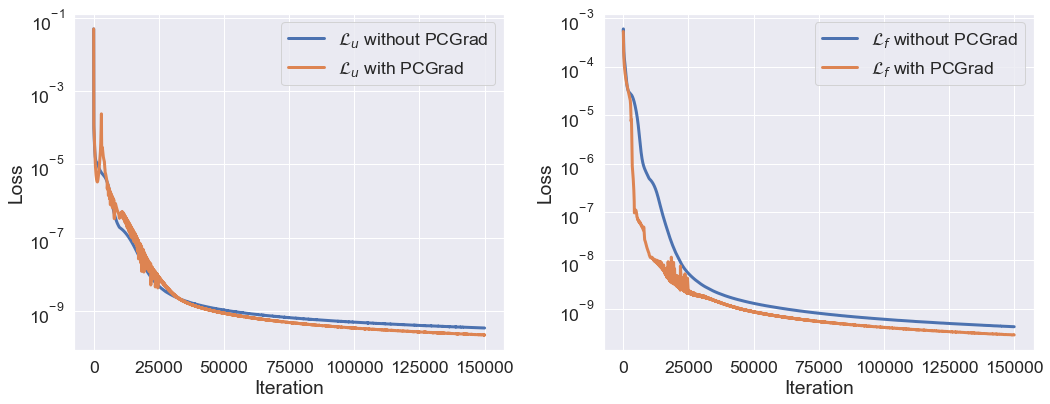

In [100]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = np.sum(pinn_loss_log[:, 1:4], axis = 1).flatten(),  linewidth = 3, 
             label = "$\mathcal{L}_f$ without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = np.sum(pinn_pcgrad_loss_log[:, 1:4], axis = 1).flatten(), 
             linewidth = 3, label = "$\mathcal{L}_f$ with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("performance_comparison_non_homo.pdf")

#### Solution quality comparison

In [101]:
matlab_solver_solution_df = pd.read_csv('nonHomo_300.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [102]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [103]:
matlab_solver_solution_df

state_0   state_1   state_2
0    0.999040  0.000418  0.000544
1    0.998080  0.000837  0.001087
2    0.997110  0.001255  0.001631
3    0.996150  0.001674  0.002175
4    0.995190  0.002092  0.002718
..        ...       ...       ...
295  0.000013  0.000272  0.999720
296  0.000012  0.000257  0.999730
297  0.000011  0.000242  0.999750
298  0.000010  0.000228  0.999760
299  0.000010  0.000215  0.999780

[300 rows x 3 columns]

In [104]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

n_star = 300+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
x_star_normalized = (x_star-mu)/sigma

In [105]:
y_pred = PINN_solver.model(x_star_normalized)
y_pred_pcgrad = PINN_solver_pcgrad.model(x_star_normalized)

In [106]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

In [107]:
sns.set_style("white")

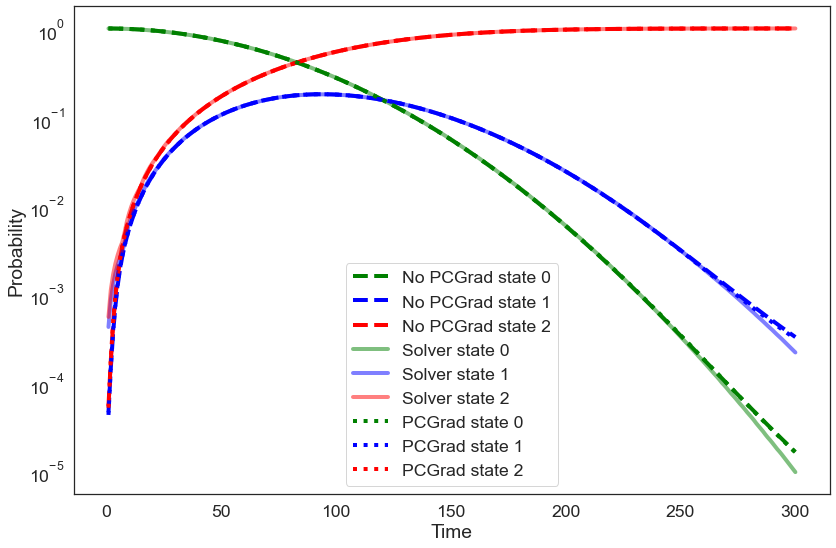

In [108]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'No PCGrad state 0', linewidth = 4, color = 'green', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'No PCGrad state 1', linewidth = 4, color = 'blue', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'No PCGrad state 2', linewidth = 4, color = 'red', 
             linestyle='--', ax=ax)

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], label = 'Solver state 0', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], label = 'Solver state 1', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], label = 'Solver state 2', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)

sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'PCGrad state 0', color = 'green', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'PCGrad state 1', color = 'blue', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'PCGrad state 2', color = 'red', linestyle='dotted',
             linewidth = 4, ax=ax)


ax.set_yscale("log")
ax.set_xlabel("Time")
ax.set_ylabel("Probability")

plt.tight_layout()
plt.savefig("comparison.pdf")

In [109]:
y_pred_df.tail()

state_0   state_1   state_2
295  0.000020  0.000381  0.999599
296  0.000019  0.000365  0.999616
297  0.000018  0.000350  0.999632
298  0.000017  0.000335  0.999648
299  0.000016  0.000321  0.999663

In [110]:
y_pred_pcgrad_df.tail()

state_0   state_1   state_2
295  0.000020  0.000363  0.999617
296  0.000019  0.000348  0.999633
297  0.000018  0.000334  0.999648
298  0.000017  0.000321  0.999663
299  0.000016  0.000308  0.999676

In [111]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

In [112]:
y_diff

state_0   state_1   state_2
0   -0.000861  0.000373  0.000490
1   -0.001606  0.000695  0.000915
2   -0.002095  0.000901  0.001190
3   -0.002225  0.000956  0.001267
4   -0.002010  0.000863  0.001148
..        ...       ...       ...
295 -0.000007 -0.000109  0.000121
296 -0.000007 -0.000108  0.000114
297 -0.000007 -0.000108  0.000118
298 -0.000007 -0.000107  0.000112
299 -0.000007 -0.000106  0.000117

[300 rows x 3 columns]

In [113]:
y_diff['mse'] = y_diff.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [114]:
y_diff.head()

state_0   state_1   state_2       mse      rmse
0 -0.000861  0.000373  0.000490  0.000001  0.001059
1 -0.001606  0.000695  0.000915  0.000004  0.001975
2 -0.002095  0.000901  0.001190  0.000007  0.002572
3 -0.002225  0.000956  0.001267  0.000007  0.002733
4 -0.002010  0.000863  0.001148  0.000006  0.002470

In [115]:
y_diff_pcgrad.head()

state_0   state_1   state_2       mse      rmse
0 -0.000867  0.000376  0.000493  0.000001  0.001066
1 -0.001596  0.000691  0.000909  0.000004  0.001962
2 -0.002045  0.000879  0.001162  0.000006  0.002511
3 -0.002132  0.000914  0.001216  0.000007  0.002619
4 -0.001896  0.000810  0.001087  0.000005  0.002331

In [116]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.0004730726887927551
RMSE of PINN with PCGrad is 0.00044638508109280737
